# Assessing metadata found in the Pangaea repository for datasets

**Aim.** The aim of this experiment is to evaluate if the RDF metadata published by [Pangaea](https://www.pangaea.de/) is following the FAIR principles guideline.

**Material and methods.** In this experiment, we launch a set of FAIR tests which are mostly based on SPARQL requests.

**Results.** We produce an UpSetPlot summarizing the number of resource validating each test, allowing to show some validation combination profiles.

In [6]:
import sys
parentdir = "../.."
sys.path.insert(0, parentdir)

import requests
from os import path
from tqdm.notebook import tqdm
import pandas as pd
import time

from metrics.WebResource import WebResource
from metrics.FAIRMetricsFactory import FAIRMetricsFactory
from metrics.AbstractFAIRMetrics import AbstractFAIRMetrics

In [7]:
from rdflib import ConjunctiveGraph, Namespace, URIRef
from rdflib.namespace import RDF, RDFS

schema = Namespace("http://schema.org/")

## 1. Retrieve a list of DOIs from the Pangaea repository API

In [8]:
TIMEOUT = (10, 300)
NB = '10000'
# NB = '10'
OUTPUT_DIR = "../results/pangaea_data/"

def pangaeaRestRequest():
    print("REST request to pangaea...")
    # rest request
    url = 'https://ws.pangaea.de/es/pangaea/panmd/_search?pretty&size=' + NB
    while True:
        try:
            response = requests.get(url, timeout=TIMEOUT)
            break
        except SSLError:
            time.sleep(5)
        except requests.exceptions.Timeout:
            time.sleep(5)

    return response

def pangaeaJsonParser(response):
    print("Parsing result...")
    json_response = response.json()

    dois_list = []
    for element in json_response["hits"]["hits"]:
        if "URI" in element["_source"].keys():
            doi = element["_source"]["URI"]
            dois_list.append(doi)
            
    print("Retrieved " + str(len(dois_list)) + " DOIs")
    return dois_list

In [9]:
response = pangaeaRestRequest()
dois_list = pangaeaJsonParser(response)

REST request to pangaea...
Parsing result...
Retrieved 10000 DOIs


## 2. Selecting a subset of the DOIs to create a sample

In [10]:
import random

random.seed(42)

samples_dois_list = random.sample(dois_list, 500)

splitedSize = 100
samples_chunks = [samples_dois_list[x:x+splitedSize] for x in range(0, len(samples_dois_list), splitedSize)]

In [32]:
print(len(samples_dois_list))

500


In [3]:
# open file in write mode
with open("results/pangaea_data/url_list", 'w+') as fp:
    for item in samples_dois_list:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

#open and read the file
with open("./results/pangaea_data/url_list") as f:
    lines = [line.strip() for line in file]
    samples_dois_list = lines

FileNotFoundError: [Errno 2] No such file or directory: './results/pangaea_data/url_list'

## 3. Initiating the list of metrics to be tested

In [12]:
metrics_collection = []
metrics_collection.append(FAIRMetricsFactory.get_A11(None))
metrics_collection.append(FAIRMetricsFactory.get_F1A(None))
metrics_collection.append(FAIRMetricsFactory.get_F1B(None))
metrics_collection.append(FAIRMetricsFactory.get_F2A(None))
metrics_collection.append(FAIRMetricsFactory.get_F2B(None))
metrics_collection.append(FAIRMetricsFactory.get_I1(None))
metrics_collection.append(FAIRMetricsFactory.get_I2(None))
metrics_collection.append(FAIRMetricsFactory.get_I3(None))
metrics_collection.append(FAIRMetricsFactory.get_R11(None))
metrics_collection.append(FAIRMetricsFactory.get_R12(None))
metrics_collection.append(FAIRMetricsFactory.get_R13(None))

df_columns = ['ID']
for m in metrics_collection:
    #print(m.get_principle_tag())
    df_columns.append(m.get_principle_tag())

In [13]:
exec_time_df = pd.DataFrame(columns=df_columns)

def eval_metrics(web_res):
    metrics_collection = []
    metrics_collection.append(FAIRMetricsFactory.get_A11(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_F1A(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_F1B(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_F2A(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_F2B(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_I1(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_I2(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_I3(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_R11(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_R12(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_R13(web_res))
    
    row = {"ID":web_res.get_url()}
    row_time = {"ID":web_res.get_url()}
    for m in metrics_collection:
        ts1 = time.time()
        e = m.evaluate()
        duration = round((time.time() - ts1), 2)
        if e is not None:
            row[m.get_principle_tag()] = e.get_score()
            row_time[m.get_principle_tag()] = duration
    
    return row, row_time

## 4. Launching the list of FAIR tests for each DOI

In [14]:
def mass_eval(samples):
    evals = []
    exec_time = []

    for sample in tqdm(samples):
        wr = WebResource(url=sample)
        row, row_time = eval_metrics(wr)
        evals.append(row)
        exec_time.append(row_time)
    
    return evals, exec_time

In [15]:
import logging
logging.getLogger().setLevel(logging.ERROR)

i = 0
for c in tqdm(samples_chunks):
    i += 1
    df = pd.DataFrame()
    df_time = pd.DataFrame()
    
    evals, exec_time = mass_eval(c)
    df = pd.concat([df, pd.DataFrame.from_records(evals)])
    df_time = pd.concat([df_time, pd.DataFrame.from_records(exec_time)])
    
    df.to_csv(OUTPUT_DIR + "FC_results_PANGAEA_"+str(i)+".csv")
    df_time.to_csv(OUTPUT_DIR + "exec_time_PANGAEA_"+str(i)+".csv")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.pangaea.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.742511', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.742511', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.742511', 'creator': [{'@id': 'https://orcid.org/0000-0003-0240-7317', '@type': 'Person', 'name': 'Claus-Dieter Hillenbrand', 'familyName': 'Hillenbrand', 'givenName': 'Claus-Dieter', 'identifier': 'https://orcid.org/0000-0003-0240-7317', 'email': 'hilc@bas.ac.uk'}, {'@id': 'https://orcid.org/0000-0002-8414-7389', '@type': 'Person', 'name': 'Robert D Larter', 'familyName': 'Larter', 'givenName': 'Robert D', 'identifier': 'https://orcid.org/0000-0002-8414-7389', 'url': 'http://www.antarctica.ac.uk/staff-profiles/template.php?user=rdla', 'email': 'rdla@bas.ac.uk'}, {'@id': 'https://orcid.org/0000-0003-1369-9482', '@type': 'Person', 'name': 'Julian A Dowdeswell', 'familyName': 'Dowdeswell', 'givenName': 'Julian A', 'identifier': 'https://orcid.org/0000-0003-1369-9482', 'e

INFO:5e30b6e7-7aed-4305-893d-0b0a6bb1d26f:Checking if the URL uses HTTP protocol
INFO:5e30b6e7-7aed-4305-893d-0b0a6bb1d26f:The resource use HTTP protocol
INFO:6f2ee782-8040-4f34-8bd7-75e588de700b:Checking if the URL is reachable, status code: 200
INFO:6f2ee782-8040-4f34-8bd7-75e588de700b:Status code is OK, meaning the url is Unique.
INFO:54cad1e3-74f6-4e53-8ca1-a6b31a7f6fec:Strong evaluation:
INFO:54cad1e3-74f6-4e53-8ca1-a6b31a7f6fec:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:54cad1e3-74f6-4e53-8ca1-a6b31a7f6fec:Found at least one of those property in metadata
INFO:51f40be4-0586-478b-a714-21a9fa16a598:Checking if data is structured, looking for at least one RDF triple...
INFO:51f40be4-0586-478b-a714-21a9fa16a598:749 RDF triples were found, thus data is in a well structured graph format
INFO:fb481217-4d6b-4d7f-ab62-5629a35e13ed:Strong evaluation:
INFO:fb481217-4d6b-4d7f-ab62-5629a35e13ed:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.931339', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.931339', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.931339', 'creator': [{'@type': 'Person', 'name': 'Andrea Y Frommel', 'familyName': 'Frommel', 'givenName': 'Andrea Y', 'email': 'afrommel@geomar.de'}, {'@type': 'Person', 'name': 'Justin Carless', 'familyName': 'Carless', 'givenName': 'Justin'}, {'@type': 'Person', 'name': 'Brian P V Hunt', 'familyName': 'Hunt', 'givenName': 'Brian P V'}, {'@type': 'Person', 'name': 'Colin J Brauner', 'familyName': 'Brauner', 'givenName': 'Colin J'}], 'name': 'Seawater carbonate chemistry and condition factor,haematocrit and plasma [Cl-],acute upper thermal tolerance and hypoxia tolerance of pink salmon', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'include

INFO:d6a11b81-7f8e-4f12-b5de-2e5c42d41e18:Checking if the URL uses HTTP protocol
INFO:d6a11b81-7f8e-4f12-b5de-2e5c42d41e18:The resource use HTTP protocol
INFO:5831507e-3663-4869-9739-46e2c670a848:Checking if the URL is reachable, status code: 200
INFO:5831507e-3663-4869-9739-46e2c670a848:Status code is OK, meaning the url is Unique.
INFO:47f646a6-e4de-45e0-a005-6b65754617b3:Strong evaluation:
INFO:47f646a6-e4de-45e0-a005-6b65754617b3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:47f646a6-e4de-45e0-a005-6b65754617b3:Found at least one of those property in metadata
INFO:7ef7380f-223b-48ce-a154-d71f7f47fa90:Checking if data is structured, looking for at least one RDF triple...
INFO:7ef7380f-223b-48ce-a154-d71f7f47fa90:1430 RDF triples were found, thus data is in a well structured graph format
INFO:9d79400e-4504-4332-899a-dc5278b69be3:Strong evaluation:
INFO:9d79400e-4504-4332-899a-dc5278b69be3:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@type': 'Dataset', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.713489', 'creator': [{'@id': 'https://orcid.org/0000-0003-2117-4176', '@type': 'Person', 'name': 'Antje Boetius', 'familyName': 'Boetius', 'givenName': 'Antje', 'identifier': 'https://orcid.org/0000-0003-2117-4176', 'url': 'http://www.awi.de/en/about-us/organisation/staff/antje-boetius.html', 'email': 'antje.boetius@awi.de'}, {'@id': 'https://orcid.org/0000-0002-4177-6644', '@type': 'Person', 'name': 'Janine Felden', 'familyName': 'Felden', 'givenName': 'Janine', 'identifier': 'https://orcid.org/0000-0002-4177-6644', 'url': 'http://www.mpi-bremen.de/Janine_Felden.html', 'email': 'jfelden@marum.de'}, {'@id': 'https://orcid.org/0000-0001-8281-2165', '@type': 'Person', 'name': 'Anna Lichtschlag', 'familyName': 'Lichtschlag', 'givenName': 'Anna', 'identifier': 'https://orcid.org/0000-0001-8281-2165', 'url': 'http://noc.ac.uk/node/100746', 'email': 'alic@noc.ac.uk'}], 'name':

INFO:6d08ef5e-3d7f-46e8-b53f-d6773f267aaf:Checking if the URL uses HTTP protocol
INFO:6d08ef5e-3d7f-46e8-b53f-d6773f267aaf:The resource use HTTP protocol
INFO:fdde89c4-6231-427d-9179-66c500e2a049:Checking if the URL is reachable, status code: 200
INFO:fdde89c4-6231-427d-9179-66c500e2a049:Status code is OK, meaning the url is Unique.
INFO:d074905c-adcd-431f-a189-4d2623a96bea:Strong evaluation:
INFO:d074905c-adcd-431f-a189-4d2623a96bea:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d074905c-adcd-431f-a189-4d2623a96bea:Found at least one of those property in metadata
INFO:91b0e869-7121-45df-93e4-a5d36395e105:Checking if data is structured, looking for at least one RDF triple...
INFO:91b0e869-7121-45df-93e4-a5d36395e105:172 RDF triples were found, thus data is in a well structured graph format
INFO:dac8c8de-70f9-4111-af56-044d3f3ed95c:Strong evaluation:
INFO:dac8c8de-70f9-4111-af56-044d3f3ed95c:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.129311', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.129311', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.129311', 'creator': [{'@type': 'Person', 'name': 'Catherine Goyet', 'familyName': 'Goyet', 'givenName': 'Catherine', 'email': 'cgoyet@univ-perp.fr'}, {'@id': 'https://orcid.org/0000-0003-2821-3553', '@type': 'Person', 'name': 'Edward T Peltzer', 'familyName': 'Peltzer', 'givenName': 'Edward T', 'identifier': 'https://orcid.org/0000-0003-2821-3553', 'email': 'epeltzer@whoi.edu'}], 'name': 'Total organic carbon from CTD cast KIWI-6/8-2', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https:

INFO:69cce921-f065-471d-8c9b-448a670ed11a:Weak evaluation:
INFO:69cce921-f065-471d-8c9b-448a670ed11a:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:69cce921-f065-471d-8c9b-448a670ed11a:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:71a2b402-29c3-4abd-9d93-6aefd549c873:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:71a2b402-29c3-4abd-9d93-6aefd549c873:At least 3 different domains were found in metadata (14)
INFO:4819aebf-12fb-4822-bb95-d70ebdef7879:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:4819aebf-12fb-4822-bb95-d70ebdef7879:At least one of the licence property was found in metadata !
INFO:50b15882-8d86-4063-91bf-67c2b96e3ebd:Checking that at l

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.381188', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.381188', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.381188', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS37/13150 during POLARSTERN cruise ARK-XI/2 on 1995-10-09 09:30h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.p

INFO:8efbcbf2-b9ca-4b25-a6b7-50597bd62a4a:Weak evaluation:
INFO:8efbcbf2-b9ca-4b25-a6b7-50597bd62a4a:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:8efbcbf2-b9ca-4b25-a6b7-50597bd62a4a:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:6be8f477-3509-4566-a364-35be7ae98ef9:Checking if data is structured, looking for at least one RDF triple...
INFO:6be8f477-3509-4566-a364-35be7ae98ef9:239 RDF triples were found, thus data is in a well structured graph format
INFO:9ec26b0f-a8ec-4876-b65c-a3d63ef8cde6:Strong evaluation:
INFO:9ec26b0f-a8ec-4876-b65c-a3d63ef8cde6:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:9ec26b0f-a8ec-4876-b65c-a3d63ef8cde6:All classes found in those ontology registries
INFO:9ec26b0f-a8ec-4876-b65c-a3d63ef8cde6:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:9ec26b0f-a8ec-4876-b65c-a3d63ef8cde6:Weak evaluation:
INFO:9ec26b0f-a8ec-4876-b65c-a3d63ef8cd

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.407950', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.407950', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.407950', 'creator': {'@type': 'Person', 'name': 'Marko Herrmann', 'familyName': 'Herrmann', 'givenName': 'Marko', 'email': 'marko.herrmann@ufra.edu.br'}, 'name': 'Assemblage of soft bottom community at 10m depth of Kongsfjorden, Arctic', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2006-04-06', 'description': 'This dataset is about: Assemblage of soft bottom community at 10m depth of Kongsfjorden, Arctic.', 'citation': {'@id': 'https://doi.or

INFO:2a773238-6688-4b99-821e-7b5f23947b5c:Weak evaluation:
INFO:2a773238-6688-4b99-821e-7b5f23947b5c:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:2a773238-6688-4b99-821e-7b5f23947b5c:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:505c584d-7af7-4056-94a3-62ee9af06e88:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:505c584d-7af7-4056-94a3-62ee9af06e88:At least 3 different domains were found in metadata (10)
INFO:a61d0ee8-5a16-4b44-acdd-445b8515fe59:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:a61d0ee8-5a16-4b44-acdd-445b8515fe59:At least one of the licence property was found in metadata !
INFO:6483b6b1-3bbe-44f4-96eb-f196202d200b:Checking that at l

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.54990', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.54990', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.54990', 'creator': [{'@type': 'Person', 'name': 'Hans G Dietrich', 'familyName': 'Dietrich', 'givenName': 'Hans G'}, {'@type': 'Person', 'name': 'D Klosa', 'familyName': 'Klosa', 'givenName': 'D'}], 'name': 'Carbonate content of sediment core CRP-1 (Table 1)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '1998-01-15', '@reverse': {'isBasedOn': {'@id': 'hdl:10013/epic.28336.d001', '@type': ['CreativeWork', 'PublicationIssue'], 'identifier': 'hdl:

INFO:a1bb6d66-80d4-4571-b8bf-498fdecc522b:Weak evaluation:
INFO:a1bb6d66-80d4-4571-b8bf-498fdecc522b:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:a1bb6d66-80d4-4571-b8bf-498fdecc522b:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:836a7b67-7541-4575-96d6-bc07fedc6c13:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:836a7b67-7541-4575-96d6-bc07fedc6c13:At least 3 different domains were found in metadata (9)
INFO:aec25b69-0df9-4c8d-8634-b54743bc6052:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:aec25b69-0df9-4c8d-8634-b54743bc6052:At least one of the licence property was found in metadata !
INFO:9e903ef2-ac9a-4ba0-adbf-5b892d8d81bd:Checking that at le

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.752846', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.752846', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.752846', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:e0bdce94-75a9-4a0f-a01d-8c294a6598c2:Checking if the URL uses HTTP protocol
INFO:e0bdce94-75a9-4a0f-a01d-8c294a6598c2:The resource use HTTP protocol
INFO:4642ad97-305d-4b84-8a62-11dd4417124f:Checking if the URL is reachable, status code: 200
INFO:4642ad97-305d-4b84-8a62-11dd4417124f:Status code is OK, meaning the url is Unique.
INFO:bedf3b00-31d9-4db9-ad79-bce5fa076027:Strong evaluation:
INFO:bedf3b00-31d9-4db9-ad79-bce5fa076027:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:bedf3b00-31d9-4db9-ad79-bce5fa076027:Found at least one of those property in metadata
INFO:ecf0aa9e-6913-400c-9a8d-812a3961d89f:Checking if data is structured, looking for at least one RDF triple...
INFO:ecf0aa9e-6913-400c-9a8d-812a3961d89f:522 RDF triples were found, thus data is in a well structured graph format
INFO:8d64b678-db09-4949-9cf3-4aca60948482:Strong evaluation:
INFO:8d64b678-db09-4949-9cf3-4aca60948482:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.498248', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.498248', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.498248', 'creator': [{'@type': 'Person', 'name': 'Valery A Golubev', 'familyName': 'Golubev', 'givenName': 'Valery A'}, {'@type': 'Person', 'name': 'Aleksey N Zuyev', 'familyName': 'Zuyev', 'givenName': 'Aleksey N'}, {'@type': 'Person', 'name': 'Christoph Oelke', 'familyName': 'Oelke', 'givenName': 'Christoph', 'email': 'christoph.oelke@awi.de'}], 'name': 'Physical oceanography from BT during cruise U74X008629B_1955', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'

INFO:262209b5-326c-4061-b739-ae23d447553c:Weak evaluation:
INFO:262209b5-326c-4061-b739-ae23d447553c:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:262209b5-326c-4061-b739-ae23d447553c:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:3e2b997e-397e-4bfc-b252-a27a439d21ab:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:3e2b997e-397e-4bfc-b252-a27a439d21ab:At least 3 different domains were found in metadata (11)
INFO:4f70cf68-85ce-438f-a882-36c2549b8c08:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:4f70cf68-85ce-438f-a882-36c2549b8c08:At least one of the licence property was found in metadata !
INFO:5e010de1-8ab2-4f06-9356-1998d2bc803d:Checking that at l

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.745151', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.745151', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.745151', 'creator': {'@type': 'Person', 'name': 'Justus van Beusekom', 'familyName': 'van Beusekom', 'givenName': 'Justus', 'url': 'https://www.biologie.uni-hamburg.de/en/ihf/mitarbeiter/researchers/beusekom.html', 'email': 'justus.van.beusekom@uni-hamburg.de'}, 'name': 'Hydrochemistry time series at station List Reede in 2008', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2010-09-13', 'sourceOrganization': {'@id': 'https://ror.org/032e6b942'

INFO:10093c37-f870-4d72-969e-64d10265f306:Checking if the URL uses HTTP protocol
INFO:10093c37-f870-4d72-969e-64d10265f306:The resource use HTTP protocol
INFO:96248426-7b9f-4633-9ff2-df7e607ee21c:Checking if the URL is reachable, status code: 200
INFO:96248426-7b9f-4633-9ff2-df7e607ee21c:Status code is OK, meaning the url is Unique.
INFO:6195a42d-4208-4599-aa69-0a7dfb7859c8:Strong evaluation:
INFO:6195a42d-4208-4599-aa69-0a7dfb7859c8:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6195a42d-4208-4599-aa69-0a7dfb7859c8:Found at least one of those property in metadata
INFO:ec2a75c6-7b2a-4bce-b41d-4633029ae2ab:Checking if data is structured, looking for at least one RDF triple...
INFO:ec2a75c6-7b2a-4bce-b41d-4633029ae2ab:486 RDF triples were found, thus data is in a well structured graph format
INFO:8e58162d-5682-4586-b014-b04fefe04f65:Strong evaluation:
INFO:8e58162d-5682-4586-b014-b04fefe04f65:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.856023', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.856023', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.856023', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS95/37632 during POLARSTERN cruise PS95.2 (ANT-XXXI/1.2) on 2015-11-23 10:46h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': '

INFO:a93824ef-e8ba-4d1e-864d-395e5312d343:Checking if data is structured, looking for at least one RDF triple...
INFO:a93824ef-e8ba-4d1e-864d-395e5312d343:239 RDF triples were found, thus data is in a well structured graph format
INFO:6527f9a2-1408-4cd7-a564-e877963ab3bb:Strong evaluation:
INFO:6527f9a2-1408-4cd7-a564-e877963ab3bb:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:6527f9a2-1408-4cd7-a564-e877963ab3bb:All classes found in those ontology registries
INFO:6527f9a2-1408-4cd7-a564-e877963ab3bb:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:6527f9a2-1408-4cd7-a564-e877963ab3bb:Weak evaluation:
INFO:6527f9a2-1408-4cd7-a564-e877963ab3bb:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:6527f9a2-1408-4cd7-a564-e877963ab3bb:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:fe4a637c-2519-4dd9-8436-1d6f42d68326:Checking that at least 3 different URL authorities are u

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.837989', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.837989', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.837989', 'creator': {'@type': 'Organization', 'name': 'Expedition 347 Scientists', 'url': 'https://www.pangaea.de/ddi?request=iodp-msp/BSBP_staff&title=Expedition+347+Scientists&format=html'}, 'name': 'Light reflectance (RGB) of IODP Hole 347-M0064A', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2014-11-06', 'description': 'This dataset is about: Light reflectance (RGB) of IODP Hole 347-M0064A.', 'citation': [{'@id': 'https://doi.org/10.2204/

INFO:38b34f44-b201-430b-82ab-5cefcf01b5c7:All classes found in those ontology registries
INFO:38b34f44-b201-430b-82ab-5cefcf01b5c7:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:38b34f44-b201-430b-82ab-5cefcf01b5c7:Weak evaluation:
INFO:38b34f44-b201-430b-82ab-5cefcf01b5c7:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:38b34f44-b201-430b-82ab-5cefcf01b5c7:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:00e46fd1-95bd-486b-ab6c-fca01bd6baed:Checking if data is structured, looking for at least one RDF triple...
INFO:00e46fd1-95bd-486b-ab6c-fca01bd6baed:295 RDF triples were found, thus data is in a well structured graph format
INFO:2ea50ebc-80c3-406d-936e-0b6de2f1d4fb:Strong evaluation:
INFO:2ea50ebc-80c3-406d-936e-0b6de2f1d4fb:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:2ea50ebc-80c3-406d-936e-0b6de2f1d4fb:All classes found in those ontology registries
INFO:2ea

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.588912', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.588912', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.588912', 'creator': [{'@type': 'Person', 'name': 'Fritz Hans Schweingruber', 'familyName': 'Schweingruber', 'givenName': 'Fritz Hans', 'email': 'fritz.schweingruber@wsl.ch'}, {'@type': 'Person', 'name': 'Moritz Eimiger', 'familyName': 'Eimiger', 'givenName': 'Moritz'}], 'name': 'Tree-ring measurements of Abies alba (Silver fir) from sample ASPRO-71', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-24', 'sourceOrganization': {'@id': 'http

INFO:523000f6-d549-4ca8-8e11-abf44fd8d0f9:Weak evaluation:
INFO:523000f6-d549-4ca8-8e11-abf44fd8d0f9:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:523000f6-d549-4ca8-8e11-abf44fd8d0f9:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:c2abe4d4-4792-4bcd-b0a4-d0d4a81a42cf:Checking if data is structured, looking for at least one RDF triple...
INFO:c2abe4d4-4792-4bcd-b0a4-d0d4a81a42cf:272 RDF triples were found, thus data is in a well structured graph format
INFO:88146afa-829b-4d3c-accc-e93f2bff460d:Strong evaluation:
INFO:88146afa-829b-4d3c-accc-e93f2bff460d:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:88146afa-829b-4d3c-accc-e93f2bff460d:All classes found in those ontology registries
INFO:88146afa-829b-4d3c-accc-e93f2bff460d:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:88146afa-829b-4d3c-accc-e93f2bff460d:Weak evaluation:
INFO:88146afa-829b-4d3c-accc-e93f2bff46

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.902390', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.902390', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.902390', 'creator': [{'@id': 'https://orcid.org/0000-0002-4834-7965', '@type': 'Person', 'name': 'Paul Wintersteller', 'familyName': 'Wintersteller', 'givenName': 'Paul', 'identifier': 'https://orcid.org/0000-0002-4834-7965', 'email': 'pwintersteller@marum.de'}, {'@id': 'https://orcid.org/0000-0003-3228-7862', '@type': 'Person', 'name': 'Christian dos Santos Ferreira', 'familyName': 'dos Santos Ferreira', 'givenName': 'Christian', 'identifier': 'https://orcid.org/0000-0003-3228-7862', 'email': 'cferreira@marum.de'}], 'name': 'Gridded bathymetry from EM120 multibeam echosounder of RV METEOR cruise M70/3 (Svalbard continental margin)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science

INFO:1f379b30-2539-46d3-a2f4-e88122ef2fc2:All classes found in those ontology registries
INFO:1f379b30-2539-46d3-a2f4-e88122ef2fc2:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:1f379b30-2539-46d3-a2f4-e88122ef2fc2:Weak evaluation:
INFO:1f379b30-2539-46d3-a2f4-e88122ef2fc2:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:1f379b30-2539-46d3-a2f4-e88122ef2fc2:http://schema.org/Article known in Linked Open Vocabularies (LOV)
INFO:cd005b40-1e0d-4ec5-a2a4-45be2878e73a:Checking if data is structured, looking for at least one RDF triple...
INFO:cd005b40-1e0d-4ec5-a2a4-45be2878e73a:188 RDF triples were found, thus data is in a well structured graph format
INFO:54de3e5a-ed35-409f-bcd0-04dd8ce5ed7a:Strong evaluation:
INFO:54de3e5a-ed35-409f-bcd0-04dd8ce5ed7a:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:54de3e5a-ed35-409f-bcd0-04dd8ce5ed7a:All classes found in those ontology registries
INFO:54de3e5a

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.741578', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.741578', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.741578', 'creator': {'@type': 'Person', 'name': 'Neville T Moar', 'familyName': 'Moar', 'givenName': 'Neville T', 'email': 'moarn@landcareresearch.co.nz'}, 'name': 'Lithology of sediment core NCURLEY, Nick of Curleywee, United Kingdom', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2010-06-14', 'sourceOrganization': {'@type': 'Organization', 'name': 'European Pollen Database (EPD)'}, 'description': 'This dataset was archived on 2010-05-11 from

INFO:a672466f-e3e4-4dbe-81a8-0fcd17a38b28:Weak evaluation:
INFO:a672466f-e3e4-4dbe-81a8-0fcd17a38b28:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:a672466f-e3e4-4dbe-81a8-0fcd17a38b28:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:54684ac7-bc4b-4006-bb0f-dc659b8140f5:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:54684ac7-bc4b-4006-bb0f-dc659b8140f5:At least 3 different domains were found in metadata (10)
INFO:b66dd7e3-21e2-4ffe-88db-370e4c228c51:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:b66dd7e3-21e2-4ffe-88db-370e4c228c51:At least one of the licence property was found in metadata !
INFO:91d7d0c5-b7cf-442c-9a14-a13b619debf6:Checking that at l

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.812229', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.812229', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.812229', 'creator': [{'@id': 'https://orcid.org/0000-0002-7846-7546', '@type': 'Person', 'name': 'Kenneth A Farley', 'familyName': 'Farley', 'givenName': 'Kenneth A', 'identifier': 'https://orcid.org/0000-0002-7846-7546'}, {'@type': 'Person', 'name': 'Alessandro Montanari', 'familyName': 'Montanari', 'givenName': 'Alessandro'}, {'@type': 'Person', 'name': 'Rodolfo Coccioni', 'familyName': 'Coccioni', 'givenName': 'Rodolfo', 'email': 'rodolfo.coccioni@uniurb.it'}], 'name': '(Table S1) He isotope ratios from Bottaccione Gorge', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'di

INFO:e5580b5b-6dc3-4bb6-a514-92db1dcf4215:Checking if data is structured, looking for at least one RDF triple...
INFO:e5580b5b-6dc3-4bb6-a514-92db1dcf4215:366 RDF triples were found, thus data is in a well structured graph format
INFO:f6f863ba-9627-415f-b107-30f28d4fc2b9:Strong evaluation:
INFO:f6f863ba-9627-415f-b107-30f28d4fc2b9:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:f6f863ba-9627-415f-b107-30f28d4fc2b9:All classes found in those ontology registries
INFO:f6f863ba-9627-415f-b107-30f28d4fc2b9:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:f6f863ba-9627-415f-b107-30f28d4fc2b9:Weak evaluation:
INFO:f6f863ba-9627-415f-b107-30f28d4fc2b9:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:f6f863ba-9627-415f-b107-30f28d4fc2b9:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:442f74cd-58bd-408f-ba8e-6272d2c94729:Checking that at least 3 different URL authorities are 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.126645', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.126645', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.126645', 'creator': [{'@type': 'Person', 'name': 'Nicole Biebow', 'familyName': 'Biebow', 'givenName': 'Nicole', 'url': 'http://www.awi.de/en/about-us/organisation/staff/nicole-biebow.html', 'email': 'nicole.biebow@awi.de'}, {'@type': 'Person', 'name': 'R Kulinich', 'familyName': 'Kulinich', 'givenName': 'R'}, {'@type': 'Person', 'name': 'Boris V Baranov', 'familyName': 'Baranov', 'givenName': 'Boris V', 'email': 'BARANOV@CHIP.SIO.RSSI.RU'}], 'name': 'Hydrographic measurements at CTD station LV29-69-4', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription

INFO:4586ad3b-ad47-4ed2-bc27-198dff356c72:Weak evaluation:
INFO:4586ad3b-ad47-4ed2-bc27-198dff356c72:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:4586ad3b-ad47-4ed2-bc27-198dff356c72:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:9818ecab-6eec-49b5-9f08-935e64be8b70:Checking if data is structured, looking for at least one RDF triple...
INFO:9818ecab-6eec-49b5-9f08-935e64be8b70:351 RDF triples were found, thus data is in a well structured graph format
INFO:d038737a-ec7c-4830-a3f5-517205299864:Strong evaluation:
INFO:d038737a-ec7c-4830-a3f5-517205299864:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:d038737a-ec7c-4830-a3f5-517205299864:All classes found in those ontology registries
INFO:d038737a-ec7c-4830-a3f5-517205299864:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:d038737a-ec7c-4830-a3f5-517205299864:Weak evaluation:
INFO:d038737a-ec7c-4830-a3f5-517205299

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.549008', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.549008', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.549008', 'creator': [{'@type': 'Person', 'name': 'Gabriel Claramunt', 'familyName': 'Claramunt', 'givenName': 'Gabriel', 'email': 'gabriel.claramunt@unap.cl'}, {'@type': 'Person', 'name': 'Edgardo Santander', 'familyName': 'Santander', 'givenName': 'Edgardo'}], 'name': 'Nutrients measured on water bottle samples at station Chan_2003-10-17_12, Chanavallita, Chile', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2006-11-23', 'sourceOrganization':

INFO:b0980322-6559-492a-9c0b-99ada33b3d9a:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:b0980322-6559-492a-9c0b-99ada33b3d9a:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:76215de0-5a31-4ace-9930-26211a59c375:Checking if data is structured, looking for at least one RDF triple...
INFO:76215de0-5a31-4ace-9930-26211a59c375:298 RDF triples were found, thus data is in a well structured graph format
INFO:f443c5fd-674d-4280-8763-647fc00bdc57:Strong evaluation:
INFO:f443c5fd-674d-4280-8763-647fc00bdc57:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:f443c5fd-674d-4280-8763-647fc00bdc57:All classes found in those ontology registries
INFO:f443c5fd-674d-4280-8763-647fc00bdc57:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:f443c5fd-674d-4280-8763-647fc00bdc57:Weak evaluation:
INFO:f443c5fd-674d-4280-8763-647fc00bdc57:Checking if at least one class used in RDF is known in O

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.741136', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.741136', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.741136', 'creator': {'@id': 'https://orcid.org/0000-0002-8745-9636', '@type': 'Person', 'name': 'Andrei A Andreev', 'familyName': 'Andreev', 'givenName': 'Andrei A', 'identifier': 'https://orcid.org/0000-0002-8745-9636', 'url': 'http://www.geologie.uni-koeln.de/andreev.html', 'email': 'andrej.andreev@awi.de'}, 'name': 'Lithology of sediment core BAIDARA, Baidara, Russia', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2010-06-14', 'sourceOrgani

INFO:4d323475-ca98-41dc-a6f9-dc6d897b1790:All classes found in those ontology registries
INFO:4d323475-ca98-41dc-a6f9-dc6d897b1790:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:4d323475-ca98-41dc-a6f9-dc6d897b1790:Weak evaluation:
INFO:4d323475-ca98-41dc-a6f9-dc6d897b1790:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:4d323475-ca98-41dc-a6f9-dc6d897b1790:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:8c5b1963-4c2c-4f4d-bcdb-f211f30de74b:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:8c5b1963-4c2c-4f4d-bcdb-f211f30de74b:At least 3 different domains were found in metadata (12)
INFO:e88ec4e0-d0ff-4f54-9bbd-7422a71e1fd7:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.889516', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.889516', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.889516', 'creator': [{'@type': 'Person', 'name': 'Rainer Knust', 'familyName': 'Knust', 'givenName': 'Rainer', 'url': 'http://www.awi.de/en/about-us/organisation/staff/rainer-knust.html', 'email': 'rainer.knust@awi.de'}, {'@type': 'Person', 'name': 'Gerd Rohardt', 'familyName': 'Rohardt', 'givenName': 'Gerd', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gerd-rohardt.html', 'email': 'gerd.rohardt@awi.de'}], 'name': 'Continuous thermosalinograph oceanography along POLARSTERN cruise track PS105 (ANT-XXXII/4)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambigu

INFO:5dfc06a2-6591-4786-9144-133417a99703:All classes found in those ontology registries
INFO:5dfc06a2-6591-4786-9144-133417a99703:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:5dfc06a2-6591-4786-9144-133417a99703:Weak evaluation:
INFO:5dfc06a2-6591-4786-9144-133417a99703:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:5dfc06a2-6591-4786-9144-133417a99703:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:464e9d09-3478-47d7-bc59-8e86e373a6c6:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:464e9d09-3478-47d7-bc59-8e86e373a6c6:At least 3 different domains were found in metadata (13)
INFO:663a79e6-d6b1-40c8-90ff-2093450d1c5a:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.752597', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.752597', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.752597', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:f56234fd-0f1e-4e7f-b05f-447b3228d1e3:Weak evaluation:
INFO:f56234fd-0f1e-4e7f-b05f-447b3228d1e3:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:f56234fd-0f1e-4e7f-b05f-447b3228d1e3:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:22dd1ffa-8f36-4aa2-89d8-4de6b0acac08:Checking if data is structured, looking for at least one RDF triple...
INFO:22dd1ffa-8f36-4aa2-89d8-4de6b0acac08:468 RDF triples were found, thus data is in a well structured graph format
INFO:b5c6226d-413a-4e0f-97cd-4984522b4ed7:Strong evaluation:
INFO:b5c6226d-413a-4e0f-97cd-4984522b4ed7:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:b5c6226d-413a-4e0f-97cd-4984522b4ed7:All classes found in those ontology registries
INFO:b5c6226d-413a-4e0f-97cd-4984522b4ed7:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:b5c6226d-413a-4e0f-97cd-4984522b4ed7:Weak evaluation:
INFO:b5c6226d-413a-4e0f-97cd-4984522b4

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.140794', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.140794', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.140794', 'creator': [{'@type': 'Person', 'name': 'Rudolph Corvaisier', 'familyName': 'Corvaisier', 'givenName': 'Rudolph', 'email': 'rudolph.corvaisier@univ-brest.fr'}, {'@type': 'Person', 'name': 'J Morvan', 'familyName': 'Morvan', 'givenName': 'J'}], 'name': 'Nutrients measured on water bottle samples at station ANTARES-IV_008', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2004-02-26', 'description': 'This dataset is about: Nutrients measur

INFO:351b565b-7a1f-459e-9bd3-f2d8df17ce17:Checking if data is structured, looking for at least one RDF triple...
INFO:351b565b-7a1f-459e-9bd3-f2d8df17ce17:235 RDF triples were found, thus data is in a well structured graph format
INFO:949ed5ff-87e4-4ea4-a91b-b2488560dc61:Strong evaluation:
INFO:949ed5ff-87e4-4ea4-a91b-b2488560dc61:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:949ed5ff-87e4-4ea4-a91b-b2488560dc61:All classes found in those ontology registries
INFO:949ed5ff-87e4-4ea4-a91b-b2488560dc61:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:949ed5ff-87e4-4ea4-a91b-b2488560dc61:Weak evaluation:
INFO:949ed5ff-87e4-4ea4-a91b-b2488560dc61:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:949ed5ff-87e4-4ea4-a91b-b2488560dc61:http://schema.org/Article known in Linked Open Vocabularies (LOV)
INFO:78737f8a-a027-4593-a382-a26015c864f1:Checking that at least 3 different URL authorities are used 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.146058', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.146058', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.146058', 'creator': {'@type': 'Person', 'name': 'Erhard Preßler', 'familyName': 'Preßler', 'givenName': 'Erhard', 'url': 'http://www.pressler.com.de/', 'email': 'info@pressler-gmbh.com'}, 'name': "Tree-ring width of Quercus species from historical object sample 6338B/01B, Netherlands, 's-Hertogenbosch", 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2010-05-14', 'sourceOrganization': {'@type': 'Organization', 'name': 'Preßler GmbH - Planung und

INFO:99e37d8c-a421-4ed8-bbbe-dacee2ba567d:Weak evaluation:
INFO:99e37d8c-a421-4ed8-bbbe-dacee2ba567d:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:99e37d8c-a421-4ed8-bbbe-dacee2ba567d:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:deb51bd8-c1f6-49c5-89d3-62ae648cc2c0:Checking if data is structured, looking for at least one RDF triple...
INFO:deb51bd8-c1f6-49c5-89d3-62ae648cc2c0:170 RDF triples were found, thus data is in a well structured graph format
INFO:3b3e96cb-252b-4449-b301-3672eb210dec:Strong evaluation:
INFO:3b3e96cb-252b-4449-b301-3672eb210dec:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:3b3e96cb-252b-4449-b301-3672eb210dec:All classes found in those ontology registries
INFO:3b3e96cb-252b-4449-b301-3672eb210dec:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:3b3e96cb-252b-4449-b301-3672eb210dec:Weak evaluation:
INFO:3b3e96cb-252b-4449-b301-3672eb210

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.122426', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.122426', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.122426', 'creator': {'@type': 'Person', 'name': 'Hugh W Ducklow', 'familyName': 'Ducklow', 'givenName': 'Hugh W', 'email': 'hducklow@ldeo.columbia.edu'}, 'name': 'Bacterial abundance, thymidine and leucine incorporation at station TT008_5-TM9', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-10-07', 'description': 'This dataset is about: Bacterial abundance, thymidine and leucine incorporation at station TT008_5-TM9.', 'citation': [{'@type'

INFO:8bac0f38-6314-44ac-a1ca-90354c81398c:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:8bac0f38-6314-44ac-a1ca-90354c81398c:Weak evaluation:
INFO:8bac0f38-6314-44ac-a1ca-90354c81398c:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:8bac0f38-6314-44ac-a1ca-90354c81398c:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:ef4d4944-9456-4138-a8d4-9087fcb36746:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:ef4d4944-9456-4138-a8d4-9087fcb36746:At least 3 different domains were found in metadata (12)
INFO:40246883-82d9-45a5-90b1-a3b61dcf2b3d:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:40246883-82d9-45a5-90b1-a3b61dcf2b3d:At l

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.781274', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.781274', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.781274', 'creator': {'@type': 'Person', 'name': 'Erhard Preßler', 'familyName': 'Preßler', 'givenName': 'Erhard', 'url': 'http://www.pressler.com.de/', 'email': 'info@pressler-gmbh.com'}, 'name': 'Tree-ring width of Quercus species from historical object sample 6630B/02A, Romania, Biertan (Birthälm)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2012-05-10', 'sourceOrganization': {'@type': 'Organization', 'name': 'Preßler GmbH - Planung und B

INFO:708e4ebf-3938-4c81-bfb2-4b44bcfd0e99:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:708e4ebf-3938-4c81-bfb2-4b44bcfd0e99:At least 3 different domains were found in metadata (9)
INFO:1c4040a9-4cfe-49af-8ace-4a23a630d802:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:1c4040a9-4cfe-49af-8ace-4a23a630d802:None of the licence property were found in metadata
INFO:6a5aa6c7-d3bf-4cc8-8da8-ab088b372f48:Checking that at least one of the following provenance properties is found in metadata:

            prov:wasGeneratedBy 
            prov:wasDerivedFrom 
            prov:wasAttributedTo 
            prov:used 
            prov:wasInformedBy 
            prov:wasAssociatedWith
            prov:startedAtTime 
         

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.835675', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.835675', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.835675', 'creator': [{'@type': 'Person', 'name': 'Andy W Dale', 'familyName': 'Dale', 'givenName': 'Andy W', 'email': 'adale@geomar.de'}, {'@type': 'Person', 'name': 'Bettina Domeyer', 'familyName': 'Domeyer', 'givenName': 'Bettina', 'email': 'bdomeyer@geomar.de'}, {'@type': 'Person', 'name': 'Stefan Sommer', 'familyName': 'Sommer', 'givenName': 'Stefan', 'email': 'ssommer@geomar.de'}], 'name': 'Particulate geochemistry of sediment core MSM17/4_406', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science',

INFO:441599ec-db2d-45aa-80f6-74ddcacfbbfc:Checking if the URL uses HTTP protocol
INFO:441599ec-db2d-45aa-80f6-74ddcacfbbfc:The resource use HTTP protocol
INFO:f81a69db-fae6-48f8-add4-658b5a9f476e:Checking if the URL is reachable, status code: 200
INFO:f81a69db-fae6-48f8-add4-658b5a9f476e:Status code is OK, meaning the url is Unique.
INFO:da856b8e-193b-40ae-8319-1d695785eeeb:Strong evaluation:
INFO:da856b8e-193b-40ae-8319-1d695785eeeb:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:da856b8e-193b-40ae-8319-1d695785eeeb:Found at least one of those property in metadata
INFO:b8fa0a35-a892-438c-b080-2f5adae8dcc0:Checking if data is structured, looking for at least one RDF triple...
INFO:b8fa0a35-a892-438c-b080-2f5adae8dcc0:555 RDF triples were found, thus data is in a well structured graph format
INFO:229f7fa0-7994-44ee-b4af-ab9f0eff53fd:Strong evaluation:
INFO:229f7fa0-7994-44ee-b4af-ab9f0eff53fd:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.121322', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.121322', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.121322', 'creator': {'@type': 'Person', 'name': 'Catherine Goyet', 'familyName': 'Goyet', 'givenName': 'Catherine', 'email': 'cgoyet@univ-perp.fr'}, 'name': 'Total carbon dioxide and alkalinity at station TT012_5-CTD33', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-09-30', 'description': 'This dataset is about: Total carbon dioxide and alkalinity at station TT012_5-CTD33.', 'citation': [{'@type': 'CreativeWork', 'creator': {'@type': 'Per

INFO:ad6703b1-da96-4747-bba0-cb42aac68600:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:ad6703b1-da96-4747-bba0-cb42aac68600:All classes found in those ontology registries
INFO:ad6703b1-da96-4747-bba0-cb42aac68600:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:ad6703b1-da96-4747-bba0-cb42aac68600:Weak evaluation:
INFO:ad6703b1-da96-4747-bba0-cb42aac68600:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:ad6703b1-da96-4747-bba0-cb42aac68600:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:ae5b5867-1de4-4d7e-b4fc-0368a32de1c8:Checking if data is structured, looking for at least one RDF triple...
INFO:ae5b5867-1de4-4d7e-b4fc-0368a32de1c8:242 RDF triples were found, thus data is in a well structured graph format
INFO:36fc9626-bdf6-4dca-afcf-0b65f7af9aa5:Strong evaluation:
INFO:36fc9626-bdf6-4dca-afcf-0b65f7af9aa5:Checking if all classes used in RDF are known in OLS, L

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.812000', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.812000', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.812000', 'creator': [{'@id': 'https://orcid.org/0000-0003-1582-6801', '@type': 'Person', 'name': 'Stephen J Romaniello', 'familyName': 'Romaniello', 'givenName': 'Stephen J', 'identifier': 'https://orcid.org/0000-0003-1582-6801', 'email': 'sromanie@asu.edu'}, {'@type': 'Person', 'name': 'Achim D Herrmann', 'familyName': 'Herrmann', 'givenName': 'Achim D'}, {'@type': 'Person', 'name': 'Ariel D Anbar', 'familyName': 'Anbar', 'givenName': 'Ariel D'}], 'name': 'Chemistry and isotope variations in primary precipitates for the Exuma Island region of the Bahamas', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'Data

INFO:2e79d7e4-73dc-4a81-819b-024f50629874:Checking if the URL uses HTTP protocol
INFO:2e79d7e4-73dc-4a81-819b-024f50629874:The resource use HTTP protocol
INFO:540c3226-1af1-4fdb-a86d-db9b00a0ec01:Checking if the URL is reachable, status code: 200
INFO:540c3226-1af1-4fdb-a86d-db9b00a0ec01:Status code is OK, meaning the url is Unique.
INFO:6a82d5b6-9fb8-42f9-b156-7cbcb89d50fb:Strong evaluation:
INFO:6a82d5b6-9fb8-42f9-b156-7cbcb89d50fb:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6a82d5b6-9fb8-42f9-b156-7cbcb89d50fb:Found at least one of those property in metadata
INFO:35c596ef-9e5d-4365-a2d3-b943eb244b6d:Checking if data is structured, looking for at least one RDF triple...
INFO:35c596ef-9e5d-4365-a2d3-b943eb244b6d:804 RDF triples were found, thus data is in a well structured graph format
INFO:93f619ab-040b-492a-b9a9-0685e1ccb599:Strong evaluation:
INFO:93f619ab-040b-492a-b9a9-0685e1ccb599:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.380742', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.380742', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.380742', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS32/11892 during POLARSTERN cruise ANT-XII/1 on 1994-10-26 20:14h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.

INFO:fa205866-3af8-487c-855f-6367c19bb46a:Weak evaluation:
INFO:fa205866-3af8-487c-855f-6367c19bb46a:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:fa205866-3af8-487c-855f-6367c19bb46a:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:444af0a9-c748-40d1-8d29-da85d35e2528:Checking if data is structured, looking for at least one RDF triple...
INFO:444af0a9-c748-40d1-8d29-da85d35e2528:239 RDF triples were found, thus data is in a well structured graph format
INFO:bbdb8493-9eb6-4d61-a08f-30534822351e:Strong evaluation:
INFO:bbdb8493-9eb6-4d61-a08f-30534822351e:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:bbdb8493-9eb6-4d61-a08f-30534822351e:All classes found in those ontology registries
INFO:bbdb8493-9eb6-4d61-a08f-30534822351e:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:bbdb8493-9eb6-4d61-a08f-30534822351e:Weak evaluation:
INFO:bbdb8493-9eb6-4d61-a08f-3053482235

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.620614', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.620614', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.620614', 'creator': {'@type': 'Person', 'name': 'Hans-Jürgen Bleyer', 'familyName': 'Bleyer', 'givenName': 'Hans-Jürgen', 'email': 'h-bleyer@uni-hohenheim.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample IB21075-4', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-06-28', 'sourceOrganization': {'@type': 'Organization', 'name': 'Ingenieurbüro für Hausforschung, Dendrochronologisches Jahrring Labor Bleyer'}

INFO:0b931e9f-7b9b-4f2e-ba62-78ce86d6410f:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:0b931e9f-7b9b-4f2e-ba62-78ce86d6410f:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:b6a6bda0-9ba0-4e16-b915-d8f6e18d8482:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:b6a6bda0-9ba0-4e16-b915-d8f6e18d8482:At least 3 different domains were found in metadata (9)
INFO:558aaf26-e4d6-44df-9742-98feb3a53c36:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:558aaf26-e4d6-44df-9742-98feb3a53c36:None of the licence property were found in metadata
INFO:d13cb4b5-8113-48d9-a71c-c92104723b27:Checking that at least one of the following provenance properties is found in metadata:


<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.249644', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.249644', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.249644', 'creator': [{'@type': 'Organization', 'name': 'Ducasse'}, {'@type': 'Person', 'name': 'Lucien Montadert', 'familyName': 'Montadert', 'givenName': 'Lucien'}, {'@type': 'Person', 'name': 'David G Roberts', 'familyName': 'Roberts', 'givenName': 'David G'}], 'name': 'Ostracoda abundance of Hole 48-403', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2005-02-14', 'description': 'Relative abundance: D = dominant, A = abundant, C = common, F 

INFO:654954b5-91e8-4833-b306-fa2ba4b3b7fa:Checking if the URL uses HTTP protocol
INFO:654954b5-91e8-4833-b306-fa2ba4b3b7fa:The resource use HTTP protocol
INFO:1caaa41b-2199-4551-8b67-6afceb142e44:Checking if the URL is reachable, status code: 200
INFO:1caaa41b-2199-4551-8b67-6afceb142e44:Status code is OK, meaning the url is Unique.
INFO:d344184e-6992-4621-b7ec-89a00eeb0614:Strong evaluation:
INFO:d344184e-6992-4621-b7ec-89a00eeb0614:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d344184e-6992-4621-b7ec-89a00eeb0614:Found at least one of those property in metadata
INFO:708f33d3-161e-4e0f-bc05-939559a3e521:Checking if data is structured, looking for at least one RDF triple...
INFO:708f33d3-161e-4e0f-bc05-939559a3e521:721 RDF triples were found, thus data is in a well structured graph format
INFO:8ec7feb0-beda-4a56-9913-7db3531d1358:Strong evaluation:
INFO:8ec7feb0-beda-4a56-9913-7db3531d1358:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.380716', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.380716', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.380716', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS31/11837 during POLARSTERN cruise ARK-X/2 on 1994-10-02 10:31h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pa

INFO:4230aacf-1dff-4df9-add3-ebf6fcb94e14:Weak evaluation:
INFO:4230aacf-1dff-4df9-add3-ebf6fcb94e14:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:4230aacf-1dff-4df9-add3-ebf6fcb94e14:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:631bd000-464a-47b7-af9e-4a76afc8c806:Checking if data is structured, looking for at least one RDF triple...
INFO:631bd000-464a-47b7-af9e-4a76afc8c806:239 RDF triples were found, thus data is in a well structured graph format
INFO:13930b9a-1a97-4339-b6cc-3431da641820:Strong evaluation:
INFO:13930b9a-1a97-4339-b6cc-3431da641820:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:13930b9a-1a97-4339-b6cc-3431da641820:All classes found in those ontology registries
INFO:13930b9a-1a97-4339-b6cc-3431da641820:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:13930b9a-1a97-4339-b6cc-3431da641820:Weak evaluation:
INFO:13930b9a-1a97-4339-b6cc-3431da6418

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.571720', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.571720', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.571720', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Pinus sylvestris (von Linné) from historical object sample HOF12300-7', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PISY; No of rings

INFO:397c68dd-5cd5-4e5f-ac7a-9d7c824238e3:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:397c68dd-5cd5-4e5f-ac7a-9d7c824238e3:Weak evaluation:
INFO:397c68dd-5cd5-4e5f-ac7a-9d7c824238e3:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:397c68dd-5cd5-4e5f-ac7a-9d7c824238e3:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:4272ded0-b6a0-4018-8ae8-91347e0af0b0:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:4272ded0-b6a0-4018-8ae8-91347e0af0b0:At least 3 different domains were found in metadata (9)
INFO:1737a398-8629-41b0-af1e-92a253882394:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:1737a398-8629-41b0-af1e-92a253882394:None o

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.761799', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.761799', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.761799', 'creator': {'@id': 'https://orcid.org/0000-0003-4880-5572', '@type': 'Person', 'name': 'Rolf Weller', 'familyName': 'Weller', 'givenName': 'Rolf', 'identifier': 'https://orcid.org/0000-0003-4880-5572', 'email': 'rolf.weller@awi.de'}, 'name': 'Airchemistry at Neumayer station, Antarctica during the year 2010', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2011-06-17', 'sourceOrganization': {'@id': 'https://ror.org/032e6b942', '@type': 

INFO:37fa678e-c8db-4bda-93a5-e803ca555b7c:Checking if the URL uses HTTP protocol
INFO:37fa678e-c8db-4bda-93a5-e803ca555b7c:The resource use HTTP protocol
INFO:04765403-27fa-41ee-b5a2-d9bb86bb38ce:Checking if the URL is reachable, status code: 200
INFO:04765403-27fa-41ee-b5a2-d9bb86bb38ce:Status code is OK, meaning the url is Unique.
INFO:bfd8ea51-920e-4854-ad3b-0a67b881cf7c:Strong evaluation:
INFO:bfd8ea51-920e-4854-ad3b-0a67b881cf7c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:bfd8ea51-920e-4854-ad3b-0a67b881cf7c:Found at least one of those property in metadata
INFO:6b07f4dc-87cd-49d0-b19c-5042822758ed:Checking if data is structured, looking for at least one RDF triple...
INFO:6b07f4dc-87cd-49d0-b19c-5042822758ed:670 RDF triples were found, thus data is in a well structured graph format
INFO:9d560087-8bd1-47ee-80b3-42c282a56d5e:Strong evaluation:
INFO:9d560087-8bd1-47ee-80b3-42c282a56d5e:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.781665', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.781665', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.781665', 'creator': {'@type': 'Person', 'name': 'Erhard Preßler', 'familyName': 'Preßler', 'givenName': 'Erhard', 'url': 'http://www.pressler.com.de/', 'email': 'info@pressler-gmbh.com'}, 'name': 'Tree-ring width of Quercus species from historical object sample 6686B/04A, France, Daubeuf-la-Campagne', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2012-05-10', 'sourceOrganization': {'@type': 'Organization', 'name': 'Preßler GmbH - Planung und B

INFO:fcfcac8d-a3bf-4b4e-979b-816cd6af5391:Checking if the URL uses HTTP protocol
INFO:fcfcac8d-a3bf-4b4e-979b-816cd6af5391:The resource use HTTP protocol
INFO:19018822-759c-4a73-9283-7685483a9a06:Checking if the URL is reachable, status code: 200
INFO:19018822-759c-4a73-9283-7685483a9a06:Status code is OK, meaning the url is Unique.
INFO:2e48f0c1-89c1-4089-a7d8-fb96cf5938bd:Strong evaluation:
INFO:2e48f0c1-89c1-4089-a7d8-fb96cf5938bd:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2e48f0c1-89c1-4089-a7d8-fb96cf5938bd:Found at least one of those property in metadata
INFO:5f3b3944-f089-421b-9288-aa0e5c42bd54:Checking if data is structured, looking for at least one RDF triple...
INFO:5f3b3944-f089-421b-9288-aa0e5c42bd54:131 RDF triples were found, thus data is in a well structured graph format
INFO:a2f699e9-0f12-40a4-9887-b214cca92229:Strong evaluation:
INFO:a2f699e9-0f12-40a4-9887-b214cca92229:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.499096', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.499096', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.499096', 'creator': [{'@type': 'Person', 'name': 'Valery A Golubev', 'familyName': 'Golubev', 'givenName': 'Valery A'}, {'@type': 'Person', 'name': 'Aleksey N Zuyev', 'familyName': 'Zuyev', 'givenName': 'Aleksey N'}, {'@type': 'Person', 'name': 'Christoph Oelke', 'familyName': 'Oelke', 'givenName': 'Christoph', 'email': 'christoph.oelke@awi.de'}], 'name': 'Physical oceanography from BT during cruise U90X008287B_1981', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'

INFO:eaf8c9e1-a00c-4e9f-949d-2442170e0428:Checking if data is structured, looking for at least one RDF triple...
INFO:eaf8c9e1-a00c-4e9f-949d-2442170e0428:267 RDF triples were found, thus data is in a well structured graph format
INFO:b6ab2770-1903-4a17-85a1-9f5dc7037773:Strong evaluation:
INFO:b6ab2770-1903-4a17-85a1-9f5dc7037773:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:b6ab2770-1903-4a17-85a1-9f5dc7037773:All classes found in those ontology registries
INFO:b6ab2770-1903-4a17-85a1-9f5dc7037773:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:b6ab2770-1903-4a17-85a1-9f5dc7037773:Weak evaluation:
INFO:b6ab2770-1903-4a17-85a1-9f5dc7037773:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:b6ab2770-1903-4a17-85a1-9f5dc7037773:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:a74ff7ca-a54e-4ae6-89d8-dacfa5a454d8:Checking if data is structured, looking for at least on

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.380964', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.380964', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.380964', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS34/12612 during POLARSTERN cruise ANT-XII/3 on 1995-03-08 10:31h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.

INFO:214f35da-d2f9-4b66-9548-d898fcc9c773:Weak evaluation:
INFO:214f35da-d2f9-4b66-9548-d898fcc9c773:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:214f35da-d2f9-4b66-9548-d898fcc9c773:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:44b1c5c0-bd57-4806-92cf-f770290d088e:Checking if data is structured, looking for at least one RDF triple...
INFO:44b1c5c0-bd57-4806-92cf-f770290d088e:239 RDF triples were found, thus data is in a well structured graph format
INFO:a3edd016-163a-4ea5-8138-338e8f971f4d:Strong evaluation:
INFO:a3edd016-163a-4ea5-8138-338e8f971f4d:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:a3edd016-163a-4ea5-8138-338e8f971f4d:All classes found in those ontology registries
INFO:a3edd016-163a-4ea5-8138-338e8f971f4d:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:a3edd016-163a-4ea5-8138-338e8f971f4d:Weak evaluation:
INFO:a3edd016-163a-4ea5-8138-338e8f971f

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.146863', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.146863', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.146863', 'creator': {'@type': 'Person', 'name': 'Erhard Preßler', 'familyName': 'Preßler', 'givenName': 'Erhard', 'url': 'http://www.pressler.com.de/', 'email': 'info@pressler-gmbh.com'}, 'name': 'Tree-ring width of Pinus sylvestris from historical object sample 6057B/07A, Netherlands, Groningen', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-05-14', 'sourceOrganization': {'@type': 'Organization', 'name': 'Preßler GmbH - Planung und Baufo

INFO:cf2362a5-3ab8-40c8-aee7-96e0c127d468:Weak evaluation:
INFO:cf2362a5-3ab8-40c8-aee7-96e0c127d468:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:cf2362a5-3ab8-40c8-aee7-96e0c127d468:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:b27a3a8a-27a0-46ed-a249-a2c2c6b062f0:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:b27a3a8a-27a0-46ed-a249-a2c2c6b062f0:At least 3 different domains were found in metadata (9)
INFO:bb598766-bb64-417f-bc37-b979cbcd054f:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:bb598766-bb64-417f-bc37-b979cbcd054f:None of the licence property were found in metadata
INFO:04eb690d-0e87-460a-a166-16279c8caa2b:Checking that at least one o

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.583240', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.583240', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.583240', 'creator': {'@type': 'Person', 'name': 'Hans-Jürgen Bleyer', 'familyName': 'Bleyer', 'givenName': 'Hans-Jürgen', 'email': 'h-bleyer@uni-hohenheim.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample IB21512-5', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Ingenieurbüro für Hausforschung, Dendrochronologisches Jahrring Labor Bleyer'}, 'des

INFO:d9e044e5-ed1d-4f50-a7c8-903f80c8871a:All classes found in those ontology registries
INFO:d9e044e5-ed1d-4f50-a7c8-903f80c8871a:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:d9e044e5-ed1d-4f50-a7c8-903f80c8871a:Weak evaluation:
INFO:d9e044e5-ed1d-4f50-a7c8-903f80c8871a:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:d9e044e5-ed1d-4f50-a7c8-903f80c8871a:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:c2e168c9-be64-491c-84bf-822799a58ec2:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:c2e168c9-be64-491c-84bf-822799a58ec2:At least 3 different domains were found in metadata (9)
INFO:edfe10e0-3a63-47f2-8230-649ce84adf70:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        st

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.750358', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.750358', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.750358', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:5af40fbf-2ce0-4a09-8f3a-d37a16888c42:All classes found in those ontology registries
INFO:5af40fbf-2ce0-4a09-8f3a-d37a16888c42:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:5af40fbf-2ce0-4a09-8f3a-d37a16888c42:Weak evaluation:
INFO:5af40fbf-2ce0-4a09-8f3a-d37a16888c42:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:5af40fbf-2ce0-4a09-8f3a-d37a16888c42:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:6af050f8-30da-497f-9cb1-82fb37810b4c:Checking if data is structured, looking for at least one RDF triple...
INFO:6af050f8-30da-497f-9cb1-82fb37810b4c:500 RDF triples were found, thus data is in a well structured graph format
INFO:05f40afb-1f12-4f5c-99d0-0d23c02130be:Strong evaluation:
INFO:05f40afb-1f12-4f5c-99d0-0d23c02130be:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:05f40afb-1f12-4f5c-99d0-0d23c02130be:All classes found in those ontology registries
INFO:05f

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.562326', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.562326', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.562326', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample HOF10085-9', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-02', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PCAB; No of rings 104; B

INFO:37623872-5966-48bd-a23e-63f8041fbd52:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:37623872-5966-48bd-a23e-63f8041fbd52:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:f96541b6-801c-4484-8c25-4739770207df:Checking if data is structured, looking for at least one RDF triple...
INFO:f96541b6-801c-4484-8c25-4739770207df:161 RDF triples were found, thus data is in a well structured graph format
INFO:198b7bf4-3e4c-4229-a870-d37ec7963214:Strong evaluation:
INFO:198b7bf4-3e4c-4229-a870-d37ec7963214:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:198b7bf4-3e4c-4229-a870-d37ec7963214:All classes found in those ontology registries
INFO:198b7bf4-3e4c-4229-a870-d37ec7963214:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:198b7bf4-3e4c-4229-a870-d37ec7963214:Weak evaluation:
INFO:198b7bf4-3e4c-4229-a870-d37ec7963214:Checking if at least one class used in RDF is known in O

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.928919', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.928919', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.928919', 'creator': {'@id': 'https://orcid.org/0000-0002-6479-0916', '@type': 'Person', 'name': 'Wouter Knap', 'familyName': 'Knap', 'givenName': 'Wouter', 'identifier': 'https://orcid.org/0000-0002-6479-0916', 'url': 'http://www.knmi.nl/~knap', 'email': 'knap@knmi.nl'}, 'name': 'Basic and other measurements of radiation at station Cabauw (2021-01)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2021-03-09', 'isPartOf': 'https://doi.org/10.159

INFO:a50deb08-a6dc-4aa8-953f-3f4a00094abc:Checking if the URL uses HTTP protocol
INFO:a50deb08-a6dc-4aa8-953f-3f4a00094abc:The resource use HTTP protocol
INFO:27c61738-0eb1-46c5-94b6-046463e29ee4:Checking if the URL is reachable, status code: 200
INFO:27c61738-0eb1-46c5-94b6-046463e29ee4:Status code is OK, meaning the url is Unique.
INFO:5592b937-ab6d-44d4-8c65-6a93576b7372:Strong evaluation:
INFO:5592b937-ab6d-44d4-8c65-6a93576b7372:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5592b937-ab6d-44d4-8c65-6a93576b7372:Found at least one of those property in metadata
INFO:8607d678-15b2-4a9c-8e46-5c2fde0113c3:Checking if data is structured, looking for at least one RDF triple...
INFO:8607d678-15b2-4a9c-8e46-5c2fde0113c3:842 RDF triples were found, thus data is in a well structured graph format
INFO:0fc12872-50bb-4cf8-936a-408b8c12a172:Strong evaluation:
INFO:0fc12872-50bb-4cf8-936a-408b8c12a172:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.583438', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.583438', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.583438', 'creator': {'@type': 'Person', 'name': 'Hans-Jürgen Bleyer', 'familyName': 'Bleyer', 'givenName': 'Hans-Jürgen', 'email': 'h-bleyer@uni-hohenheim.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample IB21540-13', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Ingenieurbüro für Hausforschung, Dendrochronologisches Jahrring Labor Bleyer'}, 'de

INFO:f52fa4bd-9621-4175-9bc4-371741c1c769:Weak evaluation:
INFO:f52fa4bd-9621-4175-9bc4-371741c1c769:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:f52fa4bd-9621-4175-9bc4-371741c1c769:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:60fcdec1-f6f0-46b2-bc19-2ae62395fd1b:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:60fcdec1-f6f0-46b2-bc19-2ae62395fd1b:At least 3 different domains were found in metadata (9)
INFO:faae5ddb-d05d-4c4c-b139-d7330beb1396:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:faae5ddb-d05d-4c4c-b139-d7330beb1396:None of the licence property were found in metadata
INFO:b6e996b9-8c89-431d-87ca-a83600ff8f80:Checking that at least one of

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.728926', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.728926', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.728926', 'creator': [{'@type': 'Person', 'name': 'Victor B Kurnosov', 'familyName': 'Kurnosov', 'givenName': 'Victor B'}, {'@type': 'Person', 'name': 'Boris P Zolotarev', 'familyName': 'Zolotarev', 'givenName': 'Boris P'}, {'@type': 'Person', 'name': 'Andrey V Artamonov', 'familyName': 'Artamonov', 'givenName': 'Andrey V'}, {'@type': 'Person', 'name': 'Sergey M Lyapunov', 'familyName': 'Lyapunov', 'givenName': 'Sergey M'}, {'@type': 'Person', 'name': 'Georgy L Kashintsev', 'familyName': 'Kashintsev', 'givenName': 'Georgy L'}, {'@type': 'Person', 'name': 'Oleg V Chudaev', 'familyName': 'Chudaev', 'givenName': 'Oleg V'}, {'@type': 'Person', 'name': 'Alla L Sokolova', 'familyName': 'Sokolova', 'givenName': 'Alla L'}, {'@type': 'Person', 'name': 'Svetlana A Garanina', 'fa

INFO:eed1c1fa-6197-47cb-ad9d-5904c0e484b3:Checking if the URL uses HTTP protocol
INFO:eed1c1fa-6197-47cb-ad9d-5904c0e484b3:The resource use HTTP protocol
INFO:f503e8b1-1064-4fae-ae0c-9f29b626ddc6:Checking if the URL is reachable, status code: 200
INFO:f503e8b1-1064-4fae-ae0c-9f29b626ddc6:Status code is OK, meaning the url is Unique.
INFO:80697b8d-d9dc-4128-9253-bc7679132eb8:Strong evaluation:
INFO:80697b8d-d9dc-4128-9253-bc7679132eb8:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:80697b8d-d9dc-4128-9253-bc7679132eb8:Found at least one of those property in metadata
INFO:bc6b04cc-7040-4dc7-8b42-726f67d11053:Checking if data is structured, looking for at least one RDF triple...
INFO:bc6b04cc-7040-4dc7-8b42-726f67d11053:1256 RDF triples were found, thus data is in a well structured graph format
INFO:10b54ade-2916-4b9a-97e7-6653bf5908e6:Strong evaluation:
INFO:10b54ade-2916-4b9a-97e7-6653bf5908e6:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.227692', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.227692', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.227692', 'creator': [{'@type': 'Person', 'name': 'Nina Jaeckisch', 'familyName': 'Jaeckisch', 'givenName': 'Nina', 'email': 'nina.jaeckisch@awi.de'}, {'@type': 'Person', 'name': 'Karen von Juterzenka', 'familyName': 'von Juterzenka', 'givenName': 'Karen'}, {'@id': 'https://orcid.org/0000-0002-8214-5937', '@type': 'Person', 'name': 'Thomas Soltwedel', 'familyName': 'Soltwedel', 'givenName': 'Thomas', 'identifier': 'https://orcid.org/0000-0002-8214-5937', 'url': 'http://www.awi.de/en/about-us/organisation/staff/thomas-soltwedel.html', 'email': 'thomas.soltwedel@awi.de'}], 'name': 'Sea-bed photographs (benthos) from the AWI-Hausgarten area along OFOS profile PS62/161-3, transect IV', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': '

INFO:7e45fbae-0b24-493d-bb46-e5925f7a2662:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:7e45fbae-0b24-493d-bb46-e5925f7a2662:http://schema.org/Article known in Linked Open Vocabularies (LOV)
INFO:d551b185-d850-43b1-b85e-55feaffc6012:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:d551b185-d850-43b1-b85e-55feaffc6012:At least 3 different domains were found in metadata (8)
INFO:cf251b82-9734-4717-a760-bb4fa287b5e8:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:cf251b82-9734-4717-a760-bb4fa287b5e8:At least one of the licence property was found in metadata !
INFO:1c2a0f12-0cb3-417e-b340-60e2936d4656:Checking that at least one of the following provenance properties is found in metad

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.574512', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.574512', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.574512', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample HOF12961-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PCAB; No of rings 61; Be

INFO:f1e39f91-b228-454a-84f4-fc331d8c3805:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:f1e39f91-b228-454a-84f4-fc331d8c3805:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:790a2696-994c-40da-a998-9df4d8c81a8a:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:790a2696-994c-40da-a998-9df4d8c81a8a:At least 3 different domains were found in metadata (9)
INFO:5ec8b0f0-084f-4402-907e-32a21d5b0c0d:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:5ec8b0f0-084f-4402-907e-32a21d5b0c0d:None of the licence property were found in metadata
INFO:cf756b47-4ab7-4e83-a434-fa6f49f4fb3c:Checking that at least one of the following provenance properties is found in metadata:


<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.817495', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.817495', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.817495', 'creator': [{'@type': 'Person', 'name': 'Joseph A Curiale', 'familyName': 'Curiale', 'givenName': 'Joseph A'}, {'@type': 'Person', 'name': 'William E Harrison', 'familyName': 'Harrison', 'givenName': 'William E'}], 'name': '(Table 2) Sediment sterol content at DSDP Leg 67 Holes', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '1982-07-31', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.817496', 'description': 'This dataset is about: (Tabl

INFO:9d7e997c-8ad5-4ada-acfb-d5e837390794:Checking if data is structured, looking for at least one RDF triple...
INFO:9d7e997c-8ad5-4ada-acfb-d5e837390794:320 RDF triples were found, thus data is in a well structured graph format
INFO:123a7ac0-97f9-4663-8c65-d8dee8a495b8:Strong evaluation:
INFO:123a7ac0-97f9-4663-8c65-d8dee8a495b8:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:123a7ac0-97f9-4663-8c65-d8dee8a495b8:All classes found in those ontology registries
INFO:123a7ac0-97f9-4663-8c65-d8dee8a495b8:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:123a7ac0-97f9-4663-8c65-d8dee8a495b8:Weak evaluation:
INFO:123a7ac0-97f9-4663-8c65-d8dee8a495b8:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:123a7ac0-97f9-4663-8c65-d8dee8a495b8:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:559b6ff3-07ed-4dbb-8f01-d76672cb80f0:Checking that at least 3 different URL authorities are 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.585918', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.585918', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.585918', 'creator': {'@type': 'Person', 'name': 'Hans-Jürgen Bleyer', 'familyName': 'Bleyer', 'givenName': 'Hans-Jürgen', 'email': 'h-bleyer@uni-hohenheim.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample IB22412-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Ingenieurbüro für Hausforschung, Dendrochronologisches Jahrring Labor Bleyer'}, 'des

INFO:ebb1251f-da1a-4ae4-81ec-626a97add889:Weak evaluation:
INFO:ebb1251f-da1a-4ae4-81ec-626a97add889:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:ebb1251f-da1a-4ae4-81ec-626a97add889:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:b617f637-03be-4bcc-88b1-d81380fd2a16:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:b617f637-03be-4bcc-88b1-d81380fd2a16:At least 3 different domains were found in metadata (9)
INFO:d99d6b9f-d7a5-43c7-bdd3-80b259b799de:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:d99d6b9f-d7a5-43c7-bdd3-80b259b799de:None of the licence property were found in metadata
INFO:7e21dd68-a629-40af-9573-80113b63268e:Checking that at least one of

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.115669', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.115669', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.115669', 'creator': [{'@id': 'https://orcid.org/0000-0002-7793-5854', '@type': 'Person', 'name': 'Wilfried Jokat', 'familyName': 'Jokat', 'givenName': 'Wilfried', 'identifier': 'https://orcid.org/0000-0002-7793-5854', 'url': 'http://www.awi.de/en/about-us/organisation/staff/wilfried-jokat.html', 'email': 'wilfried.jokat@awi.de'}, {'@id': 'https://orcid.org/0000-0002-4133-2218', '@type': 'Person', 'name': 'Hannes Grobe', 'familyName': 'Grobe', 'givenName': 'Hannes', 'identifier': 'https://orcid.org/0000-0002-4133-2218', 'url': 'http://www.awi.de/en/about-us/organisation/staff/hannes-grobe.html', 'email': 'hannes.grobe@awi.de'}], 'name': 'Documentation of sediment core PS62/289-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'D

INFO:9e5c580c-8c75-4598-85d4-0006ba72e9bd:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:74782008-d1e8-4213-b02b-8f9ba0ce607c:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:74782008-d1e8-4213-b02b-8f9ba0ce607c:At least 3 different domains were found in metadata (9)
INFO:198efdbf-e7d3-4236-8dd5-88822315d5cd:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:198efdbf-e7d3-4236-8dd5-88822315d5cd:At least one of the licence property was found in metadata !
INFO:9ae4dfdb-a807-478e-bb8b-3b26bbcad21c:Checking that at least one of the following provenance properties is found in metadata:

            prov:wasGeneratedBy 
            prov:wasDerivedFrom 
            prov:wasAttributedTo 
         

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.106183', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.106183', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.106183', 'creator': [{'@type': 'Person', 'name': 'Susanne Neuer', 'familyName': 'Neuer', 'givenName': 'Susanne', 'email': 'susanne.neuer@asu.edu'}, {'@type': 'Person', 'name': 'Thomas J Müller', 'familyName': 'Müller', 'givenName': 'Thomas J', 'email': 'tmueller@ifm.uni-kiel.de'}], 'name': 'Physical oceanography at station VH-A1/96-3-CTD-031_002', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-06-19', 'description': 'This dataset is about:

INFO:859445aa-4cf3-4890-b79c-975e325f9944:Found at least one of those property in metadata
INFO:952bd638-3520-440c-b26a-bf4d008c3603:Checking if data is structured, looking for at least one RDF triple...
INFO:952bd638-3520-440c-b26a-bf4d008c3603:517 RDF triples were found, thus data is in a well structured graph format
INFO:6e075887-d958-49a3-8adb-31636aa22b0e:Strong evaluation:
INFO:6e075887-d958-49a3-8adb-31636aa22b0e:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:6e075887-d958-49a3-8adb-31636aa22b0e:All classes found in those ontology registries
INFO:6e075887-d958-49a3-8adb-31636aa22b0e:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:6e075887-d958-49a3-8adb-31636aa22b0e:Weak evaluation:
INFO:6e075887-d958-49a3-8adb-31636aa22b0e:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:6e075887-d958-49a3-8adb-31636aa22b0e:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:9

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.885164', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.885164', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.885164', 'creator': [{'@type': 'Person', 'name': 'Harendra Nath Bhattacharya', 'familyName': 'Bhattacharya', 'givenName': 'Harendra Nath', 'email': 'hbaruamu@gmail.com'}, {'@type': 'Person', 'name': 'Sandip Bandyopadhyay', 'familyName': 'Bandyopadhyay', 'givenName': 'Sandip'}], 'name': '(Table 5) Analysis data for elemental distribution within detrital feldspar and feldspar overgrowth', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2018-01-17'

INFO:b6ba3ae6-340c-4cf5-be19-f716cce38a75:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b6ba3ae6-340c-4cf5-be19-f716cce38a75:Found at least one of those property in metadata
INFO:c2ce265a-5e69-4468-9e41-47469ac13b05:Checking if data is structured, looking for at least one RDF triple...
INFO:c2ce265a-5e69-4468-9e41-47469ac13b05:597 RDF triples were found, thus data is in a well structured graph format
INFO:b5e59959-fe77-42bc-8c78-2f10068dedad:Strong evaluation:
INFO:b5e59959-fe77-42bc-8c78-2f10068dedad:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:b5e59959-fe77-42bc-8c78-2f10068dedad:All classes found in those ontology registries
INFO:b5e59959-fe77-42bc-8c78-2f10068dedad:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:b5e59959-fe77-42bc-8c78-2f10068dedad:Weak evaluation:
INFO:b5e59959-fe77-42bc-8c78-2f10068dedad:Checking if at least one class used in RDF is known in OLS, LOV, or Bi

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.749808', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.749808', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.749808', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:90404881-badc-46e3-a05e-4c44353b1a58:Found at least one of those property in metadata
INFO:f6e8bef7-f284-461a-9648-0b26f0efed47:Checking if data is structured, looking for at least one RDF triple...
INFO:f6e8bef7-f284-461a-9648-0b26f0efed47:494 RDF triples were found, thus data is in a well structured graph format
INFO:929c5f27-f11e-4bd2-88e5-45df27938c82:Strong evaluation:
INFO:929c5f27-f11e-4bd2-88e5-45df27938c82:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:929c5f27-f11e-4bd2-88e5-45df27938c82:All classes found in those ontology registries
INFO:929c5f27-f11e-4bd2-88e5-45df27938c82:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:929c5f27-f11e-4bd2-88e5-45df27938c82:Weak evaluation:
INFO:929c5f27-f11e-4bd2-88e5-45df27938c82:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:929c5f27-f11e-4bd2-88e5-45df27938c82:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:c

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.832476', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.832476', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.832476', 'creator': [{'@id': 'https://orcid.org/0000-0002-3912-6271', '@type': 'Person', 'name': 'Christian Stepanek', 'familyName': 'Stepanek', 'givenName': 'Christian', 'identifier': 'https://orcid.org/0000-0002-3912-6271', 'url': 'https://www.awi.de/en/about-us/organisation/staff/christian-stepanek.html', 'email': 'christian.stepanek@awi.de'}, {'@id': 'https://orcid.org/0000-0003-2089-733X', '@type': 'Person', 'name': 'Gerrit Lohmann', 'familyName': 'Lohmann', 'givenName': 'Gerrit', 'identifier': 'https://orcid.org/0000-0003-2089-733X', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gerrit-lohmann.html', 'email': 'gerrit.lohmann@awi.de'}], 'name': 'Results of calculated surface air temperature anomaly of COSMOS Pliocene experiment 2 in NetCDF format', 'pu

INFO:98cac287-cf7b-4020-adfc-2b5850772a4f:Checking if the URL uses HTTP protocol
INFO:98cac287-cf7b-4020-adfc-2b5850772a4f:The resource use HTTP protocol
INFO:dcaade7a-68df-4aca-9d8b-b53fcc3f7074:Checking if the URL is reachable, status code: 200
INFO:dcaade7a-68df-4aca-9d8b-b53fcc3f7074:Status code is OK, meaning the url is Unique.
INFO:8e45bc5a-2055-4ed5-a2b6-1c21772d0ddb:Strong evaluation:
INFO:8e45bc5a-2055-4ed5-a2b6-1c21772d0ddb:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:8e45bc5a-2055-4ed5-a2b6-1c21772d0ddb:Found at least one of those property in metadata
INFO:4f7bca98-0273-4ea8-b3c5-384d3ed74bac:Checking if data is structured, looking for at least one RDF triple...
INFO:4f7bca98-0273-4ea8-b3c5-384d3ed74bac:274 RDF triples were found, thus data is in a well structured graph format
INFO:ac0ba106-8620-4fbe-89f2-45b674320c0a:Strong evaluation:
INFO:ac0ba106-8620-4fbe-89f2-45b674320c0a:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.909714', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.909714', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.909714', 'creator': [{'@type': 'Person', 'name': "Ombretta Dell'Acqua", 'familyName': "Dell'Acqua", 'givenName': 'Ombretta', 'email': 'ombretta.dellacqua@gmail.com'}, {'@type': 'Person', 'name': 'Sara Ferrando', 'familyName': 'Ferrando', 'givenName': 'Sara'}, {'@id': 'https://orcid.org/0000-0002-5862-1470', '@type': 'Person', 'name': 'Mariachiara Chiantore', 'familyName': 'Chiantore', 'givenName': 'Mariachiara', 'identifier': 'https://orcid.org/0000-0002-5862-1470'}, {'@id': 'https://orcid.org/0000-0003-1659-2613', '@type': 'Person', 'name': 'Valentina Asnaghi', 'familyName': 'Asnaghi', 'givenName': 'Valentina', 'identifier': 'https://orcid.org/0000-0003-1659-2613', 'email': 'valentina.asnaghi@unige.it'}], 'name': 'The impact of ocean acidification on the gonads of th

INFO:6a7e5efb-c799-415e-b031-afa140a7a151:Weak evaluation:
INFO:6a7e5efb-c799-415e-b031-afa140a7a151:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:6a7e5efb-c799-415e-b031-afa140a7a151:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:29360261-badb-410a-bd21-2ccd58c9a40b:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:29360261-badb-410a-bd21-2ccd58c9a40b:At least 3 different domains were found in metadata (7)
INFO:c5b78f37-65d7-431d-a2fd-045494a653bb:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:c5b78f37-65d7-431d-a2fd-045494a653bb:At least one of the licence property was found in metadata !
INFO:f5a547ac-3eb3-48bc-a689-59317d5a7be3:Checking that at le

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.785471', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.785471', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.785471', 'creator': [{'@type': 'Person', 'name': 'Walter Schumacher', 'familyName': 'Schumacher', 'givenName': 'Walter'}, {'@type': 'Person', 'name': 'Klaus-Albrecht Bayerl', 'familyName': 'Bayerl', 'givenName': 'Klaus-Albrecht'}], 'name': '(Table 1) Radiocarbon ages of Holocene samples obtained from the Schaabe sandbar on Rügen Island', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '1997-07-04', '@reverse': {'isBasedOn': {'@id': 'https://doi.o

INFO:d6f12dac-8674-4f2f-8e75-38caf4b93414:Weak evaluation:
INFO:d6f12dac-8674-4f2f-8e75-38caf4b93414:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:d6f12dac-8674-4f2f-8e75-38caf4b93414:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:3b723434-3887-4151-8553-df762a5c8c1d:Checking if data is structured, looking for at least one RDF triple...
INFO:3b723434-3887-4151-8553-df762a5c8c1d:273 RDF triples were found, thus data is in a well structured graph format
INFO:13cafde0-116a-4691-8aeb-392c63a49596:Strong evaluation:
INFO:13cafde0-116a-4691-8aeb-392c63a49596:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:13cafde0-116a-4691-8aeb-392c63a49596:All classes found in those ontology registries
INFO:13cafde0-116a-4691-8aeb-392c63a49596:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:13cafde0-116a-4691-8aeb-392c63a49596:Weak evaluation:
INFO:13cafde0-116a-4691-8aeb-392c63a49

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.759010', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.759010', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.759010', 'creator': [{'@type': 'Person', 'name': 'Mikhail E Vinogradov', 'familyName': 'Vinogradov', 'givenName': 'Mikhail E'}, {'@type': 'Person', 'name': 'Elvira A Shushkina', 'familyName': 'Shushkina', 'givenName': 'Elvira A'}], 'name': '(Table 2) Wet weight biomass of mesoplankton in the Tropical and Equatorial Pacific', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '1992-04-06', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.759100', 'descri

INFO:e8354e84-f84c-48ec-a0c9-e6658dfd4520:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:e8354e84-f84c-48ec-a0c9-e6658dfd4520:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:725f983b-6272-464c-b267-ae92eae871cc:Checking if data is structured, looking for at least one RDF triple...
INFO:725f983b-6272-464c-b267-ae92eae871cc:298 RDF triples were found, thus data is in a well structured graph format
INFO:aa4ebdd7-da8e-40d4-acb6-d6ff5f365971:Strong evaluation:
INFO:aa4ebdd7-da8e-40d4-acb6-d6ff5f365971:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:aa4ebdd7-da8e-40d4-acb6-d6ff5f365971:All classes found in those ontology registries
INFO:aa4ebdd7-da8e-40d4-acb6-d6ff5f365971:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:aa4ebdd7-da8e-40d4-acb6-d6ff5f365971:Weak evaluation:
INFO:aa4ebdd7-da8e-40d4-acb6-d6ff5f365971:Checking if at least one class used in RDF is known in 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.915463', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.915463', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.915463', 'creator': [{'@id': 'https://orcid.org/0000-0002-6962-0262', '@type': 'Person', 'name': 'Tamar Guy-Haim', 'familyName': 'Guy-Haim', 'givenName': 'Tamar', 'identifier': 'https://orcid.org/0000-0002-6962-0262', 'email': 'tamar.guy-haim@ocean.org.il'}, {'@id': 'https://orcid.org/0000-0003-2953-3161', '@type': 'Person', 'name': 'Maxim Rubin-Blum', 'familyName': 'Rubin-Blum', 'givenName': 'Maxim', 'identifier': 'https://orcid.org/0000-0003-2953-3161'}, {'@type': 'Person', 'name': 'Eyal Rahav', 'familyName': 'Rahav', 'givenName': 'Eyal', 'email': 'eyal.rahav@ocean.org.il'}, {'@type': 'Person', 'name': 'Natalia Belkin', 'familyName': 'Belkin', 'givenName': 'Natalia'}, {'@id': 'https://orcid.org/0000-0001-5910-1234', '@type': 'Person', 'name': 'Jacob Silverman', 'fam

INFO:3cbef5d0-35e9-46cd-86e2-b25938ebb6bc:Weak evaluation:
INFO:3cbef5d0-35e9-46cd-86e2-b25938ebb6bc:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:3cbef5d0-35e9-46cd-86e2-b25938ebb6bc:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:459923cf-47a0-4626-bd2e-43c22008d34a:Checking if data is structured, looking for at least one RDF triple...
INFO:459923cf-47a0-4626-bd2e-43c22008d34a:229 RDF triples were found, thus data is in a well structured graph format
INFO:f3b67020-f665-4447-9151-7e0917ef81e7:Strong evaluation:
INFO:f3b67020-f665-4447-9151-7e0917ef81e7:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:f3b67020-f665-4447-9151-7e0917ef81e7:All classes found in those ontology registries
INFO:f3b67020-f665-4447-9151-7e0917ef81e7:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:f3b67020-f665-4447-9151-7e0917ef81e7:Weak evaluation:
INFO:f3b67020-f665-4447-9151-7e0917ef81

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.566570', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.566570', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.566570', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample HOF11053-5', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PCAB; No of rings 70; Be

INFO:5a902108-e320-4ee5-9ddc-eb6901a87d77:Weak evaluation:
INFO:5a902108-e320-4ee5-9ddc-eb6901a87d77:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:5a902108-e320-4ee5-9ddc-eb6901a87d77:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:7362f40e-acbc-45ec-86f5-b89ece1d15f3:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:7362f40e-acbc-45ec-86f5-b89ece1d15f3:At least 3 different domains were found in metadata (9)
INFO:44e5f022-2183-410e-a2bd-17b0d6ad6be9:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:44e5f022-2183-410e-a2bd-17b0d6ad6be9:None of the licence property were found in metadata
INFO:f2681c43-a9a4-49ce-9d0b-d7605e7a220c:Checking that at least one of

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.751038', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.751038', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.751038', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:fd5038e4-d07b-404a-967b-81931bd287d4:Checking if the URL uses HTTP protocol
INFO:fd5038e4-d07b-404a-967b-81931bd287d4:The resource use HTTP protocol
INFO:58fcec51-3e55-4e72-b4d8-699c4449aa5e:Checking if the URL is reachable, status code: 200
INFO:58fcec51-3e55-4e72-b4d8-699c4449aa5e:Status code is OK, meaning the url is Unique.
INFO:8270f741-2bd0-4fef-97ef-5108401c7a00:Strong evaluation:
INFO:8270f741-2bd0-4fef-97ef-5108401c7a00:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:8270f741-2bd0-4fef-97ef-5108401c7a00:Found at least one of those property in metadata
INFO:460ccb9d-8099-4d35-a316-57a040c22912:Checking if data is structured, looking for at least one RDF triple...
INFO:460ccb9d-8099-4d35-a316-57a040c22912:658 RDF triples were found, thus data is in a well structured graph format
INFO:a1423834-ad6b-4bd4-9e15-a0e264209620:Strong evaluation:
INFO:a1423834-ad6b-4bd4-9e15-a0e264209620:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.499569', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.499569', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.499569', 'creator': [{'@type': 'Person', 'name': 'Valery A Golubev', 'familyName': 'Golubev', 'givenName': 'Valery A'}, {'@type': 'Person', 'name': 'Aleksey N Zuyev', 'familyName': 'Zuyev', 'givenName': 'Aleksey N'}, {'@type': 'Person', 'name': 'Christoph Oelke', 'familyName': 'Oelke', 'givenName': 'Christoph', 'email': 'christoph.oelke@awi.de'}], 'name': 'Physical oceanography from BT during cruise U90XX08705B_1967', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'

INFO:290458c4-aac3-4f32-84c7-886c1d5fee35:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:290458c4-aac3-4f32-84c7-886c1d5fee35:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:9be5588a-00fc-463d-a829-f6416d41f0d3:Checking if data is structured, looking for at least one RDF triple...
INFO:9be5588a-00fc-463d-a829-f6416d41f0d3:267 RDF triples were found, thus data is in a well structured graph format
INFO:c622ab39-62bd-45ab-b67c-326210125ef7:Strong evaluation:
INFO:c622ab39-62bd-45ab-b67c-326210125ef7:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:c622ab39-62bd-45ab-b67c-326210125ef7:All classes found in those ontology registries
INFO:c622ab39-62bd-45ab-b67c-326210125ef7:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:c622ab39-62bd-45ab-b67c-326210125ef7:Weak evaluation:
INFO:c622ab39-62bd-45ab-b67c-326210125ef7:Checking if at least one class used in RDF is known in 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.497954', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.497954', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.497954', 'creator': [{'@type': 'Person', 'name': 'Valery A Golubev', 'familyName': 'Golubev', 'givenName': 'Valery A'}, {'@type': 'Person', 'name': 'Aleksey N Zuyev', 'familyName': 'Zuyev', 'givenName': 'Aleksey N'}, {'@type': 'Person', 'name': 'Christoph Oelke', 'familyName': 'Oelke', 'givenName': 'Christoph', 'email': 'christoph.oelke@awi.de'}], 'name': 'Physical oceanography from BT during cruise U58X001850B_1976', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'

INFO:a4994370-1a50-474d-88a6-8d907b79ddd7:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:a4994370-1a50-474d-88a6-8d907b79ddd7:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:2e517fd0-d484-423d-bc27-a75bc99f4ddc:Checking if data is structured, looking for at least one RDF triple...
INFO:2e517fd0-d484-423d-bc27-a75bc99f4ddc:267 RDF triples were found, thus data is in a well structured graph format
INFO:4d87435a-29c7-46dc-9426-4b3c2f5edfcd:Strong evaluation:
INFO:4d87435a-29c7-46dc-9426-4b3c2f5edfcd:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:4d87435a-29c7-46dc-9426-4b3c2f5edfcd:All classes found in those ontology registries
INFO:4d87435a-29c7-46dc-9426-4b3c2f5edfcd:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:4d87435a-29c7-46dc-9426-4b3c2f5edfcd:Weak evaluation:
INFO:4d87435a-29c7-46dc-9426-4b3c2f5edfcd:Checking if at least one class used in RDF is known in 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.657498', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.657498', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.657498', 'creator': {'@id': 'https://orcid.org/0000-0003-1614-0959', '@type': 'Person', 'name': 'Michael Friedrich', 'familyName': 'Friedrich', 'givenName': 'Michael', 'identifier': 'https://orcid.org/0000-0003-1614-0959', 'email': 'michaelf@uni-hohenheim.de'}, 'name': 'Tree-ring width of Pinus sylvestris (von Linné) from historical object sample HOH5231-174', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-09-24', 'description': 'Species P

INFO:1efbacc9-b326-4d2c-a96c-6d19e663f978:Weak evaluation:
INFO:1efbacc9-b326-4d2c-a96c-6d19e663f978:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:1efbacc9-b326-4d2c-a96c-6d19e663f978:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:51e84263-bcca-45c9-8601-033f73ec0e25:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:51e84263-bcca-45c9-8601-033f73ec0e25:At least 3 different domains were found in metadata (10)
INFO:ca61ca42-f0b5-4828-b01a-87843cccf63c:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:ca61ca42-f0b5-4828-b01a-87843cccf63c:None of the licence property were found in metadata
INFO:dd46c641-a24f-4ee0-92f0-0487f4b2aad4:Checking that at least one o

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.122372', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.122372', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.122372', 'creator': {'@type': 'Person', 'name': 'Patricia Wheeler', 'familyName': 'Wheeler', 'givenName': 'Patricia'}, 'name': 'Nutrients measured on water bottle samples at station TT012_5-CTD63', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-10-07', 'description': 'This dataset is about: Nutrients measured on water bottle samples at station TT012_5-CTD63.', 'citation': [{'@type': 'CreativeWork', 'creator': {'@type': 'Person', 'name': 'P

INFO:f99de0d8-b7fd-4ec7-baa6-97ba575401d0:Weak evaluation:
INFO:f99de0d8-b7fd-4ec7-baa6-97ba575401d0:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:f99de0d8-b7fd-4ec7-baa6-97ba575401d0:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:ed432c00-6940-405f-8668-d97087c1e015:Checking if data is structured, looking for at least one RDF triple...
INFO:ed432c00-6940-405f-8668-d97087c1e015:272 RDF triples were found, thus data is in a well structured graph format
INFO:123f1f8c-6fe2-4321-90a6-4395518aa8ae:Strong evaluation:
INFO:123f1f8c-6fe2-4321-90a6-4395518aa8ae:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:123f1f8c-6fe2-4321-90a6-4395518aa8ae:All classes found in those ontology registries
INFO:123f1f8c-6fe2-4321-90a6-4395518aa8ae:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:123f1f8c-6fe2-4321-90a6-4395518aa8ae:Weak evaluation:
INFO:123f1f8c-6fe2-4321-90a6-4395518aa

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.931713', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.931713', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.931713', 'creator': {'@type': 'Person', 'name': 'Roland Vogt', 'familyName': 'Vogt', 'givenName': 'Roland', 'url': 'http://duw.unibas.ch/personen/profil/profil/person/vogt-1/', 'email': 'roland.vogt@unibas.ch'}, 'name': 'Basic and other measurements of radiation at station Gobabeb (2021-04)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2021-05-20', 'sourceOrganization': {'@id': 'https://ror.org/02s6k3f65', '@type': 'Organization', 'identifie

INFO:f4f0ef52-7132-48f9-afb1-036f649dfc67:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:f4f0ef52-7132-48f9-afb1-036f649dfc67:Weak evaluation:
INFO:f4f0ef52-7132-48f9-afb1-036f649dfc67:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:f4f0ef52-7132-48f9-afb1-036f649dfc67:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:0ef9edf1-8a9f-4900-9f66-b4e5893b4291:Checking if data is structured, looking for at least one RDF triple...
INFO:0ef9edf1-8a9f-4900-9f66-b4e5893b4291:484 RDF triples were found, thus data is in a well structured graph format
INFO:8ce1446b-3298-4506-b43e-caa532605f35:Strong evaluation:
INFO:8ce1446b-3298-4506-b43e-caa532605f35:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:8ce1446b-3298-4506-b43e-caa532605f35:All classes found in those ontology registries
INFO:8ce1446b-3298-4506-b43e-caa532605f35:Checking if all properties used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.863776', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.863776', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.863776', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS99/38910 during POLARSTERN cruise PS99.2 (ARK-XXX/1.2) on 2016-07-01 10:56h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'h

INFO:09832c11-55db-43d5-83b1-b8344a631bea:Checking if data is structured, looking for at least one RDF triple...
INFO:09832c11-55db-43d5-83b1-b8344a631bea:239 RDF triples were found, thus data is in a well structured graph format
INFO:7a9ceb74-da66-4a3b-a26d-67ca4dd651a0:Strong evaluation:
INFO:7a9ceb74-da66-4a3b-a26d-67ca4dd651a0:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:7a9ceb74-da66-4a3b-a26d-67ca4dd651a0:All classes found in those ontology registries
INFO:7a9ceb74-da66-4a3b-a26d-67ca4dd651a0:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:7a9ceb74-da66-4a3b-a26d-67ca4dd651a0:Weak evaluation:
INFO:7a9ceb74-da66-4a3b-a26d-67ca4dd651a0:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:7a9ceb74-da66-4a3b-a26d-67ca4dd651a0:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:5a9f341c-ffcc-40fb-b2df-0edb7bcfa177:Checking that at least 3 different URL authorities are u

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.800393', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.800393', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.800393', 'creator': [{'@type': 'Person', 'name': 'Eberhard Fahrbach', 'familyName': 'Fahrbach', 'givenName': 'Eberhard'}, {'@type': 'Person', 'name': 'Gerd Rohardt', 'familyName': 'Rohardt', 'givenName': 'Gerd', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gerd-rohardt.html', 'email': 'gerd.rohardt@awi.de'}, {'@type': 'Person', 'name': 'Ursula Schauer', 'familyName': 'Schauer', 'givenName': 'Ursula', 'url': 'http://www.awi.de/en/about-us/organisation/staff/ursula-schauer.html', 'email': 'ursula.schauer@awi.de'}], 'name': 'Physical oceanography and current meter data from mooring F7-5', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'},

INFO:e8f1f1b5-5bf8-4dea-9f80-75f2ab2641f9:Weak evaluation:
INFO:e8f1f1b5-5bf8-4dea-9f80-75f2ab2641f9:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:e8f1f1b5-5bf8-4dea-9f80-75f2ab2641f9:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:a3474cf8-bb0c-4e8b-b8e1-79ba604a0c2f:Checking if data is structured, looking for at least one RDF triple...
INFO:a3474cf8-bb0c-4e8b-b8e1-79ba604a0c2f:341 RDF triples were found, thus data is in a well structured graph format
INFO:2e3b7a66-5f24-4418-9629-3b69d02795ee:Strong evaluation:
INFO:2e3b7a66-5f24-4418-9629-3b69d02795ee:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:2e3b7a66-5f24-4418-9629-3b69d02795ee:All classes found in those ontology registries
INFO:2e3b7a66-5f24-4418-9629-3b69d02795ee:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:2e3b7a66-5f24-4418-9629-3b69d02795ee:Weak evaluation:
INFO:2e3b7a66-5f24-4418-9629-3b69d02795

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.675576', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.675576', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.675576', 'creator': {'@id': 'https://orcid.org/0000-0003-1614-0959', '@type': 'Person', 'name': 'Michael Friedrich', 'familyName': 'Friedrich', 'givenName': 'Michael', 'identifier': 'https://orcid.org/0000-0003-1614-0959', 'email': 'michaelf@uni-hohenheim.de'}, 'name': 'Tree-ring width of Quercus species from living tree sample HOH9011-4', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2008-01-07', 'sourceOrganization': {'@id': 'https://ror.org

INFO:e96c4658-5453-4387-95c9-05bcab43f55a:Weak evaluation:
INFO:e96c4658-5453-4387-95c9-05bcab43f55a:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:e96c4658-5453-4387-95c9-05bcab43f55a:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:185dd30f-8790-4ba8-a85d-0ac77e4de71c:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:185dd30f-8790-4ba8-a85d-0ac77e4de71c:At least 3 different domains were found in metadata (11)
INFO:e83908a0-fc30-4b9d-b831-ec6bd07f8ccc:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:e83908a0-fc30-4b9d-b831-ec6bd07f8ccc:None of the licence property were found in metadata
INFO:24d8ad34-ea98-42c9-81ae-dd03e94aea2a:Checking that at least one o

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.418287', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.418287', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.418287', 'creator': [{'@type': 'Person', 'name': 'Michel Frankignoulle', 'familyName': 'Frankignoulle', 'givenName': 'Michel', 'email': 'alberto.borges@ulg.ac.be'}, {'@id': 'https://orcid.org/0000-0002-5434-2247', '@type': 'Person', 'name': 'Alberto Vieira Borges', 'familyName': 'Borges', 'givenName': 'Alberto Vieira', 'identifier': 'https://orcid.org/0000-0002-5434-2247', 'email': 'alberto.borges@ulg.ac.be'}], 'name': 'Atmospheric flux measurements of second Rhine cruise during BIOGEST', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publis

INFO:931aa0ff-6dbe-4c96-ba8f-a9464ea4d655:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:931aa0ff-6dbe-4c96-ba8f-a9464ea4d655:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:aa78a6da-20ed-402d-8c6a-2f06bf1a1e0a:Checking if data is structured, looking for at least one RDF triple...
INFO:aa78a6da-20ed-402d-8c6a-2f06bf1a1e0a:299 RDF triples were found, thus data is in a well structured graph format
INFO:c7b03862-abcd-4fbc-aabe-34c06405b900:Strong evaluation:
INFO:c7b03862-abcd-4fbc-aabe-34c06405b900:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:c7b03862-abcd-4fbc-aabe-34c06405b900:All classes found in those ontology registries
INFO:c7b03862-abcd-4fbc-aabe-34c06405b900:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:c7b03862-abcd-4fbc-aabe-34c06405b900:Weak evaluation:
INFO:c7b03862-abcd-4fbc-aabe-34c06405b900:Checking if at least one class used in RDF is known in O

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.585892', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.585892', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.585892', 'creator': {'@type': 'Person', 'name': 'Hans-Jürgen Bleyer', 'familyName': 'Bleyer', 'givenName': 'Hans-Jürgen', 'email': 'h-bleyer@uni-hohenheim.de'}, 'name': 'Tree-ring width of Abies alba (Miller) from historical object sample IB22409-4', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Ingenieurbüro für Hausforschung, Dendrochronologisches Jahrring Labor Bleyer'}, 

INFO:c82080be-1c5c-4fed-b142-c7bb5b7818b1:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:9a933e8d-abd4-429a-a834-b6b177569249:Checking if data is structured, looking for at least one RDF triple...
INFO:9a933e8d-abd4-429a-a834-b6b177569249:161 RDF triples were found, thus data is in a well structured graph format
INFO:b6079252-4635-43fa-a88f-37e846f996a8:Strong evaluation:
INFO:b6079252-4635-43fa-a88f-37e846f996a8:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:b6079252-4635-43fa-a88f-37e846f996a8:All classes found in those ontology registries
INFO:b6079252-4635-43fa-a88f-37e846f996a8:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:b6079252-4635-43fa-a88f-37e846f996a8:Weak evaluation:
INFO:b6079252-4635-43fa-a88f-37e846f996a8:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:b6079252-4635-43fa-a88f-37e846f996a8:http://schema.org/DataCatalog known in Linked Open Vocab

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.378694', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.378694', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.378694', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS21/07786 during POLARSTERN cruise ANT-X/3 on 1992-04-02 05:19h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pa

INFO:96198be2-887c-45ac-a60e-df7cfb1c99db:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:96198be2-887c-45ac-a60e-df7cfb1c99db:All classes found in those ontology registries
INFO:96198be2-887c-45ac-a60e-df7cfb1c99db:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:96198be2-887c-45ac-a60e-df7cfb1c99db:Weak evaluation:
INFO:96198be2-887c-45ac-a60e-df7cfb1c99db:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:96198be2-887c-45ac-a60e-df7cfb1c99db:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:e07c99f0-e7ba-4d39-a217-1d0a57c83804:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:e07c99f0-e7ba-4d39-a217-1d0a57c83804:At least 3 different domains were found in metadata (13)
INFO:9d0aa6b0-acd2-4d8b-87e9-5a39bd394340:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.377398', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.377398', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.377398', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS03/00289 during POLARSTERN cruise ARK-I/1 on 1983-07-18 03:18h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pa

INFO:377fb02f-e99b-4844-8309-18737fc65ae8:Checking if the URL uses HTTP protocol
INFO:377fb02f-e99b-4844-8309-18737fc65ae8:The resource use HTTP protocol
INFO:24a92914-e097-4aef-8a3a-ccd823e71086:Checking if the URL is reachable, status code: 200
INFO:24a92914-e097-4aef-8a3a-ccd823e71086:Status code is OK, meaning the url is Unique.
INFO:5e43f278-ad10-43a5-aae1-5ce29c9d9532:Strong evaluation:
INFO:5e43f278-ad10-43a5-aae1-5ce29c9d9532:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5e43f278-ad10-43a5-aae1-5ce29c9d9532:Found at least one of those property in metadata
INFO:77210370-100f-4ba5-a308-50946204237f:Checking if data is structured, looking for at least one RDF triple...
INFO:77210370-100f-4ba5-a308-50946204237f:239 RDF triples were found, thus data is in a well structured graph format
INFO:6c97ca75-3db7-49f7-b2fb-253984fcf752:Strong evaluation:
INFO:6c97ca75-3db7-49f7-b2fb-253984fcf752:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.572235', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.572235', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.572235', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Pinus sylvestris (von Linné) from historical object sample HOF12429-13', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PISY; No of ring

INFO:f821be56-9f95-46dd-b067-548b270281c1:Weak evaluation:
INFO:f821be56-9f95-46dd-b067-548b270281c1:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:f821be56-9f95-46dd-b067-548b270281c1:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:87c255e2-46f1-45cf-8fea-8cfb2ed7c998:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:87c255e2-46f1-45cf-8fea-8cfb2ed7c998:At least 3 different domains were found in metadata (9)
INFO:26336efd-c7fb-41ce-8404-cc5b655d437d:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:26336efd-c7fb-41ce-8404-cc5b655d437d:None of the licence property were found in metadata
INFO:9c4f1d5b-bbff-4b15-b117-e0010cb0e6db:Checking that at least one of

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.836457', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.836457', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.836457', 'creator': [{'@id': 'https://orcid.org/0000-0003-2663-4821', '@type': 'Person', 'name': 'Jürgen Laudien', 'familyName': 'Laudien', 'givenName': 'Jürgen', 'identifier': 'https://orcid.org/0000-0003-2663-4821', 'url': 'http://www.awi.de/en/about-us/organisation/staff/juergen-laudien.html', 'email': 'juergen.laudien@awi.de'}, {'@type': 'Person', 'name': 'Verena Häussermann', 'familyName': 'Häussermann', 'givenName': 'Verena', 'url': 'http://vreni.anthozoa.info/homepagevreni/', 'email': 'v.haussermann@gmail.com'}, {'@type': 'Person', 'name': 'Günter Försterra', 'familyName': 'Försterra', 'givenName': 'Günter', 'email': 'gunter_forsterra@yahoo.com'}], 'name': 'Photographs of benthic communities taken 2014-02-15 in the Fjord Comau at time series station Soledad', '

INFO:9afa4a63-3d62-48f1-ad7f-2714956368ea:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:9d7ac785-267c-4fed-8219-d76fc18bb073:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:9d7ac785-267c-4fed-8219-d76fc18bb073:At least 3 different domains were found in metadata (10)
INFO:af7c5106-cf01-47ce-ac84-43a2bccf31bb:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:af7c5106-cf01-47ce-ac84-43a2bccf31bb:At least one of the licence property was found in metadata !
INFO:4223a3b8-c193-491e-ab56-7349fa96c6d9:Checking that at least one of the following provenance properties is found in metadata:

            prov:wasGeneratedBy 
            prov:wasDerivedFrom 
            prov:wasAttributedTo 
         

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.609208', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.609208', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.609208', 'creator': {'@id': 'https://orcid.org/0000-0003-1614-0959', '@type': 'Person', 'name': 'Michael Friedrich', 'familyName': 'Friedrich', 'givenName': 'Michael', 'identifier': 'https://orcid.org/0000-0003-1614-0959', 'email': 'michaelf@uni-hohenheim.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample HOH3819-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-04-10', 'sourceOrganization': {'@id': 'https://r

INFO:04b66e94-92a8-4511-8973-31b732ec5f15:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:04b66e94-92a8-4511-8973-31b732ec5f15:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:98639d3a-b417-4676-9448-5b0ff0744919:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:98639d3a-b417-4676-9448-5b0ff0744919:At least 3 different domains were found in metadata (11)
INFO:6bea8eef-32cd-4861-9d4a-107beafa97e4:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:6bea8eef-32cd-4861-9d4a-107beafa97e4:None of the licence property were found in metadata
INFO:0c1581b1-4129-42ef-bb28-e873966508ba:Checking that at least one of the following provenance properties is found in metadata:

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.922491', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.922491', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.922491', 'creator': [{'@id': 'https://orcid.org/0000-0001-5435-8831', '@type': 'Person', 'name': 'Daniel Köhn', 'familyName': 'Köhn', 'givenName': 'Daniel', 'identifier': 'https://orcid.org/0000-0001-5435-8831', 'email': 'daniel.koehn@uni-rostock.de'}, {'@type': 'Person', 'name': 'Anke Günther', 'familyName': 'Günther', 'givenName': 'Anke'}, {'@id': 'https://orcid.org/0000-0002-6248-9388', '@type': 'Person', 'name': 'Gerald Jurasinski', 'familyName': 'Jurasinski', 'givenName': 'Gerald', 'identifier': 'https://orcid.org/0000-0002-6248-9388'}], 'name': 'Meteorological observations during the WETSCAPES Project', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pa

INFO:fc29bfd1-e156-40cc-8d2b-e27c7770a560:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:fc29bfd1-e156-40cc-8d2b-e27c7770a560:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:5b2ed14e-71cb-4b21-affe-98dbc17ef660:Checking if data is structured, looking for at least one RDF triple...
INFO:5b2ed14e-71cb-4b21-affe-98dbc17ef660:348 RDF triples were found, thus data is in a well structured graph format
INFO:dd656112-f086-4e2e-8eeb-e3f95c4024cd:Strong evaluation:
INFO:dd656112-f086-4e2e-8eeb-e3f95c4024cd:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:dd656112-f086-4e2e-8eeb-e3f95c4024cd:All classes found in those ontology registries
INFO:dd656112-f086-4e2e-8eeb-e3f95c4024cd:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:dd656112-f086-4e2e-8eeb-e3f95c4024cd:Weak evaluation:
INFO:dd656112-f086-4e2e-8eeb-e3f95c4024cd:Checking if at least one class used in RDF is known in 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.607080', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.607080', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.607080', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Pinus sylvestris (von Linné) from historical object sample HOF13002-11', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-04-10', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PISY; No of ring

INFO:291a617e-f163-4054-adb2-a19380e67545:Weak evaluation:
INFO:291a617e-f163-4054-adb2-a19380e67545:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:291a617e-f163-4054-adb2-a19380e67545:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:94f0c5db-89ca-4ef7-82e7-ed0f2c4cc35f:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:94f0c5db-89ca-4ef7-82e7-ed0f2c4cc35f:At least 3 different domains were found in metadata (9)
INFO:e57084ad-8c1a-40b5-9d5f-55fa22eaeb58:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:e57084ad-8c1a-40b5-9d5f-55fa22eaeb58:None of the licence property were found in metadata
INFO:afda9088-78cf-466e-8a3f-e276ef37f599:Checking that at least one of

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.552458', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.552458', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.552458', 'creator': {'@id': 'https://orcid.org/0000-0002-7148-0529', '@type': 'Person', 'name': 'Karen Helen Wiltshire', 'familyName': 'Wiltshire', 'givenName': 'Karen Helen', 'identifier': 'https://orcid.org/0000-0002-7148-0529', 'url': 'http://www.awi.de/en/about-us/organisation/staff/karen-helen-wiltshire.html', 'email': 'Karen.Wiltshire@awi.de'}, 'name': 'Helgoland transects Elbe, 2001', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2009-0

INFO:31eeaf95-b050-465e-b8b9-ba497b116ed5:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:31eeaf95-b050-465e-b8b9-ba497b116ed5:Weak evaluation:
INFO:31eeaf95-b050-465e-b8b9-ba497b116ed5:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:31eeaf95-b050-465e-b8b9-ba497b116ed5:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:888c4784-b677-4b84-8800-7d5d4ff0891a:Checking if data is structured, looking for at least one RDF triple...
INFO:888c4784-b677-4b84-8800-7d5d4ff0891a:336 RDF triples were found, thus data is in a well structured graph format
INFO:a3e135cd-edcc-4804-ab65-0e3a65f0641a:Strong evaluation:
INFO:a3e135cd-edcc-4804-ab65-0e3a65f0641a:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:a3e135cd-edcc-4804-ab65-0e3a65f0641a:All classes found in those ontology registries
INFO:a3e135cd-edcc-4804-ab65-0e3a65f0641a:Checking if all properties used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.602200', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.602200', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.602200', 'creator': [{'@type': 'Person', 'name': 'Wolfgang Roether', 'familyName': 'Roether', 'givenName': 'Wolfgang', 'email': 'wroether@physik.uni-bremen.de'}, {'@type': 'Person', 'name': 'W Weiss', 'familyName': 'Weiss', 'givenName': 'W'}], 'name': 'Tritium concentrations and physical oceanography at station M23_212 in the North Atlantic (Table 1)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '1978-02-05', 'isPartOf': 'https://doi.org/10.1

INFO:a4656c28-9d0a-49f9-80f0-c8b146c0b130:Weak evaluation:
INFO:a4656c28-9d0a-49f9-80f0-c8b146c0b130:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:a4656c28-9d0a-49f9-80f0-c8b146c0b130:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:a9d8ea0c-be84-4b8d-85be-9c07f832370e:Checking if data is structured, looking for at least one RDF triple...
INFO:a9d8ea0c-be84-4b8d-85be-9c07f832370e:281 RDF triples were found, thus data is in a well structured graph format
INFO:8a991d21-e1ec-424f-b2da-570b09eee6dc:Strong evaluation:
INFO:8a991d21-e1ec-424f-b2da-570b09eee6dc:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:8a991d21-e1ec-424f-b2da-570b09eee6dc:All classes found in those ontology registries
INFO:8a991d21-e1ec-424f-b2da-570b09eee6dc:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:8a991d21-e1ec-424f-b2da-570b09eee6dc:Weak evaluation:
INFO:8a991d21-e1ec-424f-b2da-570b09eee

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.817290', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.817290', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.817290', 'creator': {'@type': 'Person', 'name': 'Klaus Behrens', 'familyName': 'Behrens', 'givenName': 'Klaus', 'email': 'Klaus.Behrens@dwd.de'}, 'name': 'Meteorological synoptical observations from station Lindenberg (2007-01)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2013-07-29', 'sourceOrganization': {'@type': 'Organization', 'name': 'Meteorologisches Observatorium Potsdam'}, 'description': 'This dataset is about: Meteorological synop

INFO:aa5fad18-acb6-4902-a0ac-2fdca293a888:Strong evaluation:
INFO:aa5fad18-acb6-4902-a0ac-2fdca293a888:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:aa5fad18-acb6-4902-a0ac-2fdca293a888:All classes found in those ontology registries
INFO:aa5fad18-acb6-4902-a0ac-2fdca293a888:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:aa5fad18-acb6-4902-a0ac-2fdca293a888:Weak evaluation:
INFO:aa5fad18-acb6-4902-a0ac-2fdca293a888:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:aa5fad18-acb6-4902-a0ac-2fdca293a888:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:8dc05163-7e65-41a9-8213-f05f176f9f13:Checking if data is structured, looking for at least one RDF triple...
INFO:8dc05163-7e65-41a9-8213-f05f176f9f13:452 RDF triples were found, thus data is in a well structured graph format
INFO:75abd862-5044-47b9-9e19-39bc2143f835:Strong evaluation:
INFO:75abd862-5044-47b9-9e19-39bc214

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.784187', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.784187', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.784187', 'creator': [{'@type': 'Person', 'name': 'Alla Yu Lein', 'familyName': 'Lein', 'givenName': 'Alla Yu'}, {'@type': 'Person', 'name': 'V G Tokarev', 'familyName': 'Tokarev', 'givenName': 'V G'}, {'@type': 'Person', 'name': 'Bair B Namsaraev', 'familyName': 'Namsaraev', 'givenName': 'Bair B'}, {'@type': 'Person', 'name': 'Galina A Pavlova', 'familyName': 'Pavlova', 'givenName': 'Galina A'}], 'name': '(Table 45-2) Total bacteria abundance and organic carbon of bacteria biomass in bottom sediments collected by cores within the Tajura Rift', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'nam

INFO:b09de480-e3de-4444-ad8e-464e1a6c217d:Weak evaluation:
INFO:b09de480-e3de-4444-ad8e-464e1a6c217d:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:b09de480-e3de-4444-ad8e-464e1a6c217d:http://schema.org/Article known in Linked Open Vocabularies (LOV)
INFO:4d9207d8-38c2-4ee1-9b85-15461111b0d3:Checking if data is structured, looking for at least one RDF triple...
INFO:4d9207d8-38c2-4ee1-9b85-15461111b0d3:418 RDF triples were found, thus data is in a well structured graph format
INFO:c85b6c4e-c56d-4796-9d80-a39719c482e7:Strong evaluation:
INFO:c85b6c4e-c56d-4796-9d80-a39719c482e7:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:c85b6c4e-c56d-4796-9d80-a39719c482e7:All classes found in those ontology registries
INFO:c85b6c4e-c56d-4796-9d80-a39719c482e7:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:c85b6c4e-c56d-4796-9d80-a39719c482e7:Weak evaluation:
INFO:c85b6c4e-c56d-4796-9d80-a39719c482e7:C

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.721597', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.721597', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.721597', 'creator': {'@id': 'https://orcid.org/0000-0002-6645-7404', '@type': 'Person', 'name': 'John Augustine', 'familyName': 'Augustine', 'givenName': 'John', 'identifier': 'https://orcid.org/0000-0002-6645-7404', 'email': 'john.a.augustine@noaa.gov'}, 'name': 'Other measurements at 10 m from station Fort Peck (2002-09)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2009-06-19', 'sourceOrganization': {'@id': 'https://ror.org/0061q5f61', '@

INFO:c16e06d3-44e3-40a0-b524-465460a41c28:Weak evaluation:
INFO:c16e06d3-44e3-40a0-b524-465460a41c28:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:c16e06d3-44e3-40a0-b524-465460a41c28:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:7baa8c5d-16b0-4073-a3ef-0bd56f656c85:Checking if data is structured, looking for at least one RDF triple...
INFO:7baa8c5d-16b0-4073-a3ef-0bd56f656c85:326 RDF triples were found, thus data is in a well structured graph format
INFO:df5eefca-2191-4a78-af64-4d752f61c45e:Strong evaluation:
INFO:df5eefca-2191-4a78-af64-4d752f61c45e:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:df5eefca-2191-4a78-af64-4d752f61c45e:All classes found in those ontology registries
INFO:df5eefca-2191-4a78-af64-4d752f61c45e:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:df5eefca-2191-4a78-af64-4d752f61c45e:Weak evaluation:
INFO:df5eefca-2191-4a78-af64-4d752f61c

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.805294', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.805294', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.805294', 'creator': [{'@type': 'Person', 'name': 'Kathleen M Marsaglia', 'familyName': 'Marsaglia', 'givenName': 'Kathleen M'}, {'@type': 'Person', 'name': 'Jane S Tribble', 'familyName': 'Tribble', 'givenName': 'Jane S', 'email': 'c.sherman@soest.hawaii.edu'}], 'name': '(Table 2) Mineral composition of ODP Hole 161-975B sediments, Units I and II', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '1999-01-16', 'isPartOf': 'https://doi.org/10.1594/

INFO:33a90546-dc03-428d-b21c-b61ccf5b4771:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:33a90546-dc03-428d-b21c-b61ccf5b4771:Found at least one of those property in metadata
INFO:ce44cd87-24bf-4a04-9bd4-3c0c3ba9def0:Checking if data is structured, looking for at least one RDF triple...
INFO:ce44cd87-24bf-4a04-9bd4-3c0c3ba9def0:465 RDF triples were found, thus data is in a well structured graph format
INFO:98a1ef80-8b34-4bda-bf55-6ed30b2f7de8:Strong evaluation:
INFO:98a1ef80-8b34-4bda-bf55-6ed30b2f7de8:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:98a1ef80-8b34-4bda-bf55-6ed30b2f7de8:All classes found in those ontology registries
INFO:98a1ef80-8b34-4bda-bf55-6ed30b2f7de8:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:98a1ef80-8b34-4bda-bf55-6ed30b2f7de8:Weak evaluation:
INFO:98a1ef80-8b34-4bda-bf55-6ed30b2f7de8:Checking if at least one class used in RDF is known in OLS, LOV, or Bi

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.219384', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.219384', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.219384', 'creator': [{'@type': 'Person', 'name': 'Charles J Vörösmarty', 'familyName': 'Vörösmarty', 'givenName': 'Charles J', 'email': 'charles.vorosmarty@unh.edu'}, {'@type': 'Person', 'name': 'B M Fekete', 'familyName': 'Fekete', 'givenName': 'B M', 'email': 'balazs.fekete@unh.edu'}, {'@type': 'Person', 'name': 'B A Tucker', 'familyName': 'Tucker', 'givenName': 'B A'}], 'name': 'Monthly mean river discharge at gauging station Kembe', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https

INFO:9f0471b6-0a20-4b87-bca8-81ca2584dd98:Weak evaluation:
INFO:9f0471b6-0a20-4b87-bca8-81ca2584dd98:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:9f0471b6-0a20-4b87-bca8-81ca2584dd98:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:6ec504d6-a6ef-48e1-b431-959de07d1a1a:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:6ec504d6-a6ef-48e1-b431-959de07d1a1a:At least 3 different domains were found in metadata (10)
INFO:0b36fb93-23e1-4219-bce7-2f2340e31f43:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:0b36fb93-23e1-4219-bce7-2f2340e31f43:At least one of the licence property was found in metadata !
INFO:93078454-7d23-4979-ae75-61baf0f10aba:Checking that at l

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.400486', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.400486', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.400486', 'creator': {'@type': 'Person', 'name': 'Stefanie I C Hedtkamp', 'familyName': 'Hedtkamp', 'givenName': 'Stefanie I C', 'email': 'stefanie.hedtkamp@awi.de'}, 'name': 'Sedimentology on bulk surface sediments at List Hausstrand on 2004-05-04', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2006-03-17', 'description': 'This dataset is about: Sedimentology on bulk surface sediments at List Hausstrand on 2004-05-04.\nSamples taken at low wat

INFO:99312c0f-8494-44d2-b4fe-f011bf3800a4:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:99312c0f-8494-44d2-b4fe-f011bf3800a4:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:cd4dd55e-f7fb-4dc4-b582-b86703be8082:Checking if data is structured, looking for at least one RDF triple...
INFO:cd4dd55e-f7fb-4dc4-b582-b86703be8082:304 RDF triples were found, thus data is in a well structured graph format
INFO:84a9d822-8afd-4f02-bc95-0b22c782c6c5:Strong evaluation:
INFO:84a9d822-8afd-4f02-bc95-0b22c782c6c5:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:84a9d822-8afd-4f02-bc95-0b22c782c6c5:All classes found in those ontology registries
INFO:84a9d822-8afd-4f02-bc95-0b22c782c6c5:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:84a9d822-8afd-4f02-bc95-0b22c782c6c5:Weak evaluation:
INFO:84a9d822-8afd-4f02-bc95-0b22c782c6c5:Checking if at least one class used in RDF is known in 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.575108', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.575108', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.575108', 'creator': {'@id': 'https://orcid.org/0000-0003-1614-0959', '@type': 'Person', 'name': 'Michael Friedrich', 'familyName': 'Friedrich', 'givenName': 'Michael', 'identifier': 'https://orcid.org/0000-0003-1614-0959', 'email': 'michaelf@uni-hohenheim.de'}, 'name': 'Tree-ring width of Abies alba (Miller) from historical object sample HOH3018-2', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@id': 'https

INFO:5e188fcf-2736-4150-8210-273e94766f37:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:5e188fcf-2736-4150-8210-273e94766f37:Weak evaluation:
INFO:5e188fcf-2736-4150-8210-273e94766f37:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:5e188fcf-2736-4150-8210-273e94766f37:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:ee6d3de5-f399-4ef3-b9e2-2da497499e76:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:ee6d3de5-f399-4ef3-b9e2-2da497499e76:At least 3 different domains were found in metadata (11)
INFO:f40e2aa8-03f3-4be6-9a40-5fee5092d51d:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:f40e2aa8-03f3-4be6-9a40-5fee5092d51d:None 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.921637', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.921637', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.921637', 'creator': [{'@type': 'Person', 'name': 'Chuanjun Du', 'familyName': 'Du', 'givenName': 'Chuanjun'}, {'@type': 'Person', 'name': 'Ruoying He', 'familyName': 'He', 'givenName': 'Ruoying'}, {'@type': 'Person', 'name': 'Zhiyu Liu', 'familyName': 'Liu', 'givenName': 'Zhiyu'}, {'@type': 'Person', 'name': 'Tao Huang', 'familyName': 'Huang', 'givenName': 'Tao'}, {'@type': 'Person', 'name': 'Lifang Wang', 'familyName': 'Wang', 'givenName': 'Lifang'}, {'@type': 'Person', 'name': 'Zhongwei Yuan', 'familyName': 'Yuan', 'givenName': 'Zhongwei'}, {'@id': 'https://orcid.org/0000-0002-7304-072X', '@type': 'Person', 'name': 'Yanping Xu', 'familyName': 'Xu', 'givenName': 'Yanping', 'identifier': 'https://orcid.org/0000-0002-7304-072X'}, {'@id': 'https://orcid.org/0000-0002-98

INFO:53aef913-1db4-4a8e-b1b2-05625887cd0a:Weak evaluation:
INFO:53aef913-1db4-4a8e-b1b2-05625887cd0a:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:53aef913-1db4-4a8e-b1b2-05625887cd0a:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:0efbdda6-3b9f-43a5-9047-91f0bc51006e:Checking if data is structured, looking for at least one RDF triple...
INFO:0efbdda6-3b9f-43a5-9047-91f0bc51006e:302 RDF triples were found, thus data is in a well structured graph format
INFO:a2198900-f0ab-493c-948a-d34a20489957:Strong evaluation:
INFO:a2198900-f0ab-493c-948a-d34a20489957:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:a2198900-f0ab-493c-948a-d34a20489957:All classes found in those ontology registries
INFO:a2198900-f0ab-493c-948a-d34a20489957:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:a2198900-f0ab-493c-948a-d34a20489957:Weak evaluation:
INFO:a2198900-f0ab-493c-948a-d34a20489

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.583042', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.583042', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.583042', 'creator': {'@type': 'Person', 'name': 'Hans-Jürgen Bleyer', 'familyName': 'Bleyer', 'givenName': 'Hans-Jürgen', 'email': 'h-bleyer@uni-hohenheim.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample IB21440-14', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Ingenieurbüro für Hausforschung, Dendrochronologisches Jahrring Labor Bleyer'

INFO:aebd530b-a61b-471f-bb88-8157d81ccdd0:Checking if the URL uses HTTP protocol
INFO:aebd530b-a61b-471f-bb88-8157d81ccdd0:The resource use HTTP protocol
INFO:c8e0e1e0-3abb-4bed-bbf2-d1a15ae79308:Checking if the URL is reachable, status code: 200
INFO:c8e0e1e0-3abb-4bed-bbf2-d1a15ae79308:Status code is OK, meaning the url is Unique.
INFO:f9392bca-3aab-4753-90ad-94d0dc6939f7:Strong evaluation:
INFO:f9392bca-3aab-4753-90ad-94d0dc6939f7:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f9392bca-3aab-4753-90ad-94d0dc6939f7:Found at least one of those property in metadata
INFO:c07cbd8a-cb13-4701-bc1b-6a07827ea040:Checking if data is structured, looking for at least one RDF triple...
INFO:c07cbd8a-cb13-4701-bc1b-6a07827ea040:161 RDF triples were found, thus data is in a well structured graph format
INFO:0c02ada6-bb18-4261-85fb-b2ec77083b4d:Strong evaluation:
INFO:0c02ada6-bb18-4261-85fb-b2ec77083b4d:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.568422', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.568422', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.568422', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample HOF11519-2', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species QUSP; No of rings 135; Begin 1

INFO:58800a8a-8db3-4ca4-9bfd-998ef53251a6:Weak evaluation:
INFO:58800a8a-8db3-4ca4-9bfd-998ef53251a6:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:58800a8a-8db3-4ca4-9bfd-998ef53251a6:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:806fd58a-b8f1-48d9-935d-437dc354d4e9:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:806fd58a-b8f1-48d9-935d-437dc354d4e9:At least 3 different domains were found in metadata (9)
INFO:6d0c058c-30a1-45b8-9ffc-9a49f5f7144f:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:6d0c058c-30a1-45b8-9ffc-9a49f5f7144f:None of the licence property were found in metadata
INFO:09681213-a123-47b3-9df2-ff3a4f160147:Checking that at least one of

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.319972', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.319972', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.319972', 'creator': {'@id': 'https://orcid.org/0000-0002-8159-9187', '@type': 'Person', 'name': 'Gilles Lericolais', 'familyName': 'Lericolais', 'givenName': 'Gilles', 'identifier': 'https://orcid.org/0000-0002-8159-9187', 'email': 'Gilles.Lericolais@ifremer.fr'}, 'name': 'Documentation of sediment core MD04-2766', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2005-09-21', 'sourceOrganization': {'@id': 'https://ror.org/044jxhp58', '@type': 'Or

INFO:43833412-74f6-4746-959e-c2b0fc1150ef:http://schema.org/Article known in Linked Open Vocabularies (LOV)
INFO:524b33b7-7847-4dd6-b4a1-86f42117e30d:Checking if data is structured, looking for at least one RDF triple...
INFO:524b33b7-7847-4dd6-b4a1-86f42117e30d:93 RDF triples were found, thus data is in a well structured graph format
INFO:f3d1a0f4-bad4-492d-9982-1227a1820a99:Strong evaluation:
INFO:f3d1a0f4-bad4-492d-9982-1227a1820a99:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:f3d1a0f4-bad4-492d-9982-1227a1820a99:All classes found in those ontology registries
INFO:f3d1a0f4-bad4-492d-9982-1227a1820a99:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:f3d1a0f4-bad4-492d-9982-1227a1820a99:Weak evaluation:
INFO:f3d1a0f4-bad4-492d-9982-1227a1820a99:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:f3d1a0f4-bad4-492d-9982-1227a1820a99:http://schema.org/Article known in Linked Open Vocabularies (

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.145973', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.145973', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.145973', 'creator': {'@type': 'Person', 'name': 'Erhard Preßler', 'familyName': 'Preßler', 'givenName': 'Erhard', 'url': 'http://www.pressler.com.de/', 'email': 'info@pressler-gmbh.com'}, 'name': "Tree-ring width of Quercus species from historical object sample 6351B/05A, Netherlands, 's-Hertogenbosch", 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2010-05-14', 'sourceOrganization': {'@type': 'Organization', 'name': 'Preßler GmbH - Planung und

INFO:8a2e2898-0129-4685-ad05-a5ba818e5d32:Weak evaluation:
INFO:8a2e2898-0129-4685-ad05-a5ba818e5d32:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:8a2e2898-0129-4685-ad05-a5ba818e5d32:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:df00dfa6-d7a9-41c5-8440-d6f1aa69b478:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:df00dfa6-d7a9-41c5-8440-d6f1aa69b478:At least 3 different domains were found in metadata (9)
INFO:94349e2e-b59b-44d2-8bec-4e06cf06bd36:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:94349e2e-b59b-44d2-8bec-4e06cf06bd36:None of the licence property were found in metadata
INFO:ff178088-2510-4427-992b-191c80fce6d1:Checking that at least one o

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.777102', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.777102', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.777102', 'creator': [{'@id': 'https://orcid.org/0000-0002-5635-7880', '@type': 'Person', 'name': 'Jakub Witkowski', 'familyName': 'Witkowski', 'givenName': 'Jakub', 'identifier': 'https://orcid.org/0000-0002-5635-7880', 'email': 'jwitkowski@student.uw.edu.pl'}, {'@type': 'Person', 'name': 'Steven M Bohaty', 'familyName': 'Bohaty', 'givenName': 'Steven M', 'email': 'S.Bohaty@noc.soton.ac.uk'}, {'@type': 'Person', 'name': 'Kevin McCartney', 'familyName': 'McCartney', 'givenName': 'Kevin'}, {'@type': 'Person', 'name': 'David M Harwood', 'familyName': 'Harwood', 'givenName': 'David M', 'email': 'dharwood1@unl.edu'}], 'name': '(Table S1) Stable carbon and oxygen isotope ratios of bulk sediments of ODP Hole 120-749B', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA'

INFO:920dcbc7-b1e8-46b0-8b2f-206f7dec90ae:Weak evaluation:
INFO:920dcbc7-b1e8-46b0-8b2f-206f7dec90ae:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:920dcbc7-b1e8-46b0-8b2f-206f7dec90ae:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:1fb400c2-0cbc-46c2-8aed-32b39214b564:Checking if data is structured, looking for at least one RDF triple...
INFO:1fb400c2-0cbc-46c2-8aed-32b39214b564:271 RDF triples were found, thus data is in a well structured graph format
INFO:dae5e6a2-07ee-4bf7-b56b-55d43ad575d2:Strong evaluation:
INFO:dae5e6a2-07ee-4bf7-b56b-55d43ad575d2:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:dae5e6a2-07ee-4bf7-b56b-55d43ad575d2:All classes found in those ontology registries
INFO:dae5e6a2-07ee-4bf7-b56b-55d43ad575d2:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:dae5e6a2-07ee-4bf7-b56b-55d43ad575d2:Weak evaluation:
INFO:dae5e6a2-07ee-4bf7-b56b-55d43ad57

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.826009', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.826009', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.826009', 'creator': [{'@id': 'https://orcid.org/0000-0003-2102-8320', '@type': 'Person', 'name': 'Andrew T Fisher', 'familyName': 'Fisher', 'givenName': 'Andrew T', 'identifier': 'https://orcid.org/0000-0003-2102-8320', 'url': 'http://www.es.ucsc.edu/personnel/Fisher/', 'email': 'afisher@es.uscs.edu'}, {'@type': 'Person', 'name': 'Takeshi Tsuji', 'familyName': 'Tsuji', 'givenName': 'Takeshi'}, {'@type': 'Person', 'name': 'Katerina Petronotis', 'familyName': 'Petronotis', 'givenName': 'Katerina'}, {'@type': 'Organization', 'name': 'Expedition 327 Scientists'}], 'name': 'Solids analysis from IODP Hole 327-U1362A', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www

INFO:8a707b1f-e22b-46f7-b017-5447e1b55718:Checking if the URL uses HTTP protocol
INFO:8a707b1f-e22b-46f7-b017-5447e1b55718:The resource use HTTP protocol
INFO:5f206040-ab53-4cb0-b865-2b61b9b52859:Checking if the URL is reachable, status code: 200
INFO:5f206040-ab53-4cb0-b865-2b61b9b52859:Status code is OK, meaning the url is Unique.
INFO:d51a1560-cabd-4fe0-9ad6-c7d669b6231b:Strong evaluation:
INFO:d51a1560-cabd-4fe0-9ad6-c7d669b6231b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d51a1560-cabd-4fe0-9ad6-c7d669b6231b:Found at least one of those property in metadata
INFO:5a98681b-917d-4a97-855e-f6a58faf7b17:Checking if data is structured, looking for at least one RDF triple...
INFO:5a98681b-917d-4a97-855e-f6a58faf7b17:918 RDF triples were found, thus data is in a well structured graph format
INFO:fc568337-b8d9-42ee-969c-3ac0833d4509:Strong evaluation:
INFO:fc568337-b8d9-42ee-969c-3ac0833d4509:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.146972', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.146972', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.146972', 'creator': {'@type': 'Person', 'name': 'Erhard Preßler', 'familyName': 'Preßler', 'givenName': 'Erhard', 'url': 'http://www.pressler.com.de/', 'email': 'info@pressler-gmbh.com'}, 'name': 'Tree-ring width of Quercus species from historical object sample 6033B/03A, Netherlands, Diever', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2008-05-14', 'sourceOrganization': {'@type': 'Organization', 'name': 'Preßler GmbH - Planung und Bauforsch

INFO:07f83eca-1999-4856-8a70-76a00d0b6231:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:a36c270e-5f82-4652-b244-655148851e8c:Checking if data is structured, looking for at least one RDF triple...
INFO:a36c270e-5f82-4652-b244-655148851e8c:170 RDF triples were found, thus data is in a well structured graph format
INFO:d0d4dcbe-41c6-4c3a-90ba-c966d51196c3:Strong evaluation:
INFO:d0d4dcbe-41c6-4c3a-90ba-c966d51196c3:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:d0d4dcbe-41c6-4c3a-90ba-c966d51196c3:All classes found in those ontology registries
INFO:d0d4dcbe-41c6-4c3a-90ba-c966d51196c3:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:d0d4dcbe-41c6-4c3a-90ba-c966d51196c3:Weak evaluation:
INFO:d0d4dcbe-41c6-4c3a-90ba-c966d51196c3:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:d0d4dcbe-41c6-4c3a-90ba-c966d51196c3:http://schema.org/CreativeWork known in Linked Open Voc

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.476299', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.476299', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.476299', 'creator': {'@type': 'Person', 'name': 'James Swift', 'familyName': 'Swift', 'givenName': 'James', 'email': 'jswift@ucsd.edu'}, 'name': 'Hydrochemistry measured on water bottle samples at station NAtl_1981_AN_26N/152', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2006-07-11', 'sourceOrganization': {'@type': 'Organization', 'name': 'Scripps Institution of Oceanography, UC San Diego'}, 'description': 'This data sets is part of a compil

INFO:003b74f1-1245-4e2a-ada0-e101fdadb9f8:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:003b74f1-1245-4e2a-ada0-e101fdadb9f8:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:a3889c70-9f3a-46e5-8b78-39264fe1e78d:Checking if data is structured, looking for at least one RDF triple...
INFO:a3889c70-9f3a-46e5-8b78-39264fe1e78d:313 RDF triples were found, thus data is in a well structured graph format
INFO:dc501e47-7c75-4d04-b14c-2fb336ac3df4:Strong evaluation:
INFO:dc501e47-7c75-4d04-b14c-2fb336ac3df4:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:dc501e47-7c75-4d04-b14c-2fb336ac3df4:All classes found in those ontology registries
INFO:dc501e47-7c75-4d04-b14c-2fb336ac3df4:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:dc501e47-7c75-4d04-b14c-2fb336ac3df4:Weak evaluation:
INFO:dc501e47-7c75-4d04-b14c-2fb336ac3df4:Checking if at least one class used in RDF is known in O

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.836031', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.836031', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.836031', 'creator': [{'@id': 'https://orcid.org/0000-0002-7329-3428', '@type': 'Person', 'name': 'David McGee', 'familyName': 'McGee', 'givenName': 'David', 'identifier': 'https://orcid.org/0000-0002-7329-3428'}, {'@id': 'https://orcid.org/0000-0002-7191-717X', '@type': 'Person', 'name': 'Peter B deMenocal', 'familyName': 'deMenocal', 'givenName': 'Peter B', 'identifier': 'https://orcid.org/0000-0002-7191-717X', 'email': 'pdemenocal@whoi.edu'}, {'@type': 'Person', 'name': 'Gisela Winckler', 'familyName': 'Winckler', 'givenName': 'Gisela', 'email': 'winckler@ldeo.columbia.edu'}, {'@id': 'https://orcid.org/0000-0002-5348-2512', '@type': 'Person', 'name': 'Jan-Berend W Stuut', 'familyName': 'Stuut', 'givenName': 'Jan-Berend W', 'identifier': 'https://orcid.org/0000-0002-

INFO:1cf9188f-c241-494f-b984-99b4a347cde7:Weak evaluation:
INFO:1cf9188f-c241-494f-b984-99b4a347cde7:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:1cf9188f-c241-494f-b984-99b4a347cde7:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:fc7186c9-007c-4acf-85ca-8ad7b4b2f3d5:Checking if data is structured, looking for at least one RDF triple...
INFO:fc7186c9-007c-4acf-85ca-8ad7b4b2f3d5:363 RDF triples were found, thus data is in a well structured graph format
INFO:43c993c4-429a-416d-a21b-5736a504a3fa:Strong evaluation:
INFO:43c993c4-429a-416d-a21b-5736a504a3fa:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:43c993c4-429a-416d-a21b-5736a504a3fa:All classes found in those ontology registries
INFO:43c993c4-429a-416d-a21b-5736a504a3fa:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:43c993c4-429a-416d-a21b-5736a504a3fa:Weak evaluation:
INFO:43c993c4-429a-416d-a21b-5736a504a

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.66853', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.66853', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.66853', 'creator': [{'@type': 'Person', 'name': 'Katharina Däumler', 'familyName': 'Däumler', 'givenName': 'Katharina'}, {'@type': 'Person', 'name': 'Ulrich Bleil', 'familyName': 'Bleil', 'givenName': 'Ulrich', 'email': 'bleil@zfn.uni-bremen.de'}], 'name': 'Wet bulk density of sediment core GeoB4909-5', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2002-01-31', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.680698', 'description': 'This dataset is

INFO:bd26dfed-53cc-4d94-b747-cbcf0e20a8cd:Weak evaluation:
INFO:bd26dfed-53cc-4d94-b747-cbcf0e20a8cd:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:bd26dfed-53cc-4d94-b747-cbcf0e20a8cd:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:98778ab9-e14b-4762-abf5-ca380f062394:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:98778ab9-e14b-4762-abf5-ca380f062394:At least 3 different domains were found in metadata (9)
INFO:be800302-4593-49b0-83ee-649bf52979e1:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:be800302-4593-49b0-83ee-649bf52979e1:At least one of the licence property was found in metadata !
INFO:3a56916c-c691-4187-8723-d2dcadc5beab:Checking that at lea

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.774385', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.774385', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.774385', 'creator': [{'@type': 'Person', 'name': 'Yury A Bogdanov', 'familyName': 'Bogdanov', 'givenName': 'Yury A'}, {'@type': 'Person', 'name': 'Nikolay S Bortnikov', 'familyName': 'Bortnikov', 'givenName': 'Nikolay S'}, {'@type': 'Person', 'name': "Ilya V Vikent'ev", 'familyName': "Vikent'ev", 'givenName': 'Ilya V'}, {'@type': 'Person', 'name': 'Alla Yu Lein', 'familyName': 'Lein', 'givenName': 'Alla Yu'}, {'@type': 'Person', 'name': 'Evgeny G Gurvich', 'familyName': 'Gurvich', 'givenName': 'Evgeny G'}, {'@type': 'Person', 'name': 'Anatoly M Sagalevich', 'familyName': 'Sagalevich', 'givenName': 'Anatoly M'}, {'@type': 'Person', 'name': 'Vladimir A Simonov', 'familyName': 'Simonov', 'givenName': 'Vladimir A'}, {'@type': 'Person', 'name': 'S V Ikorsky', 'familyName':

INFO:1a3e8ae6-1a4f-455c-84db-a602daa139a5:All classes found in those ontology registries
INFO:1a3e8ae6-1a4f-455c-84db-a602daa139a5:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:1a3e8ae6-1a4f-455c-84db-a602daa139a5:Weak evaluation:
INFO:1a3e8ae6-1a4f-455c-84db-a602daa139a5:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:1a3e8ae6-1a4f-455c-84db-a602daa139a5:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:c9e96adb-f62a-44c5-b56e-a2b6c5cba02f:Checking if data is structured, looking for at least one RDF triple...
INFO:c9e96adb-f62a-44c5-b56e-a2b6c5cba02f:498 RDF triples were found, thus data is in a well structured graph format
INFO:127e8e1a-dc74-458d-a40b-6d644b9a9a19:Strong evaluation:
INFO:127e8e1a-dc74-458d-a40b-6d644b9a9a19:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:127e8e1a-dc74-458d-a40b-6d644b9a9a19:All classes found in those ontology registries
INFO:127

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.910381', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.910381', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.910381', 'creator': {'@type': 'Person', 'name': 'Charles Long', 'familyName': 'Long', 'givenName': 'Charles', 'email': 'gary.hodges@noaa.gov'}, 'name': 'Radiosonde measurements from station Eastern North Atlantic (2015-01)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2020-01-07', 'sourceOrganization': {'@type': 'Organization', 'name': 'Los Alamos National Laboratory'}, 'description': 'This dataset is about: Radiosonde measurements from stat

INFO:a1a0f2fa-b366-495a-af77-189e7d1fc9fb:Weak evaluation:
INFO:a1a0f2fa-b366-495a-af77-189e7d1fc9fb:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:a1a0f2fa-b366-495a-af77-189e7d1fc9fb:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:0d0d6ee3-8b5c-42fa-aa19-ad129b626e6f:Checking if data is structured, looking for at least one RDF triple...
INFO:0d0d6ee3-8b5c-42fa-aa19-ad129b626e6f:274 RDF triples were found, thus data is in a well structured graph format
INFO:86e5198d-b22d-47d9-b871-02c887074bcd:Strong evaluation:
INFO:86e5198d-b22d-47d9-b871-02c887074bcd:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:86e5198d-b22d-47d9-b871-02c887074bcd:All classes found in those ontology registries
INFO:86e5198d-b22d-47d9-b871-02c887074bcd:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:86e5198d-b22d-47d9-b871-02c887074bcd:Weak evaluation:
INFO:86e5198d-b22d-47d9-b871-02c887074

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.58075', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.58075', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.58075', 'creator': {'@type': 'Person', 'name': 'J E Cole', 'familyName': 'Cole', 'givenName': 'J E'}, 'name': 'Part of the global seawater delta oxygen-18 database from reference Cole 1996', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2001-03-06', 'description': 'This dataset is about: Part of the global seawater delta oxygen-18 database from reference Cole 1996.', 'citation': [{'@type': 'CreativeWork', 'creator': {'@type': 'Person', 'name': '

INFO:1d612377-1aaf-4ade-8b27-6ccc8be7a202:All classes found in those ontology registries
INFO:1d612377-1aaf-4ade-8b27-6ccc8be7a202:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:1d612377-1aaf-4ade-8b27-6ccc8be7a202:Weak evaluation:
INFO:1d612377-1aaf-4ade-8b27-6ccc8be7a202:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:1d612377-1aaf-4ade-8b27-6ccc8be7a202:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:94625a78-7051-4d35-900a-d3760dca8ffc:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:94625a78-7051-4d35-900a-d3760dca8ffc:At least 3 different domains were found in metadata (12)
INFO:6941da34-9f04-4152-be46-abef79556257:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.326763', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.326763', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.326763', 'creator': [{'@id': 'https://orcid.org/0000-0002-7674-3500', '@type': 'Person', 'name': 'Christian Haas', 'familyName': 'Haas', 'givenName': 'Christian', 'identifier': 'https://orcid.org/0000-0002-7674-3500', 'url': 'https://www.awi.de/en/about-us/organisation/staff/christian-haas.html', 'email': 'christian.haas@awi.de'}, {'@type': 'Person', 'name': 'Andreas Pfaffling', 'familyName': 'Pfaffling', 'givenName': 'Andreas'}], 'name': 'Helicopter-borne sea ice thickness measurements during Polarstern cruise ARK-XIX/1 in 2003 from flight Ark19/1_43', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCata

INFO:2d9f1888-ded5-498e-9002-9ec93c402a3a:Weak evaluation:
INFO:2d9f1888-ded5-498e-9002-9ec93c402a3a:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:2d9f1888-ded5-498e-9002-9ec93c402a3a:http://schema.org/Article known in Linked Open Vocabularies (LOV)
INFO:20024fa7-239a-4f93-b315-6c7bfb7c8ea2:Checking if data is structured, looking for at least one RDF triple...
INFO:20024fa7-239a-4f93-b315-6c7bfb7c8ea2:324 RDF triples were found, thus data is in a well structured graph format
INFO:a6edf3ac-dd17-4aa6-b962-18404d680bd0:Strong evaluation:
INFO:a6edf3ac-dd17-4aa6-b962-18404d680bd0:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:a6edf3ac-dd17-4aa6-b962-18404d680bd0:All classes found in those ontology registries
INFO:a6edf3ac-dd17-4aa6-b962-18404d680bd0:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:a6edf3ac-dd17-4aa6-b962-18404d680bd0:Weak evaluation:
INFO:a6edf3ac-dd17-4aa6-b962-18404d680bd0:C

  0%|          | 0/100 [00:00<?, ?it/s]

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.pangaea.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:cdcd3347-98be-437d-ba37-acdeb8ceb2aa:Checking if the URL uses HTTP protocol
INFO:cdcd3347-98be-437d-ba37-acdeb8ceb2aa:The resource use HTTP protocol
INFO:25263254-02e9-4839-9db7-6fc2bcf8c56d:Checking if the URL is reachable, status code: 200
INFO:25263254-02e9-4839-9db7-6fc2bcf8c56d:Status code is OK, meaning t

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.907927', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.907927', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.907927', 'creator': [{'@type': 'Person', 'name': 'Roman Krasnoperov', 'familyName': 'Krasnoperov', 'givenName': 'Roman'}, {'@type': 'Person', 'name': 'Dmitry Peregoudov', 'familyName': 'Peregoudov', 'givenName': 'Dmitry', 'email': 'd.peregoudov@gcras.ru'}, {'@type': 'Person', 'name': 'Renata Lukianova', 'familyName': 'Lukianova', 'givenName': 'Renata'}, {'@type': 'Person', 'name': 'Anatoly Soloviev', 'familyName': 'Soloviev', 'givenName': 'Anatoly'}, {'@type': 'Person', 'name': 'Boris Dzeboev', 'familyName': 'Dzeboev', 'givenName': 'Boris'}], 'name': 'Early soviet satellite magnetic field measurements from 1964 and 1970', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'h

INFO:570fe207-5e0f-460c-8541-9cfeb0db9199:Weak evaluation:
INFO:570fe207-5e0f-460c-8541-9cfeb0db9199:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:570fe207-5e0f-460c-8541-9cfeb0db9199:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:00143a3f-e455-46ee-8265-bce6ef313655:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:00143a3f-e455-46ee-8265-bce6ef313655:At least 3 different domains were found in metadata (6)
INFO:a40245a8-ffec-4fed-bf9a-d20cbb4b8d70:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:a40245a8-ffec-4fed-bf9a-d20cbb4b8d70:At least one of the licence property was found in metadata !
INFO:dd193dfc-7938-4518-b023-cb6f723cc3d7:Checking that at lea

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.769699', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.769699', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.769699', 'creator': [{'@type': 'Person', 'name': 'Amelia E Shevenell', 'familyName': 'Shevenell', 'givenName': 'Amelia E'}, {'@id': 'https://orcid.org/0000-0003-1953-7329', '@type': 'Person', 'name': 'Anitra E Ingalls', 'familyName': 'Ingalls', 'givenName': 'Anitra E', 'identifier': 'https://orcid.org/0000-0003-1953-7329'}, {'@type': 'Person', 'name': 'Eugene W Domack', 'familyName': 'Domack', 'givenName': 'Eugene W', 'email': 'edomack@hamilton.edu'}, {'@type': 'Person', 'name': 'Ciarán Kelly', 'familyName': 'Kelly', 'givenName': 'Ciarán'}], 'name': '(Appendix) TEX86 and Glyceroldialkylglyceroltetraether of ODP Hole 178-1098B', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'ur

INFO:a6e6fc6d-e2a5-4a24-ad4a-e57dbf4e5d4a:Checking if the URL uses HTTP protocol
INFO:a6e6fc6d-e2a5-4a24-ad4a-e57dbf4e5d4a:The resource use HTTP protocol
INFO:fc2440db-1af6-4797-975d-1b572f9e69d3:Checking if the URL is reachable, status code: 200
INFO:fc2440db-1af6-4797-975d-1b572f9e69d3:Status code is OK, meaning the url is Unique.
INFO:37bf8b49-9bdc-4bae-a8f6-934284b8a11b:Strong evaluation:
INFO:37bf8b49-9bdc-4bae-a8f6-934284b8a11b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:37bf8b49-9bdc-4bae-a8f6-934284b8a11b:Found at least one of those property in metadata
INFO:83934e55-e464-4d16-8dc6-44c7b5886e12:Checking if data is structured, looking for at least one RDF triple...
INFO:83934e55-e464-4d16-8dc6-44c7b5886e12:440 RDF triples were found, thus data is in a well structured graph format
INFO:05af00ed-7e01-486e-bd7f-e542c77c8651:Strong evaluation:
INFO:05af00ed-7e01-486e-bd7f-e542c77c8651:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.498536', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.498536', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.498536', 'creator': [{'@type': 'Person', 'name': 'Valery A Golubev', 'familyName': 'Golubev', 'givenName': 'Valery A'}, {'@type': 'Person', 'name': 'Aleksey N Zuyev', 'familyName': 'Zuyev', 'givenName': 'Aleksey N'}, {'@type': 'Person', 'name': 'Christoph Oelke', 'familyName': 'Oelke', 'givenName': 'Christoph', 'email': 'christoph.oelke@awi.de'}], 'name': 'Physical oceanography from BT during cruise U90PO00427B_1973', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'

INFO:c333d8a9-05e0-440c-9397-61d05b323dd0:Checking if data is structured, looking for at least one RDF triple...
INFO:c333d8a9-05e0-440c-9397-61d05b323dd0:267 RDF triples were found, thus data is in a well structured graph format
INFO:097a1889-1e56-411b-b9bb-9847d5e86eb5:Strong evaluation:
INFO:097a1889-1e56-411b-b9bb-9847d5e86eb5:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:097a1889-1e56-411b-b9bb-9847d5e86eb5:All classes found in those ontology registries
INFO:097a1889-1e56-411b-b9bb-9847d5e86eb5:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:097a1889-1e56-411b-b9bb-9847d5e86eb5:Weak evaluation:
INFO:097a1889-1e56-411b-b9bb-9847d5e86eb5:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:097a1889-1e56-411b-b9bb-9847d5e86eb5:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:13d8c4ef-0c50-417b-a182-f3e0dbcebec4:Checking that at least 3 different URL authorities are 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.931619', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.931619', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.931619', 'creator': [{'@id': 'https://orcid.org/0000-0003-3404-7846', '@type': 'Person', 'name': 'Natalie Harms', 'familyName': 'Harms', 'givenName': 'Natalie', 'identifier': 'https://orcid.org/0000-0003-3404-7846', 'email': 'natalie.harms@uni-hamburg.de'}, {'@type': 'Person', 'name': 'Niko Lahajnar', 'familyName': 'Lahajnar', 'givenName': 'Niko', 'email': 'niko.lahajnar@uni-hamburg.de'}, {'@type': 'Person', 'name': 'Ulrich Schwarz-Schampera', 'familyName': 'Schwarz-Schampera', 'givenName': 'Ulrich', 'email': 'Ulrich.Schwarz-Schampera@bgr.de'}], 'name': 'Biogeochemical data of sinking particulate matter collected by sediment trap mooring 04-03 (2017-2018) in the South Indian Ocean', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription':

INFO:e2c7cb20-8135-4dc0-97ff-c178ed6804c4:Checking if the URL uses HTTP protocol
INFO:e2c7cb20-8135-4dc0-97ff-c178ed6804c4:The resource use HTTP protocol
INFO:bb2d6f70-2c74-44f1-be34-6cdb414c7513:Checking if the URL is reachable, status code: 200
INFO:bb2d6f70-2c74-44f1-be34-6cdb414c7513:Status code is OK, meaning the url is Unique.
INFO:26956df1-4f17-4708-8cb2-eb23c564e25b:Strong evaluation:
INFO:26956df1-4f17-4708-8cb2-eb23c564e25b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:26956df1-4f17-4708-8cb2-eb23c564e25b:Found at least one of those property in metadata
INFO:a3684164-6547-444b-a9fc-f9df6ab59b78:Checking if data is structured, looking for at least one RDF triple...
INFO:a3684164-6547-444b-a9fc-f9df6ab59b78:661 RDF triples were found, thus data is in a well structured graph format
INFO:4de2827a-b247-485e-b471-8ebbfdbdadbe:Strong evaluation:
INFO:4de2827a-b247-485e-b471-8ebbfdbdadbe:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.818955', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.818955', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.818955', 'creator': [{'@id': 'https://orcid.org/0000-0003-3306-0969', '@type': 'Person', 'name': 'Mahyar Mohtadi', 'familyName': 'Mohtadi', 'givenName': 'Mahyar', 'identifier': 'https://orcid.org/0000-0003-3306-0969', 'email': 'mmohtadi@marum.de'}, {'@id': 'https://orcid.org/0000-0002-5959-3803', '@type': 'Person', 'name': 'Fenna Bergmann', 'familyName': 'Bergmann', 'givenName': 'Fenna', 'identifier': 'https://orcid.org/0000-0002-5959-3803', 'email': 'f.bergmann@uni-bremen.de'}, {'@type': 'Person', 'name': 'Ralph Vinzon Blanquera', 'familyName': 'Blanquera', 'givenName': 'Ralph Vinzon'}, {'@type': 'Person', 'name': 'Joe Buleka', 'familyName': 'Buleka', 'givenName': 'Joe'}, {'@type': 'Person', 'name': 'John Warner Carag', 'familyName': 'Carag', 'givenName': 'John Warne

INFO:e05df1c7-848f-48c1-9a1d-533f88f70da4:Checking if the URL uses HTTP protocol
INFO:e05df1c7-848f-48c1-9a1d-533f88f70da4:The resource use HTTP protocol
INFO:f87a0db2-270c-4c69-8c4a-ed323eb6f02b:Checking if the URL is reachable, status code: 200
INFO:f87a0db2-270c-4c69-8c4a-ed323eb6f02b:Status code is OK, meaning the url is Unique.
INFO:4b6f1185-8d58-48ad-ad62-bfacb614dc31:Strong evaluation:
INFO:4b6f1185-8d58-48ad-ad62-bfacb614dc31:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4b6f1185-8d58-48ad-ad62-bfacb614dc31:Found at least one of those property in metadata
INFO:bd624a5d-e8b1-4f51-91a8-dfbabfac18ca:Checking if data is structured, looking for at least one RDF triple...
INFO:bd624a5d-e8b1-4f51-91a8-dfbabfac18ca:672 RDF triples were found, thus data is in a well structured graph format
INFO:3085cd4e-5e45-4a26-9d07-1fdf9851a3f0:Strong evaluation:
INFO:3085cd4e-5e45-4a26-9d07-1fdf9851a3f0:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.739089', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.739089', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.739089', 'creator': {'@type': 'Person', 'name': 'C Roel Janssen', 'familyName': 'Janssen', 'givenName': 'C Roel', 'email': 'r.janssen@ruu.nl'}, 'name': 'Pollen profile CANDIEIR, Charco da Candieira, Portugal', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2010-06-08', 'sourceOrganization': {'@type': 'Organization', 'name': 'European Pollen Database (EPD)'}, 'description': 'The EPD (http://www.europeanpollendatabase.net) accepted species name i

INFO:cce3dfbd-b4dd-4b68-8b8a-b5c56920ed9d:Checking if the URL uses HTTP protocol
INFO:cce3dfbd-b4dd-4b68-8b8a-b5c56920ed9d:The resource use HTTP protocol
INFO:6de22214-ff3b-49a1-add9-d5850ffb51a0:Checking if the URL is reachable, status code: 200
INFO:6de22214-ff3b-49a1-add9-d5850ffb51a0:Status code is OK, meaning the url is Unique.
INFO:57dc66dd-79f1-4202-ade7-e2dcb47a0de7:Strong evaluation:
INFO:57dc66dd-79f1-4202-ade7-e2dcb47a0de7:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:57dc66dd-79f1-4202-ade7-e2dcb47a0de7:Found at least one of those property in metadata
INFO:6eb4c46e-383f-4cd3-a216-466361193aa6:Checking if data is structured, looking for at least one RDF triple...
INFO:6eb4c46e-383f-4cd3-a216-466361193aa6:5699 RDF triples were found, thus data is in a well structured graph format
INFO:b7c7ef9c-f8e0-4be6-8bdb-0f9a60289212:Strong evaluation:
INFO:b7c7ef9c-f8e0-4be6-8bdb-0f9a60289212:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.822855', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.822855', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.822855', 'creator': {'@type': 'Organization', 'name': 'Deutsche Seewarte'}, 'name': 'Meteorological measurements in the upper air at station Swinemünde, 1920-02-28 to 1920-08-31, ERA-CLIM ID 5748', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2014-11-18', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.821222', 'description': 'This dataset is about: Meteorological measurements in the upper air at station Swinemünde, 1920-02-28 to 1920-08-31, ERA

INFO:f8dfc8c8-0ada-477c-b65c-8e885e9e3f28:All classes found in those ontology registries
INFO:f8dfc8c8-0ada-477c-b65c-8e885e9e3f28:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:f8dfc8c8-0ada-477c-b65c-8e885e9e3f28:Weak evaluation:
INFO:f8dfc8c8-0ada-477c-b65c-8e885e9e3f28:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:f8dfc8c8-0ada-477c-b65c-8e885e9e3f28:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:e9419544-9d79-4806-9dae-652a23667288:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:e9419544-9d79-4806-9dae-652a23667288:At least 3 different domains were found in metadata (10)
INFO:fc66c43d-b811-466e-915d-cbd9ebce4fe1:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.756525', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.756525', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.756525', 'creator': [{'@id': 'https://orcid.org/0000-0003-2378-0348', '@type': 'Person', 'name': 'Boris K Biskaborn', 'familyName': 'Biskaborn', 'givenName': 'Boris K', 'identifier': 'https://orcid.org/0000-0003-2378-0348', 'url': 'http://www.awi.de/en/about-us/organisation/staff/boris-k-biskaborn.html', 'email': 'Boris.Biskaborn@awi.de'}, {'@id': 'https://orcid.org/0000-0001-5129-3649', '@type': 'Person', 'name': 'Bernhard Diekmann', 'familyName': 'Diekmann', 'givenName': 'Bernhard', 'identifier': 'https://orcid.org/0000-0001-5129-3649', 'url': 'http://www.awi.de/en/about-us/organisation/staff/bernhard-diekmann.html', 'email': 'bernhard.diekmann@awi.de'}], 'name': 'Linescanner images of sediment core PG1972-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA'

INFO:b981c006-cbe8-4ded-94de-32f77505d069:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:b981c006-cbe8-4ded-94de-32f77505d069:All classes found in those ontology registries
INFO:b981c006-cbe8-4ded-94de-32f77505d069:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:b981c006-cbe8-4ded-94de-32f77505d069:Weak evaluation:
INFO:b981c006-cbe8-4ded-94de-32f77505d069:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:b981c006-cbe8-4ded-94de-32f77505d069:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:96cdf2a3-3bf7-491f-9fb0-0e2e664a0201:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:96cdf2a3-3bf7-491f-9fb0-0e2e664a0201:At least 3 different domains were found in metadata (12)
INFO:94496068-c798-43db-88fa-959e2511f764:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
       

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.752459', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.752459', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.752459', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:b7135682-6991-43e5-bebc-16a7cf8117f1:Checking if data is structured, looking for at least one RDF triple...
INFO:b7135682-6991-43e5-bebc-16a7cf8117f1:510 RDF triples were found, thus data is in a well structured graph format
INFO:e8e2ca47-241c-4183-8fdc-7678065d219e:Strong evaluation:
INFO:e8e2ca47-241c-4183-8fdc-7678065d219e:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:e8e2ca47-241c-4183-8fdc-7678065d219e:All classes found in those ontology registries
INFO:e8e2ca47-241c-4183-8fdc-7678065d219e:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:e8e2ca47-241c-4183-8fdc-7678065d219e:Weak evaluation:
INFO:e8e2ca47-241c-4183-8fdc-7678065d219e:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:e8e2ca47-241c-4183-8fdc-7678065d219e:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:e97b10e7-a136-42bb-b930-dea7edd01784:Checking if data is structured, looking for at least on

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.847782', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.847782', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.847782', 'creator': [{'@type': 'Person', 'name': 'Carsten J Schubert', 'familyName': 'Schubert', 'givenName': 'Carsten J', 'email': 'carsten.schubert@eawag.ch'}, {'@id': 'https://orcid.org/0000-0002-4453-9564', '@type': 'Person', 'name': 'Ruediger Stein', 'familyName': 'Stein', 'givenName': 'Ruediger', 'identifier': 'https://orcid.org/0000-0002-4453-9564', 'url': 'http://www.awi.de/en/about-us/organisation/staff/ruediger-stein.html', 'email': 'ruediger.stein@awi.de'}, {'@type': 'Person', 'name': 'Stephen E Calvert', 'familyName': 'Calvert', 'givenName': 'Stephen E', 'email': 'calvert@eos.ubc.ca'}], 'name': 'Age determination and n-Alkane concentration of Arctic Ocean sediment cores', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription'

INFO:c6187028-27d0-4ef8-82ad-8dd852599cc3:Weak evaluation:
INFO:c6187028-27d0-4ef8-82ad-8dd852599cc3:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:c6187028-27d0-4ef8-82ad-8dd852599cc3:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:d8adec49-4ace-429e-bfb0-b6f941a53234:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:d8adec49-4ace-429e-bfb0-b6f941a53234:At least 3 different domains were found in metadata (8)
INFO:7ec9f163-4d8e-4dcf-8193-9899055c9f99:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:7ec9f163-4d8e-4dcf-8193-9899055c9f99:At least one of the licence property was found in metadata !
INFO:5e893a38-455a-4cbf-81fd-d9b5bb61f67a:Checking that at le

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.144848', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.144848', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.144848', 'creator': {'@type': 'Person', 'name': 'Richard A Feely', 'familyName': 'Feely', 'givenName': 'Richard A', 'email': 'richard.a.feely@noaa.gov'}, 'name': 'Underway physical oceanography and carbon dioxide measurements during David Starr Jordan cruise DS06STAR6', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2011-05-14', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.767698', 'sourceOrganization': {'@id': 'https://ror.org/01qz5mb56', '@ty

INFO:46464f38-f0b4-4892-8657-537f6b1cf777:Weak evaluation:
INFO:46464f38-f0b4-4892-8657-537f6b1cf777:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:46464f38-f0b4-4892-8657-537f6b1cf777:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:e1d020fb-fa6d-47a1-81cb-1feaf97cd48c:Checking if data is structured, looking for at least one RDF triple...
INFO:e1d020fb-fa6d-47a1-81cb-1feaf97cd48c:394 RDF triples were found, thus data is in a well structured graph format
INFO:a18d85c1-54cf-4b41-910e-58c3e91814a9:Strong evaluation:
INFO:a18d85c1-54cf-4b41-910e-58c3e91814a9:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:a18d85c1-54cf-4b41-910e-58c3e91814a9:All classes found in those ontology registries
INFO:a18d85c1-54cf-4b41-910e-58c3e91814a9:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:a18d85c1-54cf-4b41-910e-58c3e91814a9:Weak evaluation:
INFO:a18d85c1-54cf-4b41-910e-58c3e91814

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.823108', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.823108', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.823108', 'creator': [{'@type': 'Person', 'name': 'Jean K Whelan', 'familyName': 'Whelan', 'givenName': 'Jean K'}, {'@type': 'Person', 'name': 'S Sato', 'familyName': 'Sato', 'givenName': 'S'}], 'name': 'C1–C5 hydrocarbons from core gas pockets at DSDP Leg 56 Holes', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '1980-11-20', '@reverse': {'isBasedOn': {'@id': 'https://doi.org/10.2973/dsdp.proc.5657.168.1980', '@type': ['CreativeWork', 'Publicati

INFO:388dde98-7ab2-4627-b85c-e88131ffc9e5:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:388dde98-7ab2-4627-b85c-e88131ffc9e5:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:c0f32dbe-e18d-4560-a5e8-f06dcdc9be8e:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:c0f32dbe-e18d-4560-a5e8-f06dcdc9be8e:At least 3 different domains were found in metadata (6)
INFO:d91b12c6-23a5-4915-8c5d-76d862b17771:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:d91b12c6-23a5-4915-8c5d-76d862b17771:At least one of the licence property was found in metadata !
INFO:d4b0c763-847f-44cd-a396-dd0e1ff29f41:Checking that at least one of the following provenance properties is found in 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.834473', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.834473', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.834473', 'creator': {'@type': 'Person', 'name': 'G C Laurence', 'familyName': 'Laurence', 'givenName': 'G C'}, 'name': 'Growth rate of Pseudopleuronectes americanus determined experimentally', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2014-07-29', 'description': 'This dataset is about: Growth rate of Pseudopleuronectes americanus determined experimentally.', 'citation': {'@id': 'https://doi.org/10.1007/BF00399202', '@type': ['CreativeWork'

INFO:0ecc44dd-51df-447a-9e6d-b08a0fd4ba32:Checking if the URL uses HTTP protocol
INFO:0ecc44dd-51df-447a-9e6d-b08a0fd4ba32:The resource use HTTP protocol
INFO:69882eac-2517-44de-bc08-fc16c50c5054:Checking if the URL is reachable, status code: 200
INFO:69882eac-2517-44de-bc08-fc16c50c5054:Status code is OK, meaning the url is Unique.
INFO:4b941c4a-d5b9-4f32-9ce0-deccafb99e69:Strong evaluation:
INFO:4b941c4a-d5b9-4f32-9ce0-deccafb99e69:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4b941c4a-d5b9-4f32-9ce0-deccafb99e69:Found at least one of those property in metadata
INFO:fcaa25de-dcdd-4fdb-89e7-ddac2e05e221:Checking if data is structured, looking for at least one RDF triple...
INFO:fcaa25de-dcdd-4fdb-89e7-ddac2e05e221:218 RDF triples were found, thus data is in a well structured graph format
INFO:87d70145-d371-4ea2-9c1f-cd6057f12a31:Strong evaluation:
INFO:87d70145-d371-4ea2-9c1f-cd6057f12a31:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.912938', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.912938', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.912938', 'creator': {'@id': 'https://orcid.org/0000-0002-4834-7965', '@type': 'Person', 'name': 'Paul Wintersteller', 'familyName': 'Wintersteller', 'givenName': 'Paul', 'identifier': 'https://orcid.org/0000-0002-4834-7965', 'email': 'pwintersteller@marum.de'}, 'name': 'Gridded bathymetry from EM122 multibeam echosounder of R/V Maria S. Merian cruise MSM57/1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2020-03-04', 'description': 'Bathymetr

INFO:a4181469-9771-4530-b7ca-6da8b008cd3a:All classes found in those ontology registries
INFO:a4181469-9771-4530-b7ca-6da8b008cd3a:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:a4181469-9771-4530-b7ca-6da8b008cd3a:Weak evaluation:
INFO:a4181469-9771-4530-b7ca-6da8b008cd3a:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:a4181469-9771-4530-b7ca-6da8b008cd3a:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:4d69efd7-23d8-432b-9f05-a6f0b451856a:Checking if data is structured, looking for at least one RDF triple...
INFO:4d69efd7-23d8-432b-9f05-a6f0b451856a:472 RDF triples were found, thus data is in a well structured graph format
INFO:d90a471d-c226-42e4-8981-fcf8c8ede0ef:Strong evaluation:
INFO:d90a471d-c226-42e4-8981-fcf8c8ede0ef:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:d90a471d-c226-42e4-8981-fcf8c8ede0ef:All classes found in those ontology registries
INFO:d90

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.745121', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.745121', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.745121', 'creator': [{'@type': 'Person', 'name': 'E V Sharkov', 'familyName': 'Sharkov', 'givenName': 'E V'}, {'@type': 'Person', 'name': 'Nikolay S Bortnikov', 'familyName': 'Bortnikov', 'givenName': 'Nikolay S'}, {'@type': 'Person', 'name': 'T F Zinger', 'familyName': 'Zinger', 'givenName': 'T F'}, {'@type': 'Person', 'name': 'A V Chistyakov', 'familyName': 'Chistyakov', 'givenName': 'A V'}], 'name': 'Chemical composition of minerals and rocks from the Sierra Leone segment of the Mid-Atlantic Ridge and from the Markov depression, Central Atlantic', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog

INFO:75ad6b5d-febb-4e26-bf2b-72c2ff357d99:Weak evaluation:
INFO:75ad6b5d-febb-4e26-bf2b-72c2ff357d99:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:75ad6b5d-febb-4e26-bf2b-72c2ff357d99:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:f00446b6-d821-4c88-9e47-abf7a541034c:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:f00446b6-d821-4c88-9e47-abf7a541034c:At least 3 different domains were found in metadata (6)
INFO:c6b299ab-18b5-4479-ad39-fd21e0152194:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:c6b299ab-18b5-4479-ad39-fd21e0152194:At least one of the licence property was found in metadata !
INFO:d4dabda6-e0e0-48ac-8842-9ca89a4d6ac4:Checking that at le

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.888294', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.888294', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.888294', 'creator': [{'@id': 'https://orcid.org/0000-0002-9826-8835', '@type': 'Person', 'name': 'Tobias Binder', 'familyName': 'Binder', 'givenName': 'Tobias', 'identifier': 'https://orcid.org/0000-0002-9826-8835', 'email': 'tobias.binder@ibeo-as.com'}, {'@type': 'Organization', 'name': 'Beyond EPICA - Oldest Ice project members'}], 'name': 'Links to master tracks in different resolutions from POLAR 6 flight ANT_OIR_2016_2017_1701021001', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'ht

INFO:7e0e02b7-5404-4a6b-9f8c-ba9704e10436:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:d01458e3-31e6-4dfa-b068-c3e724d6bea6:Checking if data is structured, looking for at least one RDF triple...
INFO:d01458e3-31e6-4dfa-b068-c3e724d6bea6:200 RDF triples were found, thus data is in a well structured graph format
INFO:a688ca32-5787-42a7-a066-b5fcddb3c164:Strong evaluation:
INFO:a688ca32-5787-42a7-a066-b5fcddb3c164:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:a688ca32-5787-42a7-a066-b5fcddb3c164:All classes found in those ontology registries
INFO:a688ca32-5787-42a7-a066-b5fcddb3c164:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:a688ca32-5787-42a7-a066-b5fcddb3c164:Weak evaluation:
INFO:a688ca32-5787-42a7-a066-b5fcddb3c164:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:a688ca32-5787-42a7-a066-b5fcddb3c164:http://schema.org/CreativeWork known in Linked Open Voc

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.721448', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.721448', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.721448', 'creator': {'@type': 'Person', 'name': 'John Deluisi', 'familyName': 'Deluisi', 'givenName': 'John', 'email': 'john.j.deluisi@noaa.gov'}, 'name': 'Basic measurements of radiation at station Fort Peck (1998-08)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2009-06-19', 'sourceOrganization': {'@id': 'https://ror.org/0061q5f61', '@type': 'Organization', 'identifier': 'https://ror.org/0061q5f61', 'name': 'NOAA - Air Resources Laboratory

INFO:db34f90e-fa45-4d67-a314-0ab4a771a1c2:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:db34f90e-fa45-4d67-a314-0ab4a771a1c2:Weak evaluation:
INFO:db34f90e-fa45-4d67-a314-0ab4a771a1c2:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:db34f90e-fa45-4d67-a314-0ab4a771a1c2:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:d1ddcb77-2689-43a6-9ee0-6a8994fc2c51:Checking if data is structured, looking for at least one RDF triple...
INFO:d1ddcb77-2689-43a6-9ee0-6a8994fc2c51:378 RDF triples were found, thus data is in a well structured graph format
INFO:5cf0671e-bd6c-44aa-b312-3ac1e67ff687:Strong evaluation:
INFO:5cf0671e-bd6c-44aa-b312-3ac1e67ff687:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:5cf0671e-bd6c-44aa-b312-3ac1e67ff687:All classes found in those ontology registries
INFO:5cf0671e-bd6c-44aa-b312-3ac1e67ff687:Checking if all properties used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.183543', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.183543', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.183543', 'creator': {'@type': 'Person', 'name': 'Nikolaj N Kulikov', 'familyName': 'Kulikov', 'givenName': 'Nikolaj N'}, 'name': 'Chemical composition of 2.5% HCl leachable fraction of bottom sediments from the core Shtorm-1963-161, Kara Sea', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2004-05-26', 'description': 'This dataset is about: Chemical composition of 2.5% HCl leachable fraction of bottom sediments from the core Shtorm-1963-161, Ka

INFO:2b6c0297-fc5e-4a76-8a28-d67ea31efa2f:483 RDF triples were found, thus data is in a well structured graph format
INFO:79e28c4c-341e-4589-afbc-6300e12a47c3:Strong evaluation:
INFO:79e28c4c-341e-4589-afbc-6300e12a47c3:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:79e28c4c-341e-4589-afbc-6300e12a47c3:All classes found in those ontology registries
INFO:79e28c4c-341e-4589-afbc-6300e12a47c3:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:79e28c4c-341e-4589-afbc-6300e12a47c3:Weak evaluation:
INFO:79e28c4c-341e-4589-afbc-6300e12a47c3:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:79e28c4c-341e-4589-afbc-6300e12a47c3:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:cd368fdd-7b47-4327-8179-8a60a9eee32f:Checking if data is structured, looking for at least one RDF triple...
INFO:cd368fdd-7b47-4327-8179-8a60a9eee32f:483 RDF triples were found, thus data is in a well stru

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.781819', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.781819', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.781819', 'creator': {'@type': 'Person', 'name': 'Erhard Preßler', 'familyName': 'Preßler', 'givenName': 'Erhard', 'url': 'http://www.pressler.com.de/', 'email': 'info@pressler-gmbh.com'}, 'name': 'Tree-ring width of Pinus sylvestris L. from historical object sample 6708B/05B, Netherlands, Hoorn', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2012-05-10', 'sourceOrganization': {'@type': 'Organization', 'name': 'Preßler GmbH - Planung und Baufor

INFO:3076f1ef-8272-4928-9103-ce1319d30565:All classes found in those ontology registries
INFO:3076f1ef-8272-4928-9103-ce1319d30565:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:3076f1ef-8272-4928-9103-ce1319d30565:Weak evaluation:
INFO:3076f1ef-8272-4928-9103-ce1319d30565:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:3076f1ef-8272-4928-9103-ce1319d30565:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:bc6ef87a-4f38-4415-bfe4-724fd9d2405a:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:bc6ef87a-4f38-4415-bfe4-724fd9d2405a:At least 3 different domains were found in metadata (11)
INFO:4fb2d7db-d97f-47b9-bc3d-d9b4d6337665:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.785126', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.785126', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.785126', 'creator': [{'@type': 'Person', 'name': 'P N Kuprin', 'familyName': 'Kuprin', 'givenName': 'P N'}, {'@type': 'Person', 'name': 'L A Zolotaya', 'familyName': 'Zolotaya', 'givenName': 'L A'}, {'@type': 'Person', 'name': 'M V Kalisheva', 'familyName': 'Kalisheva', 'givenName': 'M V'}], 'name': '(Table A) Magnetic susceptibility of bottom sediments from Core GS-04 collected in the South Caspian Sea', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePubli

INFO:93ee4e5b-4bd1-4c68-8240-a095d3783e25:Weak evaluation:
INFO:93ee4e5b-4bd1-4c68-8240-a095d3783e25:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:93ee4e5b-4bd1-4c68-8240-a095d3783e25:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:712f5c72-46bd-4f7d-9cec-d8a590dcebe3:Checking if data is structured, looking for at least one RDF triple...
INFO:712f5c72-46bd-4f7d-9cec-d8a590dcebe3:331 RDF triples were found, thus data is in a well structured graph format
INFO:f786876e-7e64-4caa-9b32-0ecf1fc4a69d:Strong evaluation:
INFO:f786876e-7e64-4caa-9b32-0ecf1fc4a69d:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:f786876e-7e64-4caa-9b32-0ecf1fc4a69d:All classes found in those ontology registries
INFO:f786876e-7e64-4caa-9b32-0ecf1fc4a69d:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:f786876e-7e64-4caa-9b32-0ecf1fc4a69d:Weak evaluation:
INFO:f786876e-7e64-4caa-9b32-0ecf1fc4a

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.571680', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.571680', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.571680', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Pinus sylvestris (von Linné) from historical object sample HOF12283-4', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PISY; No of rings

INFO:44b2bdac-3876-4d7b-9831-796a48e6bf02:Checking if the URL uses HTTP protocol
INFO:44b2bdac-3876-4d7b-9831-796a48e6bf02:The resource use HTTP protocol
INFO:a07ea15b-d7b2-4ead-8cb6-ebfae173be11:Checking if the URL is reachable, status code: 200
INFO:a07ea15b-d7b2-4ead-8cb6-ebfae173be11:Status code is OK, meaning the url is Unique.
INFO:9f0431da-f601-4863-ab01-7e5e98e2379b:Strong evaluation:
INFO:9f0431da-f601-4863-ab01-7e5e98e2379b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:9f0431da-f601-4863-ab01-7e5e98e2379b:Found at least one of those property in metadata
INFO:78e57bc0-e97e-4652-bb2a-d03375881255:Checking if data is structured, looking for at least one RDF triple...
INFO:78e57bc0-e97e-4652-bb2a-d03375881255:161 RDF triples were found, thus data is in a well structured graph format
INFO:7bc975af-5f3d-4d87-a6bf-5c13297499c8:Strong evaluation:
INFO:7bc975af-5f3d-4d87-a6bf-5c13297499c8:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.231374', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.231374', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.231374', 'creator': [{'@type': 'Person', 'name': 'Horst Bornemann', 'familyName': 'Bornemann', 'givenName': 'Horst', 'url': 'http://www.awi.de/en/about-us/organisation/staff/horst-bornemann.html', 'email': 'horst.bornemann@awi.de'}, {'@type': 'Person', 'name': 'Joachim Plötz', 'familyName': 'Plötz', 'givenName': 'Joachim', 'url': 'http://www.awi.de/en/about-us/organisation/staff/joachim-ploetz.html', 'email': 'joachim.ploetz@awi.de'}, {'@type': 'Person', 'name': 'Sven Ramdohr', 'familyName': 'Ramdohr', 'givenName': 'Sven'}, {'@type': 'Person', 'name': 'Alejandro R Carlini', 'familyName': 'Carlini', 'givenName': 'Alejandro R', 'email': 'acarlini@dna.gov.ar'}], 'name': 'Maximum dive depth of southern elephant seal JUB1997_sel_a_f_13 from King George Island', 'publisher'

INFO:a3d1a3d2-3384-4d10-aa07-b6d5c2aac312:212 RDF triples were found, thus data is in a well structured graph format
INFO:d382dc27-2c60-467c-9dd3-649d27065122:Strong evaluation:
INFO:d382dc27-2c60-467c-9dd3-649d27065122:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:d382dc27-2c60-467c-9dd3-649d27065122:All classes found in those ontology registries
INFO:d382dc27-2c60-467c-9dd3-649d27065122:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:d382dc27-2c60-467c-9dd3-649d27065122:Weak evaluation:
INFO:d382dc27-2c60-467c-9dd3-649d27065122:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:d382dc27-2c60-467c-9dd3-649d27065122:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:021a6700-0b77-4898-9af8-f582ded70641:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:021a6700-0b77-4898-9af8-f582ded70641:At least 3 different domains were foun

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.870590', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.870590', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.870590', 'creator': [{'@id': 'https://orcid.org/0000-0002-4958-5367', '@type': 'Person', 'name': 'Vera D Meyer', 'familyName': 'Meyer', 'givenName': 'Vera D', 'identifier': 'https://orcid.org/0000-0002-4958-5367', 'email': 'vera.meyer@uni-bremen.de'}, {'@id': 'https://orcid.org/0000-0002-5823-1966', '@type': 'Person', 'name': 'Jens Hefter', 'familyName': 'Hefter', 'givenName': 'Jens', 'identifier': 'https://orcid.org/0000-0002-5823-1966', 'url': 'http://www.awi.de/en/about-us/organisation/staff/jens-hefter.html', 'email': 'jens.hefter@awi.de'}, {'@id': 'https://orcid.org/0000-0003-2089-733X', '@type': 'Person', 'name': 'Gerrit Lohmann', 'familyName': 'Lohmann', 'givenName': 'Gerrit', 'identifier': 'https://orcid.org/0000-0003-2089-733X', 'url': 'http://www.awi.de/en/a

INFO:a92fc6e4-ff53-4dec-bcf3-486ea4815e68:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:a92fc6e4-ff53-4dec-bcf3-486ea4815e68:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:3f3b9eb6-4cd2-48e6-8126-c837c89edc46:Checking if data is structured, looking for at least one RDF triple...
INFO:3f3b9eb6-4cd2-48e6-8126-c837c89edc46:222 RDF triples were found, thus data is in a well structured graph format
INFO:cdb601a8-5e9c-40e7-8cf5-d98fdc964c97:Strong evaluation:
INFO:cdb601a8-5e9c-40e7-8cf5-d98fdc964c97:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:cdb601a8-5e9c-40e7-8cf5-d98fdc964c97:All classes found in those ontology registries
INFO:cdb601a8-5e9c-40e7-8cf5-d98fdc964c97:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:cdb601a8-5e9c-40e7-8cf5-d98fdc964c97:Weak evaluation:
INFO:cdb601a8-5e9c-40e7-8cf5-d98fdc964c97:Checking if at least one class used in RDF is known in 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.495085', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.495085', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.495085', 'creator': [{'@type': 'Person', 'name': 'Valery A Golubev', 'familyName': 'Golubev', 'givenName': 'Valery A'}, {'@type': 'Person', 'name': 'Aleksey N Zuyev', 'familyName': 'Zuyev', 'givenName': 'Aleksey N'}, {'@type': 'Person', 'name': 'Christoph Oelke', 'familyName': 'Oelke', 'givenName': 'Christoph', 'email': 'christoph.oelke@awi.de'}], 'name': 'Water temperature XBT profiles from cruise K9018_1982', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'dat

INFO:7a1e26af-4a16-49a5-9dfa-55ff86d5b1c9:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:7a1e26af-4a16-49a5-9dfa-55ff86d5b1c9:Weak evaluation:
INFO:7a1e26af-4a16-49a5-9dfa-55ff86d5b1c9:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:7a1e26af-4a16-49a5-9dfa-55ff86d5b1c9:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:9bc865fe-04b5-4800-ac9f-322329cf209f:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:9bc865fe-04b5-4800-ac9f-322329cf209f:At least 3 different domains were found in metadata (11)
INFO:5a995589-9ac9-4b2a-8f41-6cccf5019567:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:5a995589-9ac9-4b2a-8f41-6cccf5019567:At l

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.740585', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.740585', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.740585', 'creator': {'@type': 'Person', 'name': 'Ilse Draxler', 'familyName': 'Draxler', 'givenName': 'Ilse', 'email': 'drails@cc.geolba.ac.at'}, 'name': 'Age determination of sediment core MOOSALM, Moossalmmoor, Austria', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2010-06-10', 'sourceOrganization': {'@type': 'Organization', 'name': 'European Pollen Database (EPD)'}, 'description': 'This dataset was archived on 2010-05-11 from the EPD datab

INFO:eef23307-0708-45b9-9b7a-7785a0d0a902:All classes found in those ontology registries
INFO:eef23307-0708-45b9-9b7a-7785a0d0a902:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:eef23307-0708-45b9-9b7a-7785a0d0a902:Weak evaluation:
INFO:eef23307-0708-45b9-9b7a-7785a0d0a902:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:eef23307-0708-45b9-9b7a-7785a0d0a902:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:880c3ada-e78a-407c-9a18-e68a1d3a9d64:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:880c3ada-e78a-407c-9a18-e68a1d3a9d64:At least 3 different domains were found in metadata (8)
INFO:eaded421-48ac-4e50-a2c4-f7eb46d31494:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        st

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.907964', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.907964', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.907964', 'creator': [{'@id': 'https://orcid.org/0000-0002-6753-9460', '@type': 'Person', 'name': 'Sarah Coffinet', 'familyName': 'Coffinet', 'givenName': 'Sarah', 'identifier': 'https://orcid.org/0000-0002-6753-9460', 'email': 'scoffinet@marum.de'}, {'@id': 'https://orcid.org/0000-0001-8255-5883', '@type': 'Person', 'name': 'Travis B Meador', 'familyName': 'Meador', 'givenName': 'Travis B', 'identifier': 'https://orcid.org/0000-0001-8255-5883', 'email': 'travis.meador@bc.cas.cz'}, {'@type': 'Person', 'name': 'Lukas Mühlena', 'familyName': 'Mühlena', 'givenName': 'Lukas'}, {'@id': 'https://orcid.org/0000-0001-6317-1884', '@type': 'Person', 'name': 'Kevin W Becker', 'familyName': 'Becker', 'givenName': 'Kevin W', 'identifier': 'https://orcid.org/0000-0001-6317-1884', 'e

INFO:7ad9d5c6-3519-4ba4-b620-f8f06828d616:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:7ad9d5c6-3519-4ba4-b620-f8f06828d616:Weak evaluation:
INFO:7ad9d5c6-3519-4ba4-b620-f8f06828d616:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:7ad9d5c6-3519-4ba4-b620-f8f06828d616:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:fdb5c576-acd9-4bda-abb5-4af791e81966:Checking if data is structured, looking for at least one RDF triple...
INFO:fdb5c576-acd9-4bda-abb5-4af791e81966:473 RDF triples were found, thus data is in a well structured graph format
INFO:a5d23943-7f71-4de9-9e83-3bcb5cac1ce1:Strong evaluation:
INFO:a5d23943-7f71-4de9-9e83-3bcb5cac1ce1:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:a5d23943-7f71-4de9-9e83-3bcb5cac1ce1:All classes found in those ontology registries
INFO:a5d23943-7f71-4de9-9e83-3bcb5cac1ce1:Checking if all properties used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.253537', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.253537', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.253537', 'creator': [{'@type': 'Person', 'name': 'Peter Blum', 'familyName': 'Blum', 'givenName': 'Peter'}, {'@type': 'Person', 'name': 'Dick Kroon', 'familyName': 'Kroon', 'givenName': 'Dick', 'email': 'dick.kroon@ed.ac.uk'}, {'@id': 'https://orcid.org/0000-0001-8439-1886', '@type': 'Person', 'name': 'James C Zachos', 'familyName': 'Zachos', 'givenName': 'James C', 'identifier': 'https://orcid.org/0000-0001-8439-1886', 'email': 'jzachos@ernerald.ucsc.edu'}, {'@type': 'Organization', 'name': 'Shipboard Scientific Party'}], 'name': 'Color reflectance of ODP Hole 208-1264B', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog':

INFO:34e6aa4a-2e5e-4a1a-9433-0c1e891c391b:Found at least one of those property in metadata
INFO:cdaaea64-64a4-419f-8c7f-d9e78d8f44ca:Checking if data is structured, looking for at least one RDF triple...
INFO:cdaaea64-64a4-419f-8c7f-d9e78d8f44ca:413 RDF triples were found, thus data is in a well structured graph format
INFO:aa6789b6-5a41-42cc-b781-ee0bfbb0e76c:Strong evaluation:
INFO:aa6789b6-5a41-42cc-b781-ee0bfbb0e76c:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:aa6789b6-5a41-42cc-b781-ee0bfbb0e76c:All classes found in those ontology registries
INFO:aa6789b6-5a41-42cc-b781-ee0bfbb0e76c:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:aa6789b6-5a41-42cc-b781-ee0bfbb0e76c:Weak evaluation:
INFO:aa6789b6-5a41-42cc-b781-ee0bfbb0e76c:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:aa6789b6-5a41-42cc-b781-ee0bfbb0e76c:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:a

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.943009', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.943009', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.943009', 'creator': [{'@id': 'https://orcid.org/0000-0002-9022-3069', '@type': 'Person', 'name': 'Mia Wege', 'familyName': 'Wege', 'givenName': 'Mia', 'identifier': 'https://orcid.org/0000-0002-9022-3069', 'email': 'mia.wege@gmail.com'}, {'@id': 'https://orcid.org/0000-0003-3060-0317', '@type': 'Person', 'name': 'Elin Darelius', 'familyName': 'Darelius', 'givenName': 'Elin', 'identifier': 'https://orcid.org/0000-0003-3060-0317', 'email': 'Elin.Darelius@uib.no'}, {'@id': 'https://orcid.org/0000-0002-9357-9853', '@type': 'Person', 'name': 'Hartmut H Hellmer', 'familyName': 'Hellmer', 'givenName': 'Hartmut H', 'identifier': 'https://orcid.org/0000-0002-9357-9853', 'url': 'http://www.awi.de/en/about-us/organisation/staff/hartmut-hellmer.html', 'email': 'hartmut.hellmer@aw

INFO:6fe2bc38-a24f-4740-ad84-d5a178109f76:Checking if data is structured, looking for at least one RDF triple...
INFO:6fe2bc38-a24f-4740-ad84-d5a178109f76:208 RDF triples were found, thus data is in a well structured graph format
INFO:2ae0fcc6-e44e-4d9c-bd7d-4fa9c6c96953:Strong evaluation:
INFO:2ae0fcc6-e44e-4d9c-bd7d-4fa9c6c96953:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:2ae0fcc6-e44e-4d9c-bd7d-4fa9c6c96953:All classes found in those ontology registries
INFO:2ae0fcc6-e44e-4d9c-bd7d-4fa9c6c96953:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:2ae0fcc6-e44e-4d9c-bd7d-4fa9c6c96953:Weak evaluation:
INFO:2ae0fcc6-e44e-4d9c-bd7d-4fa9c6c96953:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:2ae0fcc6-e44e-4d9c-bd7d-4fa9c6c96953:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:b835fec0-6047-42c9-867e-16539fb4c541:Checking that at least 3 different URL authorities are 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.123588', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.123588', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.123588', 'creator': [{'@id': 'https://orcid.org/0000-0002-2551-1830', '@type': 'Person', 'name': 'Jan Newton', 'familyName': 'Newton', 'givenName': 'Jan', 'identifier': 'https://orcid.org/0000-0002-2551-1830', 'email': 'newton@apl.washington.edu'}, {'@id': 'https://orcid.org/0000-0002-8577-7964', '@type': 'Person', 'name': 'James W Murray', 'familyName': 'Murray', 'givenName': 'James W', 'identifier': 'https://orcid.org/0000-0002-8577-7964', 'url': 'https://www.researchgate.net/profile/J_Murray', 'email': 'jmurray@u.washington.edu'}], 'name': 'Fluorometric chlorophyll a and total phaeopigment at station TT011_13-TM104', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'htt

INFO:1ea0b38f-f31e-481b-b498-8f6697413697:Weak evaluation:
INFO:1ea0b38f-f31e-481b-b498-8f6697413697:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:1ea0b38f-f31e-481b-b498-8f6697413697:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:ef672dd0-a32b-4460-b68a-c1f984f65df1:Checking if data is structured, looking for at least one RDF triple...
INFO:ef672dd0-a32b-4460-b68a-c1f984f65df1:292 RDF triples were found, thus data is in a well structured graph format
INFO:4d54dd0d-9d63-4cc2-99c8-62b5f260fd9f:Strong evaluation:
INFO:4d54dd0d-9d63-4cc2-99c8-62b5f260fd9f:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:4d54dd0d-9d63-4cc2-99c8-62b5f260fd9f:All classes found in those ontology registries
INFO:4d54dd0d-9d63-4cc2-99c8-62b5f260fd9f:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:4d54dd0d-9d63-4cc2-99c8-62b5f260fd9f:Weak evaluation:
INFO:4d54dd0d-9d63-4cc2-99c8-62b5f260f

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.129895', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.129895', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.129895', 'creator': {'@type': 'Person', 'name': 'Ralf Goericke', 'familyName': 'Goericke', 'givenName': 'Ralf', 'email': 'rgoericke@ucsd.edu'}, 'name': 'Pigment concentrations at station KIWI-9/14-5', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-11-20', 'description': 'This dataset is about: Pigment concentrations at station KIWI-9/14-5.', 'citation': [{'@type': 'CreativeWork', 'creator': {'@type': 'Person', 'name': 'Ralf Goericke', 'fam

INFO:e43725fd-d382-47c1-abf1-0f7f484184ea:Checking if the URL uses HTTP protocol
INFO:e43725fd-d382-47c1-abf1-0f7f484184ea:The resource use HTTP protocol
INFO:a403ceff-7094-42b6-9174-1fd7600b3680:Checking if the URL is reachable, status code: 200
INFO:a403ceff-7094-42b6-9174-1fd7600b3680:Status code is OK, meaning the url is Unique.
INFO:5992be07-786f-4f80-b9ed-de9987f44b34:Strong evaluation:
INFO:5992be07-786f-4f80-b9ed-de9987f44b34:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5992be07-786f-4f80-b9ed-de9987f44b34:Found at least one of those property in metadata
INFO:effa04f3-d51f-4f86-98aa-822a21eb4255:Checking if data is structured, looking for at least one RDF triple...
INFO:effa04f3-d51f-4f86-98aa-822a21eb4255:895 RDF triples were found, thus data is in a well structured graph format
INFO:297a12b5-1b71-40cd-b83c-45b2c8fb64b0:Strong evaluation:
INFO:297a12b5-1b71-40cd-b83c-45b2c8fb64b0:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.140040', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.140040', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.140040', 'creator': {'@type': 'Person', 'name': 'David M Nelson', 'familyName': 'Nelson', 'givenName': 'David M', 'email': 'nelsonda@ucs.orst.edu'}, 'name': 'Biogenic Silica at niskin bottle station RSBP1992-2221.04', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2004-02-20', 'description': 'This dataset is about: Biogenic Silica at niskin bottle station RSBP1992-2221.04.', 'citation': [{'@id': 'https://doi.org/10.5670/oceanog.1992.03', '@type

INFO:db139fd8-69e7-4163-bf0c-06b76725bab3:All classes found in those ontology registries
INFO:db139fd8-69e7-4163-bf0c-06b76725bab3:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:db139fd8-69e7-4163-bf0c-06b76725bab3:Weak evaluation:
INFO:db139fd8-69e7-4163-bf0c-06b76725bab3:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:db139fd8-69e7-4163-bf0c-06b76725bab3:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:e1631e15-8b59-4da1-9ea5-02501387e995:Checking if data is structured, looking for at least one RDF triple...
INFO:e1631e15-8b59-4da1-9ea5-02501387e995:375 RDF triples were found, thus data is in a well structured graph format
INFO:502e1c2d-ddba-4348-a5c2-8a3131c818b5:Strong evaluation:
INFO:502e1c2d-ddba-4348-a5c2-8a3131c818b5:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:502e1c2d-ddba-4348-a5c2-8a3131c818b5:All classes found in those ontology registries
INFO:502

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.75447', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.75447', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.75447', 'creator': [{'@id': 'https://orcid.org/0000-0002-6252-7647', '@type': 'Person', 'name': 'Ralf Schiebel', 'familyName': 'Schiebel', 'givenName': 'Ralf', 'identifier': 'https://orcid.org/0000-0002-6252-7647', 'email': 'ralf.schiebel@mpic.de'}, {'@type': 'Person', 'name': 'Christoph Hemleben', 'familyName': 'Hemleben', 'givenName': 'Christoph', 'url': 'http://www.uni-tuebingen.de/transfer/angebote/geo/hemleben.html', 'email': 'christoph.hemleben@uni-tuebingen.de'}], 'name': 'Total foraminifera counts of multinet M10/2_MSN322', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA',

INFO:18490ace-ad54-4840-b807-ea1d21d9eb0a:Checking if the URL uses HTTP protocol
INFO:18490ace-ad54-4840-b807-ea1d21d9eb0a:The resource use HTTP protocol
INFO:f5022bd3-5d63-4afe-ab29-11d13659f523:Checking if the URL is reachable, status code: 200
INFO:f5022bd3-5d63-4afe-ab29-11d13659f523:Status code is OK, meaning the url is Unique.
INFO:6dfd6385-848a-454f-b859-f57cd8585bb2:Strong evaluation:
INFO:6dfd6385-848a-454f-b859-f57cd8585bb2:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6dfd6385-848a-454f-b859-f57cd8585bb2:Found at least one of those property in metadata
INFO:6f7d0c20-04f5-49fd-885d-401d630791bb:Checking if data is structured, looking for at least one RDF triple...
INFO:6f7d0c20-04f5-49fd-885d-401d630791bb:1418 RDF triples were found, thus data is in a well structured graph format
INFO:f9c6511f-30ec-447b-ae41-41d10fb798b8:Strong evaluation:
INFO:f9c6511f-30ec-447b-ae41-41d10fb798b8:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.820367', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.820367', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.820367', 'creator': {'@id': 'https://orcid.org/0000-0001-6069-7485', '@type': 'Person', 'name': 'Gerhard Kuhn', 'familyName': 'Kuhn', 'givenName': 'Gerhard', 'identifier': 'https://orcid.org/0000-0001-6069-7485', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gerhard-kuhn.html', 'email': 'gerhard.kuhn@awi.de'}, 'name': 'Documentation of sediment core PS81/272-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2013-10-15', 'sourceOrgan

INFO:b8b6f4fd-9750-4329-8f8b-7cd0b119794c:At least one of the licence property was found in metadata !
INFO:eabff8f2-c829-458e-9598-48f1e822f7e8:Checking that at least one of the following provenance properties is found in metadata:

            prov:wasGeneratedBy 
            prov:wasDerivedFrom 
            prov:wasAttributedTo 
            prov:used 
            prov:wasInformedBy 
            prov:wasAssociatedWith
            prov:startedAtTime 
            prov:endedAtTime
            dct:hasVersion 
            dct:creator 
            dct:contributor 
            pav:hasVersion 
            pav:hasCurrentVersion 
            pav:createdBy 
            pav:authoredBy 
            pav:retrievedFrom 
            pav:importedFrom 
            pav:createdWith 
            pav:retrievedBy 
            pav:importedBy 
            pav:curatedBy 
            pav:createdAt 
            pav:previousVersion
        
INFO:eabff8f2-c829-458e-9598-48f1e822f7e8:None of the provenance property

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.840038', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.840038', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.840038', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS86/36205 during POLARSTERN cruise PS86 (ARK-XXVIII/3) on 2014-07-22 04:57h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'ht

INFO:dc90aa98-cf5f-47dd-a95e-e04c8fb46283:239 RDF triples were found, thus data is in a well structured graph format
INFO:0dfd5b15-5e0a-4d3c-b4c8-19ecf168d194:Strong evaluation:
INFO:0dfd5b15-5e0a-4d3c-b4c8-19ecf168d194:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:0dfd5b15-5e0a-4d3c-b4c8-19ecf168d194:All classes found in those ontology registries
INFO:0dfd5b15-5e0a-4d3c-b4c8-19ecf168d194:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:0dfd5b15-5e0a-4d3c-b4c8-19ecf168d194:Weak evaluation:
INFO:0dfd5b15-5e0a-4d3c-b4c8-19ecf168d194:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:0dfd5b15-5e0a-4d3c-b4c8-19ecf168d194:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:a20eb0d0-a0bc-41d2-ab85-89ca68e1d835:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:a20eb0d0-a0bc-41d2-ab85-89ca68e1d835:At least 3 different domains were found

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.723392', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.723392', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.723392', 'creator': {'@id': 'https://orcid.org/0000-0001-7893-4717', '@type': 'Person', 'name': 'Anthony J Grehan', 'familyName': 'Grehan', 'givenName': 'Anthony J', 'identifier': 'https://orcid.org/0000-0001-7893-4717', 'email': 'anthony.grehan@nuigalway.ie'}, 'name': 'SPI Analysis, absence and presence surface and sub-surface features at station DI236_42-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2009-07-01', 'isPartOf': 'https://doi.

INFO:728fbde9-4fa4-4e1a-9a27-6c574f4b9f5c:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:728fbde9-4fa4-4e1a-9a27-6c574f4b9f5c:Weak evaluation:
INFO:728fbde9-4fa4-4e1a-9a27-6c574f4b9f5c:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:728fbde9-4fa4-4e1a-9a27-6c574f4b9f5c:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:feffaeb9-1443-4615-86d4-540108e3a4e7:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:feffaeb9-1443-4615-86d4-540108e3a4e7:At least 3 different domains were found in metadata (7)
INFO:6504fa7f-3f02-469b-ab7f-d4a7a26372c3:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:6504fa7f-3f02-469b-ab7f-d4a7a26372c3:At lea

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.820114', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.820114', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.820114', 'creator': [{'@type': 'Person', 'name': 'Andreas Macke', 'familyName': 'Macke', 'givenName': 'Andreas', 'email': 'andreas.macke@tropos.de'}, {'@type': 'Person', 'name': 'John Kalisch', 'familyName': 'Kalisch', 'givenName': 'John', 'url': 'http://www.uni-oldenburg.de/index.php?id=28005', 'email': 'john.kalisch@uni-oldenburg.de'}], 'name': 'Total Sky Imager observations during POLARSTERN cruise ANT-XXV/1 on 2008-11-18 with links to images', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'u

INFO:f4929509-506f-457a-a6ba-35f86751de23:Weak evaluation:
INFO:f4929509-506f-457a-a6ba-35f86751de23:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:f4929509-506f-457a-a6ba-35f86751de23:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:f554690e-2db6-461d-b1ee-ec80be75551f:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:f554690e-2db6-461d-b1ee-ec80be75551f:At least 3 different domains were found in metadata (11)
INFO:6736ed52-0820-49e1-adad-d9c0ebea9f6a:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:6736ed52-0820-49e1-adad-d9c0ebea9f6a:At least one of the licence property was found in metadata !
INFO:dc8b4379-ca03-43f8-bc02-9c0862446756:Checking that at l

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.575542', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.575542', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.575542', 'creator': {'@id': 'https://orcid.org/0000-0003-1614-0959', '@type': 'Person', 'name': 'Michael Friedrich', 'familyName': 'Friedrich', 'givenName': 'Michael', 'identifier': 'https://orcid.org/0000-0003-1614-0959', 'email': 'michaelf@uni-hohenheim.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample HOH3209-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@id': 'htt

INFO:f6d3849f-8a12-48e8-9836-eb3ecb78ac92:Checking if data is structured, looking for at least one RDF triple...
INFO:f6d3849f-8a12-48e8-9836-eb3ecb78ac92:154 RDF triples were found, thus data is in a well structured graph format
INFO:4ab4dbc1-5141-408c-94dc-442e23d096ce:Strong evaluation:
INFO:4ab4dbc1-5141-408c-94dc-442e23d096ce:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:4ab4dbc1-5141-408c-94dc-442e23d096ce:All classes found in those ontology registries
INFO:4ab4dbc1-5141-408c-94dc-442e23d096ce:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:4ab4dbc1-5141-408c-94dc-442e23d096ce:Weak evaluation:
INFO:4ab4dbc1-5141-408c-94dc-442e23d096ce:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:4ab4dbc1-5141-408c-94dc-442e23d096ce:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:ff67bd61-b2c5-41f6-bf0b-da1f429484c2:Checking that at least 3 different URL authorities are u

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.377413', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.377413', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.377413', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS05/01000 during POLARSTERN cruise ARK-II/2 on 1984-07-08 07:48h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.p

INFO:95638569-f3b1-4da7-8e15-d789e5071f70:Checking if data is structured, looking for at least one RDF triple...
INFO:95638569-f3b1-4da7-8e15-d789e5071f70:239 RDF triples were found, thus data is in a well structured graph format
INFO:64f87f85-a0a0-4989-96e3-f78b257a5aab:Strong evaluation:
INFO:64f87f85-a0a0-4989-96e3-f78b257a5aab:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:64f87f85-a0a0-4989-96e3-f78b257a5aab:All classes found in those ontology registries
INFO:64f87f85-a0a0-4989-96e3-f78b257a5aab:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:64f87f85-a0a0-4989-96e3-f78b257a5aab:Weak evaluation:
INFO:64f87f85-a0a0-4989-96e3-f78b257a5aab:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:64f87f85-a0a0-4989-96e3-f78b257a5aab:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:6a9ab5f2-58a7-4b26-935f-3441375b1ed8:Checking that at least 3 different URL authorities are u

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.821104', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.821104', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.821104', 'creator': [{'@id': 'https://orcid.org/0000-0003-3025-5517', '@type': 'Person', 'name': 'Astrid Bracher', 'familyName': 'Bracher', 'givenName': 'Astrid', 'identifier': 'https://orcid.org/0000-0003-3025-5517', 'url': 'http://www.awi.de/en/about-us/organisation/staff/astrid-bracher.html', 'email': 'Astrid.Bracher@awi.de'}, {'@id': 'https://orcid.org/0000-0001-9730-6994', '@type': 'Person', 'name': 'Marc H Taylor', 'familyName': 'Taylor', 'givenName': 'Marc H', 'identifier': 'https://orcid.org/0000-0001-9730-6994', 'email': 'mtaylor@uni-bremen.de'}, {'@type': 'Person', 'name': 'Bettina B Taylor', 'familyName': 'Taylor', 'givenName': 'Bettina B', 'email': 'bettina.taylor@bund-bremen.net'}, {'@type': 'Person', 'name': 'Tilman Dinter', 'familyName': 'Dinter', 'give

INFO:db640fbb-02bb-46b2-ba62-d6fd7f7a02ac:Checking if the URL uses HTTP protocol
INFO:db640fbb-02bb-46b2-ba62-d6fd7f7a02ac:The resource use HTTP protocol
INFO:d6c1ac36-1228-46da-af04-7b78da23dfa1:Checking if the URL is reachable, status code: 200
INFO:d6c1ac36-1228-46da-af04-7b78da23dfa1:Status code is OK, meaning the url is Unique.
INFO:a5c5835a-12ed-40c2-90af-84e33b1e5237:Strong evaluation:
INFO:a5c5835a-12ed-40c2-90af-84e33b1e5237:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a5c5835a-12ed-40c2-90af-84e33b1e5237:Found at least one of those property in metadata
INFO:e3c8937a-484b-4137-a1b2-dedea5f1f712:Checking if data is structured, looking for at least one RDF triple...
INFO:e3c8937a-484b-4137-a1b2-dedea5f1f712:14633 RDF triples were found, thus data is in a well structured graph format
INFO:ab8f38b9-924e-4684-80bb-6e9176047312:Strong evaluation:
INFO:ab8f38b9-924e-4684-80bb-6e9176047312:Checking if all classes used in RDF are known in OL

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.808154', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.808154', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.808154', 'creator': [{'@type': 'Person', 'name': 'Terry V Callaghan', 'familyName': 'Callaghan', 'givenName': 'Terry V', 'email': 'terry_callaghan@btinternet.com'}, {'@id': 'https://orcid.org/0000-0002-4917-148X', '@type': 'Person', 'name': 'Torben R Christensen', 'familyName': 'Christensen', 'givenName': 'Torben R', 'identifier': 'https://orcid.org/0000-0002-4917-148X', 'email': 'torben.christensen@nateko.lu.se'}, {'@type': 'Person', 'name': 'Elin J Jantzen', 'familyName': 'Jantzen', 'givenName': 'Elin J'}], 'name': '(Supplement Table 5) Percentage cover abundance of plants recorded at the Primary Site on Disko Island', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'ht

INFO:c9f8fd1e-be9c-4372-b908-74e9c8c060af:Checking if the URL uses HTTP protocol
INFO:c9f8fd1e-be9c-4372-b908-74e9c8c060af:The resource use HTTP protocol
INFO:58a8d7f0-99a6-47c9-9ae8-dfb3f7a788ca:Checking if the URL is reachable, status code: 200
INFO:58a8d7f0-99a6-47c9-9ae8-dfb3f7a788ca:Status code is OK, meaning the url is Unique.
INFO:c8198987-59ac-4be2-8683-4f30cefc83a7:Strong evaluation:
INFO:c8198987-59ac-4be2-8683-4f30cefc83a7:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c8198987-59ac-4be2-8683-4f30cefc83a7:Found at least one of those property in metadata
INFO:7ec21fc2-e85b-4035-a5d0-7b1902275843:Checking if data is structured, looking for at least one RDF triple...
INFO:7ec21fc2-e85b-4035-a5d0-7b1902275843:669 RDF triples were found, thus data is in a well structured graph format
INFO:44391db7-4134-441d-9dcb-e2585601c476:Strong evaluation:
INFO:44391db7-4134-441d-9dcb-e2585601c476:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.561580', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.561580', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.561580', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Abies alba (Miller) from historical object sample HOF12835-19', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-02', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species ABAL; No of rings 72; Beg

INFO:2dec23af-cd48-4ce7-81c9-c43a68e32b4d:All classes found in those ontology registries
INFO:2dec23af-cd48-4ce7-81c9-c43a68e32b4d:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:2dec23af-cd48-4ce7-81c9-c43a68e32b4d:Weak evaluation:
INFO:2dec23af-cd48-4ce7-81c9-c43a68e32b4d:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:2dec23af-cd48-4ce7-81c9-c43a68e32b4d:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:a21a2fa5-dfe7-432f-8bb7-de3e21db0453:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:a21a2fa5-dfe7-432f-8bb7-de3e21db0453:At least 3 different domains were found in metadata (9)
INFO:ef107891-7ea1-41d2-8d43-d292872d955d:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        st

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.887989', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.887989', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.887989', 'creator': {'@id': 'https://orcid.org/0000-0003-2174-8467', '@type': 'Person', 'name': 'Elena Y Novenko', 'familyName': 'Novenko', 'givenName': 'Elena Y', 'identifier': 'https://orcid.org/0000-0003-2174-8467'}, 'name': 'Lithology of sediment core BEREZ, Berezovskoye mire, Russia', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2018-04-06', 'sourceOrganization': {'@type': 'Organization', 'name': 'European Pollen Database (EPD)'}, 'descr

INFO:02783fdd-07f7-4bb5-820e-5475190ff803:Weak evaluation:
INFO:02783fdd-07f7-4bb5-820e-5475190ff803:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:02783fdd-07f7-4bb5-820e-5475190ff803:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:137d99de-9eb0-41c5-9c08-18d35bdb90b0:Checking if data is structured, looking for at least one RDF triple...
INFO:137d99de-9eb0-41c5-9c08-18d35bdb90b0:222 RDF triples were found, thus data is in a well structured graph format
INFO:b53533f2-892f-4e0e-8448-d3ab825b8b68:Strong evaluation:
INFO:b53533f2-892f-4e0e-8448-d3ab825b8b68:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:b53533f2-892f-4e0e-8448-d3ab825b8b68:All classes found in those ontology registries
INFO:b53533f2-892f-4e0e-8448-d3ab825b8b68:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:b53533f2-892f-4e0e-8448-d3ab825b8b68:Weak evaluation:
INFO:b53533f2-892f-4e0e-8448-d3ab825b8

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.749993', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.749993', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.749993', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:a1dc1b17-c138-4488-96f6-69a803a73444:Checking if the URL uses HTTP protocol
INFO:a1dc1b17-c138-4488-96f6-69a803a73444:The resource use HTTP protocol
INFO:0e80eb56-01da-4b5f-bf2c-19b663fc44ab:Checking if the URL is reachable, status code: 200
INFO:0e80eb56-01da-4b5f-bf2c-19b663fc44ab:Status code is OK, meaning the url is Unique.
INFO:0ad4246c-63a1-4f03-8ca5-6a994f5fba3c:Strong evaluation:
INFO:0ad4246c-63a1-4f03-8ca5-6a994f5fba3c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0ad4246c-63a1-4f03-8ca5-6a994f5fba3c:Found at least one of those property in metadata
INFO:720a575d-e42e-456d-9449-e5f8e1da3ff4:Checking if data is structured, looking for at least one RDF triple...
INFO:720a575d-e42e-456d-9449-e5f8e1da3ff4:690 RDF triples were found, thus data is in a well structured graph format
INFO:ab979995-ce59-419e-ab16-622d9cd4f52f:Strong evaluation:
INFO:ab979995-ce59-419e-ab16-622d9cd4f52f:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.845603', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.845603', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.845603', 'creator': [{'@type': 'Person', 'name': 'Eduard Bauerfeind', 'familyName': 'Bauerfeind', 'givenName': 'Eduard', 'url': 'http://www.awi.de/en/about-us/organisation/staff/eduard-bauerfeind.html', 'email': 'eduard.bauerfeind@awi.de'}, {'@id': 'https://orcid.org/0000-0002-8108-6306', '@type': 'Person', 'name': 'Agnieszka Beszczynska-Möller', 'familyName': 'Beszczynska-Möller', 'givenName': 'Agnieszka', 'identifier': 'https://orcid.org/0000-0002-8108-6306', 'email': 'abesz@iopan.gda.pl'}, {'@id': 'https://orcid.org/0000-0002-7200-0099', '@type': 'Person', 'name': 'Wilken-Jon von Appen', 'familyName': 'von Appen', 'givenName': 'Wilken-Jon', 'identifier': 'https://orcid.org/0000-0002-7200-0099', 'url': 'http://www.awi.de/en/about-us/organisation/staff/wilken-jon-von

INFO:a4c277b7-68a4-4f06-9ded-efe3ccf7ffeb:Checking if the URL uses HTTP protocol
INFO:a4c277b7-68a4-4f06-9ded-efe3ccf7ffeb:The resource use HTTP protocol
INFO:bd2d1f71-9264-4302-b7df-34f2156b056e:Checking if the URL is reachable, status code: 200
INFO:bd2d1f71-9264-4302-b7df-34f2156b056e:Status code is OK, meaning the url is Unique.
INFO:b82e194a-0d92-479b-9923-1b7a474698e1:Strong evaluation:
INFO:b82e194a-0d92-479b-9923-1b7a474698e1:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b82e194a-0d92-479b-9923-1b7a474698e1:Found at least one of those property in metadata
INFO:44501908-03b6-4a96-a59b-24806edfd605:Checking if data is structured, looking for at least one RDF triple...
INFO:44501908-03b6-4a96-a59b-24806edfd605:344 RDF triples were found, thus data is in a well structured graph format
INFO:abafc28a-a0f1-4748-9b72-951f5ead59af:Strong evaluation:
INFO:abafc28a-a0f1-4748-9b72-951f5ead59af:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.711380', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.711380', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.711380', 'creator': [{'@id': 'https://orcid.org/0000-0001-7402-2315', '@type': 'Person', 'name': 'Rachael H James', 'familyName': 'James', 'givenName': 'Rachael H', 'identifier': 'https://orcid.org/0000-0001-7402-2315'}, {'@id': 'https://orcid.org/0000-0002-4203-5135', '@type': 'Person', 'name': 'Mark D Rudnicki', 'familyName': 'Rudnicki', 'givenName': 'Mark D', 'identifier': 'https://orcid.org/0000-0002-4203-5135'}, {'@type': 'Person', 'name': 'Martin R Palmer', 'familyName': 'Palmer', 'givenName': 'Martin R'}], 'name': '(Table 2) Composition of sediments from ODP Site 169-1038', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataC

INFO:5a5a72b9-3b23-45fa-b8b9-7853884dce3a:Checking if the URL uses HTTP protocol
INFO:5a5a72b9-3b23-45fa-b8b9-7853884dce3a:The resource use HTTP protocol
INFO:abded6bb-8443-497e-8d22-76ce7495f880:Checking if the URL is reachable, status code: 200
INFO:abded6bb-8443-497e-8d22-76ce7495f880:Status code is OK, meaning the url is Unique.
INFO:9e79761b-7041-4ae7-96dd-694a09dfde8a:Strong evaluation:
INFO:9e79761b-7041-4ae7-96dd-694a09dfde8a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:9e79761b-7041-4ae7-96dd-694a09dfde8a:Found at least one of those property in metadata
INFO:8034612a-9a26-4550-9611-7ab70bb3ebd2:Checking if data is structured, looking for at least one RDF triple...
INFO:8034612a-9a26-4550-9611-7ab70bb3ebd2:307 RDF triples were found, thus data is in a well structured graph format
INFO:d5c1ea4f-f711-4cba-ba12-fd2fa4a0e6ab:Strong evaluation:
INFO:d5c1ea4f-f711-4cba-ba12-fd2fa4a0e6ab:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.667504', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.667504', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.667504', 'creator': {'@type': 'Person', 'name': 'Bruce Forgan', 'familyName': 'Forgan', 'givenName': 'Bruce', 'email': 'B.Forgan@bom.gov.au'}, 'name': 'Basic measurements of radiation at station Alice Springs (1995-01)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-11-12', 'sourceOrganization': {'@type': 'Organization', 'name': 'Bureau of Meteorology Research Centre, Melbourne'}, 'description': 'This dataset is about: Basic measurements 

INFO:4b1bc25f-4f3d-4586-8538-b35015113149:Checking if the URL uses HTTP protocol
INFO:4b1bc25f-4f3d-4586-8538-b35015113149:The resource use HTTP protocol
INFO:b053270c-e25e-4e25-a9c1-e816a7cfc76c:Checking if the URL is reachable, status code: 200
INFO:b053270c-e25e-4e25-a9c1-e816a7cfc76c:Status code is OK, meaning the url is Unique.
INFO:36caa731-abdb-460e-bac2-b90d4fa4685f:Strong evaluation:
INFO:36caa731-abdb-460e-bac2-b90d4fa4685f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:36caa731-abdb-460e-bac2-b90d4fa4685f:Found at least one of those property in metadata
INFO:958cd9cd-b5b5-421e-9208-7bcca9ce358e:Checking if data is structured, looking for at least one RDF triple...
INFO:958cd9cd-b5b5-421e-9208-7bcca9ce358e:358 RDF triples were found, thus data is in a well structured graph format
INFO:35d2287a-d245-4376-bb6d-35d3ac7c2c02:Strong evaluation:
INFO:35d2287a-d245-4376-bb6d-35d3ac7c2c02:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.615258', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.615258', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.615258', 'creator': {'@type': 'Person', 'name': 'Volker Rachold', 'familyName': 'Rachold', 'givenName': 'Volker', 'email': 'Volker.Rachold@arctic-office.de'}, 'name': 'Flora of the site Samoylov_Island_2 at the centre of the polygon', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-06-05', 'description': 'This dataset is about: Flora of the site Samoylov_Island_2 at the centre of the polygon.', 'citation': {'@id': 'https://doi.org/10.2312/B

INFO:bf51d40e-1222-4380-85b2-04355341f90b:Checking if the URL uses HTTP protocol
INFO:bf51d40e-1222-4380-85b2-04355341f90b:The resource use HTTP protocol
INFO:df0dd88b-4b3b-4110-a87f-6bc1307e24a7:Checking if the URL is reachable, status code: 200
INFO:df0dd88b-4b3b-4110-a87f-6bc1307e24a7:Status code is OK, meaning the url is Unique.
INFO:f9bde28f-a8a4-4ed7-a1a5-283fb82ae87d:Strong evaluation:
INFO:f9bde28f-a8a4-4ed7-a1a5-283fb82ae87d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f9bde28f-a8a4-4ed7-a1a5-283fb82ae87d:Found at least one of those property in metadata
INFO:1785f28e-c321-4c2d-82ac-6880038d9762:Checking if data is structured, looking for at least one RDF triple...
INFO:1785f28e-c321-4c2d-82ac-6880038d9762:143 RDF triples were found, thus data is in a well structured graph format
INFO:2aed3670-0828-40a2-9fc7-628c349bd543:Strong evaluation:
INFO:2aed3670-0828-40a2-9fc7-628c349bd543:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.751761', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.751761', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.751761', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:690c3ef7-7c8f-4697-8051-1325cd1c98ee:The resource use HTTP protocol
INFO:48c43626-6bbd-464a-ab43-a39ba0dba490:Checking if the URL is reachable, status code: 200
INFO:48c43626-6bbd-464a-ab43-a39ba0dba490:Status code is OK, meaning the url is Unique.
INFO:c9674066-cbb9-4065-8e8b-8014ce41a0c1:Strong evaluation:
INFO:c9674066-cbb9-4065-8e8b-8014ce41a0c1:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c9674066-cbb9-4065-8e8b-8014ce41a0c1:Found at least one of those property in metadata
INFO:ac800668-df90-440a-b668-3bac5901c5a9:Checking if data is structured, looking for at least one RDF triple...
INFO:ac800668-df90-440a-b668-3bac5901c5a9:318 RDF triples were found, thus data is in a well structured graph format
INFO:eb820f1c-7c3c-42a1-bf8c-9d93b85d73d7:Strong evaluation:
INFO:eb820f1c-7c3c-42a1-bf8c-9d93b85d73d7:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:eb820f1c-7c3c-42a1-bf8c-9d93b85d73d7:All classes found in

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.747874', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.747874', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.747874', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:b0faf337-c62c-49ea-a7f6-e329f3a10d39:Weak evaluation:
INFO:b0faf337-c62c-49ea-a7f6-e329f3a10d39:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:b0faf337-c62c-49ea-a7f6-e329f3a10d39:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:6b137757-6fdc-4e83-91c2-596f14349968:Checking if data is structured, looking for at least one RDF triple...
INFO:6b137757-6fdc-4e83-91c2-596f14349968:488 RDF triples were found, thus data is in a well structured graph format
INFO:9fc95a05-c3de-40cc-9d23-a85f368cbf8e:Strong evaluation:
INFO:9fc95a05-c3de-40cc-9d23-a85f368cbf8e:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:9fc95a05-c3de-40cc-9d23-a85f368cbf8e:All classes found in those ontology registries
INFO:9fc95a05-c3de-40cc-9d23-a85f368cbf8e:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:9fc95a05-c3de-40cc-9d23-a85f368cbf8e:Weak evaluation:
INFO:9fc95a05-c3de-40cc-9d23-a85f368cb

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.733884', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.733884', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.733884', 'creator': [{'@type': 'Person', 'name': 'V T Sedin', 'familyName': 'Sedin', 'givenName': 'V T'}, {'@type': 'Person', 'name': 'I A Tatarin', 'familyName': 'Tatarin', 'givenName': 'I A'}, {'@type': 'Person', 'name': 'Z G Badredinov', 'familyName': 'Badredinov', 'givenName': 'Z G'}, {'@type': 'Person', 'name': 'Valerii M Chubarov', 'familyName': 'Chubarov', 'givenName': 'Valerii M'}], 'name': '(Table 4) Abundance of secondary minerals in basalts from the Northern and Central blocks of the Amirante Arc', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescr

INFO:114f5c0d-eb44-49af-878e-a2ce06947e0c:Strong evaluation:
INFO:114f5c0d-eb44-49af-878e-a2ce06947e0c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:114f5c0d-eb44-49af-878e-a2ce06947e0c:Found at least one of those property in metadata
INFO:c2264d5d-75c6-4d3d-a46b-97406c6866b8:Checking if data is structured, looking for at least one RDF triple...
INFO:c2264d5d-75c6-4d3d-a46b-97406c6866b8:418 RDF triples were found, thus data is in a well structured graph format
INFO:f2b1b333-88c3-4ac9-86ae-add6391ad981:Strong evaluation:
INFO:f2b1b333-88c3-4ac9-86ae-add6391ad981:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:f2b1b333-88c3-4ac9-86ae-add6391ad981:All classes found in those ontology registries
INFO:f2b1b333-88c3-4ac9-86ae-add6391ad981:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:f2b1b333-88c3-4ac9-86ae-add6391ad981:Weak evaluation:
INFO:f2b1b333-88c3-4ac9-86ae-add6391ad981:Checking 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.252392', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.252392', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.252392', 'creator': [{'@type': 'Person', 'name': 'David A Feary', 'familyName': 'Feary', 'givenName': 'David A'}, {'@type': 'Person', 'name': 'Albert C Hine', 'familyName': 'Hine', 'givenName': 'Albert C'}, {'@id': 'https://orcid.org/0000-0002-7662-1060', '@type': 'Person', 'name': 'Mitchell J Malone', 'familyName': 'Malone', 'givenName': 'Mitchell J', 'identifier': 'https://orcid.org/0000-0002-7662-1060'}, {'@type': 'Organization', 'name': 'Shipboard Scientific Party'}], 'name': 'Carbonates and bulk sediment geochemistry of ODP Hole 182-1126B', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'n

INFO:32ae51cb-42d1-41ef-9aec-5ed0f368106b:Checking if the URL uses HTTP protocol
INFO:32ae51cb-42d1-41ef-9aec-5ed0f368106b:The resource use HTTP protocol
INFO:1cabe415-474a-4d22-b051-68d87b36f706:Checking if the URL is reachable, status code: 200
INFO:1cabe415-474a-4d22-b051-68d87b36f706:Status code is OK, meaning the url is Unique.
INFO:098cdf8e-d105-4388-81c8-6c915f0b99f4:Strong evaluation:
INFO:098cdf8e-d105-4388-81c8-6c915f0b99f4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:098cdf8e-d105-4388-81c8-6c915f0b99f4:Found at least one of those property in metadata
INFO:bb5e870f-8463-45c1-8029-037e59210bb2:Checking if data is structured, looking for at least one RDF triple...
INFO:bb5e870f-8463-45c1-8029-037e59210bb2:427 RDF triples were found, thus data is in a well structured graph format
INFO:e959e327-e822-4f4d-a15d-92d3c9d92cdd:Strong evaluation:
INFO:e959e327-e822-4f4d-a15d-92d3c9d92cdd:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.129585', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.129585', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.129585', 'creator': [{'@type': 'Person', 'name': 'Kenneth H Coale', 'familyName': 'Coale', 'givenName': 'Kenneth H', 'email': 'coale@mlml.calstate.edu'}, {'@id': 'https://orcid.org/0000-0001-5513-5584', '@type': 'Person', 'name': 'Kenneth S Johnson', 'familyName': 'Johnson', 'givenName': 'Kenneth S', 'identifier': 'https://orcid.org/0000-0001-5513-5584', 'email': 'johnson@mlml.calstate.edu'}, {'@type': 'Person', 'name': 'Christopher Measures', 'familyName': 'Measures', 'givenName': 'Christopher'}], 'name': 'Trace metal concentrations at station NBP97-01-01-12', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': '

INFO:2bf16a3c-a578-4de4-a4f6-b9b6ace33757:Checking if the URL uses HTTP protocol
INFO:2bf16a3c-a578-4de4-a4f6-b9b6ace33757:The resource use HTTP protocol
INFO:cdca1d2b-adbc-42b2-b9c8-497ceea879ce:Checking if the URL is reachable, status code: 200
INFO:cdca1d2b-adbc-42b2-b9c8-497ceea879ce:Status code is OK, meaning the url is Unique.
INFO:ced11d42-5a82-418f-8afb-de4f45f5387f:Strong evaluation:
INFO:ced11d42-5a82-418f-8afb-de4f45f5387f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:ced11d42-5a82-418f-8afb-de4f45f5387f:Found at least one of those property in metadata
INFO:1c2eae00-ee93-4dca-8728-dfc29b132a70:Checking if data is structured, looking for at least one RDF triple...
INFO:1c2eae00-ee93-4dca-8728-dfc29b132a70:897 RDF triples were found, thus data is in a well structured graph format
INFO:3035acdf-8ab4-4d3d-8915-caf9bd8e9c6d:Strong evaluation:
INFO:3035acdf-8ab4-4d3d-8915-caf9bd8e9c6d:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.870792', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.870792', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.870792', 'creator': [{'@id': 'https://orcid.org/0000-0002-4844-1046', '@type': 'Person', 'name': 'Roy H Wilkens', 'familyName': 'Wilkens', 'givenName': 'Roy H', 'identifier': 'https://orcid.org/0000-0002-4844-1046'}, {'@id': 'https://orcid.org/0000-0001-8151-4684', '@type': 'Person', 'name': 'Thomas Westerhold', 'familyName': 'Westerhold', 'givenName': 'Thomas', 'identifier': 'https://orcid.org/0000-0001-8151-4684', 'url': 'http://www.marum.de/Thomas_Westerhold.html', 'email': 'twesterhold@marum.de'}, {'@id': 'https://orcid.org/0000-0001-6206-7284', '@type': 'Person', 'name': 'Anna Joy Drury', 'familyName': 'Drury', 'givenName': 'Anna Joy', 'identifier': 'https://orcid.org/0000-0001-6206-7284', 'url': 'https://www.ucl.ac.uk/earth-sciences/people/academic/dr-anna-joy-d

INFO:a37ae959-ea9b-460c-94d8-efa4493fa88e:Checking if the URL uses HTTP protocol
INFO:a37ae959-ea9b-460c-94d8-efa4493fa88e:The resource use HTTP protocol
INFO:78ed1b66-404e-48b0-93c8-5e0995db48ad:Checking if the URL is reachable, status code: 200
INFO:78ed1b66-404e-48b0-93c8-5e0995db48ad:Status code is OK, meaning the url is Unique.
INFO:66d0fd05-f26d-4833-85ba-1ff987a8f5e1:Strong evaluation:
INFO:66d0fd05-f26d-4833-85ba-1ff987a8f5e1:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:66d0fd05-f26d-4833-85ba-1ff987a8f5e1:Found at least one of those property in metadata
INFO:8ec6c94d-4ec5-47c6-9df7-1c3e72cab807:Checking if data is structured, looking for at least one RDF triple...
INFO:8ec6c94d-4ec5-47c6-9df7-1c3e72cab807:248 RDF triples were found, thus data is in a well structured graph format
INFO:6550336a-ab5d-4cb6-96e2-e1d1b6251f29:Strong evaluation:
INFO:6550336a-ab5d-4cb6-96e2-e1d1b6251f29:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.95118', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.95118', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.95118', 'creator': {'@type': 'Person', 'name': 'Olaf Pfannkuche', 'familyName': 'Pfannkuche', 'givenName': 'Olaf', 'email': 'opfannkuche@geomar.de'}, 'name': 'Biogeochemical data from surface sediment at station M10/4_MC253', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-04-07', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.758765', 'description': 'This dataset is about: Biogeochemical data from surface sediment at station M10/4_MC253. Pleas

INFO:9fcbe0e4-d1a6-421b-9f5b-f37af1388902:160 RDF triples were found, thus data is in a well structured graph format
INFO:79560b59-ad74-4038-90bd-b672130cf5ae:Strong evaluation:
INFO:79560b59-ad74-4038-90bd-b672130cf5ae:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:79560b59-ad74-4038-90bd-b672130cf5ae:All classes found in those ontology registries
INFO:79560b59-ad74-4038-90bd-b672130cf5ae:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:79560b59-ad74-4038-90bd-b672130cf5ae:Weak evaluation:
INFO:79560b59-ad74-4038-90bd-b672130cf5ae:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:79560b59-ad74-4038-90bd-b672130cf5ae:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:b8837a81-0bb3-46de-a1b8-4d3f3bde7a77:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:b8837a81-0bb3-46de-a1b8-4d3f3bde7a77:At least 3 different domains were found

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.609843', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.609843', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.609843', 'creator': {'@type': 'Person', 'name': 'Hans-Jürgen Bleyer', 'familyName': 'Bleyer', 'givenName': 'Hans-Jürgen', 'email': 'h-bleyer@uni-hohenheim.de'}, 'name': 'Tree-ring width of Abies alba (Miller) from historical object sample IB22495-10', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-04-10', 'sourceOrganization': {'@type': 'Organization', 'name': 'Ingenieurbüro für Hausforschung, Dendrochronologisches Jahrring Labor Bleyer'},

INFO:0b8d0d19-5384-4f01-96ea-07d3394f1a73:All classes found in those ontology registries
INFO:0b8d0d19-5384-4f01-96ea-07d3394f1a73:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:0b8d0d19-5384-4f01-96ea-07d3394f1a73:Weak evaluation:
INFO:0b8d0d19-5384-4f01-96ea-07d3394f1a73:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:0b8d0d19-5384-4f01-96ea-07d3394f1a73:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:f75a759e-d527-429c-ae45-2a3b9a7f8d54:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:f75a759e-d527-429c-ae45-2a3b9a7f8d54:At least 3 different domains were found in metadata (9)
INFO:32ec6d7f-0bb8-43f8-a72e-fafaea0ea1cd:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        st

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.823951', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.823951', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.823951', 'creator': [{'@type': 'Person', 'name': 'Andreas Macke', 'familyName': 'Macke', 'givenName': 'Andreas', 'email': 'andreas.macke@tropos.de'}, {'@type': 'Person', 'name': 'Yann Zoll', 'familyName': 'Zoll', 'givenName': 'Yann'}, {'@id': 'https://orcid.org/0000-0001-9517-8300', '@type': 'Person', 'name': 'Bernhard Pospichal', 'familyName': 'Pospichal', 'givenName': 'Bernhard', 'identifier': 'https://orcid.org/0000-0001-9517-8300', 'email': 'bernhard.pospichal@uni-leipzig.de'}], 'name': 'Continuous liquid water path (LWP) and integrated water vapour (IWV) measurements during POLARSTERN cruise ANT-XXVI/4 on 2010-04-30', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': '

INFO:d6f53411-3c6c-4505-a715-9ac94766f947:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:d6f53411-3c6c-4505-a715-9ac94766f947:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:bc0b9760-d45d-43c3-9cb2-e6bca90413e1:Checking if data is structured, looking for at least one RDF triple...
INFO:bc0b9760-d45d-43c3-9cb2-e6bca90413e1:224 RDF triples were found, thus data is in a well structured graph format
INFO:182f4e74-5b72-40cb-a8ff-c42070e9c121:Strong evaluation:
INFO:182f4e74-5b72-40cb-a8ff-c42070e9c121:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:182f4e74-5b72-40cb-a8ff-c42070e9c121:All classes found in those ontology registries
INFO:182f4e74-5b72-40cb-a8ff-c42070e9c121:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:182f4e74-5b72-40cb-a8ff-c42070e9c121:Weak evaluation:
INFO:182f4e74-5b72-40cb-a8ff-c42070e9c121:Checking if at least one class used in RDF is known in 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.723883', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.723883', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.723883', 'creator': {'@type': 'Person', 'name': 'Theodore C Moore', 'familyName': 'Moore', 'givenName': 'Theodore C', 'email': 'tedmoore@umich.edu'}, 'name': '(Table DR1) Biogenic silica and chert in the Pacific Ocean, DSDP and ODP data', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2008-07-06', '@reverse': {'isBasedOn': {'@id': 'https://doi.org/10.1130/G25057A.1', '@type': ['CreativeWork', 'PublicationIssue'], 'identifier': 'https://doi.org/

INFO:4996ba38-362f-4988-8f24-13de8cd939b3:Checking if the URL uses HTTP protocol
INFO:4996ba38-362f-4988-8f24-13de8cd939b3:The resource use HTTP protocol
INFO:66040e18-20fd-4dfb-90f7-f5307b191867:Checking if the URL is reachable, status code: 200
INFO:66040e18-20fd-4dfb-90f7-f5307b191867:Status code is OK, meaning the url is Unique.
INFO:eaa2663b-3379-4540-b414-6d579875448d:Strong evaluation:
INFO:eaa2663b-3379-4540-b414-6d579875448d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:eaa2663b-3379-4540-b414-6d579875448d:Found at least one of those property in metadata
INFO:bf1bc806-b587-4130-98a0-a50ec042fc8d:Checking if data is structured, looking for at least one RDF triple...
INFO:bf1bc806-b587-4130-98a0-a50ec042fc8d:340 RDF triples were found, thus data is in a well structured graph format
INFO:e961a065-d24c-416c-84a3-a73b27185cd4:Strong evaluation:
INFO:e961a065-d24c-416c-84a3-a73b27185cd4:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.939210', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.939210', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.939210', 'creator': [{'@id': 'https://orcid.org/0000-0002-0173-0377', '@type': 'Person', 'name': 'Zhangxian Ouyang', 'familyName': 'Ouyang', 'givenName': 'Zhangxian', 'identifier': 'https://orcid.org/0000-0002-0173-0377', 'email': 'ouyzhx@udel.edu'}, {'@type': 'Person', 'name': 'Wei-Jun Cai', 'familyName': 'Cai', 'givenName': 'Wei-Jun', 'email': 'wcai@udel.edu'}], 'name': 'Simulated sea surface pCO2 by a data-driven model in the western Arctic Ocean 1994-2019', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmenta

INFO:8f53bb16-20bb-49d4-aa89-7d080010c781:Checking if the URL uses HTTP protocol
INFO:8f53bb16-20bb-49d4-aa89-7d080010c781:The resource use HTTP protocol
INFO:8e4340b8-b8ab-40ba-b206-c5eddcde5676:Checking if the URL is reachable, status code: 200
INFO:8e4340b8-b8ab-40ba-b206-c5eddcde5676:Status code is OK, meaning the url is Unique.
INFO:65a40789-41ff-4eb3-8033-de54219c72ee:Strong evaluation:
INFO:65a40789-41ff-4eb3-8033-de54219c72ee:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:65a40789-41ff-4eb3-8033-de54219c72ee:Found at least one of those property in metadata
INFO:ee7c3903-3f63-4544-a5ea-4a05b0941418:Checking if data is structured, looking for at least one RDF triple...
INFO:ee7c3903-3f63-4544-a5ea-4a05b0941418:213 RDF triples were found, thus data is in a well structured graph format
INFO:ad5caeec-67cc-4e85-9c3f-28da23ee7871:Strong evaluation:
INFO:ad5caeec-67cc-4e85-9c3f-28da23ee7871:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.832552', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.832552', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.832552', 'creator': [{'@type': 'Person', 'name': 'Markus Weber', 'familyName': 'Weber', 'givenName': 'Markus', 'email': 'Wasti.Weber@kfg.badw.de'}, {'@type': 'Person', 'name': 'Heidi Escher-Vetter', 'familyName': 'Escher-Vetter', 'givenName': 'Heidi', 'email': 'Vernagtferner@keg.badw.de'}], 'name': 'Meteorological records from the Vernagtferner basin - Gletschermitte Station, for the year 1978', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '20

INFO:a190282b-5857-4007-80ad-b73ab91798c5:All classes found in those ontology registries
INFO:a190282b-5857-4007-80ad-b73ab91798c5:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:a190282b-5857-4007-80ad-b73ab91798c5:Weak evaluation:
INFO:a190282b-5857-4007-80ad-b73ab91798c5:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:a190282b-5857-4007-80ad-b73ab91798c5:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:2e92df91-b0d8-4ea0-9e3a-6eeb5d77a259:Checking if data is structured, looking for at least one RDF triple...
INFO:2e92df91-b0d8-4ea0-9e3a-6eeb5d77a259:224 RDF triples were found, thus data is in a well structured graph format
INFO:8f76aeb1-6e5c-47fe-b921-0346800392ec:Strong evaluation:
INFO:8f76aeb1-6e5c-47fe-b921-0346800392ec:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:8f76aeb1-6e5c-47fe-b921-0346800392ec:All classes found in those ontology registries
INFO:8f76

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.575828', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.575828', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.575828', 'creator': {'@id': 'https://orcid.org/0000-0003-1614-0959', '@type': 'Person', 'name': 'Michael Friedrich', 'familyName': 'Friedrich', 'givenName': 'Michael', 'identifier': 'https://orcid.org/0000-0003-1614-0959', 'email': 'michaelf@uni-hohenheim.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample HOH3424-4', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@id': 'https://r

INFO:8ec909b7-281e-4ea4-85ba-7b247f412ab8:All classes found in those ontology registries
INFO:8ec909b7-281e-4ea4-85ba-7b247f412ab8:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:8ec909b7-281e-4ea4-85ba-7b247f412ab8:Weak evaluation:
INFO:8ec909b7-281e-4ea4-85ba-7b247f412ab8:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:8ec909b7-281e-4ea4-85ba-7b247f412ab8:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:8cd3ad54-0f9e-4c4b-b2ce-80a73aa59797:Checking if data is structured, looking for at least one RDF triple...
INFO:8cd3ad54-0f9e-4c4b-b2ce-80a73aa59797:154 RDF triples were found, thus data is in a well structured graph format
INFO:4c0667cd-9747-422c-9c37-85f2a77ac2c5:Strong evaluation:
INFO:4c0667cd-9747-422c-9c37-85f2a77ac2c5:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:4c0667cd-9747-422c-9c37-85f2a77ac2c5:All classes found in those ontology registries
INFO:4c06

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.902048', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.902048', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.902048', 'creator': [{'@id': 'https://orcid.org/0000-0002-0671-8545', '@type': 'Person', 'name': 'Philipp Anhaus', 'familyName': 'Anhaus', 'givenName': 'Philipp', 'identifier': 'https://orcid.org/0000-0002-0671-8545', 'email': 'philipp.anhaus@awi.de'}, {'@id': 'https://orcid.org/0000-0003-2422-0414', '@type': 'Person', 'name': 'Christian Katlein', 'familyName': 'Katlein', 'givenName': 'Christian', 'identifier': 'https://orcid.org/0000-0003-2422-0414', 'url': 'http://www.awi.de/en/about-us/organisation/staff/christian-katlein.html', 'email': 'christian.katlein@awi.de'}, {'@id': 'https://orcid.org/0000-0003-0903-1746', '@type': 'Person', 'name': 'Marcel Nicolaus', 'familyName': 'Nicolaus', 'givenName': 'Marcel', 'identifier': 'https://orcid.org/0000-0003-0903-1746', 'ur

INFO:defb0340-5681-4b39-ba1c-0dc9dfda1493:Checking if the URL uses HTTP protocol
INFO:defb0340-5681-4b39-ba1c-0dc9dfda1493:The resource use HTTP protocol
INFO:2f1694d4-5e39-4a87-93b1-4daf49dc8979:Checking if the URL is reachable, status code: 200
INFO:2f1694d4-5e39-4a87-93b1-4daf49dc8979:Status code is OK, meaning the url is Unique.
INFO:f3d688fe-f643-4411-92af-f8c3c2905db6:Strong evaluation:
INFO:f3d688fe-f643-4411-92af-f8c3c2905db6:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f3d688fe-f643-4411-92af-f8c3c2905db6:Found at least one of those property in metadata
INFO:f164568a-4f73-4458-af03-9b9c10744a24:Checking if data is structured, looking for at least one RDF triple...
INFO:f164568a-4f73-4458-af03-9b9c10744a24:15418 RDF triples were found, thus data is in a well structured graph format
INFO:9c6f2336-82a0-48c6-b584-f659acd5f770:Strong evaluation:
INFO:9c6f2336-82a0-48c6-b584-f659acd5f770:Checking if all classes used in RDF are known in OL

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.787235', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.787235', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.787235', 'creator': {'@id': 'https://orcid.org/0000-0002-9267-5798', '@type': 'Person', 'name': 'Peter Thy', 'familyName': 'Thy', 'givenName': 'Peter', 'identifier': 'https://orcid.org/0000-0002-9267-5798', 'email': 'pthy@ucdavis.edu'}, 'name': '(Table T2) Major element oxides of cumulus plagioclases from ODP Hole 179-1105A', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-08-10', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.787241', 'descr

INFO:26074196-88b7-46ad-819a-88fd855e446b:Checking if the URL uses HTTP protocol
INFO:26074196-88b7-46ad-819a-88fd855e446b:The resource use HTTP protocol
INFO:31cac343-a590-4ea9-9812-b5242e45542d:Checking if the URL is reachable, status code: 200
INFO:31cac343-a590-4ea9-9812-b5242e45542d:Status code is OK, meaning the url is Unique.
INFO:d5b59afe-4668-4f24-8b75-28f2d9fc1d00:Strong evaluation:
INFO:d5b59afe-4668-4f24-8b75-28f2d9fc1d00:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d5b59afe-4668-4f24-8b75-28f2d9fc1d00:Found at least one of those property in metadata
INFO:6e39c1bb-7c78-4eb1-b512-198617807aca:Checking if data is structured, looking for at least one RDF triple...
INFO:6e39c1bb-7c78-4eb1-b512-198617807aca:837 RDF triples were found, thus data is in a well structured graph format
INFO:d2546909-41fc-4a1b-a98c-9c46abbb251d:Strong evaluation:
INFO:d2546909-41fc-4a1b-a98c-9c46abbb251d:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.835653', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.835653', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.835653', 'creator': [{'@type': 'Person', 'name': 'Andy W Dale', 'familyName': 'Dale', 'givenName': 'Andy W', 'email': 'adale@geomar.de'}, {'@type': 'Person', 'name': 'Bettina Domeyer', 'familyName': 'Domeyer', 'givenName': 'Bettina', 'email': 'bdomeyer@geomar.de'}, {'@type': 'Person', 'name': 'Regina Surberg', 'familyName': 'Surberg', 'givenName': 'Regina', 'email': 'rsurberg@geomar.de'}, {'@type': 'Person', 'name': 'Anke Bleyer', 'familyName': 'Bleyer', 'givenName': 'Anke', 'email': 'ableyer@geomar.de'}, {'@type': 'Person', 'name': 'Stefan Sommer', 'familyName': 'Sommer', 'givenName': 'Stefan', 'email': 'ssommer@geomar.de'}], 'name': 'Porewater geochemistry of sediment core MSM17/4_425', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescrip

INFO:43e93e3b-371c-4dbb-8f4e-a6f4e3aaef58:Checking if the URL uses HTTP protocol
INFO:43e93e3b-371c-4dbb-8f4e-a6f4e3aaef58:The resource use HTTP protocol
INFO:8b153a18-81c0-41c6-9cb7-e601b8a4fcba:Checking if the URL is reachable, status code: 200
INFO:8b153a18-81c0-41c6-9cb7-e601b8a4fcba:Status code is OK, meaning the url is Unique.
INFO:b656dd8b-aa2d-4257-bc1a-02432d3a1503:Strong evaluation:
INFO:b656dd8b-aa2d-4257-bc1a-02432d3a1503:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b656dd8b-aa2d-4257-bc1a-02432d3a1503:Found at least one of those property in metadata
INFO:92192c9e-1eed-46ea-8c05-ace0884b0b26:Checking if data is structured, looking for at least one RDF triple...
INFO:92192c9e-1eed-46ea-8c05-ace0884b0b26:1024 RDF triples were found, thus data is in a well structured graph format
INFO:482b7f77-2c6a-42ef-b204-52f92d6041e7:Strong evaluation:
INFO:482b7f77-2c6a-42ef-b204-52f92d6041e7:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.620918', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.620918', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.620918', 'creator': {'@type': 'Person', 'name': 'Hans-Jürgen Bleyer', 'familyName': 'Bleyer', 'givenName': 'Hans-Jürgen', 'email': 'h-bleyer@uni-hohenheim.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample IB22449-3', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-06-28', 'sourceOrganization': {'@type': 'Organization', 'name': 'Ingenieurbüro für Hausforschung, Dendrochronologisches Jahrring Labor Bleyer'}, 'des

INFO:917278fa-60e2-4856-b2fa-751049593856:All classes found in those ontology registries
INFO:917278fa-60e2-4856-b2fa-751049593856:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:917278fa-60e2-4856-b2fa-751049593856:Weak evaluation:
INFO:917278fa-60e2-4856-b2fa-751049593856:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:917278fa-60e2-4856-b2fa-751049593856:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:5bafc71a-a228-4948-b621-0d34579885ac:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:5bafc71a-a228-4948-b621-0d34579885ac:At least 3 different domains were found in metadata (9)
INFO:f1b8cb2a-bfa5-4f47-b486-f10ee39a47fa:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        st

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.899188', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.899188', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.899188', 'creator': [{'@type': 'Person', 'name': 'Chih-Kai Chuang', 'familyName': 'Chuang', 'givenName': 'Chih-Kai'}, {'@id': 'https://orcid.org/0000-0002-2814-1476', '@type': 'Person', 'name': 'Li Lo', 'familyName': 'Lo', 'givenName': 'Li', 'identifier': 'https://orcid.org/0000-0002-2814-1476', 'email': 'lilo115@ntu.edu.tw'}, {'@id': 'https://orcid.org/0000-0002-8617-0443', '@type': 'Person', 'name': 'Christian Zeeden', 'familyName': 'Zeeden', 'givenName': 'Christian', 'identifier': 'https://orcid.org/0000-0002-8617-0443', 'email': 'Christian.Zeeden@leibniz-liag.de'}, {'@id': 'https://orcid.org/0000-0002-6369-8456', '@type': 'Person', 'name': 'Yu-Min Chou', 'familyName': 'Chou', 'givenName': 'Yu-Min', 'identifier': 'https://orcid.org/0000-0002-6369-8456', 'email': 'c

INFO:e32a8c9d-c2d3-4794-b4a8-68b536c4d0c9:Checking if data is structured, looking for at least one RDF triple...
INFO:e32a8c9d-c2d3-4794-b4a8-68b536c4d0c9:193 RDF triples were found, thus data is in a well structured graph format
INFO:b6c0fa1d-c878-4699-a3c0-6c0d1e0f941d:Strong evaluation:
INFO:b6c0fa1d-c878-4699-a3c0-6c0d1e0f941d:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:b6c0fa1d-c878-4699-a3c0-6c0d1e0f941d:All classes found in those ontology registries
INFO:b6c0fa1d-c878-4699-a3c0-6c0d1e0f941d:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:b6c0fa1d-c878-4699-a3c0-6c0d1e0f941d:Weak evaluation:
INFO:b6c0fa1d-c878-4699-a3c0-6c0d1e0f941d:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:b6c0fa1d-c878-4699-a3c0-6c0d1e0f941d:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:0f1a2fce-fc26-4a7c-bb81-9d1f39b2e3c2:Checking that at least 3 different URL authorities are 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.788957', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.788957', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.788957', 'creator': {'@type': 'Person', 'name': 'Christoph Hemleben', 'familyName': 'Hemleben', 'givenName': 'Christoph', 'url': 'http://www.uni-tuebingen.de/transfer/angebote/geo/hemleben.html', 'email': 'christoph.hemleben@uni-tuebingen.de'}, 'name': 'Documentation of sediment core M40/4_KL52', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2012-09-24', 'sourceOrganization': {'@id': 'https://ror.org/03a1kwz48', '@type': 'Organization', 'ident

INFO:97654d12-38ea-425e-94de-7339fb3fe760:Checking if the URL uses HTTP protocol
INFO:97654d12-38ea-425e-94de-7339fb3fe760:The resource use HTTP protocol
INFO:0af454bc-2b41-4778-a866-dbdfdf87251f:Checking if the URL is reachable, status code: 200
INFO:0af454bc-2b41-4778-a866-dbdfdf87251f:Status code is OK, meaning the url is Unique.
INFO:09a223f6-00a5-4b68-8c2f-0a2a552920f5:Strong evaluation:
INFO:09a223f6-00a5-4b68-8c2f-0a2a552920f5:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:09a223f6-00a5-4b68-8c2f-0a2a552920f5:Found at least one of those property in metadata
INFO:57496a54-cb09-4573-a518-8dd8e2d26f7d:Checking if data is structured, looking for at least one RDF triple...
INFO:57496a54-cb09-4573-a518-8dd8e2d26f7d:81 RDF triples were found, thus data is in a well structured graph format
INFO:b429fc57-cab9-44f9-ba32-ef5fc6e37513:Strong evaluation:
INFO:b429fc57-cab9-44f9-ba32-ef5fc6e37513:Checking if all classes used in RDF are known in OLS, 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.383464', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.383464', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.383464', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS58/20001 during POLARSTERN cruise ANT-XVIII/2 on 2000-11-15 09:42h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://ww

INFO:53fdd4ab-b23a-4800-a422-5a0b712d2b21:Checking if data is structured, looking for at least one RDF triple...
INFO:53fdd4ab-b23a-4800-a422-5a0b712d2b21:239 RDF triples were found, thus data is in a well structured graph format
INFO:69053bf3-b74b-4137-8463-560fabc3fc1d:Strong evaluation:
INFO:69053bf3-b74b-4137-8463-560fabc3fc1d:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:69053bf3-b74b-4137-8463-560fabc3fc1d:All classes found in those ontology registries
INFO:69053bf3-b74b-4137-8463-560fabc3fc1d:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:69053bf3-b74b-4137-8463-560fabc3fc1d:Weak evaluation:
INFO:69053bf3-b74b-4137-8463-560fabc3fc1d:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:69053bf3-b74b-4137-8463-560fabc3fc1d:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:c6a42724-f334-4441-997f-5899dfdaae8d:Checking that at least 3 different URL authorities are u

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.729874', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.729874', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.729874', 'creator': [{'@type': 'Person', 'name': 'Victor B Kurnosov', 'familyName': 'Kurnosov', 'givenName': 'Victor B'}, {'@type': 'Person', 'name': 'Boris P Zolotarev', 'familyName': 'Zolotarev', 'givenName': 'Boris P'}, {'@type': 'Person', 'name': 'Andrey V Artamonov', 'familyName': 'Artamonov', 'givenName': 'Andrey V'}, {'@type': 'Person', 'name': 'Sergey M Lyapunov', 'familyName': 'Lyapunov', 'givenName': 'Sergey M'}, {'@type': 'Person', 'name': 'Georgy L Kashintsev', 'familyName': 'Kashintsev', 'givenName': 'Georgy L'}, {'@type': 'Person', 'name': 'Oleg V Chudaev', 'familyName': 'Chudaev', 'givenName': 'Oleg V'}, {'@type': 'Person', 'name': 'Alla L Sokolova', 'familyName': 'Sokolova', 'givenName': 'Alla L'}, {'@type': 'Person', 'name': 'Svetlana A Garanina', 'fa

INFO:75225392-1f5a-4929-a4fc-3519c7220eed:Checking if the URL uses HTTP protocol
INFO:75225392-1f5a-4929-a4fc-3519c7220eed:The resource use HTTP protocol
INFO:9fbffffd-de40-45e3-accb-edd0f59830e0:Checking if the URL is reachable, status code: 200
INFO:9fbffffd-de40-45e3-accb-edd0f59830e0:Status code is OK, meaning the url is Unique.
INFO:5097a162-dfec-480b-9b76-18d6bbe6c36d:Strong evaluation:
INFO:5097a162-dfec-480b-9b76-18d6bbe6c36d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5097a162-dfec-480b-9b76-18d6bbe6c36d:Found at least one of those property in metadata
INFO:9a91e75a-aa21-4cb6-9416-a3be3a5a97c5:Checking if data is structured, looking for at least one RDF triple...
INFO:9a91e75a-aa21-4cb6-9416-a3be3a5a97c5:1119 RDF triples were found, thus data is in a well structured graph format
INFO:e1d0a362-182b-44d0-b03c-ced4a07d782a:Strong evaluation:
INFO:e1d0a362-182b-44d0-b03c-ced4a07d782a:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.407480', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.407480', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.407480', 'creator': [{'@id': 'https://orcid.org/0000-0003-1496-2828', '@type': 'Person', 'name': 'Monika Rhein', 'familyName': 'Rhein', 'givenName': 'Monika', 'identifier': 'https://orcid.org/0000-0003-1496-2828', 'url': 'http://www.ocean.uni-bremen.de/mitarbeiter/mrhein/index_mr_eng.html', 'email': 'mrhein@physik.uni-bremen.de'}, {'@id': 'https://orcid.org/0000-0002-3704-3990', '@type': 'Person', 'name': 'Reiner Steinfeldt', 'familyName': 'Steinfeldt', 'givenName': 'Reiner', 'identifier': 'https://orcid.org/0000-0002-3704-3990', 'url': 'http://www.ocean.uni-bremen.de/mitarbeiter/rsteinf/index_rst_eng.html', 'email': 'rsteinf@physik.uni-bremen.de'}], 'name': 'Hydrochemistry measured on water bottle samples at station M39/4_442', 'publisher': {'@type': 'Organization', 

INFO:be93f060-2077-44a5-aa95-4ba0adda2c35:477 RDF triples were found, thus data is in a well structured graph format
INFO:3626acf5-3091-4c7b-827f-5fd2ea9ec3dc:Strong evaluation:
INFO:3626acf5-3091-4c7b-827f-5fd2ea9ec3dc:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:3626acf5-3091-4c7b-827f-5fd2ea9ec3dc:All classes found in those ontology registries
INFO:3626acf5-3091-4c7b-827f-5fd2ea9ec3dc:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:3626acf5-3091-4c7b-827f-5fd2ea9ec3dc:Weak evaluation:
INFO:3626acf5-3091-4c7b-827f-5fd2ea9ec3dc:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:3626acf5-3091-4c7b-827f-5fd2ea9ec3dc:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:9baf738a-a14f-4244-aaaf-42f8c65a5c4a:Checking if data is structured, looking for at least one RDF triple...
INFO:9baf738a-a14f-4244-aaaf-42f8c65a5c4a:477 RDF triples were found, thus data is in a well stru

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.760415', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.760415', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.760415', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS77/31653 during POLARSTERN cruise ANT-XXVII/1 on 2010-11-16 10:49h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://ww

INFO:cadb3622-3181-49d5-8393-adb8571220e4:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:cadb3622-3181-49d5-8393-adb8571220e4:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:aa0170c9-8c31-4bd1-87e3-6908d01e15aa:Checking if data is structured, looking for at least one RDF triple...
INFO:aa0170c9-8c31-4bd1-87e3-6908d01e15aa:239 RDF triples were found, thus data is in a well structured graph format
INFO:5724620a-15cb-4f0e-b467-a43e70e56d90:Strong evaluation:
INFO:5724620a-15cb-4f0e-b467-a43e70e56d90:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:5724620a-15cb-4f0e-b467-a43e70e56d90:All classes found in those ontology registries
INFO:5724620a-15cb-4f0e-b467-a43e70e56d90:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:5724620a-15cb-4f0e-b467-a43e70e56d90:Weak evaluation:
INFO:5724620a-15cb-4f0e-b467-a43e70e56d90:Checking if at least one class used in RDF is known in O

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.792019', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.792019', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.792019', 'creator': [{'@type': 'Person', 'name': 'William W Sager', 'familyName': 'Sager', 'givenName': 'William W', 'email': 'sager@ocean.tamu.edu'}, {'@type': 'Person', 'name': 'Edward L Winterer', 'familyName': 'Winterer', 'givenName': 'Edward L'}, {'@type': 'Organization', 'name': 'Shipboard Scientific Party'}], 'name': 'Thermal conductivity of ODP Hole 143-865B', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2005-10-12', 'description': 'T

INFO:4b997f92-eafb-4210-93e0-bf767f825416:Weak evaluation:
INFO:4b997f92-eafb-4210-93e0-bf767f825416:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:4b997f92-eafb-4210-93e0-bf767f825416:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:b0ab3a84-e7ef-4634-bcf8-a6c3aa690714:Checking if data is structured, looking for at least one RDF triple...
INFO:b0ab3a84-e7ef-4634-bcf8-a6c3aa690714:286 RDF triples were found, thus data is in a well structured graph format
INFO:1158431a-b04e-46c6-9b09-f69505a812d9:Strong evaluation:
INFO:1158431a-b04e-46c6-9b09-f69505a812d9:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:1158431a-b04e-46c6-9b09-f69505a812d9:All classes found in those ontology registries
INFO:1158431a-b04e-46c6-9b09-f69505a812d9:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:1158431a-b04e-46c6-9b09-f69505a812d9:Weak evaluation:
INFO:1158431a-b04e-46c6-9b09-f69505a81

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.562288', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.562288', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.562288', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample HOF10083-4', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-02', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PCAB; No of rings 55; Be

INFO:6a366390-3d95-47e3-9607-5844b7b7e224:Weak evaluation:
INFO:6a366390-3d95-47e3-9607-5844b7b7e224:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:6a366390-3d95-47e3-9607-5844b7b7e224:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:a13a5695-7f9e-453f-b704-9302e14f6ae1:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:a13a5695-7f9e-453f-b704-9302e14f6ae1:At least 3 different domains were found in metadata (9)
INFO:a47001bc-7a40-4257-9abd-ccbdade728b2:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:a47001bc-7a40-4257-9abd-ccbdade728b2:None of the licence property were found in metadata
INFO:464eaf46-3f74-4108-b94a-e39ffe414957:Checking that at least one of

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.115429', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.115429', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.115429', 'creator': [{'@id': 'https://orcid.org/0000-0002-3922-4680', '@type': 'Person', 'name': 'Hans-Wolfgang Hubberten', 'familyName': 'Hubberten', 'givenName': 'Hans-Wolfgang', 'identifier': 'https://orcid.org/0000-0002-3922-4680', 'url': 'http://www.awi.de/en/about-us/organisation/staff/hans-wolfgang-hubberten.html', 'email': 'hans-wolfgang.hubberten@awi.de'}, {'@id': 'https://orcid.org/0000-0002-4133-2218', '@type': 'Person', 'name': 'Hannes Grobe', 'familyName': 'Grobe', 'givenName': 'Hannes', 'identifier': 'https://orcid.org/0000-0002-4133-2218', 'url': 'http://www.awi.de/en/about-us/organisation/staff/hannes-grobe.html', 'email': 'hannes.grobe@awi.de'}], 'name': 'Documentation of sediment core PS2641-5', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA

INFO:90ac45d4-1e3f-49ce-bdfc-ed8d52ae9887:Weak evaluation:
INFO:90ac45d4-1e3f-49ce-bdfc-ed8d52ae9887:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:90ac45d4-1e3f-49ce-bdfc-ed8d52ae9887:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:5c733de4-dfe1-4def-81fd-6c9d109a79ea:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:5c733de4-dfe1-4def-81fd-6c9d109a79ea:At least 3 different domains were found in metadata (9)
INFO:af1041b3-8cbe-4020-9c6c-cd9d115cd041:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:af1041b3-8cbe-4020-9c6c-cd9d115cd041:At least one of the licence property was found in metadata !
INFO:11c931f1-9878-4f9d-8af0-d39136532cf0:Checking that at le

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.257015', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.257015', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.257015', 'creator': [{'@id': 'https://orcid.org/0000-0003-0459-913X', '@type': 'Person', 'name': 'Kay-Christian Emeis', 'familyName': 'Emeis', 'givenName': 'Kay-Christian', 'identifier': 'https://orcid.org/0000-0003-0459-913X', 'email': 'kay.emeis@uni-hamburg.de'}, {'@type': 'Person', 'name': 'Alastair H F Robertson', 'familyName': 'Robertson', 'givenName': 'Alastair H F'}, {'@type': 'Organization', 'name': 'Shipboard Scientific Party'}], 'name': 'Gas elements of ODP Hole 160-964A', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher fo

INFO:349418d8-c5c3-4b22-a052-ffd693e28cd0:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:349418d8-c5c3-4b22-a052-ffd693e28cd0:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:95243a6e-578f-4617-b369-f12fb241d617:Checking if data is structured, looking for at least one RDF triple...
INFO:95243a6e-578f-4617-b369-f12fb241d617:282 RDF triples were found, thus data is in a well structured graph format
INFO:30a7a38e-0b96-4db4-a489-c88b87e5aa3a:Strong evaluation:
INFO:30a7a38e-0b96-4db4-a489-c88b87e5aa3a:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:30a7a38e-0b96-4db4-a489-c88b87e5aa3a:All classes found in those ontology registries
INFO:30a7a38e-0b96-4db4-a489-c88b87e5aa3a:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:30a7a38e-0b96-4db4-a489-c88b87e5aa3a:Weak evaluation:
INFO:30a7a38e-0b96-4db4-a489-c88b87e5aa3a:Checking if at least one class used in RDF is known in 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.750633', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.750633', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.750633', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:93999f25-1a74-46ca-bfde-d01244a729fe:Status code is OK, meaning the url is Unique.
INFO:6b945955-ce24-4eb5-aa51-0bc70df11904:Strong evaluation:
INFO:6b945955-ce24-4eb5-aa51-0bc70df11904:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6b945955-ce24-4eb5-aa51-0bc70df11904:Found at least one of those property in metadata
INFO:55bbbad4-9cc1-4cfa-90da-cbdf90337f72:Checking if data is structured, looking for at least one RDF triple...
INFO:55bbbad4-9cc1-4cfa-90da-cbdf90337f72:554 RDF triples were found, thus data is in a well structured graph format
INFO:e5477702-4cfc-4164-a286-22525d36dd27:Strong evaluation:
INFO:e5477702-4cfc-4164-a286-22525d36dd27:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:e5477702-4cfc-4164-a286-22525d36dd27:All classes found in those ontology registries
INFO:e5477702-4cfc-4164-a286-22525d36dd27:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:e5477702-4cfc-416

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.781089', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.781089', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.781089', 'creator': {'@type': 'Person', 'name': 'Erhard Preßler', 'familyName': 'Preßler', 'givenName': 'Erhard', 'url': 'http://www.pressler.com.de/', 'email': 'info@pressler-gmbh.com'}, 'name': 'Tree-ring width of Quercus species from historical object sample 6610B/03A, Netherlands, Zwolle', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2012-05-10', 'sourceOrganization': {'@type': 'Organization', 'name': 'Preßler GmbH - Planung und Bauforsch

INFO:729553af-36d1-425f-950d-84d019687404:Checking if the URL uses HTTP protocol
INFO:729553af-36d1-425f-950d-84d019687404:The resource use HTTP protocol
INFO:8c8b6e63-e4b9-49ea-a068-ef529143556a:Checking if the URL is reachable, status code: 200
INFO:8c8b6e63-e4b9-49ea-a068-ef529143556a:Status code is OK, meaning the url is Unique.
INFO:6c31af21-c533-4ec8-9243-54dc8d74b6e7:Strong evaluation:
INFO:6c31af21-c533-4ec8-9243-54dc8d74b6e7:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6c31af21-c533-4ec8-9243-54dc8d74b6e7:Found at least one of those property in metadata
INFO:3f9f9818-b164-44b4-a113-1583c5076624:Checking if data is structured, looking for at least one RDF triple...
INFO:3f9f9818-b164-44b4-a113-1583c5076624:131 RDF triples were found, thus data is in a well structured graph format
INFO:1c64977c-ff64-42c5-9f83-e05013b18b25:Strong evaluation:
INFO:1c64977c-ff64-42c5-9f83-e05013b18b25:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.674460', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.674460', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.674460', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde measurements from Neumayer Station (2001-04)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePu

INFO:97d6ba78-94b7-4ead-984d-64b5da3cb721:Weak evaluation:
INFO:97d6ba78-94b7-4ead-984d-64b5da3cb721:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:97d6ba78-94b7-4ead-984d-64b5da3cb721:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:d09e8075-74c2-4e03-8f4e-bd3dd56679b4:Checking if data is structured, looking for at least one RDF triple...
INFO:d09e8075-74c2-4e03-8f4e-bd3dd56679b4:287 RDF triples were found, thus data is in a well structured graph format
INFO:323f1f06-b7b5-473f-9f3a-35745c77c0f2:Strong evaluation:
INFO:323f1f06-b7b5-473f-9f3a-35745c77c0f2:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:323f1f06-b7b5-473f-9f3a-35745c77c0f2:All classes found in those ontology registries
INFO:323f1f06-b7b5-473f-9f3a-35745c77c0f2:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:323f1f06-b7b5-473f-9f3a-35745c77c0f2:Weak evaluation:
INFO:323f1f06-b7b5-473f-9f3a-35745c77c

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.870399', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.870399', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.870399', 'creator': {'@type': 'Person', 'name': 'Daniel Steinhage', 'familyName': 'Steinhage', 'givenName': 'Daniel', 'url': 'http://www.awi.de/en/about-us/organisation/staff/daniel-steinhage.html', 'email': 'Daniel.Steinhage@awi.de'}, 'name': 'Links to master tracks in different resolutions from POLAR 6 flight GEA_1201204001', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2017-01-04', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.870406', 'des

INFO:46716a74-2ad4-470b-a9a3-6641eb650d00:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:474686aa-64e2-4cf8-920d-a03b0f6064a5:Checking if data is structured, looking for at least one RDF triple...
INFO:474686aa-64e2-4cf8-920d-a03b0f6064a5:200 RDF triples were found, thus data is in a well structured graph format
INFO:65abd4e5-cb1c-448e-875d-7d4f762a7edf:Strong evaluation:
INFO:65abd4e5-cb1c-448e-875d-7d4f762a7edf:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:65abd4e5-cb1c-448e-875d-7d4f762a7edf:All classes found in those ontology registries
INFO:65abd4e5-cb1c-448e-875d-7d4f762a7edf:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:65abd4e5-cb1c-448e-875d-7d4f762a7edf:Weak evaluation:
INFO:65abd4e5-cb1c-448e-875d-7d4f762a7edf:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:65abd4e5-cb1c-448e-875d-7d4f762a7edf:http://schema.org/CreativeWork known in Linked Open Voc

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.548131', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.548131', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.548131', 'creator': [{'@type': 'Person', 'name': 'Liliana Herrera', 'familyName': 'Herrera', 'givenName': 'Liliana'}, {'@type': 'Person', 'name': 'Edgardo Santander', 'familyName': 'Santander', 'givenName': 'Edgardo'}, {'@type': 'Person', 'name': 'Gabriel Claramunt', 'familyName': 'Claramunt', 'givenName': 'Gabriel', 'email': 'gabriel.claramunt@unap.cl'}], 'name': 'Nutrients and bacteria measured on water bottle samples at station Chip_2003-10-31_11, Chipana, Chile', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Enviro

INFO:c6912fbd-5c24-4fb0-ac73-a7e15e585e01:Weak evaluation:
INFO:c6912fbd-5c24-4fb0-ac73-a7e15e585e01:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:c6912fbd-5c24-4fb0-ac73-a7e15e585e01:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:2b5b98c3-e40f-49d8-863d-47a98618d05f:Checking if data is structured, looking for at least one RDF triple...
INFO:2b5b98c3-e40f-49d8-863d-47a98618d05f:356 RDF triples were found, thus data is in a well structured graph format
INFO:0ccbbe61-5d3c-474d-b7a5-00788a82c287:Strong evaluation:
INFO:0ccbbe61-5d3c-474d-b7a5-00788a82c287:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:0ccbbe61-5d3c-474d-b7a5-00788a82c287:All classes found in those ontology registries
INFO:0ccbbe61-5d3c-474d-b7a5-00788a82c287:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:0ccbbe61-5d3c-474d-b7a5-00788a82c287:Weak evaluation:
INFO:0ccbbe61-5d3c-474d-b7a5-00788a82c2

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.907607', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.907607', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.907607', 'creator': [{'@id': 'https://orcid.org/0000-0001-5714-8741', '@type': 'Person', 'name': 'Alexander B Michaud', 'familyName': 'Michaud', 'givenName': 'Alexander B', 'identifier': 'https://orcid.org/0000-0001-5714-8741', 'email': 'a.b.michaud@gmail.com'}, {'@type': 'Person', 'name': 'Katja Laufer', 'familyName': 'Laufer', 'givenName': 'Katja'}, {'@id': 'https://orcid.org/0000-0001-9214-1991', '@type': 'Person', 'name': 'Alyssa Findlay', 'familyName': 'Findlay', 'givenName': 'Alyssa', 'identifier': 'https://orcid.org/0000-0001-9214-1991'}, {'@type': 'Person', 'name': 'Andre Pellerin', 'familyName': 'Pellerin', 'givenName': 'Andre'}, {'@id': 'https://orcid.org/0000-0002-6865-5412', '@type': 'Person', 'name': 'Gilad Antler', 'familyName': 'Antler', 'givenName': 'G

INFO:cddefea6-a80c-4da3-8377-634122cbde67:Checking if data is structured, looking for at least one RDF triple...
INFO:cddefea6-a80c-4da3-8377-634122cbde67:294 RDF triples were found, thus data is in a well structured graph format
INFO:1deda106-8f42-4078-8bfe-58f9adbc3a8f:Strong evaluation:
INFO:1deda106-8f42-4078-8bfe-58f9adbc3a8f:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:1deda106-8f42-4078-8bfe-58f9adbc3a8f:All classes found in those ontology registries
INFO:1deda106-8f42-4078-8bfe-58f9adbc3a8f:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:1deda106-8f42-4078-8bfe-58f9adbc3a8f:Weak evaluation:
INFO:1deda106-8f42-4078-8bfe-58f9adbc3a8f:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:1deda106-8f42-4078-8bfe-58f9adbc3a8f:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:46fb8c45-1249-430d-aec7-b974ed10d439:Checking that at least 3 different URL authorities are 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.53076', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.53076', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.53076', 'creator': {'@id': 'https://orcid.org/0000-0003-4681-1821', '@type': 'Person', 'name': 'Matthias Zabel', 'familyName': 'Zabel', 'givenName': 'Matthias', 'identifier': 'https://orcid.org/0000-0003-4681-1821', 'email': 'mzabel@uni-bremen.de'}, 'name': 'Manganese of sediment core GeoB2818-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '1998-02-20', 'description': 'This dataset is about: Manganese of sediment core GeoB2818-1.', 'variableMe

INFO:9fced95e-8d1d-4eb1-b7b2-0f425e21ec55:Weak evaluation:
INFO:9fced95e-8d1d-4eb1-b7b2-0f425e21ec55:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:9fced95e-8d1d-4eb1-b7b2-0f425e21ec55:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:19570536-8216-4647-9a89-16f486a55b30:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:19570536-8216-4647-9a89-16f486a55b30:At least 3 different domains were found in metadata (11)
INFO:d231542a-0749-4425-89d2-c957011f693f:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:d231542a-0749-4425-89d2-c957011f693f:None of the licence property were found in metadata
INFO:abfc9b6f-3743-45e2-ba33-56d3edce113f:Checking that at least one o

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.846165', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.846165', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.846165', 'creator': [{'@id': 'https://orcid.org/0000-0002-4322-3795', '@type': 'Person', 'name': 'Stefan Thiele', 'familyName': 'Thiele', 'givenName': 'Stefan', 'identifier': 'https://orcid.org/0000-0002-4322-3795', 'email': 'thiele_biology@gmx.de'}, {'@id': 'https://orcid.org/0000-0001-9828-1290', '@type': 'Person', 'name': 'Bernhard M Fuchs', 'familyName': 'Fuchs', 'givenName': 'Bernhard M', 'identifier': 'https://orcid.org/0000-0001-9828-1290', 'url': 'http://www.mpi-bremen.de/Bernhard_Fuchs.html', 'email': 'bfuchs@mpi-bremen.de'}, {'@id': 'https://orcid.org/0000-0002-0846-7372', '@type': 'Person', 'name': 'Rudolf Amann', 'familyName': 'Amann', 'givenName': 'Rudolf', 'identifier': 'https://orcid.org/0000-0002-0846-7372'}, {'@id': 'https://orcid.org/0000-0002-5287-1

INFO:30bd6a7a-088d-4714-9d0f-7c188220a47d:Weak evaluation:
INFO:30bd6a7a-088d-4714-9d0f-7c188220a47d:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:30bd6a7a-088d-4714-9d0f-7c188220a47d:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:ebc562f9-6b32-46a4-9f22-dd3f118ab822:Checking if data is structured, looking for at least one RDF triple...
INFO:ebc562f9-6b32-46a4-9f22-dd3f118ab822:316 RDF triples were found, thus data is in a well structured graph format
INFO:85abe3da-9774-4598-94e5-8c22fbdb3da1:Strong evaluation:
INFO:85abe3da-9774-4598-94e5-8c22fbdb3da1:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:85abe3da-9774-4598-94e5-8c22fbdb3da1:All classes found in those ontology registries
INFO:85abe3da-9774-4598-94e5-8c22fbdb3da1:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:85abe3da-9774-4598-94e5-8c22fbdb3da1:Weak evaluation:
INFO:85abe3da-9774-4598-94e5-8c22fbdb3

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.751134', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.751134', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.751134', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:471cc669-a659-4eea-9c75-bd422e3d70b7:Checking if the URL uses HTTP protocol
INFO:471cc669-a659-4eea-9c75-bd422e3d70b7:The resource use HTTP protocol
INFO:d19f128e-91b6-4ba9-8385-2ee718d58a2f:Checking if the URL is reachable, status code: 200
INFO:d19f128e-91b6-4ba9-8385-2ee718d58a2f:Status code is OK, meaning the url is Unique.
INFO:d081dafd-cb98-43c1-b226-05290399ece9:Strong evaluation:
INFO:d081dafd-cb98-43c1-b226-05290399ece9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d081dafd-cb98-43c1-b226-05290399ece9:Found at least one of those property in metadata
INFO:a9accecd-bbbc-4e77-9900-a8bf230dffd8:Checking if data is structured, looking for at least one RDF triple...
INFO:a9accecd-bbbc-4e77-9900-a8bf230dffd8:586 RDF triples were found, thus data is in a well structured graph format
INFO:7bf4b2bd-371b-45be-86fc-3cf7b200e992:Strong evaluation:
INFO:7bf4b2bd-371b-45be-86fc-3cf7b200e992:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.259428', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.259428', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.259428', 'creator': [{'@type': 'Person', 'name': 'James A Jr Austin', 'familyName': 'Austin', 'givenName': 'James A Jr'}, {'@type': 'Person', 'name': 'Nicholas Christie-Blick', 'familyName': 'Christie-Blick', 'givenName': 'Nicholas'}, {'@id': 'https://orcid.org/0000-0002-7662-1060', '@type': 'Person', 'name': 'Mitchell J Malone', 'familyName': 'Malone', 'givenName': 'Mitchell J', 'identifier': 'https://orcid.org/0000-0002-7662-1060'}, {'@type': 'Organization', 'name': 'Shipboard Scientific Party'}], 'name': 'Results of rock eval carbon analysis on ODP Hole 174-1071C', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@t

INFO:ab41325a-de8c-4fbd-8e87-101dd4e5ceae:All classes found in those ontology registries
INFO:ab41325a-de8c-4fbd-8e87-101dd4e5ceae:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:ab41325a-de8c-4fbd-8e87-101dd4e5ceae:Weak evaluation:
INFO:ab41325a-de8c-4fbd-8e87-101dd4e5ceae:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:ab41325a-de8c-4fbd-8e87-101dd4e5ceae:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:f9c7ccbd-2bfa-4ae6-9519-f1e0d79f6c11:Checking if data is structured, looking for at least one RDF triple...
INFO:f9c7ccbd-2bfa-4ae6-9519-f1e0d79f6c11:398 RDF triples were found, thus data is in a well structured graph format
INFO:2a21dd53-e6e9-44c6-b770-11b0c33e1d05:Strong evaluation:
INFO:2a21dd53-e6e9-44c6-b770-11b0c33e1d05:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:2a21dd53-e6e9-44c6-b770-11b0c33e1d05:All classes found in those ontology registries
INFO:2a2

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.567155', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.567155', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.567155', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample HOF11174-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PCAB; No of rings 70; Be

INFO:991ced1b-03dd-41a9-ae0a-7a8992ecb447:Weak evaluation:
INFO:991ced1b-03dd-41a9-ae0a-7a8992ecb447:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:991ced1b-03dd-41a9-ae0a-7a8992ecb447:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:0c92f7da-827b-4458-bf37-7a8d22d6107e:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:0c92f7da-827b-4458-bf37-7a8d22d6107e:At least 3 different domains were found in metadata (9)
INFO:c700b341-2715-45d3-8062-e9184452e615:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:c700b341-2715-45d3-8062-e9184452e615:None of the licence property were found in metadata
INFO:83431c1a-944e-4aa3-bab2-15d301f672ef:Checking that at least one of

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.875360', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.875360', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.875360', 'creator': [{'@id': 'https://orcid.org/0000-0002-9793-9852', '@type': 'Person', 'name': 'Leonie Peti', 'familyName': 'Peti', 'givenName': 'Leonie', 'identifier': 'https://orcid.org/0000-0002-9793-9852', 'email': 'lpet986@aucklanduni.ac.nz'}, {'@id': 'https://orcid.org/0000-0003-4147-5531', '@type': 'Person', 'name': 'Nicolas Thibault', 'familyName': 'Thibault', 'givenName': 'Nicolas', 'identifier': 'https://orcid.org/0000-0003-4147-5531'}], 'name': 'Biometric study of Schizosphaerella, TOC, CaCO3 (Early Jurassic, Paris Basin)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PA

INFO:fc5ba971-d79b-4ef6-ac0d-5257d26ae072:Weak evaluation:
INFO:fc5ba971-d79b-4ef6-ac0d-5257d26ae072:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:fc5ba971-d79b-4ef6-ac0d-5257d26ae072:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:21f84fa8-ac88-46b3-9660-30fe2185669f:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:21f84fa8-ac88-46b3-9660-30fe2185669f:At least 3 different domains were found in metadata (7)
INFO:6dd00813-1f7f-4170-ab1d-a68d3cb30e4f:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:6dd00813-1f7f-4170-ab1d-a68d3cb30e4f:At least one of the licence property was found in metadata !
INFO:d4ee76c6-cdc4-4927-a141-61f1f57d0287:Checking that at le

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.880899', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.880899', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.880899', 'creator': {'@id': 'https://orcid.org/0000-0002-6645-7404', '@type': 'Person', 'name': 'John Augustine', 'familyName': 'Augustine', 'givenName': 'John', 'identifier': 'https://orcid.org/0000-0002-6645-7404', 'email': 'john.a.augustine@noaa.gov'}, 'name': 'Basic measurements of radiation at station Desert Rock (2017-04)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2017-09-22', 'sourceOrganization': {'@id': 'https://ror.org/0061q5f61

INFO:d839e73b-a36b-492a-bfbc-a81b0e500785:All classes found in those ontology registries
INFO:d839e73b-a36b-492a-bfbc-a81b0e500785:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:d839e73b-a36b-492a-bfbc-a81b0e500785:Weak evaluation:
INFO:d839e73b-a36b-492a-bfbc-a81b0e500785:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:d839e73b-a36b-492a-bfbc-a81b0e500785:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:a79c3144-c4a4-4e48-bb17-9af0d5bce3b4:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:a79c3144-c4a4-4e48-bb17-9af0d5bce3b4:At least 3 different domains were found in metadata (12)
INFO:cf763b0f-6058-450f-883d-88a87e4545b1:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.898755', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.898755', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.898755', 'creator': [{'@id': 'https://orcid.org/0000-0003-4644-518X', '@type': 'Person', 'name': 'Marco Falocchi', 'familyName': 'Falocchi', 'givenName': 'Marco', 'identifier': 'https://orcid.org/0000-0003-4644-518X', 'email': 'marco.falocchi@unitn.it'}, {'@type': 'Person', 'name': 'Werner Tirler', 'familyName': 'Tirler', 'givenName': 'Werner'}, {'@id': 'https://orcid.org/0000-0003-1650-0344', '@type': 'Person', 'name': 'Lorenzo Giovannini', 'familyName': 'Giovannini', 'givenName': 'Lorenzo', 'identifier': 'https://orcid.org/0000-0003-1650-0344'}, {'@type': 'Person', 'name': 'Elena Tomasi', 'familyName': 'Tomasi', 'givenName': 'Elena'}, {'@type': 'Person', 'name': 'Gianluca Antonacci', 'familyName': 'Antonacci', 'givenName': 'Gianluca'}, {'@id': 'https://orcid.org/000

INFO:6849ab12-9da3-4637-813d-8a6615118bd4:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:6849ab12-9da3-4637-813d-8a6615118bd4:Weak evaluation:
INFO:6849ab12-9da3-4637-813d-8a6615118bd4:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:6849ab12-9da3-4637-813d-8a6615118bd4:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:b3cf0e52-bc1e-4335-a698-ea525477d8be:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:b3cf0e52-bc1e-4335-a698-ea525477d8be:At least 3 different domains were found in metadata (8)
INFO:b97838a4-f9cf-45e8-b583-bbfbcb6591ff:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:b97838a4-f9cf-45e8-b583-bbfbcb6591ff:At le

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.564088', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.564088', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.564088', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample HOF10454-8', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-02', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species QUSP; No of rings 75; Begin 16

INFO:735da16b-a0e5-4668-8839-827fff32cf79:Weak evaluation:
INFO:735da16b-a0e5-4668-8839-827fff32cf79:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:735da16b-a0e5-4668-8839-827fff32cf79:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:31c861c6-73eb-4477-97ed-421112893c3d:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:31c861c6-73eb-4477-97ed-421112893c3d:At least 3 different domains were found in metadata (9)
INFO:df646cc8-f2e8-4a0e-a103-952b20cdf1fe:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:df646cc8-f2e8-4a0e-a103-952b20cdf1fe:None of the licence property were found in metadata
INFO:289f0264-4dbf-4df3-ac30-eb96dd0d24b7:Checking that at least one of

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.600888', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.600888', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.600888', 'creator': {'@type': 'Person', 'name': 'Fritz Hans Schweingruber', 'familyName': 'Schweingruber', 'givenName': 'Fritz Hans', 'email': 'fritz.schweingruber@wsl.ch'}, 'name': 'Tree-ring chronology of Picea abies (Norway spruce) compiled from tree samples ARJEPL', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-26', 'sourceOrganization': {'@id': 'https://ror.org/04bs5yc70', '@type': 'Organization', 'identifier': 'https://ror.org/04

INFO:e0fa4228-0ab2-448f-9ce2-a05f1eea5510:Checking if the URL uses HTTP protocol
INFO:e0fa4228-0ab2-448f-9ce2-a05f1eea5510:The resource use HTTP protocol
INFO:ba7986ae-4482-4d0b-b59a-4083eaf7aec7:Checking if the URL is reachable, status code: 200
INFO:ba7986ae-4482-4d0b-b59a-4083eaf7aec7:Status code is OK, meaning the url is Unique.
INFO:a245c3d7-c523-41c0-8fd3-14adc57a49b0:Strong evaluation:
INFO:a245c3d7-c523-41c0-8fd3-14adc57a49b0:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a245c3d7-c523-41c0-8fd3-14adc57a49b0:Found at least one of those property in metadata
INFO:87f10b52-008f-4837-8db7-65873ff36563:Checking if data is structured, looking for at least one RDF triple...
INFO:87f10b52-008f-4837-8db7-65873ff36563:414 RDF triples were found, thus data is in a well structured graph format
INFO:6252c3d1-e3ee-40b2-bcda-59a60ec8fcad:Strong evaluation:
INFO:6252c3d1-e3ee-40b2-bcda-59a60ec8fcad:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.885327', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.885327', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.885327', 'creator': {'@type': 'Person', 'name': 'Charles Long', 'familyName': 'Long', 'givenName': 'Charles', 'email': 'gary.hodges@noaa.gov'}, 'name': 'Basic and other measurements of radiation at station Barrow (2002-05)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2018-01-20', 'sourceOrganization': {'@type': 'Organization', 'name': 'Climate Monitoring & Diagnostics Laboratory, Boulder'}, 'description': 'Version 2, (2018-01-20), with corr

INFO:3353924f-a6de-43ab-a166-7599b86e015b:521 RDF triples were found, thus data is in a well structured graph format
INFO:8fbe7e2f-cde6-409d-b070-04255d71987c:Strong evaluation:
INFO:8fbe7e2f-cde6-409d-b070-04255d71987c:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:8fbe7e2f-cde6-409d-b070-04255d71987c:All classes found in those ontology registries
INFO:8fbe7e2f-cde6-409d-b070-04255d71987c:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:8fbe7e2f-cde6-409d-b070-04255d71987c:Weak evaluation:
INFO:8fbe7e2f-cde6-409d-b070-04255d71987c:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:8fbe7e2f-cde6-409d-b070-04255d71987c:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:0077b053-06f3-4a1a-b42b-113756068f1d:Checking if data is structured, looking for at least one RDF triple...
INFO:0077b053-06f3-4a1a-b42b-113756068f1d:521 RDF triples were found, thus data is in a well stru

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.832590', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.832590', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.832590', 'creator': [{'@id': 'https://orcid.org/0000-0002-4313-6990', '@type': 'Person', 'name': 'Shannon Kelsey Hoy', 'familyName': 'Hoy', 'givenName': 'Shannon Kelsey', 'identifier': 'https://orcid.org/0000-0002-4313-6990', 'email': 'hoy.shannon@gmail.com'}, {'@id': 'https://orcid.org/0000-0001-7135-6360', '@type': 'Person', 'name': 'Veerle A I Huvenne', 'familyName': 'Huvenne', 'givenName': 'Veerle A I', 'identifier': 'https://orcid.org/0000-0001-7135-6360', 'email': 'vaih@noc.ac.uk'}, {'@id': 'https://orcid.org/0000-0001-6811-0140', '@type': 'Person', 'name': 'Laura F Robinson', 'familyName': 'Robinson', 'givenName': 'Laura F', 'identifier': 'https://orcid.org/0000-0001-6811-0140', 'url': 'http://www.bristol.ac.uk/earthsciences/people/laura-f-robinson/index.html',

INFO:b4022550-bf73-442b-8490-aff6327c2c59:http://schema.org/Article known in Linked Open Vocabularies (LOV)
INFO:d083c89e-1215-4ebb-a27a-83c0b2fc0b8a:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:d083c89e-1215-4ebb-a27a-83c0b2fc0b8a:At least 3 different domains were found in metadata (9)
INFO:4156a98c-001e-4b31-9fea-949a2d5e7f99:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:4156a98c-001e-4b31-9fea-949a2d5e7f99:At least one of the licence property was found in metadata !
INFO:f212e862-ef4d-4571-9d44-bf936204bb98:Checking that at least one of the following provenance properties is found in metadata:

            prov:wasGeneratedBy 
            prov:wasDerivedFrom 
            prov:wasAttributedTo 
            pr

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.564451', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.564451', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.564451', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample HOF10553-31', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-02', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species QUSP; No of rings 163; Begin 

INFO:ae88a9c7-3fc7-438d-93d1-06aa1edc1998:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:ae88a9c7-3fc7-438d-93d1-06aa1edc1998:Weak evaluation:
INFO:ae88a9c7-3fc7-438d-93d1-06aa1edc1998:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:ae88a9c7-3fc7-438d-93d1-06aa1edc1998:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:a6365838-a93d-4e47-a8db-0762cad77c78:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:a6365838-a93d-4e47-a8db-0762cad77c78:At least 3 different domains were found in metadata (9)
INFO:9fcfda13-296b-4c69-b469-68b73ce070a1:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:9fcfda13-296b-4c69-b469-68b73ce070a1:None o

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.121236', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.121236', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.121236', 'creator': {'@type': 'Person', 'name': 'David E Archer', 'familyName': 'Archer', 'givenName': 'David E', 'url': 'http://geosci.uchicago.edu/people/faculty/archer.shtml', 'email': 'd-archer@uchicago.edu'}, 'name': 'Total carbon dioxide and alkalinity at station TT011_9-CTD115', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-09-30', 'description': 'This dataset is about: Total carbon dioxide and alkalinity at station TT011_9-CTD115.

INFO:610c6bd5-01ca-414b-b3d2-18fb99fb8ecb:Strong evaluation:
INFO:610c6bd5-01ca-414b-b3d2-18fb99fb8ecb:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:610c6bd5-01ca-414b-b3d2-18fb99fb8ecb:All classes found in those ontology registries
INFO:610c6bd5-01ca-414b-b3d2-18fb99fb8ecb:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:610c6bd5-01ca-414b-b3d2-18fb99fb8ecb:Weak evaluation:
INFO:610c6bd5-01ca-414b-b3d2-18fb99fb8ecb:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:610c6bd5-01ca-414b-b3d2-18fb99fb8ecb:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:b2cf17ca-4dea-4e2a-a5dc-83ff127b4256:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:b2cf17ca-4dea-4e2a-a5dc-83ff127b4256:At least 3 different domains were found in metadata (13)
INFO:35487466-27db-45ed-8b29-0b938f542913:Checking that at least one of the following licence prop

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.669944', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.669944', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.669944', 'creator': {'@type': 'Person', 'name': 'Ellsworth G Dutton', 'familyName': 'Dutton', 'givenName': 'Ellsworth G', 'email': 'sara.morris@noaa.gov'}, 'name': 'Basic measurements of radiation at station Kwajalein (1999-11)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-11-27', 'sourceOrganization': {'@type': 'Organization', 'name': 'Climate Monitoring & Diagnostics Laboratory, Boulder'}, 'description': 'This dataset is about: Basic 

INFO:342d4955-8c0b-4adf-b989-61fcf126fc93:All classes found in those ontology registries
INFO:342d4955-8c0b-4adf-b989-61fcf126fc93:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:342d4955-8c0b-4adf-b989-61fcf126fc93:Weak evaluation:
INFO:342d4955-8c0b-4adf-b989-61fcf126fc93:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:342d4955-8c0b-4adf-b989-61fcf126fc93:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:360e04db-869c-41cd-b5b4-e546f4774af2:Checking if data is structured, looking for at least one RDF triple...
INFO:360e04db-869c-41cd-b5b4-e546f4774af2:454 RDF triples were found, thus data is in a well structured graph format
INFO:bbb36d57-6702-465a-8e55-7aa12a52acfa:Strong evaluation:
INFO:bbb36d57-6702-465a-8e55-7aa12a52acfa:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:bbb36d57-6702-465a-8e55-7aa12a52acfa:All classes found in those ontology registries
INFO:bbb

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.736427', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.736427', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.736427', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Expanded measurements from Neumayer Station (2009-09)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePubl

INFO:23ca6251-8bd7-40fa-8e6e-8d499febca34:Weak evaluation:
INFO:23ca6251-8bd7-40fa-8e6e-8d499febca34:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:23ca6251-8bd7-40fa-8e6e-8d499febca34:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:c4b768ff-8816-4311-b88e-bce45438c5be:Checking if data is structured, looking for at least one RDF triple...
INFO:c4b768ff-8816-4311-b88e-bce45438c5be:146 RDF triples were found, thus data is in a well structured graph format
INFO:14ce1a4c-c649-4602-bf5c-21cc32a4eda6:Strong evaluation:
INFO:14ce1a4c-c649-4602-bf5c-21cc32a4eda6:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:14ce1a4c-c649-4602-bf5c-21cc32a4eda6:All classes found in those ontology registries
INFO:14ce1a4c-c649-4602-bf5c-21cc32a4eda6:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:14ce1a4c-c649-4602-bf5c-21cc32a4eda6:Weak evaluation:
INFO:14ce1a4c-c649-4602-bf5c-21cc32a4e

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.585511', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.585511', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.585511', 'creator': {'@type': 'Person', 'name': 'Hans-Jürgen Bleyer', 'familyName': 'Bleyer', 'givenName': 'Hans-Jürgen', 'email': 'h-bleyer@uni-hohenheim.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample IB22315-9', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Ingenieurbüro für Hausforschung, Dendrochronologisches Jahrring Labor Bleyer'}, 'des

INFO:808dfe4a-682e-4cc9-b12a-77644a8c469b:Strong evaluation:
INFO:808dfe4a-682e-4cc9-b12a-77644a8c469b:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:808dfe4a-682e-4cc9-b12a-77644a8c469b:All classes found in those ontology registries
INFO:808dfe4a-682e-4cc9-b12a-77644a8c469b:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:808dfe4a-682e-4cc9-b12a-77644a8c469b:Weak evaluation:
INFO:808dfe4a-682e-4cc9-b12a-77644a8c469b:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:808dfe4a-682e-4cc9-b12a-77644a8c469b:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:1257e06f-4bfe-4e8e-85d2-85c7b53c54c5:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:1257e06f-4bfe-4e8e-85d2-85c7b53c54c5:At least 3 different domains were found in metadata (9)
INFO:d1cf21b0-49dc-454c-81b2-e3b79ccee804:Checking that at least one of the following licence proper

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.749054', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.749054', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.749054', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:9c50f983-8c99-4a93-9c34-66c9b7fdc15d:Found at least one of those property in metadata
INFO:96495564-79ee-4490-8c80-2e796e84c209:Checking if data is structured, looking for at least one RDF triple...
INFO:96495564-79ee-4490-8c80-2e796e84c209:484 RDF triples were found, thus data is in a well structured graph format
INFO:8e65cb74-3902-4504-9deb-1fefe3aee66b:Strong evaluation:
INFO:8e65cb74-3902-4504-9deb-1fefe3aee66b:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:8e65cb74-3902-4504-9deb-1fefe3aee66b:All classes found in those ontology registries
INFO:8e65cb74-3902-4504-9deb-1fefe3aee66b:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:8e65cb74-3902-4504-9deb-1fefe3aee66b:Weak evaluation:
INFO:8e65cb74-3902-4504-9deb-1fefe3aee66b:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:8e65cb74-3902-4504-9deb-1fefe3aee66b:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:f

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.376838', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.376838', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.376838', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS18/06323 during POLARSTERN cruise ANT-IX/3 on 1991-02-01 10:33h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.p

INFO:05bd0ae7-9085-4b07-b09f-9e2cc8f89826:Strong evaluation:
INFO:05bd0ae7-9085-4b07-b09f-9e2cc8f89826:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:05bd0ae7-9085-4b07-b09f-9e2cc8f89826:All classes found in those ontology registries
INFO:05bd0ae7-9085-4b07-b09f-9e2cc8f89826:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:05bd0ae7-9085-4b07-b09f-9e2cc8f89826:Weak evaluation:
INFO:05bd0ae7-9085-4b07-b09f-9e2cc8f89826:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:05bd0ae7-9085-4b07-b09f-9e2cc8f89826:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:795bfc12-91cd-48d4-985e-4fd4d6d1b175:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:795bfc12-91cd-48d4-985e-4fd4d6d1b175:At least 3 different domains were found in metadata (13)
INFO:b8d6bae1-fa4b-46b8-a20c-c082a4d5bed4:Checking that at least one of the following licence prope

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.496818', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.496818', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.496818', 'creator': [{'@type': 'Person', 'name': 'Valery A Golubev', 'familyName': 'Golubev', 'givenName': 'Valery A'}, {'@type': 'Person', 'name': 'Aleksey N Zuyev', 'familyName': 'Zuyev', 'givenName': 'Aleksey N'}, {'@type': 'Person', 'name': 'Christoph Oelke', 'familyName': 'Oelke', 'givenName': 'Christoph', 'email': 'christoph.oelke@awi.de'}], 'name': 'Physical oceanography from BT during cruise K58XXB_1943', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'd

INFO:5318a49b-25e1-4095-b9fb-bf7927e6daf4:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:5318a49b-25e1-4095-b9fb-bf7927e6daf4:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:96c30e61-00f6-4286-910c-5d28e40bbf85:Checking if data is structured, looking for at least one RDF triple...
INFO:96c30e61-00f6-4286-910c-5d28e40bbf85:249 RDF triples were found, thus data is in a well structured graph format
INFO:ddbc4f71-35f6-4747-9c19-925cfdeb7bdf:Strong evaluation:
INFO:ddbc4f71-35f6-4747-9c19-925cfdeb7bdf:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:ddbc4f71-35f6-4747-9c19-925cfdeb7bdf:All classes found in those ontology registries
INFO:ddbc4f71-35f6-4747-9c19-925cfdeb7bdf:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:ddbc4f71-35f6-4747-9c19-925cfdeb7bdf:Weak evaluation:
INFO:ddbc4f71-35f6-4747-9c19-925cfdeb7bdf:Checking if at least one class used in RDF is known in 

  0%|          | 0/100 [00:00<?, ?it/s]

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.pangaea.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:d2f807f4-18ef-46cf-ab9f-e4a6b9714c12:Checking if the URL uses HTTP protocol
INFO:d2f807f4-18ef-46cf-ab9f-e4a6b9714c12:The resource use HTTP protocol
INFO:316e030a-15f7-438b-be8f-b960460ae14c:Checking if the URL is reachable, status code: 200
INFO:316e030a-15f7-438b-be8f-b960460ae14c:Status code is OK, meaning t

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.882943', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.882943', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.882943', 'creator': {'@id': 'https://orcid.org/0000-0001-5776-6777', '@type': 'Person', 'name': 'Holger Schmithüsen', 'familyName': 'Schmithüsen', 'givenName': 'Holger', 'identifier': 'https://orcid.org/0000-0001-5776-6777', 'url': 'https://www.awi.de/nc/ueber-uns/organisation/mitarbeiter/holger-schmithuesen.html', 'email': 'holger.schmithuesen@awi.de'}, 'name': 'Radiosonde PS109_40127 during POLARSTERN cruise PS109 (ARK-XXXI/4) on 2017-09-27 06:48h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science'

INFO:65a99787-1a35-4377-a4c6-03f6aea07789:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:65a99787-1a35-4377-a4c6-03f6aea07789:All classes found in those ontology registries
INFO:65a99787-1a35-4377-a4c6-03f6aea07789:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:65a99787-1a35-4377-a4c6-03f6aea07789:Weak evaluation:
INFO:65a99787-1a35-4377-a4c6-03f6aea07789:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:65a99787-1a35-4377-a4c6-03f6aea07789:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:8962da7b-d95c-4dcb-87c6-a34ce2a7b870:Checking if data is structured, looking for at least one RDF triple...
INFO:8962da7b-d95c-4dcb-87c6-a34ce2a7b870:262 RDF triples were found, thus data is in a well structured graph format
INFO:89a75028-fab5-4a17-81e5-8d32f14fc4b5:Strong evaluation:
INFO:89a75028-fab5-4a17-81e5-8d32f14fc4b5:Checking if all classes used in RDF are known in OLS, L

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.899327', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.899327', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.899327', 'creator': [{'@id': 'https://orcid.org/0000-0002-0370-5802', '@type': 'Person', 'name': 'Alexander Francke', 'familyName': 'Francke', 'givenName': 'Alexander', 'identifier': 'https://orcid.org/0000-0002-0370-5802', 'email': 'afrancke@uow.edu.au'}, {'@id': 'https://orcid.org/0000-0002-3575-0106', '@type': 'Person', 'name': 'Anthony Dosseto', 'familyName': 'Dosseto', 'givenName': 'Anthony', 'identifier': 'https://orcid.org/0000-0002-3575-0106'}, {'@id': 'https://orcid.org/0000-0002-3158-7962', '@type': 'Person', 'name': 'Konstantinos Panagiotopoulos', 'familyName': 'Panagiotopoulos', 'givenName': 'Konstantinos', 'identifier': 'https://orcid.org/0000-0002-3158-7962'}, {'@id': 'https://orcid.org/0000-0002-3367-5982', '@type': 'Person', 'name': 'Niklas Leicher', '

INFO:ea3a400b-3df9-44cd-9478-85ace1de8b2e:Checking if the URL uses HTTP protocol
INFO:ea3a400b-3df9-44cd-9478-85ace1de8b2e:The resource use HTTP protocol
INFO:edce3b76-8ce1-48d6-9d4f-d7e81b7d935e:Checking if the URL is reachable, status code: 200
INFO:edce3b76-8ce1-48d6-9d4f-d7e81b7d935e:Status code is OK, meaning the url is Unique.
INFO:bbdd427e-73b3-47e5-a199-c8ca59c31b2c:Strong evaluation:
INFO:bbdd427e-73b3-47e5-a199-c8ca59c31b2c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:bbdd427e-73b3-47e5-a199-c8ca59c31b2c:Found at least one of those property in metadata
INFO:eadd1092-4a07-4830-a269-461277c7f300:Checking if data is structured, looking for at least one RDF triple...
INFO:eadd1092-4a07-4830-a269-461277c7f300:386 RDF triples were found, thus data is in a well structured graph format
INFO:1eda440a-4d12-450e-8f58-9691913950e7:Strong evaluation:
INFO:1eda440a-4d12-450e-8f58-9691913950e7:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.270895', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.270895', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.270895', 'creator': [{'@id': 'https://orcid.org/0000-0002-6200-167X', '@type': 'Person', 'name': 'Charlotte A Brunner', 'familyName': 'Brunner', 'givenName': 'Charlotte A', 'identifier': 'https://orcid.org/0000-0002-6200-167X'}, {'@type': 'Person', 'name': 'Earl E Davis', 'familyName': 'Davis', 'givenName': 'Earl E', 'email': 'edavis@nrcan.gc.ca'}, {'@type': 'Person', 'name': 'Michael J Mottl', 'familyName': 'Mottl', 'givenName': 'Michael J', 'url': 'http://www.soest.hawaii.edu/oceanography/faculty/mottl.html', 'email': 'mmottl@soest.hawaii.edu'}, {'@type': 'Organization', 'name': 'Shipboard Scientific Party'}], 'name': 'Paleontological investigation on planktonic foraminifers of ODP Hole 139-855D', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambigua

INFO:a5233fbe-3845-484f-ae6d-a884b2c968b8:All classes found in those ontology registries
INFO:a5233fbe-3845-484f-ae6d-a884b2c968b8:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:a5233fbe-3845-484f-ae6d-a884b2c968b8:Weak evaluation:
INFO:a5233fbe-3845-484f-ae6d-a884b2c968b8:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:a5233fbe-3845-484f-ae6d-a884b2c968b8:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:38cb916b-9440-4c6b-8094-0591d7b11db3:Checking if data is structured, looking for at least one RDF triple...
INFO:38cb916b-9440-4c6b-8094-0591d7b11db3:305 RDF triples were found, thus data is in a well structured graph format
INFO:23a7ae2d-7c50-48ad-a617-e18f47ad5e2b:Strong evaluation:
INFO:23a7ae2d-7c50-48ad-a617-e18f47ad5e2b:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:23a7ae2d-7c50-48ad-a617-e18f47ad5e2b:All classes found in those ontology registries
INFO:23a

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.771715', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.771715', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.771715', 'creator': [{'@type': 'Person', 'name': 'Toby Tyrrell', 'familyName': 'Tyrrell', 'givenName': 'Toby', 'email': 't.tyrrell@noc.soton.ac.uk'}, {'@type': 'Person', 'name': 'Anastasia Charalampopoulou', 'familyName': 'Charalampopoulou', 'givenName': 'Anastasia', 'email': 'a.charalampopoulou@noc.soton.ac.uk'}], 'name': 'Coccolithophore size, abundance and calcification across Drake Passage (Southern Ocean), 2009', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'

INFO:d11722b9-6835-468c-bbd0-2ef32cb512ef:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:d11722b9-6835-468c-bbd0-2ef32cb512ef:Weak evaluation:
INFO:d11722b9-6835-468c-bbd0-2ef32cb512ef:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:d11722b9-6835-468c-bbd0-2ef32cb512ef:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:77874620-23cc-4bac-8761-7da1a6d9a1be:Checking if data is structured, looking for at least one RDF triple...
INFO:77874620-23cc-4bac-8761-7da1a6d9a1be:172 RDF triples were found, thus data is in a well structured graph format
INFO:d5405e12-0712-4133-8c05-30d0095186a7:Strong evaluation:
INFO:d5405e12-0712-4133-8c05-30d0095186a7:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:d5405e12-0712-4133-8c05-30d0095186a7:All classes found in those ontology registries
INFO:d5405e12-0712-4133-8c05-30d0095186a7:Checking if all properties used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.130724', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.130724', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.130724', 'creator': {'@type': 'Person', 'name': 'John M Morrison', 'familyName': 'Morrison', 'givenName': 'John M', 'email': 'john_morrison@ncsu.edu'}, 'name': 'Physical oceanography of station NBP97-01-08-14', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-11-21', 'description': 'This dataset is about: Physical oceanography of station NBP97-01-08-14.', 'citation': [{'@type': 'CreativeWork', 'creator': {'@type': 'Person', 'name': 'John M M

INFO:6e18170a-2d5b-476c-824c-8607b6040e37:All classes found in those ontology registries
INFO:6e18170a-2d5b-476c-824c-8607b6040e37:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:6e18170a-2d5b-476c-824c-8607b6040e37:Weak evaluation:
INFO:6e18170a-2d5b-476c-824c-8607b6040e37:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:6e18170a-2d5b-476c-824c-8607b6040e37:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:f5bf8a64-6907-45cd-adbe-9ac1ff0cafe8:Checking if data is structured, looking for at least one RDF triple...
INFO:f5bf8a64-6907-45cd-adbe-9ac1ff0cafe8:377 RDF triples were found, thus data is in a well structured graph format
INFO:e8dac80d-861a-44be-ac6a-eae655463479:Strong evaluation:
INFO:e8dac80d-861a-44be-ac6a-eae655463479:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:e8dac80d-861a-44be-ac6a-eae655463479:All classes found in those ontology registries
INFO:e8d

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.127552', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.127552', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.127552', 'creator': {'@type': 'Person', 'name': 'Louis A Codispoti', 'familyName': 'Codispoti', 'givenName': 'Louis A', 'url': 'http://www.hpl.umces.edu/faculty/codispoticv.html', 'email': 'codispot@hpl.umces.edu'}, 'name': 'Physical oceanography and nutrients measured on water bottle samples at station KIWI-9/2-6', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-11-13', 'description': 'This dataset is about: Physical oceanography and nutri

INFO:ce4da614-af00-4b43-a880-17695cae4385:Found at least one of those property in metadata
INFO:7193620b-d19b-43a5-a27f-afc19005c9d0:Checking if data is structured, looking for at least one RDF triple...
INFO:7193620b-d19b-43a5-a27f-afc19005c9d0:400 RDF triples were found, thus data is in a well structured graph format
INFO:c10e0cdf-0784-47f3-af4d-ef3566fd63d8:Strong evaluation:
INFO:c10e0cdf-0784-47f3-af4d-ef3566fd63d8:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:c10e0cdf-0784-47f3-af4d-ef3566fd63d8:All classes found in those ontology registries
INFO:c10e0cdf-0784-47f3-af4d-ef3566fd63d8:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:c10e0cdf-0784-47f3-af4d-ef3566fd63d8:Weak evaluation:
INFO:c10e0cdf-0784-47f3-af4d-ef3566fd63d8:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:c10e0cdf-0784-47f3-af4d-ef3566fd63d8:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:d

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.564196', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.564196', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.564196', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample HOF10482-16', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-02', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PCAB; No of rings 55; B

INFO:e002fdbd-d49b-442d-bd7a-1f66116b61e9:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:e002fdbd-d49b-442d-bd7a-1f66116b61e9:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:a0399554-ae55-4001-a4f6-d2d66fc5481a:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:a0399554-ae55-4001-a4f6-d2d66fc5481a:At least 3 different domains were found in metadata (9)
INFO:25f3eb4f-ecff-43a7-875e-17f86c0742d1:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:25f3eb4f-ecff-43a7-875e-17f86c0742d1:None of the licence property were found in metadata
INFO:e64fe319-c054-40b5-b6c3-c8bc2bd9cdb5:Checking that at least one of the following provenance properties is found in metadata:


<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.776360', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.776360', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.776360', 'creator': {'@id': 'https://orcid.org/0000-0002-6479-0916', '@type': 'Person', 'name': 'Wouter Knap', 'familyName': 'Knap', 'givenName': 'Wouter', 'identifier': 'https://orcid.org/0000-0002-6479-0916', 'url': 'http://www.knmi.nl/~knap', 'email': 'knap@knmi.nl'}, 'name': 'Basic measurements of radiation at station Cabauw (2011-12)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2012-02-20', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.

INFO:a59b4d28-442e-4bbe-abe7-7c0d1a291526:Checking if the URL uses HTTP protocol
INFO:a59b4d28-442e-4bbe-abe7-7c0d1a291526:The resource use HTTP protocol
INFO:cdb12a88-de99-4c56-9a0f-f76c99205d6f:Checking if the URL is reachable, status code: 200
INFO:cdb12a88-de99-4c56-9a0f-f76c99205d6f:Status code is OK, meaning the url is Unique.
INFO:2663a5b1-3d93-4663-84c1-f2155ea3ee03:Strong evaluation:
INFO:2663a5b1-3d93-4663-84c1-f2155ea3ee03:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2663a5b1-3d93-4663-84c1-f2155ea3ee03:Found at least one of those property in metadata
INFO:042ed447-1b67-46c5-9865-56292733a756:Checking if data is structured, looking for at least one RDF triple...
INFO:042ed447-1b67-46c5-9865-56292733a756:622 RDF triples were found, thus data is in a well structured graph format
INFO:c1f84ebd-e273-4caa-b3e5-a6df16bd25c4:Strong evaluation:
INFO:c1f84ebd-e273-4caa-b3e5-a6df16bd25c4:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.835984', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.835984', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.835984', 'creator': [{'@id': 'https://orcid.org/0000-0002-7329-3428', '@type': 'Person', 'name': 'David McGee', 'familyName': 'McGee', 'givenName': 'David', 'identifier': 'https://orcid.org/0000-0002-7329-3428'}, {'@id': 'https://orcid.org/0000-0002-7191-717X', '@type': 'Person', 'name': 'Peter B deMenocal', 'familyName': 'deMenocal', 'givenName': 'Peter B', 'identifier': 'https://orcid.org/0000-0002-7191-717X', 'email': 'pdemenocal@whoi.edu'}, {'@type': 'Person', 'name': 'Gisela Winckler', 'familyName': 'Winckler', 'givenName': 'Gisela', 'email': 'winckler@ldeo.columbia.edu'}, {'@id': 'https://orcid.org/0000-0002-5348-2512', '@type': 'Person', 'name': 'Jan-Berend W Stuut', 'familyName': 'Stuut', 'givenName': 'Jan-Berend W', 'identifier': 'https://orcid.org/0000-0002-

INFO:b988eadd-75bf-4677-85f0-49c2ac0986e0:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:448e5b98-8f67-4396-9d46-3fc68dde1f7e:Checking if data is structured, looking for at least one RDF triple...
INFO:448e5b98-8f67-4396-9d46-3fc68dde1f7e:239 RDF triples were found, thus data is in a well structured graph format
INFO:3e0f21f0-c7f6-4306-aa29-fb9bf47864d0:Strong evaluation:
INFO:3e0f21f0-c7f6-4306-aa29-fb9bf47864d0:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:3e0f21f0-c7f6-4306-aa29-fb9bf47864d0:All classes found in those ontology registries
INFO:3e0f21f0-c7f6-4306-aa29-fb9bf47864d0:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:3e0f21f0-c7f6-4306-aa29-fb9bf47864d0:Weak evaluation:
INFO:3e0f21f0-c7f6-4306-aa29-fb9bf47864d0:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:3e0f21f0-c7f6-4306-aa29-fb9bf47864d0:http://schema.org/CreativeWork known in Linked Open Voc

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.903439', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.903439', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.903439', 'creator': {'@type': 'Person', 'name': 'Maren Walter', 'familyName': 'Walter', 'givenName': 'Maren', 'url': 'http://www.ocean.uni-bremen.de/mitarbeiter/mwalter/index_mw_eng.html', 'email': 'maren.walter@uni-bremen.de'}, 'name': 'LADCP current data from Poseidon cruise POS523 (2018)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2019-07-03', 'description': "Lowered Acoustic Doppler Current Profiler (LADCP) data from repeated casts dur

INFO:1d38f3bf-3c0b-416e-a769-e3ba5ac2fd6d:Weak evaluation:
INFO:1d38f3bf-3c0b-416e-a769-e3ba5ac2fd6d:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:1d38f3bf-3c0b-416e-a769-e3ba5ac2fd6d:http://schema.org/Article known in Linked Open Vocabularies (LOV)
INFO:b8b2aa69-42f7-4099-8caf-f0247ae06c06:Checking if data is structured, looking for at least one RDF triple...
INFO:b8b2aa69-42f7-4099-8caf-f0247ae06c06:434 RDF triples were found, thus data is in a well structured graph format
INFO:2189fd18-d1c1-4693-9651-62319de41657:Strong evaluation:
INFO:2189fd18-d1c1-4693-9651-62319de41657:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:2189fd18-d1c1-4693-9651-62319de41657:All classes found in those ontology registries
INFO:2189fd18-d1c1-4693-9651-62319de41657:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:2189fd18-d1c1-4693-9651-62319de41657:Weak evaluation:
INFO:2189fd18-d1c1-4693-9651-62319de41657:C

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.619858', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.619858', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.619858', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample HOF12933-5', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-06-28', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PCAB; No of rings 85; Be

INFO:8855777f-989c-41b4-91fa-6ce22feeee12:Weak evaluation:
INFO:8855777f-989c-41b4-91fa-6ce22feeee12:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:8855777f-989c-41b4-91fa-6ce22feeee12:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:cc3b6fb1-3f2b-4dee-8a4e-4861cebb0826:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:cc3b6fb1-3f2b-4dee-8a4e-4861cebb0826:At least 3 different domains were found in metadata (9)
INFO:4bbae8e6-d48d-4127-a59e-d908f17cae4d:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:4bbae8e6-d48d-4127-a59e-d908f17cae4d:None of the licence property were found in metadata
INFO:7934f0be-ce2a-4dcd-a4ff-f5b7716bb0bd:Checking that at least one of

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.749588', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.749588', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.749588', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:b0b5d2ae-c38f-4dee-a5a6-9e1a3a0297b2:Checking if the URL uses HTTP protocol
INFO:b0b5d2ae-c38f-4dee-a5a6-9e1a3a0297b2:The resource use HTTP protocol
INFO:78c19c20-f566-4242-9c49-d9298506301a:Checking if the URL is reachable, status code: 200
INFO:78c19c20-f566-4242-9c49-d9298506301a:Status code is OK, meaning the url is Unique.
INFO:a950e710-2145-447b-af4d-b04e6fd82989:Strong evaluation:
INFO:a950e710-2145-447b-af4d-b04e6fd82989:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a950e710-2145-447b-af4d-b04e6fd82989:Found at least one of those property in metadata
INFO:0b496e7b-07cf-4de9-ac93-1b53e9f2c09a:Checking if data is structured, looking for at least one RDF triple...
INFO:0b496e7b-07cf-4de9-ac93-1b53e9f2c09a:462 RDF triples were found, thus data is in a well structured graph format
INFO:5919186c-80d6-4690-afff-e7f20eccf469:Strong evaluation:
INFO:5919186c-80d6-4690-afff-e7f20eccf469:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.135513', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.135513', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.135513', 'creator': {'@type': 'Person', 'name': 'Peter Burkill', 'familyName': 'Burkill', 'givenName': 'Peter', 'email': 'phb@sahfos.ac.uk'}, 'name': 'Physical oceanography at bottle station A3/39', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2004-01-16', 'description': 'Plymouth Marine Laboratory. Authorship was originally "BODC" and was changed by request of the BODC.', 'comment': 'Plymouth Marine Laboratory. Authorship was originally "BOD

INFO:a6741635-532a-4498-a037-7a931381c9ef:Checking if data is structured, looking for at least one RDF triple...
INFO:a6741635-532a-4498-a037-7a931381c9ef:429 RDF triples were found, thus data is in a well structured graph format
INFO:c89912f1-52d1-4f87-a5b0-146d50ef1809:Strong evaluation:
INFO:c89912f1-52d1-4f87-a5b0-146d50ef1809:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:c89912f1-52d1-4f87-a5b0-146d50ef1809:All classes found in those ontology registries
INFO:c89912f1-52d1-4f87-a5b0-146d50ef1809:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:c89912f1-52d1-4f87-a5b0-146d50ef1809:Weak evaluation:
INFO:c89912f1-52d1-4f87-a5b0-146d50ef1809:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:c89912f1-52d1-4f87-a5b0-146d50ef1809:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:f805f732-8677-4a36-8d2a-bd06c6219991:Checking if data is structured, looking for at least on

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.724520', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.724520', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.724520', 'creator': [{'@id': 'https://orcid.org/0000-0001-8935-4531', '@type': 'Person', 'name': 'Lars Stemmann', 'familyName': 'Stemmann', 'givenName': 'Lars', 'identifier': 'https://orcid.org/0000-0001-8935-4531', 'email': 'stemmann@obs-vlfr.fr'}, {'@id': 'https://orcid.org/0000-0002-1099-8711', '@type': 'Person', 'name': 'Gabriel Gorsky', 'familyName': 'Gorsky', 'givenName': 'Gabriel', 'identifier': 'https://orcid.org/0000-0002-1099-8711', 'email': 'gaby.gorsky@imev-mer.fr'}, {'@id': 'https://orcid.org/0000-0001-8136-3695', '@type': 'Person', 'name': 'Mark D Ohman', 'familyName': 'Ohman', 'givenName': 'Mark D', 'identifier': 'https://orcid.org/0000-0001-8136-3695'}, {'@type': 'Person', 'name': 'Marc Picheral', 'familyName': 'Picheral', 'givenName': 'Marc', 'email':

INFO:0605b66f-1c83-4a60-afd5-012e16defd3c:Status code is OK, meaning the url is Unique.
INFO:2a30c7e1-48bd-47a2-9bdb-932b5bed29bd:Strong evaluation:
INFO:2a30c7e1-48bd-47a2-9bdb-932b5bed29bd:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2a30c7e1-48bd-47a2-9bdb-932b5bed29bd:Found at least one of those property in metadata
INFO:50cfe51b-1861-4103-aef3-08093b3c5625:Checking if data is structured, looking for at least one RDF triple...
INFO:50cfe51b-1861-4103-aef3-08093b3c5625:315 RDF triples were found, thus data is in a well structured graph format
INFO:57c9c2ed-bc0b-40e9-8c16-a6dc929fd441:Strong evaluation:
INFO:57c9c2ed-bc0b-40e9-8c16-a6dc929fd441:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:57c9c2ed-bc0b-40e9-8c16-a6dc929fd441:All classes found in those ontology registries
INFO:57c9c2ed-bc0b-40e9-8c16-a6dc929fd441:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:57c9c2ed-bc0b-40e

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.914745', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.914745', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.914745', 'creator': {'@type': 'Person', 'name': 'Andre Hüpers', 'familyName': 'Hüpers', 'givenName': 'Andre', 'email': 'andre.huepers@googlemail.com'}, 'name': 'Fall cone-data of sediment core GeoB23025-2 (M149_36)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2020-04-15', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.914797', 'description': 'This dataset is about: Fall cone-data of sediment core GeoB23025-2 (M149_36). Please consult parent d

INFO:f9da1af2-1675-4249-b685-af62a973c0cb:Strong evaluation:
INFO:f9da1af2-1675-4249-b685-af62a973c0cb:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:f9da1af2-1675-4249-b685-af62a973c0cb:All classes found in those ontology registries
INFO:f9da1af2-1675-4249-b685-af62a973c0cb:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:f9da1af2-1675-4249-b685-af62a973c0cb:Weak evaluation:
INFO:f9da1af2-1675-4249-b685-af62a973c0cb:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:f9da1af2-1675-4249-b685-af62a973c0cb:http://schema.org/Article known in Linked Open Vocabularies (LOV)
INFO:7b9fb54f-141b-4228-81f0-44775c4f6a79:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:7b9fb54f-141b-4228-81f0-44775c4f6a79:At least 3 different domains were found in metadata (10)
INFO:c991170d-6938-4b6e-9538-a55f68afc031:Checking that at least one of the following licence propertie

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.564146', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.564146', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.564146', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample HOF10470-2', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-02', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PCAB; No of rings 145; B

INFO:fd377320-56f2-47b7-8363-9665efca29ed:Checking if data is structured, looking for at least one RDF triple...
INFO:fd377320-56f2-47b7-8363-9665efca29ed:161 RDF triples were found, thus data is in a well structured graph format
INFO:68f0afdd-d36f-4140-9fda-e58ed6033610:Strong evaluation:
INFO:68f0afdd-d36f-4140-9fda-e58ed6033610:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:68f0afdd-d36f-4140-9fda-e58ed6033610:All classes found in those ontology registries
INFO:68f0afdd-d36f-4140-9fda-e58ed6033610:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:68f0afdd-d36f-4140-9fda-e58ed6033610:Weak evaluation:
INFO:68f0afdd-d36f-4140-9fda-e58ed6033610:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:68f0afdd-d36f-4140-9fda-e58ed6033610:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:25338ae9-7fd2-4932-9bce-4b16d41b6585:Checking that at least 3 different URL authorities are u

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.592478', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.592478', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.592478', 'creator': {'@type': 'Person', 'name': 'Fritz Hans Schweingruber', 'familyName': 'Schweingruber', 'givenName': 'Fritz Hans', 'email': 'fritz.schweingruber@wsl.ch'}, 'name': 'Tree-ring measurements of Pinus mughus (Krummholz pine) from sample IFFIPIMU-62', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-25', 'sourceOrganization': {'@id': 'https://ror.org/04bs5yc70', '@type': 'Organization', 'identifier': 'https://ror.org/04bs5yc7

INFO:48917096-7574-400b-8454-b95d2eabacdf:Weak evaluation:
INFO:48917096-7574-400b-8454-b95d2eabacdf:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:48917096-7574-400b-8454-b95d2eabacdf:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:80d9427a-d3c2-4806-89c2-88cd0998fa35:Checking if data is structured, looking for at least one RDF triple...
INFO:80d9427a-d3c2-4806-89c2-88cd0998fa35:272 RDF triples were found, thus data is in a well structured graph format
INFO:43abd145-1010-49d1-8b2c-4eb54e4771d8:Strong evaluation:
INFO:43abd145-1010-49d1-8b2c-4eb54e4771d8:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:43abd145-1010-49d1-8b2c-4eb54e4771d8:All classes found in those ontology registries
INFO:43abd145-1010-49d1-8b2c-4eb54e4771d8:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:43abd145-1010-49d1-8b2c-4eb54e4771d8:Weak evaluation:
INFO:43abd145-1010-49d1-8b2c-4eb54e4771

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.903524', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.903524', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.903524', 'creator': [{'@id': 'https://orcid.org/0000-0002-4935-6150', '@type': 'Person', 'name': 'Lydia Scheschonk', 'familyName': 'Scheschonk', 'givenName': 'Lydia', 'identifier': 'https://orcid.org/0000-0002-4935-6150', 'email': 'lyd_sch@uni-bremen.de'}, {'@id': 'https://orcid.org/0000-0002-9619-3542', '@type': 'Person', 'name': 'Stefan Becker', 'familyName': 'Becker', 'givenName': 'Stefan', 'identifier': 'https://orcid.org/0000-0002-9619-3542', 'email': 'mail@beckerstefan.com'}, {'@id': 'https://orcid.org/0000-0002-8700-2564', '@type': 'Person', 'name': 'Jan-Hendrik Hehemann', 'familyName': 'Hehemann', 'givenName': 'Jan-Hendrik', 'identifier': 'https://orcid.org/0000-0002-8700-2564'}, {'@id': 'https://orcid.org/0000-0002-7245-340X', '@type': 'Person', 'name': 'Nora

INFO:68ad39db-d17f-41c0-b8c3-fcb01a858c01:Weak evaluation:
INFO:68ad39db-d17f-41c0-b8c3-fcb01a858c01:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:68ad39db-d17f-41c0-b8c3-fcb01a858c01:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:dcbfcd73-e8e2-4416-81aa-5e8709debf25:Checking if data is structured, looking for at least one RDF triple...
INFO:dcbfcd73-e8e2-4416-81aa-5e8709debf25:253 RDF triples were found, thus data is in a well structured graph format
INFO:2e5ff07e-5cbf-4885-a15c-a93d48458421:Strong evaluation:
INFO:2e5ff07e-5cbf-4885-a15c-a93d48458421:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:2e5ff07e-5cbf-4885-a15c-a93d48458421:All classes found in those ontology registries
INFO:2e5ff07e-5cbf-4885-a15c-a93d48458421:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:2e5ff07e-5cbf-4885-a15c-a93d48458421:Weak evaluation:
INFO:2e5ff07e-5cbf-4885-a15c-a93d48458

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.753650', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.753650', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.753650', 'creator': [{'@id': 'https://orcid.org/0000-0002-8637-4032', '@type': 'Person', 'name': 'Lars Max', 'familyName': 'Max', 'givenName': 'Lars', 'identifier': 'https://orcid.org/0000-0002-8637-4032', 'url': 'http://www.awi.de/en/about-us/organisation/staff/lars-max.html', 'email': 'lmax@marum.de'}, {'@type': 'Person', 'name': 'Jan-Rainer Riethdorf', 'familyName': 'Riethdorf', 'givenName': 'Jan-Rainer', 'email': 'riethdorf@aori.u-tokyo.ac.jp'}, {'@id': 'https://orcid.org/0000-0001-7211-8049', '@type': 'Person', 'name': 'Ralf Tiedemann', 'familyName': 'Tiedemann', 'givenName': 'Ralf', 'identifier': 'https://orcid.org/0000-0001-7211-8049', 'url': 'http://www.awi.de/en/about-us/organisation/staff/ralf-tiedemann.html', 'email': 'ralf.tiedemann@awi.de'}, {'@type': 'Pe

INFO:606475c9-fb87-4d7c-9e52-ffe717b70e22:Checking if the URL uses HTTP protocol
INFO:606475c9-fb87-4d7c-9e52-ffe717b70e22:The resource use HTTP protocol
INFO:67404359-13c9-40bd-8665-5429106c860b:Checking if the URL is reachable, status code: 200
INFO:67404359-13c9-40bd-8665-5429106c860b:Status code is OK, meaning the url is Unique.
INFO:efa8db80-40f3-4ee9-95df-92932870534d:Strong evaluation:
INFO:efa8db80-40f3-4ee9-95df-92932870534d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:efa8db80-40f3-4ee9-95df-92932870534d:Found at least one of those property in metadata
INFO:36ea749a-a770-4db5-8c9b-e941e1a841d6:Checking if data is structured, looking for at least one RDF triple...
INFO:36ea749a-a770-4db5-8c9b-e941e1a841d6:163 RDF triples were found, thus data is in a well structured graph format
INFO:95a56fcf-ff67-4bd9-b8cd-02a4f5dfa887:Strong evaluation:
INFO:95a56fcf-ff67-4bd9-b8cd-02a4f5dfa887:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.600836', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.600836', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.600836', 'creator': {'@type': 'Person', 'name': 'Fritz Hans Schweingruber', 'familyName': 'Schweingruber', 'givenName': 'Fritz Hans', 'email': 'fritz.schweingruber@wsl.ch'}, 'name': 'Tree-ring measurements of Picea obovata (Sibirean spruce) from sample ZWANJUPC-291', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-26', 'sourceOrganization': {'@id': 'https://ror.org/04bs5yc70', '@type': 'Organization', 'identifier': 'https://ror.org/04bs5

INFO:5d12e258-54ce-44e9-8010-4d76282f39c2:All classes found in those ontology registries
INFO:5d12e258-54ce-44e9-8010-4d76282f39c2:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:5d12e258-54ce-44e9-8010-4d76282f39c2:Weak evaluation:
INFO:5d12e258-54ce-44e9-8010-4d76282f39c2:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:5d12e258-54ce-44e9-8010-4d76282f39c2:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:7ccc57bd-0c63-4e54-8fb6-8b18e2c423d4:Checking if data is structured, looking for at least one RDF triple...
INFO:7ccc57bd-0c63-4e54-8fb6-8b18e2c423d4:272 RDF triples were found, thus data is in a well structured graph format
INFO:3e96bc57-b3c1-4ffc-886d-6765c5ddfedf:Strong evaluation:
INFO:3e96bc57-b3c1-4ffc-886d-6765c5ddfedf:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:3e96bc57-b3c1-4ffc-886d-6765c5ddfedf:All classes found in those ontology registries
INFO:3e96

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.130754', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.130754', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.130754', 'creator': {'@type': 'Person', 'name': 'John M Morrison', 'familyName': 'Morrison', 'givenName': 'John M', 'email': 'john_morrison@ncsu.edu'}, 'name': 'Physical oceanography of station NBP97-01-13-9', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-11-21', 'description': 'This dataset is about: Physical oceanography of station NBP97-01-13-9.', 'citation': [{'@type': 'CreativeWork', 'creator': {'@type': 'Person', 'name': 'John M Mor

INFO:54c039d6-3a38-49ab-8524-5ca1d2d72d29:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:54c039d6-3a38-49ab-8524-5ca1d2d72d29:All classes found in those ontology registries
INFO:54c039d6-3a38-49ab-8524-5ca1d2d72d29:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:54c039d6-3a38-49ab-8524-5ca1d2d72d29:Weak evaluation:
INFO:54c039d6-3a38-49ab-8524-5ca1d2d72d29:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:54c039d6-3a38-49ab-8524-5ca1d2d72d29:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:0f8aae27-88a1-435b-b3f4-efeb696cafcb:Checking if data is structured, looking for at least one RDF triple...
INFO:0f8aae27-88a1-435b-b3f4-efeb696cafcb:377 RDF triples were found, thus data is in a well structured graph format
INFO:81282bf2-dd03-4b7c-8695-c6c6f61dd346:Strong evaluation:
INFO:81282bf2-dd03-4b7c-8695-c6c6f61dd346:Checking if all classes used in RDF are known in OLS, L

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.832953', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.832953', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.832953', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Meteorological synoptical observations from Neumayer Station (2013-10)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea

INFO:5a497b7d-1b07-4095-b685-b5429a79a840:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5a497b7d-1b07-4095-b685-b5429a79a840:Found at least one of those property in metadata
INFO:68f5856e-9875-4117-bd95-6c9cb4adb505:Checking if data is structured, looking for at least one RDF triple...
INFO:68f5856e-9875-4117-bd95-6c9cb4adb505:502 RDF triples were found, thus data is in a well structured graph format
INFO:bc8e4b33-c1b1-4175-8044-655431cf0834:Strong evaluation:
INFO:bc8e4b33-c1b1-4175-8044-655431cf0834:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:bc8e4b33-c1b1-4175-8044-655431cf0834:All classes found in those ontology registries
INFO:bc8e4b33-c1b1-4175-8044-655431cf0834:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:bc8e4b33-c1b1-4175-8044-655431cf0834:Weak evaluation:
INFO:bc8e4b33-c1b1-4175-8044-655431cf0834:Checking if at least one class used in RDF is known in OLS, LOV, or Bi

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.909058', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.909058', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.909058', 'creator': {'@id': 'https://orcid.org/0000-0001-8138-2706', '@type': 'Person', 'name': 'Guillaume Charbonnier', 'familyName': 'Charbonnier', 'givenName': 'Guillaume', 'identifier': 'https://orcid.org/0000-0001-8138-2706', 'email': 'guillaume.charbonnier@unil.ch'}, 'name': 'Mercury and organic geochemistry of Manilva quarry', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2019-11-25', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.909060'

INFO:b683f533-1136-4a3a-aee4-e5e437f1ccc8:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:4b14c6e3-f4c2-45f2-9c58-789fae3a2861:Checking if data is structured, looking for at least one RDF triple...
INFO:4b14c6e3-f4c2-45f2-9c58-789fae3a2861:283 RDF triples were found, thus data is in a well structured graph format
INFO:ddae00d5-c085-49e7-b7fb-45fe72509ebf:Strong evaluation:
INFO:ddae00d5-c085-49e7-b7fb-45fe72509ebf:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:ddae00d5-c085-49e7-b7fb-45fe72509ebf:All classes found in those ontology registries
INFO:ddae00d5-c085-49e7-b7fb-45fe72509ebf:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:ddae00d5-c085-49e7-b7fb-45fe72509ebf:Weak evaluation:
INFO:ddae00d5-c085-49e7-b7fb-45fe72509ebf:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:ddae00d5-c085-49e7-b7fb-45fe72509ebf:http://schema.org/DataCatalog known in Linked Open Vocab

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.561416', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.561416', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.561416', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Abies alba (Miller) from historical object sample HOF12710-6', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-02', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species ABAL; No of rings 55; Begi

INFO:a53d6da0-d764-46a2-853b-5014775c9712:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:a53d6da0-d764-46a2-853b-5014775c9712:Weak evaluation:
INFO:a53d6da0-d764-46a2-853b-5014775c9712:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:a53d6da0-d764-46a2-853b-5014775c9712:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:eb9e06ab-13c1-4236-9e19-d3806501c1dd:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:eb9e06ab-13c1-4236-9e19-d3806501c1dd:At least 3 different domains were found in metadata (9)
INFO:90484ed3-c8d4-4813-bdb5-bff098e93bff:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:90484ed3-c8d4-4813-bdb5-bff098e93bff:None o

<class 'dict'>
{'@context': 'http://schema.org/', '@type': 'Dataset', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.776888', 'creator': [{'@type': 'Person', 'name': 'George Papatheodorou', 'familyName': 'Papatheodorou', 'givenName': 'George', 'email': 'gpapathe@upatras.gr'}, {'@id': 'https://orcid.org/0000-0002-3012-6865', '@type': 'Person', 'name': 'Dimitris Christodoulou', 'familyName': 'Christodoulou', 'givenName': 'Dimitris', 'identifier': 'https://orcid.org/0000-0002-3012-6865', 'email': 'dchristo@upatras.gr'}, {'@type': 'Person', 'name': 'Pavlos Avramidis', 'familyName': 'Avramidis', 'givenName': 'Pavlos'}], 'name': 'Physical oceanography during UPAT cruise to the Aetoliko Lagoon, February 2011', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher

INFO:1840697b-1817-4ec1-ac73-96bc0f07b0b9:All classes found in those ontology registries
INFO:1840697b-1817-4ec1-ac73-96bc0f07b0b9:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:1840697b-1817-4ec1-ac73-96bc0f07b0b9:Weak evaluation:
INFO:1840697b-1817-4ec1-ac73-96bc0f07b0b9:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:1840697b-1817-4ec1-ac73-96bc0f07b0b9:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:f1c22910-1f17-45e2-a437-09d9c570d5f0:Checking if data is structured, looking for at least one RDF triple...
INFO:f1c22910-1f17-45e2-a437-09d9c570d5f0:320 RDF triples were found, thus data is in a well structured graph format
INFO:cec8b129-889a-42db-bebe-9f533aed4152:Strong evaluation:
INFO:cec8b129-889a-42db-bebe-9f533aed4152:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:cec8b129-889a-42db-bebe-9f533aed4152:All classes found in those ontology registries
INFO:cec8

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.146215', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.146215', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.146215', 'creator': {'@type': 'Person', 'name': 'Erhard Preßler', 'familyName': 'Preßler', 'givenName': 'Erhard', 'url': 'http://www.pressler.com.de/', 'email': 'info@pressler-gmbh.com'}, 'name': 'Tree-ring width of Quercus species from historical object sample 6283B/08A, Netherlands, Borne', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2010-05-14', 'sourceOrganization': {'@type': 'Organization', 'name': 'Preßler GmbH - Planung und Bauforschu

INFO:6a974601-00c5-43ad-b5b7-b47ebbe62913:Weak evaluation:
INFO:6a974601-00c5-43ad-b5b7-b47ebbe62913:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:6a974601-00c5-43ad-b5b7-b47ebbe62913:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:fa2918e7-e9cf-45b4-99bd-f67450561f0f:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:fa2918e7-e9cf-45b4-99bd-f67450561f0f:At least 3 different domains were found in metadata (9)
INFO:93e2f7ad-4739-4c8d-8170-7ae6251b3509:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:93e2f7ad-4739-4c8d-8170-7ae6251b3509:None of the licence property were found in metadata
INFO:8d35bf8b-f212-4c03-a226-8715cabd7e72:Checking that at least one o

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.889393', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.889393', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.889393', 'creator': [{'@type': 'Person', 'name': 'Elise Fourré', 'familyName': 'Fourré', 'givenName': 'Elise', 'email': 'elise.fourre@lsce.ipsl.fr'}, {'@id': 'https://orcid.org/0000-0002-5620-5465', '@type': 'Person', 'name': 'Amaelle Landais', 'familyName': 'Landais', 'givenName': 'Amaelle', 'identifier': 'https://orcid.org/0000-0002-5620-5465', 'email': 'amaelle.landais@lsce.ipsl.fr'}, {'@id': 'https://orcid.org/0000-0002-4620-4696', '@type': 'Person', 'name': 'Alexandre Cauquoin', 'familyName': 'Cauquoin', 'givenName': 'Alexandre', 'identifier': 'https://orcid.org/0000-0002-4620-4696', 'url': 'https://www.awi.de/en/about-us/organisation/staff/alexandre-cauquoin.html', 'email': 'cauquoin@iis.u-tokyo.ac.jp'}, {'@type': 'Person', 'name': 'Philippe Jean-Baptiste', 'fam

INFO:e8fbcfbc-8bfb-4056-b34b-e265cd56a7c9:Checking if data is structured, looking for at least one RDF triple...
INFO:e8fbcfbc-8bfb-4056-b34b-e265cd56a7c9:250 RDF triples were found, thus data is in a well structured graph format
INFO:e78468d6-e3b3-419f-8d55-5218db76266b:Strong evaluation:
INFO:e78468d6-e3b3-419f-8d55-5218db76266b:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:e78468d6-e3b3-419f-8d55-5218db76266b:All classes found in those ontology registries
INFO:e78468d6-e3b3-419f-8d55-5218db76266b:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:e78468d6-e3b3-419f-8d55-5218db76266b:Weak evaluation:
INFO:e78468d6-e3b3-419f-8d55-5218db76266b:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:e78468d6-e3b3-419f-8d55-5218db76266b:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:abc2d064-64f0-4e8e-ac63-5ee5e1b7f1b8:Checking that at least 3 different URL authorities are 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.119851', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.119851', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.119851', 'creator': {'@id': 'https://orcid.org/0000-0002-8577-7964', '@type': 'Person', 'name': 'James W Murray', 'familyName': 'Murray', 'givenName': 'James W', 'identifier': 'https://orcid.org/0000-0002-8577-7964', 'url': 'https://www.researchgate.net/profile/J_Murray', 'email': 'jmurray@u.washington.edu'}, 'name': 'Physical oceanography at station TT007_12-CTD143', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-09-25', 'description': 'T

INFO:c0d89a88-f5b0-44b5-b07d-61c3dd401f9c:Weak evaluation:
INFO:c0d89a88-f5b0-44b5-b07d-61c3dd401f9c:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:c0d89a88-f5b0-44b5-b07d-61c3dd401f9c:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:e08b8ace-6739-4545-ba8f-63b828953828:Checking if data is structured, looking for at least one RDF triple...
INFO:e08b8ace-6739-4545-ba8f-63b828953828:260 RDF triples were found, thus data is in a well structured graph format
INFO:c642ffc9-a767-4c1d-b3f9-2b6e5c8f669b:Strong evaluation:
INFO:c642ffc9-a767-4c1d-b3f9-2b6e5c8f669b:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:c642ffc9-a767-4c1d-b3f9-2b6e5c8f669b:All classes found in those ontology registries
INFO:c642ffc9-a767-4c1d-b3f9-2b6e5c8f669b:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:c642ffc9-a767-4c1d-b3f9-2b6e5c8f669b:Weak evaluation:
INFO:c642ffc9-a767-4c1d-b3f9-2b6e5c8f6

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.140497', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.140497', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.140497', 'creator': {'@id': 'https://orcid.org/0000-0002-1878-841X', '@type': 'Person', 'name': 'Frank Dehairs', 'familyName': 'Dehairs', 'givenName': 'Frank', 'identifier': 'https://orcid.org/0000-0002-1878-841X', 'email': 'fdehairs@vub.be'}, 'name': 'Barium at niskin bottle station ANTARES-IV_011', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2004-02-24', 'description': 'This dataset is about: Barium at niskin bottle station ANTARES-IV_011.

INFO:6ff40041-1f8a-4e97-a31e-0c4e7fdd607f:Checking if the URL uses HTTP protocol
INFO:6ff40041-1f8a-4e97-a31e-0c4e7fdd607f:The resource use HTTP protocol
INFO:4338eaee-caa8-4491-97f7-488674a414bb:Checking if the URL is reachable, status code: 200
INFO:4338eaee-caa8-4491-97f7-488674a414bb:Status code is OK, meaning the url is Unique.
INFO:352bc914-459f-4906-bf80-74f8a01255e3:Strong evaluation:
INFO:352bc914-459f-4906-bf80-74f8a01255e3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:352bc914-459f-4906-bf80-74f8a01255e3:Found at least one of those property in metadata
INFO:642e5877-4e39-4912-994c-8dda84a52825:Checking if data is structured, looking for at least one RDF triple...
INFO:642e5877-4e39-4912-994c-8dda84a52825:215 RDF triples were found, thus data is in a well structured graph format
INFO:a629a1d7-4d7e-4fd1-9cf5-9334578b6084:Strong evaluation:
INFO:a629a1d7-4d7e-4fd1-9cf5-9334578b6084:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.822754', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.822754', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.822754', 'creator': {'@type': 'Organization', 'name': 'India Meteorological Department'}, 'name': 'Meteorological measurements in the upper air at station Zhob, 1938-12-31 to 1942-03-31, ERA-CLIM ID 5477', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2014-11-18', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.821222', 'description': 'This dataset is about: Meteorological measurements in the upper air at station Zhob, 1938-12-31 to 1942-03-31, E

INFO:cfa41dbe-552c-499a-9b3b-febf6a91ce81:220 RDF triples were found, thus data is in a well structured graph format
INFO:f4c61697-119d-4144-86ae-3f2a2745d0e3:Strong evaluation:
INFO:f4c61697-119d-4144-86ae-3f2a2745d0e3:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:f4c61697-119d-4144-86ae-3f2a2745d0e3:All classes found in those ontology registries
INFO:f4c61697-119d-4144-86ae-3f2a2745d0e3:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:f4c61697-119d-4144-86ae-3f2a2745d0e3:Weak evaluation:
INFO:f4c61697-119d-4144-86ae-3f2a2745d0e3:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:f4c61697-119d-4144-86ae-3f2a2745d0e3:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:6feacad9-b756-4567-812a-092abcd59fca:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:6feacad9-b756-4567-812a-092abcd59fca:At least 3 different domains were foun

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.146448', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.146448', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.146448', 'creator': {'@type': 'Person', 'name': 'Erhard Preßler', 'familyName': 'Preßler', 'givenName': 'Erhard', 'url': 'http://www.pressler.com.de/', 'email': 'info@pressler-gmbh.com'}, 'name': 'Tree-ring width of Quercus species from historical object sample 6180B/11C, Netherlands, Doesburg', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2009-05-14', 'sourceOrganization': {'@type': 'Organization', 'name': 'Preßler GmbH - Planung und Baufors

INFO:b4c2244e-72a5-481a-91ee-ea6121b4ff83:Weak evaluation:
INFO:b4c2244e-72a5-481a-91ee-ea6121b4ff83:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:b4c2244e-72a5-481a-91ee-ea6121b4ff83:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:7445af53-c476-4be6-97aa-123dda0c8df4:Checking if data is structured, looking for at least one RDF triple...
INFO:7445af53-c476-4be6-97aa-123dda0c8df4:131 RDF triples were found, thus data is in a well structured graph format
INFO:ec3f4838-e92b-45f1-890e-304dbdb9a669:Strong evaluation:
INFO:ec3f4838-e92b-45f1-890e-304dbdb9a669:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:ec3f4838-e92b-45f1-890e-304dbdb9a669:All classes found in those ontology registries
INFO:ec3f4838-e92b-45f1-890e-304dbdb9a669:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:ec3f4838-e92b-45f1-890e-304dbdb9a669:Weak evaluation:
INFO:ec3f4838-e92b-45f1-890e-304dbdb9a

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.910202', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.910202', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.910202', 'creator': {'@id': 'https://orcid.org/0000-0002-6645-7404', '@type': 'Person', 'name': 'John Augustine', 'familyName': 'Augustine', 'givenName': 'John', 'identifier': 'https://orcid.org/0000-0002-6645-7404', 'email': 'john.a.augustine@noaa.gov'}, 'name': 'Basic measurements of radiation at station Boulder, SURFRAD (2019-06)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2019-12-19', 'sourceOrganization': {'@id': 'https://ror.org/0061

INFO:37ab46c0-069f-4d3e-9cd2-e5847fabb521:Checking if the URL uses HTTP protocol
INFO:37ab46c0-069f-4d3e-9cd2-e5847fabb521:The resource use HTTP protocol
INFO:fc58cf02-c215-4e02-a5b8-e5b56fcccd62:Checking if the URL is reachable, status code: 200
INFO:fc58cf02-c215-4e02-a5b8-e5b56fcccd62:Status code is OK, meaning the url is Unique.
INFO:4b36f715-bf8a-49cd-9f39-415bbd22bcb8:Strong evaluation:
INFO:4b36f715-bf8a-49cd-9f39-415bbd22bcb8:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4b36f715-bf8a-49cd-9f39-415bbd22bcb8:Found at least one of those property in metadata
INFO:43ad5438-008a-456e-893a-53dd4f32d165:Checking if data is structured, looking for at least one RDF triple...
INFO:43ad5438-008a-456e-893a-53dd4f32d165:361 RDF triples were found, thus data is in a well structured graph format
INFO:3204701d-f465-410d-a578-6a8ac7149442:Strong evaluation:
INFO:3204701d-f465-410d-a578-6a8ac7149442:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.95730', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.95730', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.95730', 'creator': {'@type': 'Person', 'name': 'Olaf Pfannkuche', 'familyName': 'Pfannkuche', 'givenName': 'Olaf', 'email': 'opfannkuche@geomar.de'}, 'name': 'Biogeochemical data from surface sediment at station M3/1_MC47', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-04-22', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.758765', 'description': 'This dataset is about: Biogeochemical data from surface sediment at station M3/1_MC47. Please co

INFO:97c9bbad-11cc-496d-936c-7f70c77017f2:Weak evaluation:
INFO:97c9bbad-11cc-496d-936c-7f70c77017f2:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:97c9bbad-11cc-496d-936c-7f70c77017f2:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:62c850cf-bf8c-47df-95a6-c07f01bae715:Checking if data is structured, looking for at least one RDF triple...
INFO:62c850cf-bf8c-47df-95a6-c07f01bae715:170 RDF triples were found, thus data is in a well structured graph format
INFO:6f4a0a5e-acf0-485a-b1ab-34ed521cd0d3:Strong evaluation:
INFO:6f4a0a5e-acf0-485a-b1ab-34ed521cd0d3:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:6f4a0a5e-acf0-485a-b1ab-34ed521cd0d3:All classes found in those ontology registries
INFO:6f4a0a5e-acf0-485a-b1ab-34ed521cd0d3:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:6f4a0a5e-acf0-485a-b1ab-34ed521cd0d3:Weak evaluation:
INFO:6f4a0a5e-acf0-485a-b1ab-34ed521cd0

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.571718', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.571718', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.571718', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Pinus sylvestris (von Linné) from historical object sample HOF12300-3', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PISY; No of rings

INFO:f7b4f14f-60b6-4d38-9d14-68a5e743d1aa:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:f7b4f14f-60b6-4d38-9d14-68a5e743d1aa:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:092e3e64-bdbd-4ffb-a369-23dbdcb849be:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:092e3e64-bdbd-4ffb-a369-23dbdcb849be:At least 3 different domains were found in metadata (9)
INFO:e9db0830-082e-4f09-b02f-97138cf2f00e:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:e9db0830-082e-4f09-b02f-97138cf2f00e:None of the licence property were found in metadata
INFO:3c125157-5c7f-4377-9d53-a609e022cbed:Checking that at least one of the following provenance properties is found in metadata:


<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.735745', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.735745', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.735745', 'creator': [{'@id': 'https://orcid.org/0000-0003-2382-0215', '@type': 'Person', 'name': 'Appy Sluijs', 'familyName': 'Sluijs', 'givenName': 'Appy', 'identifier': 'https://orcid.org/0000-0003-2382-0215', 'email': 'A.Sluijs@bio.uu.nl'}, {'@type': 'Person', 'name': 'Stefan Schouten', 'familyName': 'Schouten', 'givenName': 'Stefan', 'email': 'Stefan.Schouten@nioz.nl'}, {'@id': 'https://orcid.org/0000-0003-4698-3463', '@type': 'Person', 'name': 'Timme H Donders', 'familyName': 'Donders', 'givenName': 'Timme H', 'identifier': 'https://orcid.org/0000-0003-4698-3463', 'email': 't.h.donders@uu.nl'}, {'@type': 'Person', 'name': 'Petra L Schoon', 'familyName': 'Schoon', 'givenName': 'Petra L'}, {'@id': 'https://orcid.org/0000-0001-9469-7053', '@type': 'Person', 'name': 

INFO:5de9088e-9b41-411d-9e3a-6b9919468086:Weak evaluation:
INFO:5de9088e-9b41-411d-9e3a-6b9919468086:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:5de9088e-9b41-411d-9e3a-6b9919468086:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:76a3fd37-da02-440f-bfc5-a111802d674a:Checking if data is structured, looking for at least one RDF triple...
INFO:76a3fd37-da02-440f-bfc5-a111802d674a:211 RDF triples were found, thus data is in a well structured graph format
INFO:e193ff64-7029-4514-b793-75198c56da31:Strong evaluation:
INFO:e193ff64-7029-4514-b793-75198c56da31:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:e193ff64-7029-4514-b793-75198c56da31:All classes found in those ontology registries
INFO:e193ff64-7029-4514-b793-75198c56da31:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:e193ff64-7029-4514-b793-75198c56da31:Weak evaluation:
INFO:e193ff64-7029-4514-b793-75198c56d

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.760500', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.760500', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.760500', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS77/31892 during POLARSTERN cruise ANT-XXVII/2 on 2011-01-17 08:24h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://ww

INFO:46205ab2-e82e-42e3-b511-484271ce94cd:Checking if the URL uses HTTP protocol
INFO:46205ab2-e82e-42e3-b511-484271ce94cd:The resource use HTTP protocol
INFO:eef7577b-0bb7-401b-bcee-ab5e269fa5c4:Checking if the URL is reachable, status code: 200
INFO:eef7577b-0bb7-401b-bcee-ab5e269fa5c4:Status code is OK, meaning the url is Unique.
INFO:1d4077a1-1a77-491b-95b7-337da7427535:Strong evaluation:
INFO:1d4077a1-1a77-491b-95b7-337da7427535:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:1d4077a1-1a77-491b-95b7-337da7427535:Found at least one of those property in metadata
INFO:b4cd21b5-8cd2-4646-bf96-06ab91f492a6:Checking if data is structured, looking for at least one RDF triple...
INFO:b4cd21b5-8cd2-4646-bf96-06ab91f492a6:239 RDF triples were found, thus data is in a well structured graph format
INFO:9d405e3e-f5c6-48ac-924b-b19660c67a1c:Strong evaluation:
INFO:9d405e3e-f5c6-48ac-924b-b19660c67a1c:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.559512', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.559512', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.559512', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Abies alba (Miller) from historical object sample HOF11276-8', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-02', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species ABAL; No of rings 42; Begi

INFO:2e2c3fd9-fd11-430d-ba5d-3f10a5de42ca:Checking if the URL uses HTTP protocol
INFO:2e2c3fd9-fd11-430d-ba5d-3f10a5de42ca:The resource use HTTP protocol
INFO:7c977363-d358-47f8-9ca4-1c5c20ad10d9:Checking if the URL is reachable, status code: 200
INFO:7c977363-d358-47f8-9ca4-1c5c20ad10d9:Status code is OK, meaning the url is Unique.
INFO:373ba31b-3369-4600-b1ae-0a9dc6b028f6:Strong evaluation:
INFO:373ba31b-3369-4600-b1ae-0a9dc6b028f6:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:373ba31b-3369-4600-b1ae-0a9dc6b028f6:Found at least one of those property in metadata
INFO:0216e68e-335b-4125-b836-31ae9e210013:Checking if data is structured, looking for at least one RDF triple...
INFO:0216e68e-335b-4125-b836-31ae9e210013:161 RDF triples were found, thus data is in a well structured graph format
INFO:b344e671-c1c9-4598-bc59-8ef92d6cef7e:Strong evaluation:
INFO:b344e671-c1c9-4598-bc59-8ef92d6cef7e:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.50340', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.50340', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.50340', 'creator': {'@id': 'https://orcid.org/0000-0001-6453-0594', '@type': 'Person', 'name': 'Frank Niessen', 'familyName': 'Niessen', 'givenName': 'Frank', 'identifier': 'https://orcid.org/0000-0001-6453-0594', 'url': 'http://www.awi.de/en/about-us/organisation/staff/frank-niessen.html', 'email': 'frank.niessen@awi.de'}, 'name': 'Physical properties of sediment core PS2592-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '1996-02-28', 'descri

INFO:7603687b-11fb-46c0-b5ec-f82cadfe3ec2:Checking if the URL uses HTTP protocol
INFO:7603687b-11fb-46c0-b5ec-f82cadfe3ec2:The resource use HTTP protocol
INFO:00730f53-7d69-4d8a-aebe-0863025a060e:Checking if the URL is reachable, status code: 200
INFO:00730f53-7d69-4d8a-aebe-0863025a060e:Status code is OK, meaning the url is Unique.
INFO:ec880237-5257-44f5-9325-384baeb93cbd:Strong evaluation:
INFO:ec880237-5257-44f5-9325-384baeb93cbd:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:ec880237-5257-44f5-9325-384baeb93cbd:Found at least one of those property in metadata
INFO:8a884042-4f9d-46ba-800c-e853c08bb34d:Checking if data is structured, looking for at least one RDF triple...
INFO:8a884042-4f9d-46ba-800c-e853c08bb34d:226 RDF triples were found, thus data is in a well structured graph format
INFO:9c857017-b949-4854-b150-b90c90802ad3:Strong evaluation:
INFO:9c857017-b949-4854-b150-b90c90802ad3:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.606700', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.606700', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.606700', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample HOF11986-19', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-04-10', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species QUSP; No of rings 139; Begin 

INFO:562851b9-0109-4034-837e-2cefc0272854:Checking if the URL uses HTTP protocol
INFO:562851b9-0109-4034-837e-2cefc0272854:The resource use HTTP protocol
INFO:eff8211e-60bd-4d42-a163-bb5eec65ee0c:Checking if the URL is reachable, status code: 200
INFO:eff8211e-60bd-4d42-a163-bb5eec65ee0c:Status code is OK, meaning the url is Unique.
INFO:9354fb56-93c0-440b-b28e-336e9a66f747:Strong evaluation:
INFO:9354fb56-93c0-440b-b28e-336e9a66f747:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:9354fb56-93c0-440b-b28e-336e9a66f747:Found at least one of those property in metadata
INFO:74075870-8659-421c-84d7-09d0d0b6f841:Checking if data is structured, looking for at least one RDF triple...
INFO:74075870-8659-421c-84d7-09d0d0b6f841:161 RDF triples were found, thus data is in a well structured graph format
INFO:cd60ec71-df2c-44e0-abd4-abd5f683fe12:Strong evaluation:
INFO:cd60ec71-df2c-44e0-abd4-abd5f683fe12:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.586397', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.586397', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.586397', 'creator': {'@type': 'Person', 'name': 'Hans-Jürgen Bleyer', 'familyName': 'Bleyer', 'givenName': 'Hans-Jürgen', 'email': 'h-bleyer@uni-hohenheim.de'}, 'name': 'Tree-ring width of Abies alba (Miller) from historical object sample IB22565-10', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Ingenieurbüro für Hausforschung, Dendrochronologisches Jahrring Labor Bleyer'},

INFO:2887b1cf-9af0-40d2-9afe-42e0c2223acd:Checking if the URL uses HTTP protocol
INFO:2887b1cf-9af0-40d2-9afe-42e0c2223acd:The resource use HTTP protocol
INFO:fff46d4e-e922-4769-b9c7-b4915303110b:Checking if the URL is reachable, status code: 200
INFO:fff46d4e-e922-4769-b9c7-b4915303110b:Status code is OK, meaning the url is Unique.
INFO:d2a8cbec-7735-4fc1-87e7-82aedbe0b1a3:Strong evaluation:
INFO:d2a8cbec-7735-4fc1-87e7-82aedbe0b1a3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d2a8cbec-7735-4fc1-87e7-82aedbe0b1a3:Found at least one of those property in metadata
INFO:c008dda0-c156-49ff-a2bd-3e191ed865b3:Checking if data is structured, looking for at least one RDF triple...
INFO:c008dda0-c156-49ff-a2bd-3e191ed865b3:161 RDF triples were found, thus data is in a well structured graph format
INFO:084321c6-fcdb-48c8-9a45-140eba9e5fbb:Strong evaluation:
INFO:084321c6-fcdb-48c8-9a45-140eba9e5fbb:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.383330', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.383330', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.383330', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS56/20082 during POLARSTERN cruise ANT-XVII/4 on 2000-06-07 09:39h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www

INFO:69e3cd5d-9a09-4d1f-91ee-390a1f6225d7:Checking if the URL uses HTTP protocol
INFO:69e3cd5d-9a09-4d1f-91ee-390a1f6225d7:The resource use HTTP protocol
INFO:5f9c4f5d-a6f3-43db-b404-57324b1b03c1:Checking if the URL is reachable, status code: 200
INFO:5f9c4f5d-a6f3-43db-b404-57324b1b03c1:Status code is OK, meaning the url is Unique.
INFO:74a23478-2429-46ec-aebf-cfe2d5e9fc0b:Strong evaluation:
INFO:74a23478-2429-46ec-aebf-cfe2d5e9fc0b:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:74a23478-2429-46ec-aebf-cfe2d5e9fc0b:Found at least one of those property in metadata
INFO:6e1a5921-ee42-4f7e-97fa-e6bdbb122587:Checking if data is structured, looking for at least one RDF triple...
INFO:6e1a5921-ee42-4f7e-97fa-e6bdbb122587:267 RDF triples were found, thus data is in a well structured graph format
INFO:c125afa4-9920-4759-b34a-8e92a5631671:Strong evaluation:
INFO:c125afa4-9920-4759-b34a-8e92a5631671:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.782379', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.782379', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.782379', 'creator': {'@type': 'Person', 'name': 'Mohamed Mimouni', 'familyName': 'Mimouni', 'givenName': 'Mohamed', 'email': 'm_mimouni_dz@yahoo.fr'}, 'name': 'Radiosonde measurements from station Tamanrasset (2012-02)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2012-05-11', 'sourceOrganization': {'@type': 'Organization', 'name': 'National Meteorological Office of Algeria'}, 'description': 'Start location: Tamanrasset; Distance from radiat

INFO:14b980d9-9dea-41e2-8e27-924d529c4d86:Checking if the URL uses HTTP protocol
INFO:14b980d9-9dea-41e2-8e27-924d529c4d86:The resource use HTTP protocol
INFO:d25258f4-f2be-497f-ade5-399af772ef50:Checking if the URL is reachable, status code: 200
INFO:d25258f4-f2be-497f-ade5-399af772ef50:Status code is OK, meaning the url is Unique.
INFO:a920c31b-af07-44b3-9c05-a1127fac2b21:Strong evaluation:
INFO:a920c31b-af07-44b3-9c05-a1127fac2b21:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a920c31b-af07-44b3-9c05-a1127fac2b21:Found at least one of those property in metadata
INFO:22eaf9b8-a9fe-4278-a96e-6d91b61cd0a0:Checking if data is structured, looking for at least one RDF triple...
INFO:22eaf9b8-a9fe-4278-a96e-6d91b61cd0a0:274 RDF triples were found, thus data is in a well structured graph format
INFO:87b66e14-4696-43eb-bb25-d97166434882:Strong evaluation:
INFO:87b66e14-4696-43eb-bb25-d97166434882:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.566922', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.566922', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.566922', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample HOF11114-2', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species QUSP; No of rings 72; Begin 16

INFO:19f827f2-3953-484c-a109-0c43b4d5fcbd:Checking if the URL uses HTTP protocol
INFO:19f827f2-3953-484c-a109-0c43b4d5fcbd:The resource use HTTP protocol
INFO:ea6ece75-5810-477b-bdf1-ebadaa541d1c:Checking if the URL is reachable, status code: 200
INFO:ea6ece75-5810-477b-bdf1-ebadaa541d1c:Status code is OK, meaning the url is Unique.
INFO:56bbf853-c533-4621-bdce-ef2aa2ff9b46:Strong evaluation:
INFO:56bbf853-c533-4621-bdce-ef2aa2ff9b46:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:56bbf853-c533-4621-bdce-ef2aa2ff9b46:Found at least one of those property in metadata
INFO:919b4280-fdf7-4fa8-a08e-a5b143b5ac83:Checking if data is structured, looking for at least one RDF triple...
INFO:919b4280-fdf7-4fa8-a08e-a5b143b5ac83:161 RDF triples were found, thus data is in a well structured graph format
INFO:0a119a9c-7950-4a6d-b55a-40ceebe126f6:Strong evaluation:
INFO:0a119a9c-7950-4a6d-b55a-40ceebe126f6:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.668379', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.668379', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.668379', 'creator': [{'@type': 'Person', 'name': 'Juan Tarazona', 'familyName': 'Tarazona', 'givenName': 'Juan', 'email': 'jtarazona@concytec.gob.per'}, {'@type': 'Person', 'name': 'Elmer Ramos', 'familyName': 'Ramos', 'givenName': 'Elmer', 'email': 'eramos_figueroa@yahoo.com'}, {'@type': 'Person', 'name': 'Aldo Indacochea', 'familyName': 'Indacochea', 'givenName': 'Aldo', 'email': 'aindacochea@concytec.gob.pe'}, {'@type': 'Person', 'name': 'Giannina Passuni', 'familyName': 'Passuni', 'givenName': 'Giannina'}], 'name': 'Physical oceanography of CTD station T8 off Independencia Bay, 2005, Peru', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'i

INFO:ff3c0add-98ea-492f-8ad3-f70e69a2930d:312 RDF triples were found, thus data is in a well structured graph format
INFO:691d7062-1de9-49e2-9989-cc8883d3e956:Strong evaluation:
INFO:691d7062-1de9-49e2-9989-cc8883d3e956:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:691d7062-1de9-49e2-9989-cc8883d3e956:All classes found in those ontology registries
INFO:691d7062-1de9-49e2-9989-cc8883d3e956:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:691d7062-1de9-49e2-9989-cc8883d3e956:Weak evaluation:
INFO:691d7062-1de9-49e2-9989-cc8883d3e956:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:691d7062-1de9-49e2-9989-cc8883d3e956:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:ee0e6c18-b6f3-4e94-9f42-be86a8d479d1:Checking if data is structured, looking for at least one RDF triple...
INFO:ee0e6c18-b6f3-4e94-9f42-be86a8d479d1:312 RDF triples were found, thus data is in a well struc

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.128967', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.128967', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.128967', 'creator': {'@type': 'Person', 'name': 'Frank J Millero', 'familyName': 'Millero', 'givenName': 'Frank J', 'email': 'fmillero@rsmas.miami.edu'}, 'name': 'Total carbon dioxide, total alkalinity and pH at station KIWI-7/19-4', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-11-19', 'description': 'This dataset is about: Total carbon dioxide, total alkalinity and pH at station KIWI-7/19-4.', 'citation': [{'@type': 'CreativeWork', 'cre

INFO:6ceb4de4-00ec-4179-b580-0b94cc5bd1e3:Checking if data is structured, looking for at least one RDF triple...
INFO:6ceb4de4-00ec-4179-b580-0b94cc5bd1e3:290 RDF triples were found, thus data is in a well structured graph format
INFO:4d7bd5bf-1cd7-4536-8b4f-9e3d8dccf690:Strong evaluation:
INFO:4d7bd5bf-1cd7-4536-8b4f-9e3d8dccf690:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:4d7bd5bf-1cd7-4536-8b4f-9e3d8dccf690:All classes found in those ontology registries
INFO:4d7bd5bf-1cd7-4536-8b4f-9e3d8dccf690:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:4d7bd5bf-1cd7-4536-8b4f-9e3d8dccf690:Weak evaluation:
INFO:4d7bd5bf-1cd7-4536-8b4f-9e3d8dccf690:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:4d7bd5bf-1cd7-4536-8b4f-9e3d8dccf690:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:31c0b559-98c2-4e8d-9c12-760d493ed8ce:Checking if data is structured, looking for at least on

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.752212', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.752212', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.752212', 'creator': [{'@type': 'Person', 'name': 'Julien Michel', 'familyName': 'Michel', 'givenName': 'Julien', 'email': 'jmichel@marum.de'}, {'@type': 'Person', 'name': 'Guillem Mateu Vicens', 'familyName': 'Mateu Vicens', 'givenName': 'Guillem'}, {'@id': 'https://orcid.org/0000-0001-7324-6122', '@type': 'Person', 'name': 'Hildegard Westphal', 'familyName': 'Westphal', 'givenName': 'Hildegard', 'identifier': 'https://orcid.org/0000-0001-7324-6122', 'url': 'http://www.zmt-bremen.de/', 'email': 'hildegard.westphal@leibniz-zmt.de'}], 'name': 'Radiocarbon measurements and age calibration of eroded mollusc shells from seafloor sediment samples', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmenta

INFO:05afddf1-a7f8-4c99-acf7-1cb877bb25d0:Weak evaluation:
INFO:05afddf1-a7f8-4c99-acf7-1cb877bb25d0:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:05afddf1-a7f8-4c99-acf7-1cb877bb25d0:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:51b2a401-f578-4bf3-a6a5-7401a7171714:Checking if data is structured, looking for at least one RDF triple...
INFO:51b2a401-f578-4bf3-a6a5-7401a7171714:389 RDF triples were found, thus data is in a well structured graph format
INFO:7a3d51ab-2bd6-403c-8b0e-cb0a79739f47:Strong evaluation:
INFO:7a3d51ab-2bd6-403c-8b0e-cb0a79739f47:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:7a3d51ab-2bd6-403c-8b0e-cb0a79739f47:All classes found in those ontology registries
INFO:7a3d51ab-2bd6-403c-8b0e-cb0a79739f47:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:7a3d51ab-2bd6-403c-8b0e-cb0a79739f47:Weak evaluation:
INFO:7a3d51ab-2bd6-403c-8b0e-cb0a79739

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.605007', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.605007', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.605007', 'creator': [{'@id': 'https://orcid.org/0000-0003-1614-0959', '@type': 'Person', 'name': 'Michael Friedrich', 'familyName': 'Friedrich', 'givenName': 'Michael', 'identifier': 'https://orcid.org/0000-0003-1614-0959', 'email': 'michaelf@uni-hohenheim.de'}, {'@type': 'Person', 'name': 'Bernd Kromer', 'familyName': 'Kromer', 'givenName': 'Bernd', 'email': 'kr@uphys1.uphys.uni-heidelberg.de'}, {'@type': 'Person', 'name': 'Klaus-Felix Kaiser', 'familyName': 'Kaiser', 'givenName': 'Klaus-Felix', 'email': 'klaus.kaiser@wsl.ch'}, {'@type': 'Person', 'name': 'Marco Spurk', 'familyName': 'Spurk', 'givenName': 'Marco', 'email': 'spurk@uni-hohenheim.de'}, {'@id': 'https://orcid.org/0000-0003-3201-934X', '@type': 'Person', 'name': 'Konrad A Hughen', 'familyName': 'Hughen', 

INFO:22dc391f-183f-4d3d-817a-2e724d5b3425:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:22dc391f-183f-4d3d-817a-2e724d5b3425:Weak evaluation:
INFO:22dc391f-183f-4d3d-817a-2e724d5b3425:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:22dc391f-183f-4d3d-817a-2e724d5b3425:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:25b1aec5-d511-4506-ac35-603be87f6054:Checking if data is structured, looking for at least one RDF triple...
INFO:25b1aec5-d511-4506-ac35-603be87f6054:341 RDF triples were found, thus data is in a well structured graph format
INFO:c2e711f5-a6f5-47d3-8f76-316b9ea4a3f2:Strong evaluation:
INFO:c2e711f5-a6f5-47d3-8f76-316b9ea4a3f2:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:c2e711f5-a6f5-47d3-8f76-316b9ea4a3f2:All classes found in those ontology registries
INFO:c2e711f5-a6f5-47d3-8f76-316b9ea4a3f2:Checking if all properties used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.910513', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.910513', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.910513', 'creator': {'@id': 'https://orcid.org/0000-0002-6645-7404', '@type': 'Person', 'name': 'John Augustine', 'familyName': 'Augustine', 'givenName': 'John', 'identifier': 'https://orcid.org/0000-0002-6645-7404', 'email': 'john.a.augustine@noaa.gov'}, 'name': 'Radiosonde measurements from station Bondville (2019-08)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2020-01-08', 'sourceOrganization': {'@id': 'https://ror.org/0061q5f61', '@typ

INFO:d8936e38-bcea-40d2-a48e-35bf45759636:Checking if data is structured, looking for at least one RDF triple...
INFO:d8936e38-bcea-40d2-a48e-35bf45759636:256 RDF triples were found, thus data is in a well structured graph format
INFO:519ecf63-0ccb-4103-a791-7442468e73dc:Strong evaluation:
INFO:519ecf63-0ccb-4103-a791-7442468e73dc:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:519ecf63-0ccb-4103-a791-7442468e73dc:All classes found in those ontology registries
INFO:519ecf63-0ccb-4103-a791-7442468e73dc:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:519ecf63-0ccb-4103-a791-7442468e73dc:Weak evaluation:
INFO:519ecf63-0ccb-4103-a791-7442468e73dc:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:519ecf63-0ccb-4103-a791-7442468e73dc:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:876fc9ce-b9c9-41f3-83d8-fd9aea544003:Checking that at least 3 different URL authorities are 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.691212', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.691212', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.691212', 'creator': [{'@type': 'Person', 'name': 'Ekaterini Souvermezoglou', 'familyName': 'Souvermezoglou', 'givenName': 'Ekaterini', 'email': 'katerina@ath.hcmr.gr'}, {'@id': 'https://orcid.org/0000-0002-1948-3482', '@type': 'Person', 'name': 'Evangelia Krasakopoulou', 'familyName': 'Krasakopoulou', 'givenName': 'Evangelia', 'identifier': 'https://orcid.org/0000-0002-1948-3482', 'email': 'ekras@marine.aegean.gr'}, {'@id': 'https://orcid.org/0000-0002-0031-4726', '@type': 'Person', 'name': 'Alexandra Pavlidou', 'familyName': 'Pavlidou', 'givenName': 'Alexandra', 'identifier': 'https://orcid.org/0000-0002-0031-4726'}], 'name': 'Nutrient concentrations in water samples collected at Station MARCH-94-GN3619940280101010 in the Aegean Sea', 'publisher': {'@type': 'Organiza

INFO:89de85c3-e5aa-4b2a-aeca-fe955bf6cbd1:Weak evaluation:
INFO:89de85c3-e5aa-4b2a-aeca-fe955bf6cbd1:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:89de85c3-e5aa-4b2a-aeca-fe955bf6cbd1:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:b8eb293c-b758-4800-8821-100f33fdd36c:Checking if data is structured, looking for at least one RDF triple...
INFO:b8eb293c-b758-4800-8821-100f33fdd36c:297 RDF triples were found, thus data is in a well structured graph format
INFO:d950d1e8-7017-4e09-b7d5-e700d99ec51b:Strong evaluation:
INFO:d950d1e8-7017-4e09-b7d5-e700d99ec51b:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:d950d1e8-7017-4e09-b7d5-e700d99ec51b:All classes found in those ontology registries
INFO:d950d1e8-7017-4e09-b7d5-e700d99ec51b:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:d950d1e8-7017-4e09-b7d5-e700d99ec51b:Weak evaluation:
INFO:d950d1e8-7017-4e09-b7d5-e700d99ec5

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.747597', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.747597', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.747597', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:b79890ef-80f4-485b-b10b-736b4f2269b6:Checking if the URL uses HTTP protocol
INFO:b79890ef-80f4-485b-b10b-736b4f2269b6:The resource use HTTP protocol
INFO:4a815ced-b2a3-4b4b-aa5f-8e15f7bce429:Checking if the URL is reachable, status code: 200
INFO:4a815ced-b2a3-4b4b-aa5f-8e15f7bce429:Status code is OK, meaning the url is Unique.
INFO:63067ddd-2758-4a23-9d24-2ca32a1ea341:Strong evaluation:
INFO:63067ddd-2758-4a23-9d24-2ca32a1ea341:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:63067ddd-2758-4a23-9d24-2ca32a1ea341:Found at least one of those property in metadata
INFO:c4d8a22b-8ecd-460e-9ce3-d7a53333c8e8:Checking if data is structured, looking for at least one RDF triple...
INFO:c4d8a22b-8ecd-460e-9ce3-d7a53333c8e8:586 RDF triples were found, thus data is in a well structured graph format
INFO:b624aa74-6f83-4ac6-8796-9946f9fa052f:Strong evaluation:
INFO:b624aa74-6f83-4ac6-8796-9946f9fa052f:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.938126', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.938126', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.938126', 'creator': [{'@id': 'https://orcid.org/0000-0001-8525-8622', '@type': 'Person', 'name': 'Ruibo Lei', 'familyName': 'Lei', 'givenName': 'Ruibo', 'identifier': 'https://orcid.org/0000-0001-8525-8622', 'email': 'leiruibo@pric.org.cn'}, {'@id': 'https://orcid.org/0000-0001-8156-8412', '@type': 'Person', 'name': 'Bin Cheng', 'familyName': 'Cheng', 'givenName': 'Bin', 'identifier': 'https://orcid.org/0000-0001-8156-8412', 'email': 'bin.cheng@fmi.fi'}, {'@id': 'https://orcid.org/0000-0003-1294-9531', '@type': 'Person', 'name': 'Mario Hoppmann', 'familyName': 'Hoppmann', 'givenName': 'Mario', 'identifier': 'https://orcid.org/0000-0003-1294-9531', 'url': 'http://www.awi.de/en/about-us/organisation/staff/mario-hoppmann.html', 'email': 'mario.hoppmann@awi.de'}, {'@type'

INFO:6e8a4961-4f81-4f0d-a04c-a3ac9c3aeb75:Checking if the URL uses HTTP protocol
INFO:6e8a4961-4f81-4f0d-a04c-a3ac9c3aeb75:The resource use HTTP protocol
INFO:e01c2fe6-6877-45a0-a26a-149e0053aad8:Checking if the URL is reachable, status code: 200
INFO:e01c2fe6-6877-45a0-a26a-149e0053aad8:Status code is OK, meaning the url is Unique.
INFO:2404c488-a7e3-49b3-b1f8-4aecd0936a11:Strong evaluation:
INFO:2404c488-a7e3-49b3-b1f8-4aecd0936a11:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2404c488-a7e3-49b3-b1f8-4aecd0936a11:Found at least one of those property in metadata
INFO:c9d420bf-5411-4939-831a-1c8bb48d1179:Checking if data is structured, looking for at least one RDF triple...
INFO:c9d420bf-5411-4939-831a-1c8bb48d1179:4525 RDF triples were found, thus data is in a well structured graph format
INFO:ee4518ca-0e8d-4d5a-8b8d-084d741e3517:Strong evaluation:
INFO:ee4518ca-0e8d-4d5a-8b8d-084d741e3517:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.708901', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.708901', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.708901', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS72/29410 during POLARSTERN cruise ARK-XXIII/3 on 2008-09-12 18:00h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://ww

INFO:59845b46-5b90-49c5-bc2a-7ac862d68151:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:176dacef-6018-4946-a72e-eed412b60708:Checking if data is structured, looking for at least one RDF triple...
INFO:176dacef-6018-4946-a72e-eed412b60708:239 RDF triples were found, thus data is in a well structured graph format
INFO:46f6143e-a849-4aa9-aa69-472c55b38125:Strong evaluation:
INFO:46f6143e-a849-4aa9-aa69-472c55b38125:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:46f6143e-a849-4aa9-aa69-472c55b38125:All classes found in those ontology registries
INFO:46f6143e-a849-4aa9-aa69-472c55b38125:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:46f6143e-a849-4aa9-aa69-472c55b38125:Weak evaluation:
INFO:46f6143e-a849-4aa9-aa69-472c55b38125:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:46f6143e-a849-4aa9-aa69-472c55b38125:http://schema.org/DataCatalog known in Linked Open Vocab

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.883301', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.883301', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.883301', 'creator': [{'@type': 'Person', 'name': 'Michael H Parsons', 'familyName': 'Parsons', 'givenName': 'Michael H', 'email': 'parsons.hmichael@gmail.com'}, {'@id': 'https://orcid.org/0000-0003-3800-9847', '@type': 'Person', 'name': 'Pushpinder S Jamwal', 'familyName': 'Jamwal', 'givenName': 'Pushpinder S', 'identifier': 'https://orcid.org/0000-0003-3800-9847'}, {'@type': 'Person', 'name': 'Jigmet Takpa', 'familyName': 'Takpa', 'givenName': 'Jigmet'}], 'name': 'Snow leopard (Panthera uncia) depredation in the Hemis National Park of the Trans-Himalayas', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'Data

INFO:2c53479b-b1c9-4502-923d-f3b04146215c:Checking if data is structured, looking for at least one RDF triple...
INFO:2c53479b-b1c9-4502-923d-f3b04146215c:292 RDF triples were found, thus data is in a well structured graph format
INFO:cca9fadc-b022-4f60-8146-77b637df7d7f:Strong evaluation:
INFO:cca9fadc-b022-4f60-8146-77b637df7d7f:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:cca9fadc-b022-4f60-8146-77b637df7d7f:All classes found in those ontology registries
INFO:cca9fadc-b022-4f60-8146-77b637df7d7f:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:cca9fadc-b022-4f60-8146-77b637df7d7f:Weak evaluation:
INFO:cca9fadc-b022-4f60-8146-77b637df7d7f:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:cca9fadc-b022-4f60-8146-77b637df7d7f:http://schema.org/Article known in Linked Open Vocabularies (LOV)
INFO:54eeb0ee-6237-4029-b9c5-646264c2c30d:Checking that at least 3 different URL authorities are used 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.826582', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.826582', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.826582', 'creator': [{'@id': 'https://orcid.org/0000-0001-5952-1765', '@type': 'Person', 'name': 'Frank Lamy', 'familyName': 'Lamy', 'givenName': 'Frank', 'identifier': 'https://orcid.org/0000-0001-5952-1765', 'url': 'http://www.awi.de/en/about-us/organisation/staff/frank-lamy.html', 'email': 'frank.lamy@awi.de'}, {'@id': 'https://orcid.org/0000-0002-7340-6269', '@type': 'Person', 'name': 'Rainer Gersonde', 'familyName': 'Gersonde', 'givenName': 'Rainer', 'identifier': 'https://orcid.org/0000-0002-7340-6269', 'url': 'http://www.awi.de/en/about-us/organisation/staff/rainer-gersonde.html', 'email': 'rainer.gersonde@awi.de'}, {'@type': 'Person', 'name': 'Gisela Winckler', 'familyName': 'Winckler', 'givenName': 'Gisela', 'email': 'winckler@ldeo.columbia.edu'}, {'@id': 'ht

INFO:7d8fff34-d453-449b-ae9c-33be64bb5552:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:7d8fff34-d453-449b-ae9c-33be64bb5552:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:1d66bd2d-35d4-4311-93b3-3bfc8d1992e8:Checking if data is structured, looking for at least one RDF triple...
INFO:1d66bd2d-35d4-4311-93b3-3bfc8d1992e8:313 RDF triples were found, thus data is in a well structured graph format
INFO:571b0a67-bba7-45ff-9ea6-a1f614ee6faf:Strong evaluation:
INFO:571b0a67-bba7-45ff-9ea6-a1f614ee6faf:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:571b0a67-bba7-45ff-9ea6-a1f614ee6faf:All classes found in those ontology registries
INFO:571b0a67-bba7-45ff-9ea6-a1f614ee6faf:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:571b0a67-bba7-45ff-9ea6-a1f614ee6faf:Weak evaluation:
INFO:571b0a67-bba7-45ff-9ea6-a1f614ee6faf:Checking if at least one class used in RDF is known in 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.928936', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.928936', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.928936', 'creator': [{'@id': 'https://orcid.org/0000-0002-1284-8098', '@type': 'Person', 'name': 'Ole Zeising', 'familyName': 'Zeising', 'givenName': 'Ole', 'identifier': 'https://orcid.org/0000-0002-1284-8098', 'email': 'ole.zeising@awi.de'}, {'@id': 'https://orcid.org/0000-0001-7788-9328', '@type': 'Person', 'name': 'Veit Helm', 'familyName': 'Helm', 'givenName': 'Veit', 'identifier': 'https://orcid.org/0000-0001-7788-9328', 'url': 'http://www.awi.de/en/about-us/organisation/staff/veit-helm.html', 'email': 'Veit.Helm@awi.de'}, {'@id': 'https://orcid.org/0000-0002-2689-8563', '@type': 'Person', 'name': 'Shfaqat Abbas Khan', 'familyName': 'Khan', 'givenName': 'Shfaqat Abbas', 'identifier': 'https://orcid.org/0000-0002-2689-8563'}, {'@id': 'https://orcid.org/0000-0003-

INFO:e421f4f2-c1e9-4497-b675-f29872bf3592:205 RDF triples were found, thus data is in a well structured graph format
INFO:5358e368-65dc-405b-a215-0783249423cc:Strong evaluation:
INFO:5358e368-65dc-405b-a215-0783249423cc:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:5358e368-65dc-405b-a215-0783249423cc:All classes found in those ontology registries
INFO:5358e368-65dc-405b-a215-0783249423cc:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:5358e368-65dc-405b-a215-0783249423cc:Weak evaluation:
INFO:5358e368-65dc-405b-a215-0783249423cc:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:5358e368-65dc-405b-a215-0783249423cc:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:412e9f9f-d0f9-4da1-900a-c020f2b30102:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:412e9f9f-d0f9-4da1-900a-c020f2b30102:At least 3 different domains were foun

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.736398', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.736398', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.736398', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde measurements from Neumayer Station (2009-09)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePu

INFO:953831fc-0c3f-4242-bea4-515d1cef75c8:Strong evaluation:
INFO:953831fc-0c3f-4242-bea4-515d1cef75c8:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:953831fc-0c3f-4242-bea4-515d1cef75c8:All classes found in those ontology registries
INFO:953831fc-0c3f-4242-bea4-515d1cef75c8:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:953831fc-0c3f-4242-bea4-515d1cef75c8:Weak evaluation:
INFO:953831fc-0c3f-4242-bea4-515d1cef75c8:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:953831fc-0c3f-4242-bea4-515d1cef75c8:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:f3290934-bab2-493a-b9b0-2cfdc27f6e4a:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:f3290934-bab2-493a-b9b0-2cfdc27f6e4a:At least 3 different domains were found in metadata (13)
INFO:89957866-499f-482f-97b7-ae9a7bd52539:Checking that at least one of the following licence prop

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.895757', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.895757', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.895757', 'creator': [{'@type': 'Person', 'name': 'Richard A Allard', 'familyName': 'Allard', 'givenName': 'Richard A', 'email': 'richard.allard@nrlssc.navy.mil'}, {'@type': 'Person', 'name': 'E Joseph Metzger', 'familyName': 'Metzger', 'givenName': 'E Joseph', 'email': 'metzger@nrlssc.navy.mil'}, {'@type': 'Person', 'name': 'Michael W Phelps', 'familyName': 'Phelps', 'givenName': 'Michael W', 'email': 'michael.phelps.ctr@nrlssc.navy.mil'}], 'name': 'CICE output from Global Ocean Forecast System (GOFS) 3.1 for 2018102812', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disamb

INFO:6e0afb03-a9ef-4a6a-b0f5-120077b4cff8:Checking if the URL uses HTTP protocol
INFO:6e0afb03-a9ef-4a6a-b0f5-120077b4cff8:The resource use HTTP protocol
INFO:b3cd13b7-d2df-4bb6-aca2-7622adf2d456:Checking if the URL is reachable, status code: 200
INFO:b3cd13b7-d2df-4bb6-aca2-7622adf2d456:Status code is OK, meaning the url is Unique.
INFO:71dca39f-c43e-4065-9d67-eebed4ffc769:Strong evaluation:
INFO:71dca39f-c43e-4065-9d67-eebed4ffc769:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:71dca39f-c43e-4065-9d67-eebed4ffc769:Found at least one of those property in metadata
INFO:fa9fabc0-1be5-4e08-95ec-5190ba7a6dd4:Checking if data is structured, looking for at least one RDF triple...
INFO:fa9fabc0-1be5-4e08-95ec-5190ba7a6dd4:165 RDF triples were found, thus data is in a well structured graph format
INFO:af462e35-e6cc-45f3-977e-07a86ef806eb:Strong evaluation:
INFO:af462e35-e6cc-45f3-977e-07a86ef806eb:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.837505', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.837505', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.837505', 'creator': [{'@type': 'Person', 'name': 'Michael Sarnthein', 'familyName': 'Sarnthein', 'givenName': 'Michael', 'email': 'michael.sarnthein@ifg.uni-kiel.de'}, {'@type': 'Person', 'name': 'Sven Balmer', 'familyName': 'Balmer', 'givenName': 'Sven'}, {'@id': 'https://orcid.org/0000-0003-4265-3168', '@type': 'Person', 'name': 'Pieter Meiert Grootes', 'familyName': 'Grootes', 'givenName': 'Pieter Meiert', 'identifier': 'https://orcid.org/0000-0003-4265-3168', 'email': 'pgrootes@leibniz.uni-kiel.de'}, {'@id': 'https://orcid.org/0000-0002-2364-9561', '@type': 'Person', 'name': 'Manfred Mudelsee', 'familyName': 'Mudelsee', 'givenName': 'Manfred', 'identifier': 'https://orcid.org/0000-0002-2364-9561', 'email': 'mudelsee@climate-risk-analysis.com'}], 'name': '(Table 3)

INFO:11a488b1-0250-4f17-991b-514987bc5022:Checking if the URL uses HTTP protocol
INFO:11a488b1-0250-4f17-991b-514987bc5022:The resource use HTTP protocol
INFO:6fdf1fe4-6ad9-4a00-956f-ddb0d3d416d6:Checking if the URL is reachable, status code: 200
INFO:6fdf1fe4-6ad9-4a00-956f-ddb0d3d416d6:Status code is OK, meaning the url is Unique.
INFO:a80f8dd8-14eb-4227-bf44-e1de22e2b828:Strong evaluation:
INFO:a80f8dd8-14eb-4227-bf44-e1de22e2b828:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a80f8dd8-14eb-4227-bf44-e1de22e2b828:Found at least one of those property in metadata
INFO:27a0fa43-8e0d-4174-a511-064e14f3014c:Checking if data is structured, looking for at least one RDF triple...
INFO:27a0fa43-8e0d-4174-a511-064e14f3014c:498 RDF triples were found, thus data is in a well structured graph format
INFO:0a8a0df1-7057-42f8-a524-7d5770ec55cd:Strong evaluation:
INFO:0a8a0df1-7057-42f8-a524-7d5770ec55cd:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.113217', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.113217', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.113217', 'creator': {'@type': 'Person', 'name': 'Louis A Codispoti', 'familyName': 'Codispoti', 'givenName': 'Louis A', 'url': 'http://www.hpl.umces.edu/faculty/codispoticv.html', 'email': 'codispot@hpl.umces.edu'}, 'name': 'Physical oceanography and nutrients measured on water bottle samples at station TT049_22-6', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-08-13', 'description': 'This dataset is about: Physical oceanography and nutri

INFO:e2719748-dd81-4795-a147-addbaa101e7f:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:e2719748-dd81-4795-a147-addbaa101e7f:Weak evaluation:
INFO:e2719748-dd81-4795-a147-addbaa101e7f:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:e2719748-dd81-4795-a147-addbaa101e7f:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:c264cb3c-98d8-4c4e-a4ec-fcb407e150b3:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:c264cb3c-98d8-4c4e-a4ec-fcb407e150b3:At least 3 different domains were found in metadata (12)
INFO:3a901d1d-4d3c-4a5a-812b-b2e8b547252c:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:3a901d1d-4d3c-4a5a-812b-b2e8b547252c:At l

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.217797', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.217797', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.217797', 'creator': [{'@type': 'Organization', 'name': 'OMEX Project Members', 'url': 'https://www.pangaea.de/Projects/JGOFS/OMEX/OMEX-I_ROLLHON.pdf'}, {'@type': 'Person', 'name': 'Peter A W J de Wilde', 'familyName': 'de Wilde', 'givenName': 'Peter A W J'}], 'name': 'Biogeochemistry in surface sediment during PELAGIA cruise PLG93', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2004-10-28', 'description': 'This dataset is about: Biogeochemistr

INFO:6c4d9eb2-e012-483c-af0b-4a9dc60dd7ab:Weak evaluation:
INFO:6c4d9eb2-e012-483c-af0b-4a9dc60dd7ab:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:6c4d9eb2-e012-483c-af0b-4a9dc60dd7ab:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:d5630660-a83d-4227-8638-8a190675e00f:Checking if data is structured, looking for at least one RDF triple...
INFO:d5630660-a83d-4227-8638-8a190675e00f:281 RDF triples were found, thus data is in a well structured graph format
INFO:4e856420-e1fa-497b-9fc5-ead05d3c9e12:Strong evaluation:
INFO:4e856420-e1fa-497b-9fc5-ead05d3c9e12:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:4e856420-e1fa-497b-9fc5-ead05d3c9e12:All classes found in those ontology registries
INFO:4e856420-e1fa-497b-9fc5-ead05d3c9e12:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:4e856420-e1fa-497b-9fc5-ead05d3c9e12:Weak evaluation:
INFO:4e856420-e1fa-497b-9fc5-ead05d3c9

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.118467', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.118467', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.118467', 'creator': {'@type': 'Person', 'name': 'Charles Trees', 'familyName': 'Trees', 'givenName': 'Charles', 'email': 'ctrees@chors.sdsu.edu'}, 'name': 'Particulate absorption (detrital) data at station TT054_12-2', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-09-16', 'description': 'This dataset is about: Particulate absorption (detrital) data at station TT054_12-2.', 'citation': [{'@type': 'CreativeWork', 'creator': {'@type': 'Perso

INFO:14037f44-a031-4130-a0f5-918bfd29f1f8:Checking if the URL uses HTTP protocol
INFO:14037f44-a031-4130-a0f5-918bfd29f1f8:The resource use HTTP protocol
INFO:6389c5bb-b2c4-49da-995c-c242a25a4b07:Checking if the URL is reachable, status code: 200
INFO:6389c5bb-b2c4-49da-995c-c242a25a4b07:Status code is OK, meaning the url is Unique.
INFO:5620eacf-65c6-4833-9565-83bf32ee5c28:Strong evaluation:
INFO:5620eacf-65c6-4833-9565-83bf32ee5c28:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5620eacf-65c6-4833-9565-83bf32ee5c28:Found at least one of those property in metadata
INFO:3a98bb92-a84d-407a-8f0f-ef2cdf4bd5dd:Checking if data is structured, looking for at least one RDF triple...
INFO:3a98bb92-a84d-407a-8f0f-ef2cdf4bd5dd:3324 RDF triples were found, thus data is in a well structured graph format
INFO:306cd69d-29be-461c-95f6-7266db70d5bf:Strong evaluation:
INFO:306cd69d-29be-461c-95f6-7266db70d5bf:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.849707', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.849707', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.849707', 'creator': {'@type': 'Person', 'name': 'Vasilii Kustov', 'familyName': 'Kustov', 'givenName': 'Vasilii', 'email': 'kustov@aari.ru'}, 'name': 'Basic and other measurements of radiation at station Tiksi (2011-05), Version 2', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2015-09-18', 'sourceOrganization': {'@id': 'https://ror.org/051w7zc95', '@type': 'Organization', 'identifier': 'https://ror.org/051w7zc95', 'name': 'Arctic and Antarcti

INFO:f59b045e-9671-4f88-9751-5f67151de9c8:Weak evaluation:
INFO:f59b045e-9671-4f88-9751-5f67151de9c8:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:f59b045e-9671-4f88-9751-5f67151de9c8:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:9d8a556b-26af-4b16-b36e-4fed7fcabcbc:Checking if data is structured, looking for at least one RDF triple...
INFO:9d8a556b-26af-4b16-b36e-4fed7fcabcbc:483 RDF triples were found, thus data is in a well structured graph format
INFO:5ce403cf-4991-4386-907a-e9145da26ee1:Strong evaluation:
INFO:5ce403cf-4991-4386-907a-e9145da26ee1:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:5ce403cf-4991-4386-907a-e9145da26ee1:All classes found in those ontology registries
INFO:5ce403cf-4991-4386-907a-e9145da26ee1:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:5ce403cf-4991-4386-907a-e9145da26ee1:Weak evaluation:
INFO:5ce403cf-4991-4386-907a-e9145da26

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.319719', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.319719', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.319719', 'creator': [{'@id': 'https://orcid.org/0000-0002-6660-6721', '@type': 'Person', 'name': 'David Michael Karl', 'familyName': 'Karl', 'givenName': 'David Michael', 'identifier': 'https://orcid.org/0000-0002-6660-6721', 'email': 'dkarl@soest.hawaii.edu'}, {'@type': 'Person', 'name': 'Roger Lukas', 'familyName': 'Lukas', 'givenName': 'Roger', 'email': 'rlukas@soest.hawaii.edu'}, {'@type': 'Person', 'name': 'Eric Firing', 'familyName': 'Firing', 'givenName': 'Eric', 'email': 'efiring@soest.hawaii.edu'}], 'name': 'Shipboard acoustic doppler current profiling during cruise HOT-46 (SAC ID 00070)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}

INFO:22b2aaad-b902-4621-b57d-a44dbd4b6c14:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:ff59cd83-46ae-4892-8068-62dffe13527b:Checking if data is structured, looking for at least one RDF triple...
INFO:ff59cd83-46ae-4892-8068-62dffe13527b:360 RDF triples were found, thus data is in a well structured graph format
INFO:b1c0b91a-bcf2-4e5b-adc4-ae32bbba689e:Strong evaluation:
INFO:b1c0b91a-bcf2-4e5b-adc4-ae32bbba689e:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:b1c0b91a-bcf2-4e5b-adc4-ae32bbba689e:All classes found in those ontology registries
INFO:b1c0b91a-bcf2-4e5b-adc4-ae32bbba689e:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:b1c0b91a-bcf2-4e5b-adc4-ae32bbba689e:Weak evaluation:
INFO:b1c0b91a-bcf2-4e5b-adc4-ae32bbba689e:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:b1c0b91a-bcf2-4e5b-adc4-ae32bbba689e:http://schema.org/CreativeWork known in Linked Open Voc

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.775723', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.775723', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.775723', 'creator': [{'@type': 'Person', 'name': 'Christine Laverne', 'familyName': 'Laverne', 'givenName': 'Christine'}, {'@id': 'https://orcid.org/0000-0002-2236-2702', '@type': 'Person', 'name': 'Paola Tartarotti', 'familyName': 'Tartarotti', 'givenName': 'Paola', 'identifier': 'https://orcid.org/0000-0002-2236-2702', 'email': 'paola.tartarotti@unimi.it'}, {'@type': 'Person', 'name': 'Oivier Grauby', 'familyName': 'Grauby', 'givenName': 'Oivier'}, {'@type': 'Person', 'name': 'Anthony Charles Siantonas', 'familyName': 'Siantonas', 'givenName': 'Anthony Charles'}], 'name': '(Table T6) Major element oxides of brown mica from ODP Hole 206-1256C lava pond', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth &

INFO:dbb88974-1bdf-426f-a149-ef6990cad078:Checking if the URL uses HTTP protocol
INFO:dbb88974-1bdf-426f-a149-ef6990cad078:The resource use HTTP protocol
INFO:982688d5-dd18-4e26-b1e9-3c1925b01e37:Checking if the URL is reachable, status code: 200
INFO:982688d5-dd18-4e26-b1e9-3c1925b01e37:Status code is OK, meaning the url is Unique.
INFO:4bf9434f-2896-4a72-b420-49e5263310d4:Strong evaluation:
INFO:4bf9434f-2896-4a72-b420-49e5263310d4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4bf9434f-2896-4a72-b420-49e5263310d4:Found at least one of those property in metadata
INFO:efd1ace4-e638-4796-8778-0ba3edf2d3c9:Checking if data is structured, looking for at least one RDF triple...
INFO:efd1ace4-e638-4796-8778-0ba3edf2d3c9:635 RDF triples were found, thus data is in a well structured graph format
INFO:1f436fdb-e7e2-4ca0-9444-338e01290a58:Strong evaluation:
INFO:1f436fdb-e7e2-4ca0-9444-338e01290a58:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.747476', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.747476', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.747476', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:d9b62b26-9017-40e8-a5ba-8b0e0f253db0:Checking if the URL uses HTTP protocol
INFO:d9b62b26-9017-40e8-a5ba-8b0e0f253db0:The resource use HTTP protocol
INFO:84ef5ee9-1451-46a3-8fe7-5d5cdb35edc3:Checking if the URL is reachable, status code: 200
INFO:84ef5ee9-1451-46a3-8fe7-5d5cdb35edc3:Status code is OK, meaning the url is Unique.
INFO:afc9c770-eeff-445d-83f3-2ef93a032fa6:Strong evaluation:
INFO:afc9c770-eeff-445d-83f3-2ef93a032fa6:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:afc9c770-eeff-445d-83f3-2ef93a032fa6:Found at least one of those property in metadata
INFO:bd65810e-ddac-4582-b10d-0f675b49b965:Checking if data is structured, looking for at least one RDF triple...
INFO:bd65810e-ddac-4582-b10d-0f675b49b965:704 RDF triples were found, thus data is in a well structured graph format
INFO:16a5ddc3-958e-4491-92c4-bf7aefd96d71:Strong evaluation:
INFO:16a5ddc3-958e-4491-92c4-bf7aefd96d71:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.796048', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.796048', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.796048', 'creator': [{'@type': 'Person', 'name': "Steven L d'Hondt", 'familyName': "d'Hondt", 'givenName': 'Steven L'}, {'@type': 'Person', 'name': 'Bo Barker Jørgensen', 'familyName': 'Jørgensen', 'givenName': 'Bo Barker', 'email': 'bo.barker@bio.au.dk'}, {'@type': 'Person', 'name': 'D Jay Miller', 'familyName': 'Miller', 'givenName': 'D Jay', 'email': 'john_miller@odp.tamu.edu'}, {'@type': 'Organization', 'name': 'Shipboard Scientific Party'}], 'name': 'Sample corelog of ODP Hole 201-1226D', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data P

INFO:40d97c7b-b210-42a4-b8cf-af4da3ee149d:Weak evaluation:
INFO:40d97c7b-b210-42a4-b8cf-af4da3ee149d:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:40d97c7b-b210-42a4-b8cf-af4da3ee149d:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:477ce4fa-bfef-4f9b-a587-841a9f546e94:Checking if data is structured, looking for at least one RDF triple...
INFO:477ce4fa-bfef-4f9b-a587-841a9f546e94:309 RDF triples were found, thus data is in a well structured graph format
INFO:8574e2d6-929c-4a0d-9c11-66afad8bc91f:Strong evaluation:
INFO:8574e2d6-929c-4a0d-9c11-66afad8bc91f:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:8574e2d6-929c-4a0d-9c11-66afad8bc91f:All classes found in those ontology registries
INFO:8574e2d6-929c-4a0d-9c11-66afad8bc91f:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:8574e2d6-929c-4a0d-9c11-66afad8bc91f:Weak evaluation:
INFO:8574e2d6-929c-4a0d-9c11-66afad8bc

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.921615', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.921615', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.921615', 'creator': [{'@type': 'Person', 'name': 'Chuanjun Du', 'familyName': 'Du', 'givenName': 'Chuanjun'}, {'@type': 'Person', 'name': 'Ruoying He', 'familyName': 'He', 'givenName': 'Ruoying'}, {'@type': 'Person', 'name': 'Zhiyu Liu', 'familyName': 'Liu', 'givenName': 'Zhiyu'}, {'@type': 'Person', 'name': 'Tao Huang', 'familyName': 'Huang', 'givenName': 'Tao'}, {'@type': 'Person', 'name': 'Lifang Wang', 'familyName': 'Wang', 'givenName': 'Lifang'}, {'@type': 'Person', 'name': 'Zhongwei Yuan', 'familyName': 'Yuan', 'givenName': 'Zhongwei'}, {'@id': 'https://orcid.org/0000-0002-7304-072X', '@type': 'Person', 'name': 'Yanping Xu', 'familyName': 'Xu', 'givenName': 'Yanping', 'identifier': 'https://orcid.org/0000-0002-7304-072X'}, {'@id': 'https://orcid.org/0000-0002-98

INFO:f21e39c1-2860-470b-94e0-c4f2f82c529f:Weak evaluation:
INFO:f21e39c1-2860-470b-94e0-c4f2f82c529f:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:f21e39c1-2860-470b-94e0-c4f2f82c529f:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:2e191632-d0ce-4cac-a623-4205ccae03b7:Checking if data is structured, looking for at least one RDF triple...
INFO:2e191632-d0ce-4cac-a623-4205ccae03b7:314 RDF triples were found, thus data is in a well structured graph format
INFO:3d9a274d-e058-4b21-884c-5a900477696c:Strong evaluation:
INFO:3d9a274d-e058-4b21-884c-5a900477696c:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:3d9a274d-e058-4b21-884c-5a900477696c:All classes found in those ontology registries
INFO:3d9a274d-e058-4b21-884c-5a900477696c:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:3d9a274d-e058-4b21-884c-5a900477696c:Weak evaluation:
INFO:3d9a274d-e058-4b21-884c-5a9004776

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.572511', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.572511', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.572511', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample HOF12479-5', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PCAB; No of rings 68; Be

INFO:c74470f3-5a8d-4a17-b6a4-a27f15ecffaa:Weak evaluation:
INFO:c74470f3-5a8d-4a17-b6a4-a27f15ecffaa:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:c74470f3-5a8d-4a17-b6a4-a27f15ecffaa:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:e116b087-fc60-49af-a5d2-af1c43d27e17:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:e116b087-fc60-49af-a5d2-af1c43d27e17:At least 3 different domains were found in metadata (9)
INFO:87a53219-7184-411f-a63e-053d1d3ddfe5:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:87a53219-7184-411f-a63e-053d1d3ddfe5:None of the licence property were found in metadata
INFO:ec4149ef-78a8-48f6-b438-91ee5282c70b:Checking that at least one of

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.586317', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.586317', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.586317', 'creator': {'@type': 'Person', 'name': 'Hans-Jürgen Bleyer', 'familyName': 'Bleyer', 'givenName': 'Hans-Jürgen', 'email': 'h-bleyer@uni-hohenheim.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample IB22538-2', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Ingenieurbüro für Hausforschung, Dendrochronologisches Jahrring Labor Bleyer'}, 'des

INFO:53d10115-f81a-4e22-aca5-d96a847be9f6:Weak evaluation:
INFO:53d10115-f81a-4e22-aca5-d96a847be9f6:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:53d10115-f81a-4e22-aca5-d96a847be9f6:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:c04c98cc-518d-4d2f-a948-21986f06fcb6:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:c04c98cc-518d-4d2f-a948-21986f06fcb6:At least 3 different domains were found in metadata (9)
INFO:e00f32e5-b8ab-4d01-9650-e742437ba3fc:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:e00f32e5-b8ab-4d01-9650-e742437ba3fc:None of the licence property were found in metadata
INFO:c782df82-33db-40d1-9750-ee0ebdc65231:Checking that at least one of

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.119892', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.119892', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.119892', 'creator': [{'@id': 'https://orcid.org/0000-0002-8577-7964', '@type': 'Person', 'name': 'James W Murray', 'familyName': 'Murray', 'givenName': 'James W', 'identifier': 'https://orcid.org/0000-0002-8577-7964', 'url': 'https://www.researchgate.net/profile/J_Murray', 'email': 'jmurray@u.washington.edu'}, {'@type': 'Person', 'name': 'Wilford Gardner', 'familyName': 'Gardner', 'givenName': 'Wilford', 'email': 'wgardner@ocean.tamu.edu'}], 'name': 'Physical oceanography at station TT007_3-CTD35', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'D

INFO:03d273e4-8631-4dde-96bb-11dffaba71bf:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:aca18eea-fe06-411e-90aa-ebef71d9a579:Checking if data is structured, looking for at least one RDF triple...
INFO:aca18eea-fe06-411e-90aa-ebef71d9a579:328 RDF triples were found, thus data is in a well structured graph format
INFO:81cf2b27-f072-479d-9a97-1b35f3deb1aa:Strong evaluation:
INFO:81cf2b27-f072-479d-9a97-1b35f3deb1aa:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:81cf2b27-f072-479d-9a97-1b35f3deb1aa:All classes found in those ontology registries
INFO:81cf2b27-f072-479d-9a97-1b35f3deb1aa:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:81cf2b27-f072-479d-9a97-1b35f3deb1aa:Weak evaluation:
INFO:81cf2b27-f072-479d-9a97-1b35f3deb1aa:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:81cf2b27-f072-479d-9a97-1b35f3deb1aa:http://schema.org/CreativeWork known in Linked Open Voc

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.148913', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.148913', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.148913', 'creator': {'@type': 'Person', 'name': 'Rik Wanninkhof', 'familyName': 'Wanninkhof', 'givenName': 'Rik', 'url': 'http://www.aoml.noaa.gov/about_us/staff/?lname=WANNINKHOF&fname=Richard', 'email': 'rik.wanninkhof@noaa.gov'}, 'name': 'Underway physical oceanography and carbon dioxide measurements during Explorer of the Seas cruise Ex0717W', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2011-05-14', 'isPartOf': 'https://doi.org/10.1594/P

INFO:2b8081e8-a51d-42f3-9597-0dab549c3e11:Checking if the URL uses HTTP protocol
INFO:2b8081e8-a51d-42f3-9597-0dab549c3e11:The resource use HTTP protocol
INFO:a4212e8d-7a1e-4f9f-ad43-eebbbd811cdb:Checking if the URL is reachable, status code: 200
INFO:a4212e8d-7a1e-4f9f-ad43-eebbbd811cdb:Status code is OK, meaning the url is Unique.
INFO:4048a14a-bb38-49b0-b52e-05982aba400d:Strong evaluation:
INFO:4048a14a-bb38-49b0-b52e-05982aba400d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4048a14a-bb38-49b0-b52e-05982aba400d:Found at least one of those property in metadata
INFO:013bfa6c-04ea-43f1-a2ac-c90859658a1d:Checking if data is structured, looking for at least one RDF triple...
INFO:013bfa6c-04ea-43f1-a2ac-c90859658a1d:396 RDF triples were found, thus data is in a well structured graph format
INFO:1d13e595-6b01-471c-b7d3-9b9b1a804e6d:Strong evaluation:
INFO:1d13e595-6b01-471c-b7d3-9b9b1a804e6d:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.793166', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.793166', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.793166', 'creator': [{'@type': 'Person', 'name': 'Margaret G Murphy', 'familyName': 'Murphy', 'givenName': 'Margaret G'}, {'@type': 'Person', 'name': 'James P Kennett', 'familyName': 'Kennett', 'givenName': 'James P', 'url': 'http://www.geol.ucsb.edu/faculty/kennett', 'email': 'kennett@geol.ucsb.edu'}], 'name': 'Age profiles and isotopes δ¹⁸O and δ¹³C in Globigerina angiporoides and Oridorsalis umbonatus at DSDP Site 90-593 and Holes 12-111, 29-277 and 90-592', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmenta

INFO:44d0cc81-0178-4fda-bc76-1413106ec518:Weak evaluation:
INFO:44d0cc81-0178-4fda-bc76-1413106ec518:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:44d0cc81-0178-4fda-bc76-1413106ec518:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:f789e73b-3da4-43c7-b8ec-10bd757e8c37:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:f789e73b-3da4-43c7-b8ec-10bd757e8c37:At least 3 different domains were found in metadata (7)
INFO:e5bb219d-a830-4387-b20f-e84489657a51:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:e5bb219d-a830-4387-b20f-e84489657a51:At least one of the licence property was found in metadata !
INFO:489bf970-2ad2-4529-bd0a-23eb101f6054:Checking that at le

<class 'dict'>
{'@context': 'http://schema.org/', '@type': 'Dataset', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.120603', 'creator': {'@type': 'Person', 'name': 'Michael Schlüter', 'familyName': 'Schlüter', 'givenName': 'Michael', 'url': 'http://www.awi.de/en/about-us/organisation/staff/michael-schlueter.html', 'email': 'michael.schlueter@awi.de'}, 'name': 'Porosity of sediment core Sub3_016', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-09-27', 'description': 'This dataset is about: Porosity of sediment core Sub3_016.', 'citation': {'@id': 'https://doi.org/10.4319/lo.2004.49.1.0157', '@type': ['CreativeWork', 'PublicationIssue'], 'identifier': 'https

INFO:5ab1a517-5446-442c-b43b-7ff10127eab2:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:5ab1a517-5446-442c-b43b-7ff10127eab2:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:fbc41454-082a-41ec-a5e1-65adfee69a98:Checking if data is structured, looking for at least one RDF triple...
INFO:fbc41454-082a-41ec-a5e1-65adfee69a98:219 RDF triples were found, thus data is in a well structured graph format
INFO:bbbf492c-ffa5-45d2-b205-d9e16c1da039:Strong evaluation:
INFO:bbbf492c-ffa5-45d2-b205-d9e16c1da039:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:bbbf492c-ffa5-45d2-b205-d9e16c1da039:All classes found in those ontology registries
INFO:bbbf492c-ffa5-45d2-b205-d9e16c1da039:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:bbbf492c-ffa5-45d2-b205-d9e16c1da039:Weak evaluation:
INFO:bbbf492c-ffa5-45d2-b205-d9e16c1da039:Checking if at least one class used in RDF is known in 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.578012', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.578012', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.578012', 'creator': {'@id': 'https://orcid.org/0000-0003-1614-0959', '@type': 'Person', 'name': 'Michael Friedrich', 'familyName': 'Friedrich', 'givenName': 'Michael', 'identifier': 'https://orcid.org/0000-0003-1614-0959', 'email': 'michaelf@uni-hohenheim.de'}, 'name': 'Tree-ring width of Abies alba (Miller) from historical object sample HOH4686-6', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@id': 'https

INFO:e4da3236-eeaf-4a75-9075-d7d6c1f0431c:Checking if data is structured, looking for at least one RDF triple...
INFO:e4da3236-eeaf-4a75-9075-d7d6c1f0431c:154 RDF triples were found, thus data is in a well structured graph format
INFO:92e26128-8105-43f6-9307-d497dfc07828:Strong evaluation:
INFO:92e26128-8105-43f6-9307-d497dfc07828:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:92e26128-8105-43f6-9307-d497dfc07828:All classes found in those ontology registries
INFO:92e26128-8105-43f6-9307-d497dfc07828:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:92e26128-8105-43f6-9307-d497dfc07828:Weak evaluation:
INFO:92e26128-8105-43f6-9307-d497dfc07828:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:92e26128-8105-43f6-9307-d497dfc07828:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:ae8052fc-006b-4152-bce5-c03e76cfeacd:Checking that at least 3 different URL authorities are u

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.696211', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.696211', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.696211', 'creator': {'@type': 'Person', 'name': 'Paul Kähler', 'familyName': 'Kähler', 'givenName': 'Paul', 'email': 'paul.kaehler@tiscali.de'}, 'name': 'Organic carbon and nitrogen concentrations in waters of the Arabian Sea at Station M32/3_260', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2008-06-25', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.696220', 'description': 'This dataset is about: Organic carbon and nitrogen concentrations in 

INFO:66e9135e-614f-4f14-ae70-9f689bf32b51:Checking if the URL uses HTTP protocol
INFO:66e9135e-614f-4f14-ae70-9f689bf32b51:The resource use HTTP protocol
INFO:6addd36f-af7c-4e25-9d66-6e68f5495dd4:Checking if the URL is reachable, status code: 200
INFO:6addd36f-af7c-4e25-9d66-6e68f5495dd4:Status code is OK, meaning the url is Unique.
INFO:80d03639-d87f-4b86-bc1e-7b833d7601f2:Strong evaluation:
INFO:80d03639-d87f-4b86-bc1e-7b833d7601f2:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:80d03639-d87f-4b86-bc1e-7b833d7601f2:Found at least one of those property in metadata
INFO:cb092a19-e339-4186-9dbd-081f956c8ad9:Checking if data is structured, looking for at least one RDF triple...
INFO:cb092a19-e339-4186-9dbd-081f956c8ad9:199 RDF triples were found, thus data is in a well structured graph format
INFO:ac44ef2b-7224-4eef-89be-157eead232af:Strong evaluation:
INFO:ac44ef2b-7224-4eef-89be-157eead232af:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.831423', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.831423', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.831423', 'creator': [{'@id': 'https://orcid.org/0000-0001-8442-4502', '@type': 'Person', 'name': 'Christian Pansch', 'familyName': 'Pansch', 'givenName': 'Christian', 'identifier': 'https://orcid.org/0000-0001-8442-4502', 'email': 'christian.pansch-hattich@abo.fi'}, {'@type': 'Person', 'name': 'Ali Nasrolahi', 'familyName': 'Nasrolahi', 'givenName': 'Ali', 'email': 'A_Nasrolahi@sbu.ac.ir'}, {'@type': 'Person', 'name': 'Yasmin S Appelhans', 'familyName': 'Appelhans', 'givenName': 'Yasmin S', 'email': 'yappelhans@geomar.de'}, {'@id': 'https://orcid.org/0000-0001-8703-3857', '@type': 'Person', 'name': 'Martin Wahl', 'familyName': 'Wahl', 'givenName': 'Martin', 'identifier': 'https://orcid.org/0000-0001-8703-3857', 'email': 'mwahl@geomar.de'}], 'name': 'Impacts of ocean w

INFO:ca73f5be-3dd3-461d-9442-4e574f7fdc9b:Checking if the URL uses HTTP protocol
INFO:ca73f5be-3dd3-461d-9442-4e574f7fdc9b:The resource use HTTP protocol
INFO:7564d4e3-dd9a-4f3d-abf1-5f3d0752cdd9:Checking if the URL is reachable, status code: 200
INFO:7564d4e3-dd9a-4f3d-abf1-5f3d0752cdd9:Status code is OK, meaning the url is Unique.
INFO:12f3f3be-2fe6-40fb-a548-d39fc67b22b0:Strong evaluation:
INFO:12f3f3be-2fe6-40fb-a548-d39fc67b22b0:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:12f3f3be-2fe6-40fb-a548-d39fc67b22b0:Found at least one of those property in metadata
INFO:d828dc0d-9e60-49db-a1b7-eb7e1a76ab10:Checking if data is structured, looking for at least one RDF triple...
INFO:d828dc0d-9e60-49db-a1b7-eb7e1a76ab10:894 RDF triples were found, thus data is in a well structured graph format
INFO:476f537b-e113-4d0e-b3fd-7a2fcf8281b3:Strong evaluation:
INFO:476f537b-e113-4d0e-b3fd-7a2fcf8281b3:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.800413', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.800413', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.800413', 'creator': [{'@id': 'https://orcid.org/0000-0002-8108-6306', '@type': 'Person', 'name': 'Agnieszka Beszczynska-Möller', 'familyName': 'Beszczynska-Möller', 'givenName': 'Agnieszka', 'identifier': 'https://orcid.org/0000-0002-8108-6306', 'email': 'abesz@iopan.gda.pl'}, {'@type': 'Person', 'name': 'Eberhard Fahrbach', 'familyName': 'Fahrbach', 'givenName': 'Eberhard'}, {'@type': 'Person', 'name': 'Gerd Rohardt', 'familyName': 'Rohardt', 'givenName': 'Gerd', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gerd-rohardt.html', 'email': 'gerd.rohardt@awi.de'}, {'@type': 'Person', 'name': 'Ursula Schauer', 'familyName': 'Schauer', 'givenName': 'Ursula', 'url': 'http://www.awi.de/en/about-us/organisation/staff/ursula-schauer.html', 'email': 'ursula.schauer@a

INFO:eadf7dbf-0427-47a1-ac2e-9f6408382221:Weak evaluation:
INFO:eadf7dbf-0427-47a1-ac2e-9f6408382221:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:eadf7dbf-0427-47a1-ac2e-9f6408382221:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:ade13593-de89-4f62-93cd-860b80a9d136:Checking if data is structured, looking for at least one RDF triple...
INFO:ade13593-de89-4f62-93cd-860b80a9d136:348 RDF triples were found, thus data is in a well structured graph format
INFO:160e7da8-c9d0-4c20-b04d-c9416f88db32:Strong evaluation:
INFO:160e7da8-c9d0-4c20-b04d-c9416f88db32:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:160e7da8-c9d0-4c20-b04d-c9416f88db32:All classes found in those ontology registries
INFO:160e7da8-c9d0-4c20-b04d-c9416f88db32:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:160e7da8-c9d0-4c20-b04d-c9416f88db32:Weak evaluation:
INFO:160e7da8-c9d0-4c20-b04d-c9416f88db

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.496746', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.496746', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.496746', 'creator': [{'@type': 'Person', 'name': 'Valery A Golubev', 'familyName': 'Golubev', 'givenName': 'Valery A'}, {'@type': 'Person', 'name': 'Aleksey N Zuyev', 'familyName': 'Zuyev', 'givenName': 'Aleksey N'}, {'@type': 'Person', 'name': 'Christoph Oelke', 'familyName': 'Oelke', 'givenName': 'Christoph', 'email': 'christoph.oelke@awi.de'}], 'name': 'Physical oceanography from BT during cruise K58BOB_1933', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'd

INFO:b7e8f7e1-847d-49c1-a4c5-704abbe091be:Checking if the URL uses HTTP protocol
INFO:b7e8f7e1-847d-49c1-a4c5-704abbe091be:The resource use HTTP protocol
INFO:a8f99e45-b280-484a-96e1-30c7e63870f6:Checking if the URL is reachable, status code: 200
INFO:a8f99e45-b280-484a-96e1-30c7e63870f6:Status code is OK, meaning the url is Unique.
INFO:9b6343c6-df39-4677-a066-2cdb36b694a1:Strong evaluation:
INFO:9b6343c6-df39-4677-a066-2cdb36b694a1:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:9b6343c6-df39-4677-a066-2cdb36b694a1:Found at least one of those property in metadata
INFO:4a8cee13-bff6-4c07-8ee4-8efc21fe2033:Checking if data is structured, looking for at least one RDF triple...
INFO:4a8cee13-bff6-4c07-8ee4-8efc21fe2033:269 RDF triples were found, thus data is in a well structured graph format
INFO:ee488a2f-9e6d-4731-b462-4e011b70ec26:Strong evaluation:
INFO:ee488a2f-9e6d-4731-b462-4e011b70ec26:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.578633', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.578633', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.578633', 'creator': {'@id': 'https://orcid.org/0000-0003-1614-0959', '@type': 'Person', 'name': 'Michael Friedrich', 'familyName': 'Friedrich', 'givenName': 'Michael', 'identifier': 'https://orcid.org/0000-0003-1614-0959', 'email': 'michaelf@uni-hohenheim.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample HOH4903-234', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@id': 'h

INFO:086e09af-f592-4fc3-ab4b-1884ef58f9f0:Checking if the URL uses HTTP protocol
INFO:086e09af-f592-4fc3-ab4b-1884ef58f9f0:The resource use HTTP protocol
INFO:eb2a5125-fd0c-48cb-b692-e5dda6b99ba1:Checking if the URL is reachable, status code: 200
INFO:eb2a5125-fd0c-48cb-b692-e5dda6b99ba1:Status code is OK, meaning the url is Unique.
INFO:78e8533f-bbfb-44ac-bb65-0483f105065a:Strong evaluation:
INFO:78e8533f-bbfb-44ac-bb65-0483f105065a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:78e8533f-bbfb-44ac-bb65-0483f105065a:Found at least one of those property in metadata
INFO:c2f9cb73-5f3c-4940-af56-35e931299d03:Checking if data is structured, looking for at least one RDF triple...
INFO:c2f9cb73-5f3c-4940-af56-35e931299d03:154 RDF triples were found, thus data is in a well structured graph format
INFO:40c75d4e-9596-4d9e-955d-aa41d8c53b1f:Strong evaluation:
INFO:40c75d4e-9596-4d9e-955d-aa41d8c53b1f:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.757031', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.757031', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.757031', 'creator': {'@type': 'Person', 'name': 'Vera Lyubansky', 'familyName': 'Lyubansky', 'givenName': 'Vera', 'email': 'veralub@ims.gov.il'}, 'name': 'Basic measurements of radiation at station Sede Boqer (2010-08)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2011-02-07', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.932871', 'sourceOrganization': {'@type': 'Organization', 'name': 'The Jacob Blaustein Institutes for Desert Research, Sede

INFO:4b86037d-d1fa-4aee-9baf-15c6ae080709:Checking if the URL uses HTTP protocol
INFO:4b86037d-d1fa-4aee-9baf-15c6ae080709:The resource use HTTP protocol
INFO:f4a2215c-814f-4178-92dc-c076f871c865:Checking if the URL is reachable, status code: 200
INFO:f4a2215c-814f-4178-92dc-c076f871c865:Status code is OK, meaning the url is Unique.
INFO:8fb7fe36-2c71-41f7-8eb4-9d58c86a5c73:Strong evaluation:
INFO:8fb7fe36-2c71-41f7-8eb4-9d58c86a5c73:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:8fb7fe36-2c71-41f7-8eb4-9d58c86a5c73:Found at least one of those property in metadata
INFO:ec405b06-2fbd-4464-8493-7310ba14ba0e:Checking if data is structured, looking for at least one RDF triple...
INFO:ec405b06-2fbd-4464-8493-7310ba14ba0e:639 RDF triples were found, thus data is in a well structured graph format
INFO:4217d099-3507-44f4-a559-c5f0d85e9590:Strong evaluation:
INFO:4217d099-3507-44f4-a559-c5f0d85e9590:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.125634', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.125634', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.125634', 'creator': {'@type': 'Person', 'name': 'Yury A Pavlidis', 'familyName': 'Pavlidis', 'givenName': 'Yury A'}, 'name': 'Mineral composition of 0.1-0.05 mm size fraction of sediment core PS-1412', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-10-28', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.728935', 'description': 'This dataset is about: Mineral composition of 0.1-0.05 mm size fraction of sediment core PS-1412. Please consult par

INFO:b0380a67-1a66-4d22-9ed7-0a505ac10e8c:Checking if the URL uses HTTP protocol
INFO:b0380a67-1a66-4d22-9ed7-0a505ac10e8c:The resource use HTTP protocol
INFO:a7c57337-cf8e-461b-aade-65f3e4a7835e:Checking if the URL is reachable, status code: 200
INFO:a7c57337-cf8e-461b-aade-65f3e4a7835e:Status code is OK, meaning the url is Unique.
INFO:a016978d-b305-4e4c-8968-94489cc8422f:Strong evaluation:
INFO:a016978d-b305-4e4c-8968-94489cc8422f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a016978d-b305-4e4c-8968-94489cc8422f:Found at least one of those property in metadata
INFO:8a8272cb-5cec-465c-a666-bc58b9f24918:Checking if data is structured, looking for at least one RDF triple...
INFO:8a8272cb-5cec-465c-a666-bc58b9f24918:2163 RDF triples were found, thus data is in a well structured graph format
INFO:49a06aec-bb92-4342-896b-9140196dbbb6:Strong evaluation:
INFO:49a06aec-bb92-4342-896b-9140196dbbb6:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.571861', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.571861', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.571861', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample HOF12337-11', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PCAB; No of rings 54; B

INFO:f42bc102-c24d-4e51-ab75-b3c64eb4e296:Weak evaluation:
INFO:f42bc102-c24d-4e51-ab75-b3c64eb4e296:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:f42bc102-c24d-4e51-ab75-b3c64eb4e296:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:2b9f6b35-bfbe-41ea-9732-ce6adce529c2:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:2b9f6b35-bfbe-41ea-9732-ce6adce529c2:At least 3 different domains were found in metadata (9)
INFO:023d10e9-97fa-40de-b17c-bd4daf6800a6:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:023d10e9-97fa-40de-b17c-bd4daf6800a6:None of the licence property were found in metadata
INFO:c7d589a8-4b6a-45c3-9bc4-b363a38ee79a:Checking that at least one of

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.568620', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.568620', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.568620', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample HOF11587-10', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PCAB; No of rings 50; B

INFO:78d82512-eb0e-4a76-934e-436918b84e14:Checking if the URL uses HTTP protocol
INFO:78d82512-eb0e-4a76-934e-436918b84e14:The resource use HTTP protocol
INFO:27aab597-8458-40d9-bf87-f9b1696a134c:Checking if the URL is reachable, status code: 200
INFO:27aab597-8458-40d9-bf87-f9b1696a134c:Status code is OK, meaning the url is Unique.
INFO:a1eae4d6-25df-4e1d-85fa-db31fb1a4a70:Strong evaluation:
INFO:a1eae4d6-25df-4e1d-85fa-db31fb1a4a70:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a1eae4d6-25df-4e1d-85fa-db31fb1a4a70:Found at least one of those property in metadata
INFO:4ec490ab-c017-4351-b41e-1371c016cf18:Checking if data is structured, looking for at least one RDF triple...
INFO:4ec490ab-c017-4351-b41e-1371c016cf18:161 RDF triples were found, thus data is in a well structured graph format
INFO:2078a9cb-c243-41cc-b64a-420803cec1ae:Strong evaluation:
INFO:2078a9cb-c243-41cc-b64a-420803cec1ae:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.146802', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.146802', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.146802', 'creator': {'@type': 'Person', 'name': 'Erhard Preßler', 'familyName': 'Preßler', 'givenName': 'Erhard', 'url': 'http://www.pressler.com.de/', 'email': 'info@pressler-gmbh.com'}, 'name': 'Tree-ring width of Quercus species from historical object sample 6069B/03A, Netherlands, Zutphen', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2008-05-14', 'sourceOrganization': {'@type': 'Organization', 'name': 'Preßler GmbH - Planung und Bauforsc

INFO:fd5c2212-8aa9-4b4b-91da-108f2efd7797:Weak evaluation:
INFO:fd5c2212-8aa9-4b4b-91da-108f2efd7797:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:fd5c2212-8aa9-4b4b-91da-108f2efd7797:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:b1b696a3-91cf-4184-a688-09811aa18a18:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:b1b696a3-91cf-4184-a688-09811aa18a18:At least 3 different domains were found in metadata (11)
INFO:863ab99e-5be5-4688-b64f-85108323e3e7:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:863ab99e-5be5-4688-b64f-85108323e3e7:None of the licence property were found in metadata
INFO:f24bbbb3-2d9d-4dde-91f5-9eed16afcd0d:Checking that at least one 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.54864', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.54864', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.54864', 'creator': [{'@id': 'https://orcid.org/0000-0003-1453-9181', '@type': 'Person', 'name': 'Ralph R Schneider', 'familyName': 'Schneider', 'givenName': 'Ralph R', 'identifier': 'https://orcid.org/0000-0003-1453-9181', 'email': 'ralph.schneider@ifg.uni-kiel.de'}, {'@type': 'Person', 'name': 'Peter J Müller', 'familyName': 'Müller', 'givenName': 'Peter J'}, {'@type': 'Person', 'name': 'Götz Ruhland', 'familyName': 'Ruhland', 'givenName': 'Götz', 'email': 'gruhland@uni-bremen.de'}, {'@type': 'Person', 'name': 'Gerrit Meinecke', 'familyName': 'Meinecke', 'givenName': 'Gerrit', 'email': 'gmei@uni-bremen.de'}, {'@type': 'Person', 'name': 'Heike Schmidt', 'familyName': 'Schmidt', 'givenName': 'Heike'}, {'@id': 'https://orcid.org/0000-0002-6803-2020', '@type': 'Person', 'n

INFO:5360746f-4394-4832-8fcd-26cf4c403413:The resource use HTTP protocol
INFO:2e8b5cb4-e153-4245-af85-59abb0d55071:Checking if the URL is reachable, status code: 200
INFO:2e8b5cb4-e153-4245-af85-59abb0d55071:Status code is OK, meaning the url is Unique.
INFO:14c496d1-7c40-4d46-8f4c-068a5dbd0923:Strong evaluation:
INFO:14c496d1-7c40-4d46-8f4c-068a5dbd0923:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:14c496d1-7c40-4d46-8f4c-068a5dbd0923:Found at least one of those property in metadata
INFO:5cd89e6c-6bdf-416f-87f3-ca475f52bcf2:Checking if data is structured, looking for at least one RDF triple...
INFO:5cd89e6c-6bdf-416f-87f3-ca475f52bcf2:388 RDF triples were found, thus data is in a well structured graph format
INFO:afc090eb-d08a-486f-b79c-cf4d10c85dc7:Strong evaluation:
INFO:afc090eb-d08a-486f-b79c-cf4d10c85dc7:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:afc090eb-d08a-486f-b79c-cf4d10c85dc7:All classes found in

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.376346', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.376346', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.376346', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS08/01400 during POLARSTERN cruise ANT-IV/2 on 1985-11-09 10:38h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.p

INFO:dc761d3f-b851-4dcc-a8da-fdc95b4d9276:Weak evaluation:
INFO:dc761d3f-b851-4dcc-a8da-fdc95b4d9276:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:dc761d3f-b851-4dcc-a8da-fdc95b4d9276:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:6857230b-63ba-423d-8660-735270af3c2f:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:6857230b-63ba-423d-8660-735270af3c2f:At least 3 different domains were found in metadata (13)
INFO:cb8cb3f5-0f82-40c3-b3ad-cee2e73ea8ed:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:cb8cb3f5-0f82-40c3-b3ad-cee2e73ea8ed:At least one of the licence property was found in metadata !
INFO:51453239-f23a-4987-8cd4-d57bc0fbaf4a:Checking that at le

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.112931', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.112931', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.112931', 'creator': {'@type': 'Person', 'name': 'Olaf Pfannkuche', 'familyName': 'Pfannkuche', 'givenName': 'Olaf', 'email': 'opfannkuche@geomar.de'}, 'name': 'Biogeochemical data from surface sediment at station M21/6_MC446', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-08-12', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.758765', 'description': 'This dataset is about: Biogeochemical data from surface sediment at station M21/6_MC446. Pl

INFO:7b47ee3a-f7f6-4ea7-9532-df7e4f1038ab:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:7b47ee3a-f7f6-4ea7-9532-df7e4f1038ab:Weak evaluation:
INFO:7b47ee3a-f7f6-4ea7-9532-df7e4f1038ab:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:7b47ee3a-f7f6-4ea7-9532-df7e4f1038ab:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:5afdc166-b5f8-40ab-95f2-9e3796e740a8:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:5afdc166-b5f8-40ab-95f2-9e3796e740a8:At least 3 different domains were found in metadata (9)
INFO:0aa9f853-ede9-47b3-bbfa-8733d35b4a16:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:0aa9f853-ede9-47b3-bbfa-8733d35b4a16:At lea

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.585968', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.585968', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.585968', 'creator': {'@type': 'Person', 'name': 'Hans-Jürgen Bleyer', 'familyName': 'Bleyer', 'givenName': 'Hans-Jürgen', 'email': 'h-bleyer@uni-hohenheim.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample IB22433-7', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Ingenieurbüro für Hausforschung, Dendrochronologisches Jahrring Labor Bleyer'}

INFO:d1f8bfd1-d3ca-4818-8479-1e52cc36193d:Weak evaluation:
INFO:d1f8bfd1-d3ca-4818-8479-1e52cc36193d:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:d1f8bfd1-d3ca-4818-8479-1e52cc36193d:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:9c81350b-d618-4968-b2ee-cad7fc0464e7:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:9c81350b-d618-4968-b2ee-cad7fc0464e7:At least 3 different domains were found in metadata (9)
INFO:715a3844-51e8-4384-9664-6c3ce1e90a0b:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:715a3844-51e8-4384-9664-6c3ce1e90a0b:None of the licence property were found in metadata
INFO:a0ae9107-bbda-4ebd-98e5-e714f9c5a0c3:Checking that at least one of

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.831088', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.831088', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.831088', 'creator': {'@type': 'Person', 'name': 'Oliver Schulz', 'familyName': 'Schulz', 'givenName': 'Oliver', 'url': 'http://www.isoe.de/en/isoe/team/staff/oliver-schulz/', 'email': 'schulz@isoe.de'}, 'name': 'Soil temperatures in the Ameskar Valley, High Atlas Mountains at site Mar-31, 2001-11 to 2002-09', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2014-03-25', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.831098', 'description': 'This da

INFO:2af7643c-148b-416b-890e-4cdbf981035d:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:2af7643c-148b-416b-890e-4cdbf981035d:All classes found in those ontology registries
INFO:2af7643c-148b-416b-890e-4cdbf981035d:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:2af7643c-148b-416b-890e-4cdbf981035d:Weak evaluation:
INFO:2af7643c-148b-416b-890e-4cdbf981035d:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:2af7643c-148b-416b-890e-4cdbf981035d:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:85fe04e7-4257-489f-b094-301aaeb9e169:Checking if data is structured, looking for at least one RDF triple...
INFO:85fe04e7-4257-489f-b094-301aaeb9e169:198 RDF triples were found, thus data is in a well structured graph format
INFO:ec34cd59-1fcf-43da-a4a8-1d394200c08d:Strong evaluation:
INFO:ec34cd59-1fcf-43da-a4a8-1d394200c08d:Checking if all classes used in RDF are known in OLS, LO

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.889761', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.889761', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.889761', 'creator': [{'@id': 'https://orcid.org/0000-0002-4750-9504', '@type': 'Person', 'name': 'George E A Swann', 'familyName': 'Swann', 'givenName': 'George E A', 'identifier': 'https://orcid.org/0000-0002-4750-9504', 'email': 'george.swann@nottingham.ac.uk'}, {'@id': 'https://orcid.org/0000-0002-6328-769X', '@type': 'Person', 'name': 'Anson W Mackay', 'familyName': 'Mackay', 'givenName': 'Anson W', 'identifier': 'https://orcid.org/0000-0002-6328-769X', 'email': 'amackay@geog.ucl.ac.uk'}, {'@type': 'Person', 'name': 'Elena G Vologina', 'familyName': 'Vologina', 'givenName': 'Elena G'}, {'@id': 'https://orcid.org/0000-0001-8116-5568', '@type': 'Person', 'name': 'Matthew D Jones', 'familyName': 'Jones', 'givenName': 'Matthew D', 'identifier': 'https://orcid.org/0000

INFO:f901c74d-ba1f-470e-ab1e-65bcd989ccea:Status code is OK, meaning the url is Unique.
INFO:67d51e02-58a8-431c-b816-f2ef4a48ad44:Strong evaluation:
INFO:67d51e02-58a8-431c-b816-f2ef4a48ad44:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:67d51e02-58a8-431c-b816-f2ef4a48ad44:Found at least one of those property in metadata
INFO:60f2ab0c-a169-47e7-aaa5-cbab877a0592:Checking if data is structured, looking for at least one RDF triple...
INFO:60f2ab0c-a169-47e7-aaa5-cbab877a0592:175 RDF triples were found, thus data is in a well structured graph format
INFO:c772baac-ac06-4c63-a2bb-b9a6b08b870a:Strong evaluation:
INFO:c772baac-ac06-4c63-a2bb-b9a6b08b870a:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:c772baac-ac06-4c63-a2bb-b9a6b08b870a:All classes found in those ontology registries
INFO:c772baac-ac06-4c63-a2bb-b9a6b08b870a:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:c772baac-ac06-4c6

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.751315', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.751315', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.751315', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:861c2f3a-c9da-4b07-b6d1-e5fbf2b0ce6e:Checking if the URL uses HTTP protocol
INFO:861c2f3a-c9da-4b07-b6d1-e5fbf2b0ce6e:The resource use HTTP protocol
INFO:838d530f-ee31-41f8-b732-47da6e694352:Checking if the URL is reachable, status code: 200
INFO:838d530f-ee31-41f8-b732-47da6e694352:Status code is OK, meaning the url is Unique.
INFO:c6127101-b2b4-4d47-969e-766754403acf:Strong evaluation:
INFO:c6127101-b2b4-4d47-969e-766754403acf:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c6127101-b2b4-4d47-969e-766754403acf:Found at least one of those property in metadata
INFO:4baaa488-6fae-4e61-a9f5-53b62421ae87:Checking if data is structured, looking for at least one RDF triple...
INFO:4baaa488-6fae-4e61-a9f5-53b62421ae87:512 RDF triples were found, thus data is in a well structured graph format
INFO:8304e752-f92b-4f6b-a3ca-78b3bd2b334b:Strong evaluation:
INFO:8304e752-f92b-4f6b-a3ca-78b3bd2b334b:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.108934', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.108934', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.108934', 'creator': {'@type': 'Person', 'name': 'André Morel', 'familyName': 'Morel', 'givenName': 'André', 'email': 'andre.morel@obs-vlfr.fr'}, 'name': 'Ocean Primary Productivity at OPPWG_0516', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-07-23', 'description': 'This dataset is about: Ocean Primary Productivity at OPPWG_0516.', 'citation': {'@id': 'https://doi.org/10.4319/lo.1997.42.1.0001', '@type': ['CreativeWork', 'PublicationIssue

INFO:65ee216c-1bfd-4148-be28-051600a79bf5:Checking if the URL uses HTTP protocol
INFO:65ee216c-1bfd-4148-be28-051600a79bf5:The resource use HTTP protocol
INFO:aab7919e-1f92-4601-a2e1-1647aef7ab70:Checking if the URL is reachable, status code: 200
INFO:aab7919e-1f92-4601-a2e1-1647aef7ab70:Status code is OK, meaning the url is Unique.
INFO:4185f1d7-a5bf-4ebf-9f94-5759919c9aef:Strong evaluation:
INFO:4185f1d7-a5bf-4ebf-9f94-5759919c9aef:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:4185f1d7-a5bf-4ebf-9f94-5759919c9aef:Found at least one of those property in metadata
INFO:fe88fef5-9159-44dc-bb8f-5ed759e7d503:Checking if data is structured, looking for at least one RDF triple...
INFO:fe88fef5-9159-44dc-bb8f-5ed759e7d503:382 RDF triples were found, thus data is in a well structured graph format
INFO:881622c4-45ca-4833-a8c4-edf66d11c77f:Strong evaluation:
INFO:881622c4-45ca-4833-a8c4-edf66d11c77f:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.780930', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.780930', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.780930', 'creator': {'@type': 'Person', 'name': 'Erhard Preßler', 'familyName': 'Preßler', 'givenName': 'Erhard', 'url': 'http://www.pressler.com.de/', 'email': 'info@pressler-gmbh.com'}, 'name': "Tree-ring width of Quercus species from historical object sample 6586B/01A, Netherlands, 's-Hertogenbosch", 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2012-05-10', 'sourceOrganization': {'@type': 'Organization', 'name': 'Preßler GmbH - Planung und

INFO:49aa8c7e-b15a-4215-b262-e378c961acd3:Checking if the URL uses HTTP protocol
INFO:49aa8c7e-b15a-4215-b262-e378c961acd3:The resource use HTTP protocol
INFO:d3fd13ae-8bf7-4d1f-9bca-b22571dcf5b8:Checking if the URL is reachable, status code: 200
INFO:d3fd13ae-8bf7-4d1f-9bca-b22571dcf5b8:Status code is OK, meaning the url is Unique.
INFO:bd0cc8a5-5b71-43a2-ad88-d65d39399749:Strong evaluation:
INFO:bd0cc8a5-5b71-43a2-ad88-d65d39399749:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:bd0cc8a5-5b71-43a2-ad88-d65d39399749:Found at least one of those property in metadata
INFO:7dca3025-d0b2-45ca-8a6e-4d81f9d6223f:Checking if data is structured, looking for at least one RDF triple...
INFO:7dca3025-d0b2-45ca-8a6e-4d81f9d6223f:170 RDF triples were found, thus data is in a well structured graph format
INFO:1cd774b3-194d-438a-8a1b-bc24966ef0c2:Strong evaluation:
INFO:1cd774b3-194d-438a-8a1b-bc24966ef0c2:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.904544', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.904544', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.904544', 'creator': {'@id': 'https://orcid.org/0000-0002-7200-0099', '@type': 'Person', 'name': 'Wilken-Jon von Appen', 'familyName': 'von Appen', 'givenName': 'Wilken-Jon', 'identifier': 'https://orcid.org/0000-0002-7200-0099', 'url': 'http://www.awi.de/en/about-us/organisation/staff/wilken-jon-von-appen.html', 'email': 'wilken-jon.von.appen@awi.de'}, 'name': 'Raw data including physical oceanography from mooring HG-N-FEVI-33 recovered during POLARSTERN cruise PS107', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Envi

INFO:792c442c-159e-4a26-9e61-9f4bab93652f:Checking if the URL uses HTTP protocol
INFO:792c442c-159e-4a26-9e61-9f4bab93652f:The resource use HTTP protocol
INFO:fa8666b8-a80a-4cd2-bfe4-d586f3c3c1c7:Checking if the URL is reachable, status code: 200
INFO:fa8666b8-a80a-4cd2-bfe4-d586f3c3c1c7:Status code is OK, meaning the url is Unique.
INFO:509b31d3-a319-4d66-8c4a-322b63fc68de:Strong evaluation:
INFO:509b31d3-a319-4d66-8c4a-322b63fc68de:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:509b31d3-a319-4d66-8c4a-322b63fc68de:Found at least one of those property in metadata
INFO:19ed8ff8-db05-499a-a82e-dc4ef4724933:Checking if data is structured, looking for at least one RDF triple...
INFO:19ed8ff8-db05-499a-a82e-dc4ef4724933:148 RDF triples were found, thus data is in a well structured graph format
INFO:1c1c5579-7662-4c6a-9f98-c7eacbcd3229:Strong evaluation:
INFO:1c1c5579-7662-4c6a-9f98-c7eacbcd3229:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.870277', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.870277', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.870277', 'creator': {'@type': 'Person', 'name': 'Daniel Steinhage', 'familyName': 'Steinhage', 'givenName': 'Daniel', 'url': 'http://www.awi.de/en/about-us/organisation/staff/daniel-steinhage.html', 'email': 'Daniel.Steinhage@awi.de'}, 'name': 'Links to master tracks in different resolutions from POLAR 2 flight NGRIP_1997_07b', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2017-01-03', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.870419', 'des

INFO:47e60e71-7b58-4c1b-a21a-e37e510afc61:Checking if the URL uses HTTP protocol
INFO:47e60e71-7b58-4c1b-a21a-e37e510afc61:The resource use HTTP protocol
INFO:d6b0fcaa-1dd7-4b2f-868c-c545ff36e22d:Checking if the URL is reachable, status code: 200
INFO:d6b0fcaa-1dd7-4b2f-868c-c545ff36e22d:Status code is OK, meaning the url is Unique.
INFO:426c374b-8e30-4621-afdd-52ad6baf959c:Strong evaluation:
INFO:426c374b-8e30-4621-afdd-52ad6baf959c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:426c374b-8e30-4621-afdd-52ad6baf959c:Found at least one of those property in metadata
INFO:3fe21943-fd9c-47eb-93dd-cfe098064782:Checking if data is structured, looking for at least one RDF triple...
INFO:3fe21943-fd9c-47eb-93dd-cfe098064782:200 RDF triples were found, thus data is in a well structured graph format
INFO:523a18aa-69e3-4ce4-80db-566f1e59b726:Strong evaluation:
INFO:523a18aa-69e3-4ce4-80db-566f1e59b726:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.794301', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.794301', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.794301', 'creator': [{'@id': 'https://orcid.org/0000-0003-3446-3292', '@type': 'Person', 'name': "Philip E O'Brien", 'familyName': "O'Brien", 'givenName': 'Philip E', 'identifier': 'https://orcid.org/0000-0003-3446-3292', 'email': 'pobrien@selenite.agso.gov.au'}, {'@type': 'Person', 'name': 'Alan K Cooper', 'familyName': 'Cooper', 'givenName': 'Alan K'}, {'@type': 'Person', 'name': 'Carl Richter', 'familyName': 'Richter', 'givenName': 'Carl', 'email': 'richter@louisiana.edu'}, {'@type': 'Organization', 'name': 'Shipboard Scientific Party'}], 'name': 'P-wave velocity (PWS split-core system) on ODP Hole 188-1165C', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://ww

INFO:11b111b4-0b40-451d-898a-c8095e66109e:Checking if the URL uses HTTP protocol
INFO:11b111b4-0b40-451d-898a-c8095e66109e:The resource use HTTP protocol
INFO:462455f4-67a9-4a45-9811-8ed9df5d122f:Checking if the URL is reachable, status code: 200
INFO:462455f4-67a9-4a45-9811-8ed9df5d122f:Status code is OK, meaning the url is Unique.
INFO:7f63117f-424c-4f4f-ba36-bfde8a5ce291:Strong evaluation:
INFO:7f63117f-424c-4f4f-ba36-bfde8a5ce291:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:7f63117f-424c-4f4f-ba36-bfde8a5ce291:Found at least one of those property in metadata
INFO:a82c7143-5b3a-4916-b5ea-7b3eb2e1d634:Checking if data is structured, looking for at least one RDF triple...
INFO:a82c7143-5b3a-4916-b5ea-7b3eb2e1d634:294 RDF triples were found, thus data is in a well structured graph format
INFO:66177bd7-cb66-4def-9c62-0cc8fcaed84d:Strong evaluation:
INFO:66177bd7-cb66-4def-9c62-0cc8fcaed84d:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.739567', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.739567', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.739567', 'creator': {'@type': 'Person', 'name': 'Agnieszka M Noryśkiewicz', 'familyName': 'Noryśkiewicz', 'givenName': 'Agnieszka M', 'email': 'anorys@cc.uni.torun.pl'}, 'name': 'Pollen profile MUKRZ1, Mukrz, Poland', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2010-06-08', 'sourceOrganization': {'@type': 'Organization', 'name': 'European Pollen Database (EPD)'}, 'description': 'The EPD (http://www.europeanpollendatabase.net) accepted specie

INFO:54c9d799-5bda-49b0-98eb-f79564a55c5e:Checking if the URL uses HTTP protocol
INFO:54c9d799-5bda-49b0-98eb-f79564a55c5e:The resource use HTTP protocol
INFO:501166a3-5c81-4d5d-a52f-a55ccde3cf7f:Checking if the URL is reachable, status code: 200
INFO:501166a3-5c81-4d5d-a52f-a55ccde3cf7f:Status code is OK, meaning the url is Unique.
INFO:b1f2b6a4-f064-4701-a72b-481c8d258d19:Strong evaluation:
INFO:b1f2b6a4-f064-4701-a72b-481c8d258d19:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b1f2b6a4-f064-4701-a72b-481c8d258d19:Found at least one of those property in metadata
INFO:342b2fb8-dbdf-45e5-86e0-4eea1814f641:Checking if data is structured, looking for at least one RDF triple...
INFO:342b2fb8-dbdf-45e5-86e0-4eea1814f641:4598 RDF triples were found, thus data is in a well structured graph format
INFO:8568263e-ce67-4308-8673-12112f3fedc1:Strong evaluation:
INFO:8568263e-ce67-4308-8673-12112f3fedc1:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.839697', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.839697', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.839697', 'creator': [{'@type': 'Person', 'name': 'Horst Bornemann', 'familyName': 'Bornemann', 'givenName': 'Horst', 'url': 'http://www.awi.de/en/about-us/organisation/staff/horst-bornemann.html', 'email': 'horst.bornemann@awi.de'}, {'@id': 'https://orcid.org/0000-0003-2905-6297', '@type': 'Person', 'name': 'W Christiaan Oosthuizen', 'familyName': 'Oosthuizen', 'givenName': 'W Christiaan', 'identifier': 'https://orcid.org/0000-0003-2905-6297'}, {'@type': 'Person', 'name': 'Michael Schröder', 'familyName': 'Schröder', 'givenName': 'Michael', 'url': 'http://www.awi.de/en/about-us/organisation/staff/michael-schroeder.html', 'email': 'michael.schroeder@awi.de'}, {'@id': 'https://orcid.org/0000-0002-9357-9853', '@type': 'Person', 'name': 'Hartmut H Hellmer', 'familyName': 

INFO:ad61d372-96a8-4730-a801-614e681ecca9:Checking if the URL uses HTTP protocol
INFO:ad61d372-96a8-4730-a801-614e681ecca9:The resource use HTTP protocol
INFO:a9b7706c-0e4f-4504-86b0-d71c099cc58e:Checking if the URL is reachable, status code: 200
INFO:a9b7706c-0e4f-4504-86b0-d71c099cc58e:Status code is OK, meaning the url is Unique.
INFO:0a01642d-1a20-4d88-ada0-f129a5dc0a4e:Strong evaluation:
INFO:0a01642d-1a20-4d88-ada0-f129a5dc0a4e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0a01642d-1a20-4d88-ada0-f129a5dc0a4e:Found at least one of those property in metadata
INFO:6736401b-df34-4ef8-a3b6-2f525f657a74:Checking if data is structured, looking for at least one RDF triple...
INFO:6736401b-df34-4ef8-a3b6-2f525f657a74:324 RDF triples were found, thus data is in a well structured graph format
INFO:95733533-c66c-4f55-b3d4-99742b157bb4:Strong evaluation:
INFO:95733533-c66c-4f55-b3d4-99742b157bb4:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@type': 'Dataset', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.775546', 'creator': [{'@id': 'https://orcid.org/0000-0002-9517-5166', '@type': 'Person', 'name': 'Marcel Schilling', 'familyName': 'Schilling', 'givenName': 'Marcel', 'identifier': 'https://orcid.org/0000-0002-9517-5166'}, {'@type': 'Person', 'name': 'Thomas Maiwald', 'familyName': 'Maiwald', 'givenName': 'Thomas'}, {'@type': 'Person', 'name': 'Stefan Hengl', 'familyName': 'Hengl', 'givenName': 'Stefan'}, {'@id': 'https://orcid.org/0000-0001-6788-6641', '@type': 'Person', 'name': 'Dominic Winter', 'familyName': 'Winter', 'givenName': 'Dominic', 'identifier': 'https://orcid.org/0000-0001-6788-6641'}, {'@id': 'https://orcid.org/0000-0002-8796-5766', '@type': 'Person', 'name': 'Clemens Kreutz', 'familyName': 'Kreutz', 'givenName': 'Clemens', 'identifier': 'https://orcid.org/0000-0002-8796-5766'}, {'@id': 'https://orcid.org/0000-0001-5777-5016', '@type': 'Person', 'name': 'W

INFO:5f9eb62b-07e2-4fb4-9675-b11be387ca51:Checking if the URL uses HTTP protocol
INFO:5f9eb62b-07e2-4fb4-9675-b11be387ca51:The resource use HTTP protocol
INFO:d8006dee-0f75-4e8f-8617-3a8c34e4c4e7:Checking if the URL is reachable, status code: 200
INFO:d8006dee-0f75-4e8f-8617-3a8c34e4c4e7:Status code is OK, meaning the url is Unique.
INFO:add24712-6d13-472b-be37-bda80889feca:Strong evaluation:
INFO:add24712-6d13-472b-be37-bda80889feca:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:add24712-6d13-472b-be37-bda80889feca:Found at least one of those property in metadata
INFO:b08652ca-3f00-4cd6-88f0-acffaaa176f4:Checking if data is structured, looking for at least one RDF triple...
INFO:b08652ca-3f00-4cd6-88f0-acffaaa176f4:314 RDF triples were found, thus data is in a well structured graph format
INFO:391e73a2-ad18-46d0-9c32-010875a55ee5:Strong evaluation:
INFO:391e73a2-ad18-46d0-9c32-010875a55ee5:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.666916', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.666916', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.666916', 'creator': {'@type': 'Person', 'name': 'Constanze Leemhuis', 'familyName': 'Leemhuis', 'givenName': 'Constanze', 'email': 'leemhuis@uni-bonn.de'}, 'name': 'Daily mean surface meteorology and river discharge in Central Sulawesi for the period 2002-2005', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-10-19', '@reverse': {'isBasedOn': {'@id': 'http://webdoc.sub.gwdg.de/diss/2006/leemhuis/leemhuis.pdf', '@type': ['CreativeWork', 'Art

INFO:0874a54b-83aa-491a-b57f-55f7ece465ea:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:0874a54b-83aa-491a-b57f-55f7ece465ea:Weak evaluation:
INFO:0874a54b-83aa-491a-b57f-55f7ece465ea:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:0874a54b-83aa-491a-b57f-55f7ece465ea:http://schema.org/Article known in Linked Open Vocabularies (LOV)
INFO:190857b7-a516-4695-aeb2-a657fbd4aaf4:Checking if data is structured, looking for at least one RDF triple...
INFO:190857b7-a516-4695-aeb2-a657fbd4aaf4:198 RDF triples were found, thus data is in a well structured graph format
INFO:c8db3d5b-12dc-4d32-bb91-b71d6f802780:Strong evaluation:
INFO:c8db3d5b-12dc-4d32-bb91-b71d6f802780:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:c8db3d5b-12dc-4d32-bb91-b71d6f802780:All classes found in those ontology registries
INFO:c8db3d5b-12dc-4d32-bb91-b71d6f802780:Checking if all properties used in RDF are known in OLS, LOV

  0%|          | 0/100 [00:00<?, ?it/s]

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.pangaea.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:5adc9821-569b-40ec-a5bc-c1eea4b8b9b9:Checking if the URL uses HTTP protocol
INFO:5adc9821-569b-40ec-a5bc-c1eea4b8b9b9:The resource use HTTP protocol
INFO:5d6ab6b9-67b5-4a6f-9a67-fd2491bb4af5:Checking if the URL is reachable, status code: 200
INFO:5d6ab6b9-67b5-4a6f-9a67-fd2491bb4af5:Status code is OK, meaning t

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.713331', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.713331', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.713331', 'creator': {'@id': 'https://orcid.org/0000-0003-3773-9370', '@type': 'Person', 'name': 'Julian Gutt', 'familyName': 'Gutt', 'givenName': 'Julian', 'identifier': 'https://orcid.org/0000-0003-3773-9370', 'url': 'http://www.awi.de/en/about-us/organisation/staff/julian-gutt.html', 'email': 'julian.gutt@awi.de'}, 'name': 'Sea-bed photographs (benthos) from the Weddell Sea (Antarctica) along profile PS06/310', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'd

INFO:8376d228-8254-4542-b3f2-6ddbb0d6c547:Weak evaluation:
INFO:8376d228-8254-4542-b3f2-6ddbb0d6c547:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:8376d228-8254-4542-b3f2-6ddbb0d6c547:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:51ddad56-4fb8-42be-8ee0-060270aa0765:Checking if data is structured, looking for at least one RDF triple...
INFO:51ddad56-4fb8-42be-8ee0-060270aa0765:99 RDF triples were found, thus data is in a well structured graph format
INFO:b0d8f1ea-2445-4e2d-89c9-bac5ca21abe3:Strong evaluation:
INFO:b0d8f1ea-2445-4e2d-89c9-bac5ca21abe3:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:b0d8f1ea-2445-4e2d-89c9-bac5ca21abe3:All classes found in those ontology registries
INFO:b0d8f1ea-2445-4e2d-89c9-bac5ca21abe3:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:b0d8f1ea-2445-4e2d-89c9-bac5ca21abe3:Weak evaluation:
INFO:b0d8f1ea-2445-4e2d-89c9-bac5ca21ab

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.119070', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.119070', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.119070', 'creator': [{'@type': 'Person', 'name': 'Michael L Bender', 'familyName': 'Bender', 'givenName': 'Michael L', 'url': 'http://geoweb.princeton.edu/people/faculty/bender/', 'email': 'bender@princeton.edu'}, {'@type': 'Person', 'name': 'M L Dickson', 'familyName': 'Dickson', 'givenName': 'M L'}], 'name': 'Net oxygen production on-deck as measured from on-deck incubators at station TT043_28-6', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished':

INFO:b52f0185-888d-4f0b-ba78-a7f2d3045855:Strong evaluation:
INFO:b52f0185-888d-4f0b-ba78-a7f2d3045855:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b52f0185-888d-4f0b-ba78-a7f2d3045855:Found at least one of those property in metadata
INFO:e8e0bb8a-5a49-41b3-b77c-d6a8b0efb0ed:Checking if data is structured, looking for at least one RDF triple...
INFO:e8e0bb8a-5a49-41b3-b77c-d6a8b0efb0ed:230 RDF triples were found, thus data is in a well structured graph format
INFO:636aa0d0-c67c-4771-82c3-fe1a9a814729:Strong evaluation:
INFO:636aa0d0-c67c-4771-82c3-fe1a9a814729:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:636aa0d0-c67c-4771-82c3-fe1a9a814729:All classes found in those ontology registries
INFO:636aa0d0-c67c-4771-82c3-fe1a9a814729:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:636aa0d0-c67c-4771-82c3-fe1a9a814729:Weak evaluation:
INFO:636aa0d0-c67c-4771-82c3-fe1a9a814729:Checking 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.510914', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.510914', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.510914', 'creator': [{'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, {'@type': 'Person', 'name': 'Hartwig Gernandt', 'familyName': 'Gernandt', 'givenName': 'Hartwig', 'url': 'http://www.awi.de/en/about-us/organisation/staff/hartwig-gernandt.html', 'email': 'hartwig.gernandt@awi.de'}], 'name': 'Radiosonde at Georg-Forster station on 1985-06-20 12:00h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': '

INFO:060f93fa-63f0-4128-8dd9-67106816d640:All classes found in those ontology registries
INFO:060f93fa-63f0-4128-8dd9-67106816d640:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:060f93fa-63f0-4128-8dd9-67106816d640:Weak evaluation:
INFO:060f93fa-63f0-4128-8dd9-67106816d640:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:060f93fa-63f0-4128-8dd9-67106816d640:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:474b5ed2-73ba-42a7-8962-202c35b5d306:Checking if data is structured, looking for at least one RDF triple...
INFO:474b5ed2-73ba-42a7-8962-202c35b5d306:251 RDF triples were found, thus data is in a well structured graph format
INFO:a6ffe52b-3879-4354-a667-2a2354f5b901:Strong evaluation:
INFO:a6ffe52b-3879-4354-a667-2a2354f5b901:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:a6ffe52b-3879-4354-a667-2a2354f5b901:All classes found in those ontology registries
INFO:a6ff

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.140908', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.140908', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.140908', 'creator': [{'@type': 'Person', 'name': 'Michel Denis', 'familyName': 'Denis', 'givenName': 'Michel', 'email': 'denis@com.univ-mrs.fr'}, {'@type': 'Person', 'name': 'C Dubreuil', 'familyName': 'Dubreuil', 'givenName': 'C'}], 'name': 'Plankton and bacteria abundance at station ANTARES-IV_095', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2004-02-26', 'description': 'This dataset is about: Plankton and bacteria abundance at station ANT

INFO:4ffc6a86-9f36-4755-89c2-5b0ea6d1e786:Checking if the URL uses HTTP protocol
INFO:4ffc6a86-9f36-4755-89c2-5b0ea6d1e786:The resource use HTTP protocol
INFO:f4b8b8a2-47c9-4da0-a4c7-25836b47ab82:Checking if the URL is reachable, status code: 200
INFO:f4b8b8a2-47c9-4da0-a4c7-25836b47ab82:Status code is OK, meaning the url is Unique.
INFO:b559ccd1-9a67-4647-8288-2f6aa3824bab:Strong evaluation:
INFO:b559ccd1-9a67-4647-8288-2f6aa3824bab:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b559ccd1-9a67-4647-8288-2f6aa3824bab:Found at least one of those property in metadata
INFO:ded4aa6d-8c21-478c-af61-45f4bd1fffb5:Checking if data is structured, looking for at least one RDF triple...
INFO:ded4aa6d-8c21-478c-af61-45f4bd1fffb5:283 RDF triples were found, thus data is in a well structured graph format
INFO:730c43c6-d332-4df2-9ec6-f1635f6fc101:Strong evaluation:
INFO:730c43c6-d332-4df2-9ec6-f1635f6fc101:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.853697', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.853697', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.853697', 'creator': [{'@type': 'Person', 'name': 'Marcos García Sotillo', 'familyName': 'García Sotillo', 'givenName': 'Marcos', 'email': 'marcos@puertos.es'}, {'@type': 'Person', 'name': 'Emilio García-Ladona', 'familyName': 'García-Ladona', 'givenName': 'Emilio'}, {'@id': 'https://orcid.org/0000-0002-1016-8726', '@type': 'Person', 'name': 'Alejandro Orfila', 'familyName': 'Orfila', 'givenName': 'Alejandro', 'identifier': 'https://orcid.org/0000-0002-1016-8726'}, {'@type': 'Person', 'name': 'Pablo Rodríguez-Rubio', 'familyName': 'Rodríguez-Rubio', 'givenName': 'Pablo'}, {'@type': 'Person', 'name': 'Daniel Conti Sampol', 'familyName': 'Conti Sampol', 'givenName': 'Daniel', 'email': 'dconti@imedea.uib-csic.es'}, {'@type': 'Person', 'name': 'Elena Padorno', 'familyName'

INFO:331fad7a-caca-4eee-8995-5f7c62786ce0:Checking if the URL uses HTTP protocol
INFO:331fad7a-caca-4eee-8995-5f7c62786ce0:The resource use HTTP protocol
INFO:9f6d4d93-3ef7-4990-b34c-3ed73d645905:Checking if the URL is reachable, status code: 200
INFO:9f6d4d93-3ef7-4990-b34c-3ed73d645905:Status code is OK, meaning the url is Unique.
INFO:47598137-4b1c-415f-9660-5139f1b51963:Strong evaluation:
INFO:47598137-4b1c-415f-9660-5139f1b51963:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:47598137-4b1c-415f-9660-5139f1b51963:Found at least one of those property in metadata
INFO:4af4007c-34ea-4db0-908b-1b50f3951417:Checking if data is structured, looking for at least one RDF triple...
INFO:4af4007c-34ea-4db0-908b-1b50f3951417:489 RDF triples were found, thus data is in a well structured graph format
INFO:8849e2b2-3317-4b55-9f0e-388f7bfaa12b:Strong evaluation:
INFO:8849e2b2-3317-4b55-9f0e-388f7bfaa12b:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.748986', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.748986', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.748986', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:6b94e24a-0033-4bbe-83da-be310004bb2c:The resource use HTTP protocol
INFO:a65becff-c25a-4715-a476-85bb4b37a78c:Checking if the URL is reachable, status code: 200
INFO:a65becff-c25a-4715-a476-85bb4b37a78c:Status code is OK, meaning the url is Unique.
INFO:59e04418-8378-4a67-ae2a-4183875428b3:Strong evaluation:
INFO:59e04418-8378-4a67-ae2a-4183875428b3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:59e04418-8378-4a67-ae2a-4183875428b3:Found at least one of those property in metadata
INFO:9917ae1c-132b-4624-9435-7394201d6eee:Checking if data is structured, looking for at least one RDF triple...
INFO:9917ae1c-132b-4624-9435-7394201d6eee:484 RDF triples were found, thus data is in a well structured graph format
INFO:df598cea-f46c-4736-abc7-484adc894b8d:Strong evaluation:
INFO:df598cea-f46c-4736-abc7-484adc894b8d:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:df598cea-f46c-4736-abc7-484adc894b8d:All classes found in

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.885595', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.885595', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.885595', 'creator': {'@type': 'Person', 'name': 'Lionel Visset', 'familyName': 'Visset', 'givenName': 'Lionel', 'email': 'GeminaEcol@svt.univ-nantes.fr'}, 'name': 'Pollen profile BRENILIS, Lac de Brennilis, France', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2018-01-26', 'sourceOrganization': {'@type': 'Organization', 'name': 'European Pollen Database (EPD)'}, 'description': 'This dataset was archived on 2018-01-26 from the EPD database (ht

INFO:739ef35c-2261-480e-9cab-570ef79c70ba:Checking if the URL uses HTTP protocol
INFO:739ef35c-2261-480e-9cab-570ef79c70ba:The resource use HTTP protocol
INFO:da8b2180-3b66-4c0b-9d69-06116c7daa1a:Checking if the URL is reachable, status code: 200
INFO:da8b2180-3b66-4c0b-9d69-06116c7daa1a:Status code is OK, meaning the url is Unique.
INFO:b74dd7b3-1a29-470a-9a98-0f35dccb94d3:Strong evaluation:
INFO:b74dd7b3-1a29-470a-9a98-0f35dccb94d3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b74dd7b3-1a29-470a-9a98-0f35dccb94d3:Found at least one of those property in metadata
INFO:46aba1a2-5db1-452b-8fdb-df1ec29ec189:Checking if data is structured, looking for at least one RDF triple...
INFO:46aba1a2-5db1-452b-8fdb-df1ec29ec189:2182 RDF triples were found, thus data is in a well structured graph format
INFO:06d157a9-1231-49f7-a563-a8798c7578d3:Strong evaluation:
INFO:06d157a9-1231-49f7-a563-a8798c7578d3:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.767491', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.767491', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.767491', 'creator': [{'@type': 'Person', 'name': 'John J Veevers', 'familyName': 'Veevers', 'givenName': 'John J'}, {'@type': 'Person', 'name': 'Ayesha Saeed', 'familyName': 'Saeed', 'givenName': 'Ayesha'}, {'@id': 'https://orcid.org/0000-0003-3446-3292', '@type': 'Person', 'name': "Philip E O'Brien", 'familyName': "O'Brien", 'givenName': 'Philip E', 'identifier': 'https://orcid.org/0000-0003-3446-3292', 'email': 'pobrien@selenite.agso.gov.au'}], 'name': 'Rare earth element concentrations of zircons in ODP Hole 188-1167A sample 1167 A-37', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 

INFO:cf0e4b95-3293-4d0c-a3bf-5033493378ed:Checking if the URL uses HTTP protocol
INFO:cf0e4b95-3293-4d0c-a3bf-5033493378ed:The resource use HTTP protocol
INFO:722387ee-ca4d-4d58-aacc-2491619168be:Checking if the URL is reachable, status code: 200
INFO:722387ee-ca4d-4d58-aacc-2491619168be:Status code is OK, meaning the url is Unique.
INFO:af18e4b8-2fbb-41fa-9096-807c200c317e:Strong evaluation:
INFO:af18e4b8-2fbb-41fa-9096-807c200c317e:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:af18e4b8-2fbb-41fa-9096-807c200c317e:Found at least one of those property in metadata
INFO:ed1ab122-e213-46a3-9737-227b0ab46755:Checking if data is structured, looking for at least one RDF triple...
INFO:ed1ab122-e213-46a3-9737-227b0ab46755:330 RDF triples were found, thus data is in a well structured graph format
INFO:86297d7d-d542-4ec0-ac72-775d2e738383:Strong evaluation:
INFO:86297d7d-d542-4ec0-ac72-775d2e738383:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.267685', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.267685', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.267685', 'creator': [{'@type': 'Person', 'name': 'Elke Vogelsang', 'familyName': 'Vogelsang', 'givenName': 'Elke', 'email': 'evogelsang@zaphod.gpi.uni-kiel.de'}, {'@type': 'Person', 'name': 'Michael Sarnthein', 'familyName': 'Sarnthein', 'givenName': 'Michael', 'email': 'michael.sarnthein@ifg.uni-kiel.de'}, {'@type': 'Person', 'name': 'Uwe Pflaumann', 'familyName': 'Pflaumann', 'givenName': 'Uwe', 'email': 'up@gpi.uni-kiel.de'}], 'name': 'Sea surface temperatures reconstructed from sediment core GIK12328-5', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescri

INFO:81c1bb1b-4636-4eca-96da-0fd0ef1a8ea1:Checking if the URL uses HTTP protocol
INFO:81c1bb1b-4636-4eca-96da-0fd0ef1a8ea1:The resource use HTTP protocol
INFO:546b276d-c64b-4a1a-b02b-535a51327857:Checking if the URL is reachable, status code: 200
INFO:546b276d-c64b-4a1a-b02b-535a51327857:Status code is OK, meaning the url is Unique.
INFO:7a7b4b15-5347-4cb8-a8ba-545fd23b62b8:Strong evaluation:
INFO:7a7b4b15-5347-4cb8-a8ba-545fd23b62b8:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:7a7b4b15-5347-4cb8-a8ba-545fd23b62b8:Found at least one of those property in metadata
INFO:56160dac-01ef-4585-966a-3a0a2267d913:Checking if data is structured, looking for at least one RDF triple...
INFO:56160dac-01ef-4585-966a-3a0a2267d913:272 RDF triples were found, thus data is in a well structured graph format
INFO:c2ee5596-aec8-485d-abe6-c082c47c6c6d:Strong evaluation:
INFO:c2ee5596-aec8-485d-abe6-c082c47c6c6d:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.63130', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.63130', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.63130', 'creator': [{'@type': 'Person', 'name': 'Ulrich von Rad', 'familyName': 'von Rad', 'givenName': 'Ulrich', 'email': 'u.vonrad@t-online.de'}, {'@type': 'Person', 'name': 'M Schaaf', 'familyName': 'Schaaf', 'givenName': 'M'}, {'@type': 'Person', 'name': 'Klaus Michels', 'familyName': 'Michels', 'givenName': 'Klaus'}, {'@type': 'Person', 'name': 'Hartmut Schulz', 'familyName': 'Schulz', 'givenName': 'Hartmut', 'url': 'https://www.uni-tuebingen.de/en/faculties/faculty-of-science/departments/geosciences/arbeitsgruppen/palaeobiology/research-area/micropaleontology/working-group/members/hartmut-schulz.html', 'email': 'hartmut.schulz@uni-tuebingen.de'}, {'@type': 'Person', 'name': 'Wolfgang H Berger', 'familyName': 'Berger', 'givenName': 'Wolfgang H', 'email': 'wberger@u

INFO:5f115787-aa71-4301-a627-ba0a000f3524:Checking if the URL is reachable, status code: 200
INFO:5f115787-aa71-4301-a627-ba0a000f3524:Status code is OK, meaning the url is Unique.
INFO:8a849a91-a486-4009-9f1c-1b552b99d43f:Strong evaluation:
INFO:8a849a91-a486-4009-9f1c-1b552b99d43f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:8a849a91-a486-4009-9f1c-1b552b99d43f:Found at least one of those property in metadata
INFO:9bbe83e6-a3e2-42e0-a103-a8124cea4276:Checking if data is structured, looking for at least one RDF triple...
INFO:9bbe83e6-a3e2-42e0-a103-a8124cea4276:326 RDF triples were found, thus data is in a well structured graph format
INFO:ff8b9268-5bd6-45e3-a28c-48ab5af5147e:Strong evaluation:
INFO:ff8b9268-5bd6-45e3-a28c-48ab5af5147e:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:ff8b9268-5bd6-45e3-a28c-48ab5af5147e:All classes found in those ontology registries
INFO:ff8b9268-5bd6-45e3-a28c-48ab5af5147e:Chec

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.315958', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.315958', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.315958', 'creator': [{'@type': 'Person', 'name': 'Andrea Lorenz', 'familyName': 'Lorenz', 'givenName': 'Andrea'}, {'@type': 'Person', 'name': 'Michael Spindler', 'familyName': 'Spindler', 'givenName': 'Michael'}], 'name': 'Weight of C. wuellerstorfi tests according to other properties at sediment core PS62/004-2', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2005-08-03', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.706910', 'description': 'Th

INFO:a5b52cba-a068-401c-8c7a-f572d77264f6:Found at least one of those property in metadata
INFO:a710bf6e-969a-4776-bb69-2435e8d7e568:Checking if data is structured, looking for at least one RDF triple...
INFO:a710bf6e-969a-4776-bb69-2435e8d7e568:285 RDF triples were found, thus data is in a well structured graph format
INFO:7c39eec3-71f0-4b2b-9dfe-2b1a56777f5a:Strong evaluation:
INFO:7c39eec3-71f0-4b2b-9dfe-2b1a56777f5a:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:7c39eec3-71f0-4b2b-9dfe-2b1a56777f5a:All classes found in those ontology registries
INFO:7c39eec3-71f0-4b2b-9dfe-2b1a56777f5a:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:7c39eec3-71f0-4b2b-9dfe-2b1a56777f5a:Weak evaluation:
INFO:7c39eec3-71f0-4b2b-9dfe-2b1a56777f5a:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:7c39eec3-71f0-4b2b-9dfe-2b1a56777f5a:http://schema.org/Article known in Linked Open Vocabularies (LOV)
INFO:c842f9

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.548991', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.548991', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.548991', 'creator': [{'@type': 'Person', 'name': 'Gabriel Claramunt', 'familyName': 'Claramunt', 'givenName': 'Gabriel', 'email': 'gabriel.claramunt@unap.cl'}, {'@type': 'Person', 'name': 'Edgardo Santander', 'familyName': 'Santander', 'givenName': 'Edgardo'}], 'name': 'Nutrients measured on water bottle samples at station Chan_2003-08-09_2, Chanavallita, Chile', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2006-11-23', 'sourceOrganization': 

INFO:3a558428-0b13-4d43-885b-003329d60bb3:Checking if the URL uses HTTP protocol
INFO:3a558428-0b13-4d43-885b-003329d60bb3:The resource use HTTP protocol
INFO:4fa769d0-2903-410c-bdc2-d8a94be76d7b:Checking if the URL is reachable, status code: 200
INFO:4fa769d0-2903-410c-bdc2-d8a94be76d7b:Status code is OK, meaning the url is Unique.
INFO:682873b5-1527-4328-b68c-8fe4abfaf9b9:Strong evaluation:
INFO:682873b5-1527-4328-b68c-8fe4abfaf9b9:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:682873b5-1527-4328-b68c-8fe4abfaf9b9:Found at least one of those property in metadata
INFO:a49e0b19-6fa9-424f-bcb3-eacef68acdee:Checking if data is structured, looking for at least one RDF triple...
INFO:a49e0b19-6fa9-424f-bcb3-eacef68acdee:298 RDF triples were found, thus data is in a well structured graph format
INFO:02e7b68b-e60e-445f-8c53-6e092e6d3998:Strong evaluation:
INFO:02e7b68b-e60e-445f-8c53-6e092e6d3998:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.877234', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.877234', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.877234', 'creator': [{'@id': 'https://orcid.org/0000-0002-6018-5030', '@type': 'Person', 'name': 'Oliver Zielinski', 'familyName': 'Zielinski', 'givenName': 'Oliver', 'identifier': 'https://orcid.org/0000-0002-6018-5030', 'email': 'oliver.zielinski@uni-oldenburg.de'}, {'@type': 'Person', 'name': 'Daniela Meier', 'familyName': 'Meier', 'givenName': 'Daniela', 'email': 'daniela.meier@uni-oldenburg.de'}, {'@type': 'Person', 'name': 'Michael Kleyer', 'familyName': 'Kleyer', 'givenName': 'Michael', 'email': 'michael.kleyer@uni-oldenburg.de'}, {'@id': 'https://orcid.org/0000-0001-7449-1613', '@type': 'Person', 'name': 'Helmut Hillebrand', 'familyName': 'Hillebrand', 'givenName': 'Helmut', 'identifier': 'https://orcid.org/0000-0001-7449-1613', 'email': 'helmut.hillebrand@uni

INFO:6961ec56-6752-4450-8d03-7d496fa5efe0:Weak evaluation:
INFO:6961ec56-6752-4450-8d03-7d496fa5efe0:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:6961ec56-6752-4450-8d03-7d496fa5efe0:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:226ea34b-5488-48dc-b2a7-ecbddf288f63:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:226ea34b-5488-48dc-b2a7-ecbddf288f63:At least 3 different domains were found in metadata (10)
INFO:2f923a4d-43a8-442c-9f85-b3f5f4e0e60c:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:2f923a4d-43a8-442c-9f85-b3f5f4e0e60c:At least one of the licence property was found in metadata !
INFO:f75d093c-40f8-4019-8186-cc43161b957a:Checking that at le

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.399707', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.399707', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.399707', 'creator': [{'@type': 'Person', 'name': 'Alexander van Geen', 'familyName': 'van Geen', 'givenName': 'Alexander', 'url': 'http://www.ldeo.columbia.edu/user/avangeen', 'email': 'avangeen@ldeo.columbia.edu'}, {'@type': 'Person', 'name': 'Richard G Fairbanks', 'familyName': 'Fairbanks', 'givenName': 'Richard G', 'email': 'fairbanks@LDEO.columbia.edu'}, {'@type': 'Person', 'name': 'Peter Dartnell', 'familyName': 'Dartnell', 'givenName': 'Peter'}, {'@type': 'Person', 'name': 'Mary L McGann', 'familyName': 'McGann', 'givenName': 'Mary L', 'email': 'mmcgann@usgs.gov'}, {'@type': 'Person', 'name': 'James V Gardner', 'familyName': 'Gardner', 'givenName': 'James V', 'email': 'jim@octopus.wr.usgs.gov'}, {'@id': 'https://orcid.org/0000-0001-7824-8418', '@type': 'Person',

INFO:756e8216-e9ed-4b7a-8917-476d3910bd45:Checking if the URL uses HTTP protocol
INFO:756e8216-e9ed-4b7a-8917-476d3910bd45:The resource use HTTP protocol
INFO:481ae06a-5188-4a44-a6db-04982c46ccad:Checking if the URL is reachable, status code: 200
INFO:481ae06a-5188-4a44-a6db-04982c46ccad:Status code is OK, meaning the url is Unique.
INFO:63bc174d-a7ff-4762-9b28-f9c5c59189cb:Strong evaluation:
INFO:63bc174d-a7ff-4762-9b28-f9c5c59189cb:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:63bc174d-a7ff-4762-9b28-f9c5c59189cb:Found at least one of those property in metadata
INFO:898834ab-ef31-4fd5-bb7c-7b0ba7420c59:Checking if data is structured, looking for at least one RDF triple...
INFO:898834ab-ef31-4fd5-bb7c-7b0ba7420c59:315 RDF triples were found, thus data is in a well structured graph format
INFO:c3588439-b908-41c2-be9c-02a967124f14:Strong evaluation:
INFO:c3588439-b908-41c2-be9c-02a967124f14:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.843730', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.843730', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.843730', 'creator': [{'@id': 'https://orcid.org/0000-0002-2387-8567', '@type': 'Person', 'name': 'Nils Rädecker', 'familyName': 'Rädecker', 'givenName': 'Nils', 'identifier': 'https://orcid.org/0000-0002-2387-8567', 'email': 'nils.raedecker@zmt-bremen.de'}, {'@type': 'Person', 'name': 'Friedrich Wilhelm Meyer', 'familyName': 'Meyer', 'givenName': 'Friedrich Wilhelm', 'email': 'friedrich.meyer@zmt-bremen.de'}, {'@id': 'https://orcid.org/0000-0001-8390-5718', '@type': 'Person', 'name': 'Vanessa N Bednarz', 'familyName': 'Bednarz', 'givenName': 'Vanessa N', 'identifier': 'https://orcid.org/0000-0001-8390-5718', 'email': 'vbednarz@centrescientifique.mc'}, {'@id': 'https://orcid.org/0000-0002-0816-6158', '@type': 'Person', 'name': 'Ulisse Cardini', 'familyName': 'Cardini',

INFO:9cae3b86-7d57-4cd3-9705-71b0755d88d8:Checking if the URL uses HTTP protocol
INFO:9cae3b86-7d57-4cd3-9705-71b0755d88d8:The resource use HTTP protocol
INFO:dc1204d8-dc27-48ec-8db5-52dc060d0ad7:Checking if the URL is reachable, status code: 200
INFO:dc1204d8-dc27-48ec-8db5-52dc060d0ad7:Status code is OK, meaning the url is Unique.
INFO:ceabfe13-ac68-4ba9-acc8-6ef34fa49ff4:Strong evaluation:
INFO:ceabfe13-ac68-4ba9-acc8-6ef34fa49ff4:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:ceabfe13-ac68-4ba9-acc8-6ef34fa49ff4:Found at least one of those property in metadata
INFO:795b3dc4-7d98-46ec-8b48-cd04f9d0b731:Checking if data is structured, looking for at least one RDF triple...
INFO:795b3dc4-7d98-46ec-8b48-cd04f9d0b731:762 RDF triples were found, thus data is in a well structured graph format
INFO:881dc9bf-8c24-4ee4-a684-29adb4ac78d9:Strong evaluation:
INFO:881dc9bf-8c24-4ee4-a684-29adb4ac78d9:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.803634', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.803634', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.803634', 'creator': [{'@type': 'Person', 'name': 'Norbert Weinreich', 'familyName': 'Weinreich', 'givenName': 'Norbert'}, {'@type': 'Person', 'name': 'Fritz Theyer', 'familyName': 'Theyer', 'givenName': 'Fritz'}], 'name': '(Appendix A) Paleomagnetism derived from late Miocene to recent at Leg 85 Holes', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '1985-12-06', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.803637', 'description': 'This dataset 

INFO:81fc165d-b311-43f6-9596-2e3ff7e907a5:Checking if the URL uses HTTP protocol
INFO:81fc165d-b311-43f6-9596-2e3ff7e907a5:The resource use HTTP protocol
INFO:f438a511-36f6-422a-a618-d8cc8d82e68b:Checking if the URL is reachable, status code: 200
INFO:f438a511-36f6-422a-a618-d8cc8d82e68b:Status code is OK, meaning the url is Unique.
INFO:76cf9c30-3f01-4b1a-8070-dc25e0f2ab6f:Strong evaluation:
INFO:76cf9c30-3f01-4b1a-8070-dc25e0f2ab6f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:76cf9c30-3f01-4b1a-8070-dc25e0f2ab6f:Found at least one of those property in metadata
INFO:a206d571-c437-42bc-aa15-ff5f7bb47d8a:Checking if data is structured, looking for at least one RDF triple...
INFO:a206d571-c437-42bc-aa15-ff5f7bb47d8a:350 RDF triples were found, thus data is in a well structured graph format
INFO:735a120f-0a2e-4fde-97da-63d786397e40:Strong evaluation:
INFO:735a120f-0a2e-4fde-97da-63d786397e40:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.376664', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.376664', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.376664', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS18/06149 during POLARSTERN cruise ANT-IX/1 on 1990-11-08 07:39h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.p

INFO:1dc564b3-a831-420d-be6c-97b359685c5d:Checking if data is structured, looking for at least one RDF triple...
INFO:1dc564b3-a831-420d-be6c-97b359685c5d:239 RDF triples were found, thus data is in a well structured graph format
INFO:d9951a71-26d6-4947-8bac-4c4068309d48:Strong evaluation:
INFO:d9951a71-26d6-4947-8bac-4c4068309d48:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:d9951a71-26d6-4947-8bac-4c4068309d48:All classes found in those ontology registries
INFO:d9951a71-26d6-4947-8bac-4c4068309d48:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:d9951a71-26d6-4947-8bac-4c4068309d48:Weak evaluation:
INFO:d9951a71-26d6-4947-8bac-4c4068309d48:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:d9951a71-26d6-4947-8bac-4c4068309d48:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:478630b0-25a9-41f1-893a-d125fa6966e6:Checking that at least 3 different URL authorities are u

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.605029', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.605029', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.605029', 'creator': [{'@id': 'https://orcid.org/0000-0003-1614-0959', '@type': 'Person', 'name': 'Michael Friedrich', 'familyName': 'Friedrich', 'givenName': 'Michael', 'identifier': 'https://orcid.org/0000-0003-1614-0959', 'email': 'michaelf@uni-hohenheim.de'}, {'@type': 'Person', 'name': 'Bernd Kromer', 'familyName': 'Kromer', 'givenName': 'Bernd', 'email': 'kr@uphys1.uphys.uni-heidelberg.de'}, {'@type': 'Person', 'name': 'Klaus-Felix Kaiser', 'familyName': 'Kaiser', 'givenName': 'Klaus-Felix', 'email': 'klaus.kaiser@wsl.ch'}, {'@type': 'Person', 'name': 'Marco Spurk', 'familyName': 'Spurk', 'givenName': 'Marco', 'email': 'spurk@uni-hohenheim.de'}, {'@id': 'https://orcid.org/0000-0003-3201-934X', '@type': 'Person', 'name': 'Konrad A Hughen', 'familyName': 'Hughen', 

INFO:ef7a9bc2-7e67-4ea4-b252-c5e62849a535:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:ef7a9bc2-7e67-4ea4-b252-c5e62849a535:Weak evaluation:
INFO:ef7a9bc2-7e67-4ea4-b252-c5e62849a535:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:ef7a9bc2-7e67-4ea4-b252-c5e62849a535:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:1374e9b5-c1bd-4d16-91f2-962c41db0e96:Checking if data is structured, looking for at least one RDF triple...
INFO:1374e9b5-c1bd-4d16-91f2-962c41db0e96:341 RDF triples were found, thus data is in a well structured graph format
INFO:a9f85c53-32de-4e06-a54f-efd780bddb13:Strong evaluation:
INFO:a9f85c53-32de-4e06-a54f-efd780bddb13:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:a9f85c53-32de-4e06-a54f-efd780bddb13:All classes found in those ontology registries
INFO:a9f85c53-32de-4e06-a54f-efd780bddb13:Checking if all properties used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.758938', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.758938', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.758938', 'creator': [{'@type': 'Person', 'name': 'K McIntyre', 'familyName': 'McIntyre', 'givenName': 'K'}, {'@type': 'Person', 'name': 'Ana Christina Ravelo', 'familyName': 'Ravelo', 'givenName': 'Ana Christina', 'email': 'acr@ucsc.edu'}, {'@type': 'Person', 'name': 'Margaret Lois Delaney', 'familyName': 'Delaney', 'givenName': 'Margaret Lois'}, {'@type': 'Person', 'name': 'Linda Davis Anderson', 'familyName': 'Anderson', 'givenName': 'Linda Davis', 'email': 'linda@cats.ucsc.edu'}, {'@type': 'Person', 'name': 'Truls Johannessen', 'familyName': 'Johannessen', 'givenName': 'Truls', 'email': 'truls.johannessen@gfi.uib.no'}], 'name': 'Ground truthing the Cd/Ca-carbon isotope relationship in foraminifera of the Greenland-Iceland-Norwegian Seas', 'publisher': {'@type': 'Or

INFO:42a7cf0c-b19e-4979-9406-dd16648c6bfa:None of the provenance property were found in metadata !
INFO:46406ee9-8922-46dd-aab4-4fe7eaf130dc:Strong evaluation:
INFO:46406ee9-8922-46dd-aab4-4fe7eaf130dc:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:46406ee9-8922-46dd-aab4-4fe7eaf130dc:All classes found in those ontology registries
INFO:46406ee9-8922-46dd-aab4-4fe7eaf130dc:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:46406ee9-8922-46dd-aab4-4fe7eaf130dc:Weak evaluation:
INFO:46406ee9-8922-46dd-aab4-4fe7eaf130dc:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:46406ee9-8922-46dd-aab4-4fe7eaf130dc:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is stro

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.146794', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.146794', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.146794', 'creator': {'@type': 'Person', 'name': 'Erhard Preßler', 'familyName': 'Preßler', 'givenName': 'Erhard', 'url': 'http://www.pressler.com.de/', 'email': 'info@pressler-gmbh.com'}, 'name': 'Tree-ring width of Quercus species from historical object sample 6077B/04A, Netherlands, Zutphen', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2008-05-14', 'sourceOrganization': {'@type': 'Organization', 'name': 'Preßler GmbH - Planung und Bauforsc

INFO:67b64189-228c-47c1-991f-26c7fd96fe08:All classes found in those ontology registries
INFO:67b64189-228c-47c1-991f-26c7fd96fe08:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:67b64189-228c-47c1-991f-26c7fd96fe08:Weak evaluation:
INFO:67b64189-228c-47c1-991f-26c7fd96fe08:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:67b64189-228c-47c1-991f-26c7fd96fe08:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:cef67577-c378-4fd4-9fb3-09132d0a392b:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:cef67577-c378-4fd4-9fb3-09132d0a392b:At least 3 different domains were found in metadata (9)
INFO:41171cd7-7c3f-4fd2-92f8-56444e551154:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        s

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.835182', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.835182', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.835182', 'creator': [{'@id': 'https://orcid.org/0000-0003-0646-7966', '@type': 'Person', 'name': 'Heather J H Johnstone', 'familyName': 'Johnstone', 'givenName': 'Heather J H', 'identifier': 'https://orcid.org/0000-0003-0646-7966', 'email': 'hetjohnstone@gmail.com'}, {'@type': 'Person', 'name': 'Thorsten Kiefer', 'familyName': 'Kiefer', 'givenName': 'Thorsten', 'url': 'http://www.pages.unibe.ch/ppeople/staff/kiefer.html', 'email': 'kiefer@pages.unibe.ch'}, {'@type': 'Person', 'name': 'Henry Elderfield', 'familyName': 'Elderfield', 'givenName': 'Henry', 'url': 'http://www.esc.cam.ac.uk/people/academic-staff/harry-elderfield', 'email': 'he101@esc.cam.ac.uk'}, {'@id': 'https://orcid.org/0000-0001-6500-2697', '@type': 'Person', 'name': 'Michael Schulz', 'familyName': 'Sch

INFO:3f83d31c-5d2e-4c69-8b20-a5c5efca1f4d:Checking if the URL uses HTTP protocol
INFO:3f83d31c-5d2e-4c69-8b20-a5c5efca1f4d:The resource use HTTP protocol
INFO:736c270b-df9d-4d8e-9268-9e6f55f31116:Checking if the URL is reachable, status code: 200
INFO:736c270b-df9d-4d8e-9268-9e6f55f31116:Status code is OK, meaning the url is Unique.
INFO:3b2d8dd4-cadf-4640-93af-1f8b03c3585a:Strong evaluation:
INFO:3b2d8dd4-cadf-4640-93af-1f8b03c3585a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:3b2d8dd4-cadf-4640-93af-1f8b03c3585a:Found at least one of those property in metadata
INFO:6240e7ea-92e2-4a09-b558-1a7e54e89075:Checking if data is structured, looking for at least one RDF triple...
INFO:6240e7ea-92e2-4a09-b558-1a7e54e89075:741 RDF triples were found, thus data is in a well structured graph format
INFO:526e8811-53f0-4410-a954-f24aa769181b:Strong evaluation:
INFO:526e8811-53f0-4410-a954-f24aa769181b:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.872377', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.872377', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.872377', 'creator': [{'@id': 'https://orcid.org/0000-0002-4818-5011', '@type': 'Person', 'name': 'Jonas Witthuhn', 'familyName': 'Witthuhn', 'givenName': 'Jonas', 'identifier': 'https://orcid.org/0000-0002-4818-5011', 'email': 'jonas.witthuhn@tropos.de'}, {'@id': 'https://orcid.org/0000-0001-8595-533X', '@type': 'Person', 'name': 'Hartwig Deneke', 'familyName': 'Deneke', 'givenName': 'Hartwig', 'identifier': 'https://orcid.org/0000-0001-8595-533X', 'email': 'hartwig.deneke@tropos.de'}, {'@type': 'Person', 'name': 'Andreas Macke', 'familyName': 'Macke', 'givenName': 'Andreas', 'email': 'andreas.macke@tropos.de'}, {'@id': 'https://orcid.org/0000-0002-1264-0756', '@type': 'Person', 'name': 'Germar Bernhard', 'familyName': 'Bernhard', 'givenName': 'Germar', 'identifier': 

INFO:eb2e48a0-d166-4599-b285-775d95cd0ae7:Checking if the URL uses HTTP protocol
INFO:eb2e48a0-d166-4599-b285-775d95cd0ae7:The resource use HTTP protocol
INFO:bf35fbc4-a47d-40b4-8aaf-7796f6fcdccb:Checking if the URL is reachable, status code: 200
INFO:bf35fbc4-a47d-40b4-8aaf-7796f6fcdccb:Status code is OK, meaning the url is Unique.
INFO:efabb9a0-a72e-4bd2-a2f4-a159d9308622:Strong evaluation:
INFO:efabb9a0-a72e-4bd2-a2f4-a159d9308622:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:efabb9a0-a72e-4bd2-a2f4-a159d9308622:Found at least one of those property in metadata
INFO:ac91b5ce-222c-4a23-af7d-ef3eea8f21b1:Checking if data is structured, looking for at least one RDF triple...
INFO:ac91b5ce-222c-4a23-af7d-ef3eea8f21b1:2241 RDF triples were found, thus data is in a well structured graph format
INFO:e85c5884-dec6-47f1-91f3-f0621fb5633b:Strong evaluation:
INFO:e85c5884-dec6-47f1-91f3-f0621fb5633b:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.727506', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.727506', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.727506', 'creator': [{'@id': 'https://orcid.org/0000-0001-8932-7031', '@type': 'Person', 'name': 'Holger Kuhlmann', 'familyName': 'Kuhlmann', 'givenName': 'Holger', 'identifier': 'https://orcid.org/0000-0001-8932-7031', 'email': 'kuhlma@uni-bremen.de'}, {'@id': 'https://orcid.org/0000-0002-9700-4010', '@type': 'Person', 'name': 'Tim Freudenthal', 'familyName': 'Freudenthal', 'givenName': 'Tim', 'identifier': 'https://orcid.org/0000-0002-9700-4010', 'email': 'freuden@marum.de'}, {'@type': 'Person', 'name': 'Peer Helmke', 'familyName': 'Helmke', 'givenName': 'Peer', 'email': 'peer.helmke@uni-bremen.de'}, {'@type': 'Person', 'name': 'Helge Meggers', 'familyName': 'Meggers', 'givenName': 'Helge', 'email': 'meggers@uni-bremen.de'}], 'name': 'Iron intensity, magnetic suscep

INFO:ea6ad38c-4b67-4194-aade-5a7d3f5a6b6d:Weak evaluation:
INFO:ea6ad38c-4b67-4194-aade-5a7d3f5a6b6d:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:ea6ad38c-4b67-4194-aade-5a7d3f5a6b6d:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:61e32946-4d9a-4b69-96ee-9281ee26fee0:Checking if data is structured, looking for at least one RDF triple...
INFO:61e32946-4d9a-4b69-96ee-9281ee26fee0:267 RDF triples were found, thus data is in a well structured graph format
INFO:b5d4cb21-94d0-4ca6-aa06-e015633e24fa:Strong evaluation:
INFO:b5d4cb21-94d0-4ca6-aa06-e015633e24fa:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:b5d4cb21-94d0-4ca6-aa06-e015633e24fa:All classes found in those ontology registries
INFO:b5d4cb21-94d0-4ca6-aa06-e015633e24fa:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:b5d4cb21-94d0-4ca6-aa06-e015633e24fa:Weak evaluation:
INFO:b5d4cb21-94d0-4ca6-aa06-e015633e2

<class 'dict'>
{'@context': 'http://schema.org/', '@type': 'Dataset', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.929945', 'creator': [{'@id': 'https://orcid.org/0000-0002-9022-3069', '@type': 'Person', 'name': 'Mia Wege', 'familyName': 'Wege', 'givenName': 'Mia', 'identifier': 'https://orcid.org/0000-0002-9022-3069', 'email': 'mia.wege@gmail.com'}, {'@type': 'Person', 'name': 'Horst Bornemann', 'familyName': 'Bornemann', 'givenName': 'Horst', 'url': 'http://www.awi.de/en/about-us/organisation/staff/horst-bornemann.html', 'email': 'horst.bornemann@awi.de'}, {'@type': 'Person', 'name': 'Nico Lübcker', 'familyName': 'Lübcker', 'givenName': 'Nico', 'email': 'nlubcker@gmail.com'}, {'@type': 'Person', 'name': 'Wiam Haddad', 'familyName': 'Haddad', 'givenName': 'Wiam', 'email': 'wiam@zz2.co.za'}], 'name': 'At surface behaviour at relative time of Ross seal SCALE2019_ros_a_f_24 from expeditions SCALE (MV SA Agulhas II, 2019)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disa

INFO:b1ddad78-ef08-4015-92bd-23ef9bf0fb99:Checking if data is structured, looking for at least one RDF triple...
INFO:b1ddad78-ef08-4015-92bd-23ef9bf0fb99:210 RDF triples were found, thus data is in a well structured graph format
INFO:9bedb1db-17f2-43ee-a47b-b8128451d0df:Strong evaluation:
INFO:9bedb1db-17f2-43ee-a47b-b8128451d0df:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:9bedb1db-17f2-43ee-a47b-b8128451d0df:All classes found in those ontology registries
INFO:9bedb1db-17f2-43ee-a47b-b8128451d0df:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:9bedb1db-17f2-43ee-a47b-b8128451d0df:Weak evaluation:
INFO:9bedb1db-17f2-43ee-a47b-b8128451d0df:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:9bedb1db-17f2-43ee-a47b-b8128451d0df:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:32651349-8c98-4450-8cce-8f87cf2a29aa:Checking that at least 3 different URL authorities are 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.115458', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.115458', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.115458', 'creator': {'@id': 'https://orcid.org/0000-0002-7340-6269', '@type': 'Person', 'name': 'Rainer Gersonde', 'familyName': 'Gersonde', 'givenName': 'Rainer', 'identifier': 'https://orcid.org/0000-0002-7340-6269', 'url': 'http://www.awi.de/en/about-us/organisation/staff/rainer-gersonde.html', 'email': 'rainer.gersonde@awi.de'}, 'name': 'Documentation of sediment core PS2704-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-08-27', 's

INFO:410203d8-196b-4354-b06e-541397be0899:Weak evaluation:
INFO:410203d8-196b-4354-b06e-541397be0899:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:410203d8-196b-4354-b06e-541397be0899:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:b010b49b-3219-43cb-8b97-4a4cecc70742:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:b010b49b-3219-43cb-8b97-4a4cecc70742:At least 3 different domains were found in metadata (9)
INFO:c50c9229-66e4-4b5b-b9e8-ff9f13dc0a56:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:c50c9229-66e4-4b5b-b9e8-ff9f13dc0a56:At least one of the licence property was found in metadata !
INFO:ab4a9df6-215e-411a-a554-b4f43bf5a7fa:Checking that at le

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.584076', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.584076', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.584076', 'creator': {'@type': 'Person', 'name': 'Hans-Jürgen Bleyer', 'familyName': 'Bleyer', 'givenName': 'Hans-Jürgen', 'email': 'h-bleyer@uni-hohenheim.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample IB21675-24', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Ingenieurbüro für Hausforschung, Dendrochronologisches Jahrring Labor Bleyer'

INFO:26912845-cfe0-47db-a063-cafa40057665:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:3af91f91-7cb6-472e-8e61-0d28e2b5f317:Checking if data is structured, looking for at least one RDF triple...
INFO:3af91f91-7cb6-472e-8e61-0d28e2b5f317:161 RDF triples were found, thus data is in a well structured graph format
INFO:812aded8-61aa-454f-ab66-d4ef40952cc3:Strong evaluation:
INFO:812aded8-61aa-454f-ab66-d4ef40952cc3:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:812aded8-61aa-454f-ab66-d4ef40952cc3:All classes found in those ontology registries
INFO:812aded8-61aa-454f-ab66-d4ef40952cc3:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:812aded8-61aa-454f-ab66-d4ef40952cc3:Weak evaluation:
INFO:812aded8-61aa-454f-ab66-d4ef40952cc3:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:812aded8-61aa-454f-ab66-d4ef40952cc3:http://schema.org/DataCatalog known in Linked Open Vocab

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.934854', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.934854', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.934854', 'creator': [{'@type': 'Person', 'name': 'Daniela Pieck', 'familyName': 'Pieck', 'givenName': 'Daniela', 'email': 'daniela.pieck@uni-oldenburg.de'}, {'@id': 'https://orcid.org/0000-0002-7600-5313', '@type': 'Person', 'name': 'Claudia Thölen', 'familyName': 'Thölen', 'givenName': 'Claudia', 'identifier': 'https://orcid.org/0000-0002-7600-5313', 'email': 'claudia.thoelen@uni-oldenburg.de'}, {'@id': 'https://orcid.org/0000-0001-7449-1613', '@type': 'Person', 'name': 'Helmut Hillebrand', 'familyName': 'Hillebrand', 'givenName': 'Helmut', 'identifier': 'https://orcid.org/0000-0001-7449-1613', 'email': 'helmut.hillebrand@uni-oldenburg.de'}, {'@type': 'Person', 'name': 'Michael Kleyer', 'familyName': 'Kleyer', 'givenName': 'Michael', 'email': 'michael.kleyer@uni-olde

INFO:e273f46b-3e2a-4c0b-af27-f67a3776ceac:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:e273f46b-3e2a-4c0b-af27-f67a3776ceac:Weak evaluation:
INFO:e273f46b-3e2a-4c0b-af27-f67a3776ceac:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:e273f46b-3e2a-4c0b-af27-f67a3776ceac:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:ea6f21a6-e502-47a3-a33b-1da1c3a1166e:Checking if data is structured, looking for at least one RDF triple...
INFO:ea6f21a6-e502-47a3-a33b-1da1c3a1166e:391 RDF triples were found, thus data is in a well structured graph format
INFO:8ffb8523-fd6c-447a-83aa-758d55514f73:Strong evaluation:
INFO:8ffb8523-fd6c-447a-83aa-758d55514f73:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:8ffb8523-fd6c-447a-83aa-758d55514f73:All classes found in those ontology registries
INFO:8ffb8523-fd6c-447a-83aa-758d55514f73:Checking if all properties used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.788514', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.788514', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.788514', 'creator': [{'@type': 'Person', 'name': 'Isabella Premoli Silva', 'familyName': 'Premoli Silva', 'givenName': 'Isabella'}, {'@id': 'https://orcid.org/0000-0002-9584-8471', '@type': 'Person', 'name': 'Maria Rose Petrizzo', 'familyName': 'Petrizzo', 'givenName': 'Maria Rose', 'identifier': 'https://orcid.org/0000-0002-9584-8471', 'email': 'mrose.petrizzo@unimi.it'}, {'@type': 'Person', 'name': 'Daniele Melloni', 'familyName': 'Melloni', 'givenName': 'Daniele'}], 'name': 'Planktonic foraminifera stratigraphy of ODP Holes 198-1209C and 198-1211C', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatal

INFO:afffecd1-3a83-43b4-825d-1bc67c869d27:Weak evaluation:
INFO:afffecd1-3a83-43b4-825d-1bc67c869d27:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:afffecd1-3a83-43b4-825d-1bc67c869d27:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:dbdcf06c-76ba-4659-95b5-4d45d3f8b825:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:dbdcf06c-76ba-4659-95b5-4d45d3f8b825:At least 3 different domains were found in metadata (7)
INFO:7fdf7700-8153-4d91-a2f3-7b190fb8c65f:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:7fdf7700-8153-4d91-a2f3-7b190fb8c65f:At least one of the licence property was found in metadata !
INFO:89fffcc9-6dc4-4bfe-89f3-dd28cf67e424:Checking that at le

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.578353', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.578353', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.578353', 'creator': {'@id': 'https://orcid.org/0000-0003-1614-0959', '@type': 'Person', 'name': 'Michael Friedrich', 'familyName': 'Friedrich', 'givenName': 'Michael', 'identifier': 'https://orcid.org/0000-0003-1614-0959', 'email': 'michaelf@uni-hohenheim.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample HOH4811-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@id': 'htt

INFO:cd7f1395-d0d4-4375-8273-26560ea1cc7b:Weak evaluation:
INFO:cd7f1395-d0d4-4375-8273-26560ea1cc7b:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:cd7f1395-d0d4-4375-8273-26560ea1cc7b:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:74964b52-a7d3-44db-acde-ca063e843d37:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:74964b52-a7d3-44db-acde-ca063e843d37:At least 3 different domains were found in metadata (11)
INFO:b5e42f18-2730-4d51-825e-58ff352b762c:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:b5e42f18-2730-4d51-825e-58ff352b762c:None of the licence property were found in metadata
INFO:92e4c45e-494f-4ec6-b149-7490224aae35:Checking that at least one o

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.760078', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.760078', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.760078', 'creator': [{'@id': 'https://orcid.org/0000-0003-3090-7554', '@type': 'Person', 'name': 'Daniela Storch', 'familyName': 'Storch', 'givenName': 'Daniela', 'identifier': 'https://orcid.org/0000-0003-3090-7554', 'url': 'http://www.awi.de/en/about-us/organisation/staff/daniela-storch.html', 'email': 'Daniela.Storch@awi.de'}, {'@type': 'Person', 'name': 'Miriam Fernández', 'familyName': 'Fernández', 'givenName': 'Miriam'}, {'@type': 'Person', 'name': 'Sergio A Navarette', 'familyName': 'Navarette', 'givenName': 'Sergio A'}, {'@id': 'https://orcid.org/0000-0001-6535-6575', '@type': 'Person', 'name': 'Hans-Otto Pörtner', 'familyName': 'Pörtner', 'givenName': 'Hans-Otto', 'identifier': 'https://orcid.org/0000-0001-6535-6575', 'url': 'http://www.awi.de/en/about-us/org

INFO:5813d680-8a7d-4666-be69-fed6a13f8ff2:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:5813d680-8a7d-4666-be69-fed6a13f8ff2:At least 3 different domains were found in metadata (9)
INFO:9a526f4b-b5d6-4967-872e-09c7327b77ab:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:9a526f4b-b5d6-4967-872e-09c7327b77ab:At least one of the licence property was found in metadata !
INFO:88fcc7dc-3797-4342-b0cf-7b331551f3fc:Checking that at least one of the following provenance properties is found in metadata:

            prov:wasGeneratedBy 
            prov:wasDerivedFrom 
            prov:wasAttributedTo 
            prov:used 
            prov:wasInformedBy 
            prov:wasAssociatedWith
            prov:startedAtTime 


<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.379065', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.379065', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.379065', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS13/02527 during POLARSTERN cruise ARK-V/1 on 1988-05-14 16:13h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pa

INFO:c7e28901-7ef6-4467-9383-d1057045ed2d:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:c7e28901-7ef6-4467-9383-d1057045ed2d:All classes found in those ontology registries
INFO:c7e28901-7ef6-4467-9383-d1057045ed2d:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:c7e28901-7ef6-4467-9383-d1057045ed2d:Weak evaluation:
INFO:c7e28901-7ef6-4467-9383-d1057045ed2d:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:c7e28901-7ef6-4467-9383-d1057045ed2d:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:524f5246-704d-4405-9c77-609fd1c33764:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:524f5246-704d-4405-9c77-609fd1c33764:At least 3 different domains were found in metadata (13)
INFO:77540516-e215-4036-865f-a926a601a0cb:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.723719', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.723719', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.723719', 'creator': {'@type': 'Person', 'name': 'Douglas L Sisterson', 'familyName': 'Sisterson', 'givenName': 'Douglas L', 'email': 'dlsisterson@anl.gov'}, 'name': 'Radiosonde measurements from station Southern Great Plains (2004-10)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2009-07-02', 'sourceOrganization': {'@id': 'https://ror.org/05gvnxz63', '@type': 'Organization', 'identifier': 'https://ror.org/05gvnxz63', 'name': 'Argonne Nationa

INFO:a8af80c6-5f6f-4873-97e1-56d041d1102f:Weak evaluation:
INFO:a8af80c6-5f6f-4873-97e1-56d041d1102f:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:a8af80c6-5f6f-4873-97e1-56d041d1102f:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:f7aae85f-ce75-4a10-855a-ccbb7c1c3562:Checking if data is structured, looking for at least one RDF triple...
INFO:f7aae85f-ce75-4a10-855a-ccbb7c1c3562:272 RDF triples were found, thus data is in a well structured graph format
INFO:63a5822d-0c94-4ce5-86f8-b14064cfeba5:Strong evaluation:
INFO:63a5822d-0c94-4ce5-86f8-b14064cfeba5:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:63a5822d-0c94-4ce5-86f8-b14064cfeba5:All classes found in those ontology registries
INFO:63a5822d-0c94-4ce5-86f8-b14064cfeba5:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:63a5822d-0c94-4ce5-86f8-b14064cfeba5:Weak evaluation:
INFO:63a5822d-0c94-4ce5-86f8-b14064cfe

<class 'dict'>
{'@context': 'http://schema.org/', '@type': 'Dataset', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.776694', 'creator': {'@id': 'https://orcid.org/0000-0002-8402-2826', '@type': 'Person', 'name': 'Henrik Ståhl', 'familyName': 'Ståhl', 'givenName': 'Henrik', 'identifier': 'https://orcid.org/0000-0002-8402-2826', 'email': 'henrik@amc.chalmers.se'}, 'name': 'Loch Etive cabled observatory RDCP data, Scotland (2011-02)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2012-02-26', 'sourceOrganization': {'@id': 'https://ror.org/04ke6ht85', '@type': 'Organization', 'identifier': 'https://ror.org/04ke6ht85', 'name': 'Scottish Association for marine Scien

INFO:bd177152-2086-4060-9fff-7126d6e5b453:Checking if the URL uses HTTP protocol
INFO:bd177152-2086-4060-9fff-7126d6e5b453:The resource use HTTP protocol
INFO:651aa1be-c18d-4a28-8628-860bc24b6ed5:Checking if the URL is reachable, status code: 200
INFO:651aa1be-c18d-4a28-8628-860bc24b6ed5:Status code is OK, meaning the url is Unique.
INFO:75612cac-01dd-4788-84fc-2bed69905bbc:Strong evaluation:
INFO:75612cac-01dd-4788-84fc-2bed69905bbc:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:75612cac-01dd-4788-84fc-2bed69905bbc:Found at least one of those property in metadata
INFO:09c66edf-3f74-456e-b6ba-d67197aa8391:Checking if data is structured, looking for at least one RDF triple...
INFO:09c66edf-3f74-456e-b6ba-d67197aa8391:547 RDF triples were found, thus data is in a well structured graph format
INFO:897e17cc-705b-4211-a809-ce1578565c5a:Strong evaluation:
INFO:897e17cc-705b-4211-a809-ce1578565c5a:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.143841', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.143841', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.143841', 'creator': [{'@type': 'Person', 'name': 'Jason Brink', 'familyName': 'Brink', 'givenName': 'Jason'}, {'@type': 'Person', 'name': 'Richard D Jarrard', 'familyName': 'Jarrard', 'givenName': 'Richard D', 'email': 'jarrard@mines.utah.edu'}], 'name': '(Table 1) Petrophysical measurements on core plug samples of sediment core CRP-2A', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2000-05-03', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.510

INFO:bfb543d9-3a13-4089-b88a-cfde09cd909f:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:bfb543d9-3a13-4089-b88a-cfde09cd909f:Weak evaluation:
INFO:bfb543d9-3a13-4089-b88a-cfde09cd909f:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:bfb543d9-3a13-4089-b88a-cfde09cd909f:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:5dc7bf7f-5960-473b-8a6c-da94831b55d5:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:5dc7bf7f-5960-473b-8a6c-da94831b55d5:At least 3 different domains were found in metadata (10)
INFO:311d9931-aa1d-4a06-8f2d-44ffcbd37738:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:311d9931-aa1d-4a06-8f2d-44ffcbd37738:At l

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.815496', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.815496', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.815496', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS81/33989 during POLARSTERN cruise ANT-XXIX/1 on 2012-11-14 10:42h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www

INFO:5ec8ff18-d545-4d53-bce3-e72e81477d18:Weak evaluation:
INFO:5ec8ff18-d545-4d53-bce3-e72e81477d18:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:5ec8ff18-d545-4d53-bce3-e72e81477d18:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:fbe059ef-8cea-4826-b773-aabe38eb29a3:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:fbe059ef-8cea-4826-b773-aabe38eb29a3:At least 3 different domains were found in metadata (13)
INFO:8fd7d54f-35ee-448c-ac1f-8f50b2414fae:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:8fd7d54f-35ee-448c-ac1f-8f50b2414fae:At least one of the licence property was found in metadata !
INFO:898120b9-e22d-4dab-9b75-a92ff1dbba50:Checking that at le

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.258003', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.258003', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.258003', 'creator': [{'@type': 'Person', 'name': 'B Lienert', 'familyName': 'Lienert', 'givenName': 'B'}, {'@type': 'Person', 'name': 'Roland von Huene', 'familyName': 'von Huene', 'givenName': 'Roland', 'email': 'rhuene@mindspring.com'}, {'@type': 'Person', 'name': 'Jean Aubouin', 'familyName': 'Aubouin', 'givenName': 'Jean'}], 'name': 'Paleomagnetic of Hole 84-569', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2005-03-07', 'description': 'T

INFO:266b141d-a263-4726-9cbd-72205c3b709f:Strong evaluation:
INFO:266b141d-a263-4726-9cbd-72205c3b709f:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:266b141d-a263-4726-9cbd-72205c3b709f:All classes found in those ontology registries
INFO:266b141d-a263-4726-9cbd-72205c3b709f:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:266b141d-a263-4726-9cbd-72205c3b709f:Weak evaluation:
INFO:266b141d-a263-4726-9cbd-72205c3b709f:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:266b141d-a263-4726-9cbd-72205c3b709f:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:0b17fdb8-2ed0-42d0-aef5-51e29e05db4a:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:0b17fdb8-2ed0-42d0-aef5-51e29e05db4a:At least 3 different domains were found in metadata (9)
INFO:f7778152-8101-4803-8c07-dc75feb1f3ab:Checking that at least one of the following licence prope

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.840263', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.840263', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.840263', 'creator': [{'@id': 'https://orcid.org/0000-0003-4225-9961', '@type': 'Person', 'name': 'Ronny Engelmann', 'familyName': 'Engelmann', 'givenName': 'Ronny', 'identifier': 'https://orcid.org/0000-0003-4225-9961', 'email': 'ronny.engelmann@tropos.de'}, {'@type': 'Person', 'name': 'Thomas Kanitz', 'familyName': 'Kanitz', 'givenName': 'Thomas'}, {'@id': 'https://orcid.org/0000-0001-5026-1004', '@type': 'Person', 'name': 'Marlen Brückner', 'familyName': 'Brückner', 'givenName': 'Marlen', 'identifier': 'https://orcid.org/0000-0001-5026-1004', 'email': 'mbrueck@rz.uni-leipzig.de'}, {'@type': 'Person', 'name': 'Henry Kleta', 'familyName': 'Kleta', 'givenName': 'Henry'}, {'@type': 'Person', 'name': 'Andreas Macke', 'familyName': 'Macke', 'givenName': 'Andreas', 'email'

INFO:7bd54b52-350c-487b-8547-102e9fdc1d59:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:7bd54b52-350c-487b-8547-102e9fdc1d59:Weak evaluation:
INFO:7bd54b52-350c-487b-8547-102e9fdc1d59:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:7bd54b52-350c-487b-8547-102e9fdc1d59:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:6117964d-e3c8-44fe-8c48-e23781c1de89:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:6117964d-e3c8-44fe-8c48-e23781c1de89:At least 3 different domains were found in metadata (11)
INFO:b68385b3-96f4-48de-88a5-ab9ae499af10:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:b68385b3-96f4-48de-88a5-ab9ae499af10:At l

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.81082', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.81082', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.81082', 'creator': {'@type': 'Person', 'name': 'Diana E Varela', 'familyName': 'Varela', 'givenName': 'Diana E', 'email': 'dvarela@sfu.ca'}, 'name': 'Nutrients, chlorophyll a and nitrogen uptake rates of site P26 (1996-08-30)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2002-10-29', 'description': 'This dataset is about: Nutrients, chlorophyll a and nitrogen uptake rates of site P26 (1996-08-30).', 'citation': {'@id': 'https://store.pangaea.d

INFO:f27e8971-96ac-47f1-b499-856ae089411b:Checking if the URL uses HTTP protocol
INFO:f27e8971-96ac-47f1-b499-856ae089411b:The resource use HTTP protocol
INFO:742f33fe-4e32-4976-b248-4219a441d73c:Checking if the URL is reachable, status code: 200
INFO:742f33fe-4e32-4976-b248-4219a441d73c:Status code is OK, meaning the url is Unique.
INFO:1acb3405-7d0b-4794-a919-bf55f95a742f:Strong evaluation:
INFO:1acb3405-7d0b-4794-a919-bf55f95a742f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:1acb3405-7d0b-4794-a919-bf55f95a742f:Found at least one of those property in metadata
INFO:c6c9265d-0008-4e9e-b837-1138657b0359:Checking if data is structured, looking for at least one RDF triple...
INFO:c6c9265d-0008-4e9e-b837-1138657b0359:452 RDF triples were found, thus data is in a well structured graph format
INFO:e1313283-87c8-4dd7-8b5e-d4c2797e33e4:Strong evaluation:
INFO:e1313283-87c8-4dd7-8b5e-d4c2797e33e4:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@type': 'Dataset', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.823086', 'creator': [{'@id': 'https://orcid.org/0000-0001-8552-4396', '@type': 'Person', 'name': 'Cinzia De Vittor', 'familyName': 'De Vittor', 'givenName': 'Cinzia', 'identifier': 'https://orcid.org/0000-0001-8552-4396', 'email': 'cdevittor@ogs.trieste.it'}, {'@type': 'Person', 'name': 'Cinzia Comici', 'familyName': 'Comici', 'givenName': 'Cinzia', 'email': 'ccomici@ogs.trieste.it'}, {'@id': 'https://orcid.org/0000-0002-3306-7725', '@type': 'Person', 'name': 'Michele Giani', 'familyName': 'Giani', 'givenName': 'Michele', 'identifier': 'https://orcid.org/0000-0002-3306-7725', 'email': 'mgiani@inogs.it'}, {'@id': 'https://orcid.org/0000-0003-0384-5490', '@type': 'Person', 'name': 'Gianmarco Ingrosso', 'familyName': 'Ingrosso', 'givenName': 'Gianmarco', 'identifier': 'https://orcid.org/0000-0003-0384-5490', 'email': 'gianmarco.ingrosso@unisalento.it'}, {'@id': 'https://orc

INFO:9be7d11a-f371-4ebf-a97a-563a9bc7965a:Checking if the URL uses HTTP protocol
INFO:9be7d11a-f371-4ebf-a97a-563a9bc7965a:The resource use HTTP protocol
INFO:c037ec62-8b12-4c20-bcca-68a32ce85018:Checking if the URL is reachable, status code: 200
INFO:c037ec62-8b12-4c20-bcca-68a32ce85018:Status code is OK, meaning the url is Unique.
INFO:826a443b-7585-4008-94f9-0a300d29ae86:Strong evaluation:
INFO:826a443b-7585-4008-94f9-0a300d29ae86:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:826a443b-7585-4008-94f9-0a300d29ae86:Found at least one of those property in metadata
INFO:303c0e6b-c027-423e-9547-87066a1bdad2:Checking if data is structured, looking for at least one RDF triple...
INFO:303c0e6b-c027-423e-9547-87066a1bdad2:821 RDF triples were found, thus data is in a well structured graph format
INFO:57bfcf3a-3765-4d4d-a868-0781a03cdaa8:Strong evaluation:
INFO:57bfcf3a-3765-4d4d-a868-0781a03cdaa8:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.800350', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.800350', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.800350', 'creator': [{'@id': 'https://orcid.org/0000-0002-8108-6306', '@type': 'Person', 'name': 'Agnieszka Beszczynska-Möller', 'familyName': 'Beszczynska-Möller', 'givenName': 'Agnieszka', 'identifier': 'https://orcid.org/0000-0002-8108-6306', 'email': 'abesz@iopan.gda.pl'}, {'@type': 'Person', 'name': 'Eberhard Fahrbach', 'familyName': 'Fahrbach', 'givenName': 'Eberhard'}, {'@type': 'Person', 'name': 'Gerd Rohardt', 'familyName': 'Rohardt', 'givenName': 'Gerd', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gerd-rohardt.html', 'email': 'gerd.rohardt@awi.de'}, {'@type': 'Person', 'name': 'Ursula Schauer', 'familyName': 'Schauer', 'givenName': 'Ursula', 'url': 'http://www.awi.de/en/about-us/organisation/staff/ursula-schauer.html', 'email': 'ursula.schauer@a

INFO:5dae4cc1-d799-4b59-a317-aab620d79fab:Checking if the URL uses HTTP protocol
INFO:5dae4cc1-d799-4b59-a317-aab620d79fab:The resource use HTTP protocol
INFO:b7fa3c21-839a-48f5-9f55-6b822e81d5ea:Checking if the URL is reachable, status code: 200
INFO:b7fa3c21-839a-48f5-9f55-6b822e81d5ea:Status code is OK, meaning the url is Unique.
INFO:a90ed190-1ee3-4495-a569-0f0b57d08e4d:Strong evaluation:
INFO:a90ed190-1ee3-4495-a569-0f0b57d08e4d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a90ed190-1ee3-4495-a569-0f0b57d08e4d:Found at least one of those property in metadata
INFO:9adc8ed7-48e4-4d4f-a286-77b30d7affc2:Checking if data is structured, looking for at least one RDF triple...
INFO:9adc8ed7-48e4-4d4f-a286-77b30d7affc2:348 RDF triples were found, thus data is in a well structured graph format
INFO:7ebb9e18-c5ba-4426-88f9-21721c8868ac:Strong evaluation:
INFO:7ebb9e18-c5ba-4426-88f9-21721c8868ac:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.605850', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.605850', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.605850', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Abies alba (Miller) from historical object sample HOF10549-15', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-04-10', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species ABAL; No of rings 52; Beg

INFO:ffea41db-4ad0-48ae-8506-88309d7a58db:None of the provenance property were found in metadata !
INFO:7b6aa791-1383-4066-860b-813729ef09aa:Strong evaluation:
INFO:7b6aa791-1383-4066-860b-813729ef09aa:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:7b6aa791-1383-4066-860b-813729ef09aa:All classes found in those ontology registries
INFO:7b6aa791-1383-4066-860b-813729ef09aa:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:7b6aa791-1383-4066-860b-813729ef09aa:Weak evaluation:
INFO:7b6aa791-1383-4066-860b-813729ef09aa:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:7b6aa791-1383-4066-860b-813729ef09aa:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is stron

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.564847', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.564847', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.564847', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample HOF10628-13', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-02', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PCAB; No of rings 59; B

INFO:f790f856-7652-4b7b-9b68-41ddb0a5fd6d:None of the licence property were found in metadata
INFO:e83259e8-d3f7-43c8-bc31-065d13a7e29e:Checking that at least one of the following provenance properties is found in metadata:

            prov:wasGeneratedBy 
            prov:wasDerivedFrom 
            prov:wasAttributedTo 
            prov:used 
            prov:wasInformedBy 
            prov:wasAssociatedWith
            prov:startedAtTime 
            prov:endedAtTime
            dct:hasVersion 
            dct:creator 
            dct:contributor 
            pav:hasVersion 
            pav:hasCurrentVersion 
            pav:createdBy 
            pav:authoredBy 
            pav:retrievedFrom 
            pav:importedFrom 
            pav:createdWith 
            pav:retrievedBy 
            pav:importedBy 
            pav:curatedBy 
            pav:createdAt 
            pav:previousVersion
        
INFO:e83259e8-d3f7-43c8-bc31-065d13a7e29e:None of the provenance property were fou

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.859237', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.859237', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.859237', 'creator': [{'@type': 'Person', 'name': 'Michael A Arthur', 'familyName': 'Arthur', 'givenName': 'Michael A'}, {'@type': 'Person', 'name': 'Walter E Dean', 'familyName': 'Dean', 'givenName': 'Walter E'}], 'name': 'Geochemistry of sediment core KN134-8_Leg1_GC20', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '1998-04-04', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.859244', 'description': 'This dataset is about: Geochemistry of sedime

INFO:0325dcdd-3a14-49b3-8684-9e5f03b8057e:Checking if the URL uses HTTP protocol
INFO:0325dcdd-3a14-49b3-8684-9e5f03b8057e:The resource use HTTP protocol
INFO:90cc9c94-1d52-4df1-b9b2-6fa64e22baf2:Checking if the URL is reachable, status code: 200
INFO:90cc9c94-1d52-4df1-b9b2-6fa64e22baf2:Status code is OK, meaning the url is Unique.
INFO:b30cb285-7641-411a-a501-0999df995b76:Strong evaluation:
INFO:b30cb285-7641-411a-a501-0999df995b76:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:b30cb285-7641-411a-a501-0999df995b76:Found at least one of those property in metadata
INFO:1328dcdb-2278-4740-8b8e-3f29e2b6dffc:Checking if data is structured, looking for at least one RDF triple...
INFO:1328dcdb-2278-4740-8b8e-3f29e2b6dffc:898 RDF triples were found, thus data is in a well structured graph format
INFO:a70aebc7-95a1-4830-af11-782252e90caf:Strong evaluation:
INFO:a70aebc7-95a1-4830-af11-782252e90caf:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.847368', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.847368', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.847368', 'creator': [{'@type': 'Person', 'name': 'Mohamed Korany', 'familyName': 'Korany', 'givenName': 'Mohamed', 'email': 'm_korany2002@yahoo.com'}, {'@type': 'Person', 'name': 'Mohamed Boraiy', 'familyName': 'Boraiy', 'givenName': 'Mohamed'}, {'@id': 'https://orcid.org/0000-0003-3006-8359', '@type': 'Person', 'name': 'Yehia Eissa', 'familyName': 'Eissa', 'givenName': 'Yehia', 'identifier': 'https://orcid.org/0000-0003-3006-8359'}, {'@type': 'Person', 'name': 'Youva Aoun', 'familyName': 'Aoun', 'givenName': 'Youva'}, {'@id': 'https://orcid.org/0000-0002-0675-284X', '@type': 'Person', 'name': 'Magdy Abdel Wahab', 'familyName': 'Abdel Wahab', 'givenName': 'Magdy', 'identifier': 'https://orcid.org/0000-0002-0675-284X'}, {'@type': 'Person', 'name': 'Stephane Alfaro', 'f

INFO:8b75ad1d-8367-4ae7-98a2-fcea074ad899:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:8b75ad1d-8367-4ae7-98a2-fcea074ad899:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:717bc0b8-11f4-42da-9f33-581eaa3b7e86:Checking if data is structured, looking for at least one RDF triple...
INFO:717bc0b8-11f4-42da-9f33-581eaa3b7e86:345 RDF triples were found, thus data is in a well structured graph format
INFO:3ba331b9-43e8-4ad3-ad71-bece67160dd9:Strong evaluation:
INFO:3ba331b9-43e8-4ad3-ad71-bece67160dd9:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:3ba331b9-43e8-4ad3-ad71-bece67160dd9:All classes found in those ontology registries
INFO:3ba331b9-43e8-4ad3-ad71-bece67160dd9:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:3ba331b9-43e8-4ad3-ad71-bece67160dd9:Weak evaluation:
INFO:3ba331b9-43e8-4ad3-ad71-bece67160dd9:Checking if at least one class used in RDF is known in O

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.778738', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.778738', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.778738', 'creator': [{'@id': 'https://orcid.org/0000-0002-1412-3146', '@type': 'Person', 'name': 'Stefan Hendricks', 'familyName': 'Hendricks', 'givenName': 'Stefan', 'identifier': 'https://orcid.org/0000-0002-1412-3146', 'url': 'http://www.awi.de/en/about-us/organisation/staff/stefan-hendricks.html', 'email': 'stefan.hendricks@awi.de'}, {'@type': 'Person', 'name': 'Lasse Rabenstein', 'familyName': 'Rabenstein', 'givenName': 'Lasse'}, {'@type': 'Person', 'name': 'Volker Thor Leinweber', 'familyName': 'Leinweber', 'givenName': 'Volker Thor'}], 'name': 'Ground-based electromagnetic (EM) ice and snow thickness measurements during POLARSTERN cruise ARK-XXII/2 (SPACE) in 2007 at ice floe station GrEM_ARK07_07', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'dis

INFO:2953ab12-460d-4e90-9430-ca6f053e313f:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:2953ab12-460d-4e90-9430-ca6f053e313f:Weak evaluation:
INFO:2953ab12-460d-4e90-9430-ca6f053e313f:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:2953ab12-460d-4e90-9430-ca6f053e313f:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:927a3036-2e77-4091-be89-04ecd7ddba43:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:927a3036-2e77-4091-be89-04ecd7ddba43:At least 3 different domains were found in metadata (13)
INFO:5fcd2b0e-e1fe-4242-a5b3-8ace9681cba8:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:5fcd2b0e-e1fe-4242-a5b3-8ace9681cba8:At le

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.139966', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.139966', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.139966', 'creator': [{'@type': 'Person', 'name': 'Diane M Winter', 'familyName': 'Winter', 'givenName': 'Diane M', 'email': 'dwinter1@juno.com'}, {'@type': 'Person', 'name': 'Sherwood W Wise', 'familyName': 'Wise', 'givenName': 'Sherwood W', 'email': 'wise@geomag.gly.fsu.edu'}], 'name': '(Table T4) Position of Pleistocene calcareous nannofossil events, ODP Site 178-1096', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2001-02-20', 'isPartOf': '

INFO:966153f9-3588-49b2-8032-4759ac6dfb52:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:0a7ce7fc-5ab3-411e-950d-9ec4e2a26cea:Checking if data is structured, looking for at least one RDF triple...
INFO:0a7ce7fc-5ab3-411e-950d-9ec4e2a26cea:218 RDF triples were found, thus data is in a well structured graph format
INFO:4ba97f00-64e2-43ec-be32-23942f3e84cb:Strong evaluation:
INFO:4ba97f00-64e2-43ec-be32-23942f3e84cb:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:4ba97f00-64e2-43ec-be32-23942f3e84cb:All classes found in those ontology registries
INFO:4ba97f00-64e2-43ec-be32-23942f3e84cb:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:4ba97f00-64e2-43ec-be32-23942f3e84cb:Weak evaluation:
INFO:4ba97f00-64e2-43ec-be32-23942f3e84cb:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:4ba97f00-64e2-43ec-be32-23942f3e84cb:http://schema.org/CreativeWork known in Linked Open Voc

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.799423', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.799423', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.799423', 'creator': [{'@type': 'Person', 'name': 'Earl E Davis', 'familyName': 'Davis', 'givenName': 'Earl E', 'email': 'edavis@nrcan.gc.ca'}, {'@id': 'https://orcid.org/0000-0003-2102-8320', '@type': 'Person', 'name': 'Andrew T Fisher', 'familyName': 'Fisher', 'givenName': 'Andrew T', 'identifier': 'https://orcid.org/0000-0003-2102-8320', 'url': 'http://www.es.ucsc.edu/personnel/Fisher/', 'email': 'afisher@es.uscs.edu'}, {'@type': 'Person', 'name': 'John V Firth', 'familyName': 'Firth', 'givenName': 'John V', 'email': 'john_frith@odp.tamu.edu'}, {'@type': 'Organization', 'name': 'Shipboard Scientific Party'}], 'name': 'Section images from ODP Hole 168-1025A', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Ea

INFO:8fa46f7c-9293-4406-958d-ff2fa939fe91:Weak evaluation:
INFO:8fa46f7c-9293-4406-958d-ff2fa939fe91:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:8fa46f7c-9293-4406-958d-ff2fa939fe91:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:b288abac-ebcf-474f-9f2d-302e323eb38d:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:b288abac-ebcf-474f-9f2d-302e323eb38d:At least 3 different domains were found in metadata (12)
INFO:bb5329c7-90ad-4bc0-9af6-b313aac90dfb:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:bb5329c7-90ad-4bc0-9af6-b313aac90dfb:At least one of the licence property was found in metadata !
INFO:f6a6668e-f8cb-4886-975f-a4fd71fa2268:Checking that at l

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.835135', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.835135', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.835135', 'creator': {'@type': 'Person', 'name': 'Charles Long', 'familyName': 'Long', 'givenName': 'Charles', 'email': 'gary.hodges@noaa.gov'}, 'name': 'Radiosonde measurements from station Momote (2000-07)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2014-08-22', 'sourceOrganization': {'@id': 'https://ror.org/05h992307', '@type': 'Organization', 'identifier': 'https://ror.org/05h992307', 'name': 'Pacific Northwest National Laboratory, Wash

INFO:de484e0f-e8d4-473f-bce9-eae83c00de53:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:de484e0f-e8d4-473f-bce9-eae83c00de53:Weak evaluation:
INFO:de484e0f-e8d4-473f-bce9-eae83c00de53:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:de484e0f-e8d4-473f-bce9-eae83c00de53:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:a36216fa-1b97-4656-91c8-b61dc5545269:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:a36216fa-1b97-4656-91c8-b61dc5545269:At least 3 different domains were found in metadata (10)
INFO:6ebc13e1-f921-493f-89ed-972811fd90f9:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:6ebc13e1-f921-493f-89ed-972811fd90f9:None

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.805252', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.805252', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.805252', 'creator': [{'@type': 'Person', 'name': 'Anna Abnizova', 'familyName': 'Abnizova', 'givenName': 'Anna', 'email': 'anna.abnizova@awi.de'}, {'@type': 'Person', 'name': 'Jan Siemens', 'familyName': 'Siemens', 'givenName': 'Jan', 'email': 'jan.siemens@uni-bonn.de'}, {'@id': 'https://orcid.org/0000-0002-2704-3655', '@type': 'Person', 'name': 'Moritz Langer', 'familyName': 'Langer', 'givenName': 'Moritz', 'identifier': 'https://orcid.org/0000-0002-2704-3655', 'email': 'Moritz.Langer@awi.de'}, {'@id': 'https://orcid.org/0000-0002-5875-2112', '@type': 'Person', 'name': 'Julia Boike', 'familyName': 'Boike', 'givenName': 'Julia', 'identifier': 'https://orcid.org/0000-0002-5875-2112', 'url': 'http://www.awi.de/en/about-us/organisation/staff/julia-boike.html', 'email': '

INFO:2c63585e-dece-4e27-93d2-4aab28fda749:Weak evaluation:
INFO:2c63585e-dece-4e27-93d2-4aab28fda749:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:2c63585e-dece-4e27-93d2-4aab28fda749:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:a0965e3d-6760-4e18-a3f6-ad827fd2beb7:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:a0965e3d-6760-4e18-a3f6-ad827fd2beb7:At least 3 different domains were found in metadata (11)
INFO:504054f3-033d-43f9-916a-3524d0eaed96:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:504054f3-033d-43f9-916a-3524d0eaed96:At least one of the licence property was found in metadata !
INFO:38c77add-1b35-4ab0-afc8-087c360223f7:Checking that at l

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.864771', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.864771', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.864771', 'creator': {'@id': 'https://orcid.org/0000-0002-6645-7404', '@type': 'Person', 'name': 'John Augustine', 'familyName': 'Augustine', 'givenName': 'John', 'identifier': 'https://orcid.org/0000-0002-6645-7404', 'email': 'john.a.augustine@noaa.gov'}, 'name': 'Basic measurements of radiation at station Rock Springs (2011-11)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2016-09-19', 'sourceOrganization': {'@id': 'https://ror.org/0061q5f6

INFO:1c9544b1-2911-4d85-8c6f-8641b9f8fc5a:Weak evaluation:
INFO:1c9544b1-2911-4d85-8c6f-8641b9f8fc5a:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:1c9544b1-2911-4d85-8c6f-8641b9f8fc5a:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:b22fe155-6c13-4508-9227-7682927fe42f:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:b22fe155-6c13-4508-9227-7682927fe42f:At least 3 different domains were found in metadata (12)
INFO:5b075756-b4b4-4001-aad6-a4ca0b30bf6c:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:5b075756-b4b4-4001-aad6-a4ca0b30bf6c:None of the licence property were found in metadata
INFO:413fa99f-a76a-4c8e-817b-afdb9306830d:Checking that at least one 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.679279', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.679279', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.679279', 'creator': {'@type': 'Person', 'name': 'Ain Kallis', 'familyName': 'Kallis', 'givenName': 'Ain', 'email': 'kallis@aai.ee'}, 'name': 'Ultra-violet measurements from station Toravere (2005-05)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2008-01-22', 'sourceOrganization': {'@id': 'https://ror.org/04mc23283', '@type': 'Organization', 'identifier': 'https://ror.org/04mc23283', 'name': 'Tartu Observatoorium, Toravere'}, 'description': '

INFO:5b88c7cb-ab82-47d2-b846-3fb48b419784:All classes found in those ontology registries
INFO:5b88c7cb-ab82-47d2-b846-3fb48b419784:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:5b88c7cb-ab82-47d2-b846-3fb48b419784:Weak evaluation:
INFO:5b88c7cb-ab82-47d2-b846-3fb48b419784:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:5b88c7cb-ab82-47d2-b846-3fb48b419784:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:67ec84e2-d3b6-4721-9479-71fc572e76db:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:67ec84e2-d3b6-4721-9479-71fc572e76db:At least 3 different domains were found in metadata (11)
INFO:3db3a07b-fa41-4c96-8459-0dd00da5681c:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.721495', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.721495', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.721495', 'creator': {'@type': 'Person', 'name': 'John Deluisi', 'familyName': 'Deluisi', 'givenName': 'John', 'email': 'john.j.deluisi@noaa.gov'}, 'name': 'Other measurements at 10 m from station Fort Peck (1999-11)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2009-06-19', 'sourceOrganization': {'@id': 'https://ror.org/0061q5f61', '@type': 'Organization', 'identifier': 'https://ror.org/0061q5f61', 'name': 'NOAA - Air Resources Laboratory, B

INFO:ac65c97e-5424-4028-8d5a-d20d6c33d751:Strong evaluation:
INFO:ac65c97e-5424-4028-8d5a-d20d6c33d751:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:ac65c97e-5424-4028-8d5a-d20d6c33d751:All classes found in those ontology registries
INFO:ac65c97e-5424-4028-8d5a-d20d6c33d751:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:ac65c97e-5424-4028-8d5a-d20d6c33d751:Weak evaluation:
INFO:ac65c97e-5424-4028-8d5a-d20d6c33d751:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:ac65c97e-5424-4028-8d5a-d20d6c33d751:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:d9cffff8-16d9-4265-9957-682360261308:Checking if data is structured, looking for at least one RDF triple...
INFO:d9cffff8-16d9-4265-9957-682360261308:334 RDF triples were found, thus data is in a well structured graph format
INFO:7e9674ec-2a71-438a-a39e-5d07912f7975:Strong evaluation:
INFO:7e9674ec-2a71-438a-a39e-5d07912

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.847170', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.847170', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.847170', 'creator': {'@id': 'https://orcid.org/0000-0002-4133-2218', '@type': 'Person', 'name': 'Hannes Grobe', 'familyName': 'Grobe', 'givenName': 'Hannes', 'identifier': 'https://orcid.org/0000-0002-4133-2218', 'url': 'http://www.awi.de/en/about-us/organisation/staff/hannes-grobe.html', 'email': 'hannes.grobe@awi.de'}, 'name': 'Documentation of sediment core PS2161-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2015-06-16', 'sourceOrganiz

INFO:5eb61e3e-4d30-4198-9ab8-404fa8fc63d7:None of the provenance property were found in metadata !
INFO:5bdb8c61-fc94-4aff-8423-0359c9f395ff:Strong evaluation:
INFO:5bdb8c61-fc94-4aff-8423-0359c9f395ff:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:5bdb8c61-fc94-4aff-8423-0359c9f395ff:All classes found in those ontology registries
INFO:5bdb8c61-fc94-4aff-8423-0359c9f395ff:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:5bdb8c61-fc94-4aff-8423-0359c9f395ff:Weak evaluation:
INFO:5bdb8c61-fc94-4aff-8423-0359c9f395ff:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:5bdb8c61-fc94-4aff-8423-0359c9f395ff:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is stro

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.734072', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.734072', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.734072', 'creator': [{'@type': 'Person', 'name': 'Kelly Kennison Falkner', 'familyName': 'Falkner', 'givenName': 'Kelly Kennison'}, {'@id': 'https://orcid.org/0000-0002-1141-8520', '@type': 'Person', 'name': 'Robie W Macdonald', 'familyName': 'Macdonald', 'givenName': 'Robie W', 'identifier': 'https://orcid.org/0000-0002-1141-8520', 'email': 'macdonaldrob@pac.dfo-mpo.gc.ca'}, {'@type': 'Person', 'name': 'Eddy C Carmack', 'familyName': 'Carmack', 'givenName': 'Eddy C', 'email': 'carmack@ios.bc.ca'}, {'@type': 'Person', 'name': 'T Weingartner', 'familyName': 'Weingartner', 'givenName': 'T'}], 'name': 'Barium in seawater and sediments from the Artic Ocean', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & 

INFO:e5a9c3ad-dbd6-4ec9-911a-c892772e5ef3:Strong evaluation:
INFO:e5a9c3ad-dbd6-4ec9-911a-c892772e5ef3:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:e5a9c3ad-dbd6-4ec9-911a-c892772e5ef3:All classes found in those ontology registries
INFO:e5a9c3ad-dbd6-4ec9-911a-c892772e5ef3:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:e5a9c3ad-dbd6-4ec9-911a-c892772e5ef3:Weak evaluation:
INFO:e5a9c3ad-dbd6-4ec9-911a-c892772e5ef3:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:e5a9c3ad-dbd6-4ec9-911a-c892772e5ef3:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warn

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.117838', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.117838', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.117838', 'creator': {'@type': 'Person', 'name': 'Robert R Bidigare', 'familyName': 'Bidigare', 'givenName': 'Robert R'}, 'name': 'Pigments measured on water bottle samples at station TT053_22-7', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-09-15', 'description': 'This dataset is about: Pigments measured on water bottle samples at station TT053_22-7.', 'citation': [{'@type': 'CreativeWork', 'creator': {'@type': 'Person', 'name': 'Robert 

INFO:c566edd9-171b-4528-8ab5-d17f589e829b:Checking if the URL uses HTTP protocol
INFO:c566edd9-171b-4528-8ab5-d17f589e829b:The resource use HTTP protocol
INFO:0de3d493-4c86-470d-918e-ef2fa0ed3723:Checking if the URL is reachable, status code: 200
INFO:0de3d493-4c86-470d-918e-ef2fa0ed3723:Status code is OK, meaning the url is Unique.
INFO:c4bab0dd-96ad-4f30-9f92-06a0091bbe2f:Strong evaluation:
INFO:c4bab0dd-96ad-4f30-9f92-06a0091bbe2f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c4bab0dd-96ad-4f30-9f92-06a0091bbe2f:Found at least one of those property in metadata
INFO:9b2f02ad-968e-4747-a5d7-925d817d6cf9:Checking if data is structured, looking for at least one RDF triple...
INFO:9b2f02ad-968e-4747-a5d7-925d817d6cf9:904 RDF triples were found, thus data is in a well structured graph format
INFO:e4bbcbc8-be1b-4229-88fc-325333765e73:Strong evaluation:
INFO:e4bbcbc8-be1b-4229-88fc-325333765e73:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.219172', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.219172', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.219172', 'creator': [{'@type': 'Person', 'name': 'Charles J Vörösmarty', 'familyName': 'Vörösmarty', 'givenName': 'Charles J', 'email': 'charles.vorosmarty@unh.edu'}, {'@type': 'Person', 'name': 'B M Fekete', 'familyName': 'Fekete', 'givenName': 'B M', 'email': 'balazs.fekete@unh.edu'}, {'@type': 'Person', 'name': 'B A Tucker', 'familyName': 'Tucker', 'givenName': 'B A'}], 'name': 'Monthly mean river discharge at gauging station Sri Vai Kuntum', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url

INFO:bb0d21be-3049-4a13-aa24-058f1b756bdc:All classes found in those ontology registries
INFO:bb0d21be-3049-4a13-aa24-058f1b756bdc:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:bb0d21be-3049-4a13-aa24-058f1b756bdc:Weak evaluation:
INFO:bb0d21be-3049-4a13-aa24-058f1b756bdc:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:bb0d21be-3049-4a13-aa24-058f1b756bdc:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:9b9a57d3-6bfe-431a-98f4-34bb2b5c74ac:Checking if data is structured, looking for at least one RDF triple...
INFO:9b9a57d3-6bfe-431a-98f4-34bb2b5c74ac:203 RDF triples were found, thus data is in a well structured graph format
INFO:70a5bb53-6655-425c-a4ef-1ac434575738:Strong evaluation:
INFO:70a5bb53-6655-425c-a4ef-1ac434575738:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:70a5bb53-6655-425c-a4ef-1ac434575738:All classes found in those ontology registries
INFO:70a

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.817297', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.817297', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.817297', 'creator': {'@type': 'Person', 'name': 'Klaus Behrens', 'familyName': 'Behrens', 'givenName': 'Klaus', 'email': 'Klaus.Behrens@dwd.de'}, 'name': 'Ozone measurements from station Lindenberg (2007-02)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2013-07-29', 'sourceOrganization': {'@type': 'Organization', 'name': 'Meteorologisches Observatorium Potsdam'}, 'description': 'This dataset is about: Ozone measurements from station Lindenbe

INFO:415a2896-b0eb-4161-bbbc-ae0fef89268b:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:3a43d24e-eaf1-4b4b-b130-db7acbfa5dfb:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:3a43d24e-eaf1-4b4b-b130-db7acbfa5dfb:At least 3 different domains were found in metadata (10)
INFO:48be2dab-8e22-4198-b1ec-b2a4f6891816:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:48be2dab-8e22-4198-b1ec-b2a4f6891816:None of the licence property were found in metadata
INFO:dd3e0f07-96f0-47a6-8b60-5b89baf7718e:Checking that at least one of the following provenance properties is found in metadata:

            prov:wasGeneratedBy 
            prov:wasDerivedFrom 
            prov:wasAttributedTo 
            prov:

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.798648', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.798648', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.798648', 'creator': [{'@type': 'Person', 'name': 'Paul T Robinson', 'familyName': 'Robinson', 'givenName': 'Paul T'}, {'@type': 'Person', 'name': 'H R P Von', 'familyName': 'Von', 'givenName': 'H R P'}, {'@type': 'Organization', 'name': 'Shipboard Scientific Party'}], 'name': 'Section images from ODP Hole 118-734F', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2005-11-07', 'description': 'This dataset is about: Section images from ODP Hole 11

INFO:bbb6e4cf-6eb1-4f61-9620-5d5acbade7c0:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:bbb6e4cf-6eb1-4f61-9620-5d5acbade7c0:All classes found in those ontology registries
INFO:bbb6e4cf-6eb1-4f61-9620-5d5acbade7c0:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:bbb6e4cf-6eb1-4f61-9620-5d5acbade7c0:Weak evaluation:
INFO:bbb6e4cf-6eb1-4f61-9620-5d5acbade7c0:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:bbb6e4cf-6eb1-4f61-9620-5d5acbade7c0:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:d2e82188-a5b6-429b-a751-7b06d420be9f:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:d2e82188-a5b6-429b-a751-7b06d420be9f:At least 3 different domains were found in metadata (10)
INFO:4cc172fb-2f3c-4cf7-952c-8431b9fda8eb:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
       

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.878180', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.878180', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.878180', 'creator': [{'@id': 'https://orcid.org/0000-0001-6825-3870', '@type': 'Person', 'name': 'Ernesto Tejedor', 'familyName': 'Tejedor', 'givenName': 'Ernesto', 'identifier': 'https://orcid.org/0000-0001-6825-3870', 'email': 'etejedor@unizar.es'}, {'@id': 'https://orcid.org/0000-0001-8979-0253', '@type': 'Person', 'name': 'Miguel Ángel Saz', 'familyName': 'Saz', 'givenName': 'Miguel Ángel', 'identifier': 'https://orcid.org/0000-0001-8979-0253', 'email': 'masaz@unizar.es'}, {'@id': 'https://orcid.org/0000-0002-7585-3636', '@type': 'Person', 'name': 'Martin De Luis', 'familyName': 'De Luis', 'givenName': 'Martin', 'identifier': 'https://orcid.org/0000-0002-7585-3636', 'email': 'mdla@unizar.es'}, {'@type': 'Person', 'name': 'Klemen Knovak', 'familyName': 'Knovak', 'g

INFO:8a494c06-d99b-4b8f-b251-8b91b442afcf:All classes found in those ontology registries
INFO:8a494c06-d99b-4b8f-b251-8b91b442afcf:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:8a494c06-d99b-4b8f-b251-8b91b442afcf:Weak evaluation:
INFO:8a494c06-d99b-4b8f-b251-8b91b442afcf:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:8a494c06-d99b-4b8f-b251-8b91b442afcf:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:572920ab-5222-41bf-aa1e-bb750dd34ba8:Checking if data is structured, looking for at least one RDF triple...
INFO:572920ab-5222-41bf-aa1e-bb750dd34ba8:451 RDF triples were found, thus data is in a well structured graph format
INFO:826ac3fa-9c32-49a5-9a84-e3b41d039ac5:Strong evaluation:
INFO:826ac3fa-9c32-49a5-9a84-e3b41d039ac5:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:826ac3fa-9c32-49a5-9a84-e3b41d039ac5:All classes found in those ontology registries
INFO:826

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.751742', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.751742', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.751742', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:29005d08-e16b-4ad0-8ec3-4fd9a8024755:Weak evaluation:
INFO:29005d08-e16b-4ad0-8ec3-4fd9a8024755:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:29005d08-e16b-4ad0-8ec3-4fd9a8024755:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:f2d8337a-d74b-4b2c-adb2-46a3ef8dd4f8:Checking if data is structured, looking for at least one RDF triple...
INFO:f2d8337a-d74b-4b2c-adb2-46a3ef8dd4f8:510 RDF triples were found, thus data is in a well structured graph format
INFO:f88ad96b-bc02-4a5b-8483-87370228cdf5:Strong evaluation:
INFO:f88ad96b-bc02-4a5b-8483-87370228cdf5:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:f88ad96b-bc02-4a5b-8483-87370228cdf5:All classes found in those ontology registries
INFO:f88ad96b-bc02-4a5b-8483-87370228cdf5:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:f88ad96b-bc02-4a5b-8483-87370228cdf5:Weak evaluation:
INFO:f88ad96b-bc02-4a5b-8483-87370228c

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.890880', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.890880', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.890880', 'creator': {'@type': 'Person', 'name': 'Kai Logemann', 'familyName': 'Logemann', 'givenName': 'Kai'}, 'name': 'Physical oceanography during Lance cruise 21-2001', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2018-06-08', 'sourceOrganization': {'@id': 'https://ror.org/00g30e956', '@type': 'Organization', 'identifier': 'https://ror.org/00g30e956', 'name': 'Institut für Meereskunde, Universität Hamburg'}, 'description': 'Hydrographic ob

INFO:9d712acd-4500-4c14-9422-a26a1b1cd3a0:All classes found in those ontology registries
INFO:9d712acd-4500-4c14-9422-a26a1b1cd3a0:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:9d712acd-4500-4c14-9422-a26a1b1cd3a0:Weak evaluation:
INFO:9d712acd-4500-4c14-9422-a26a1b1cd3a0:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:9d712acd-4500-4c14-9422-a26a1b1cd3a0:http://schema.org/Article known in Linked Open Vocabularies (LOV)
INFO:9556b241-b2c0-4240-a80e-9ce4a1944d07:Checking if data is structured, looking for at least one RDF triple...
INFO:9556b241-b2c0-4240-a80e-9ce4a1944d07:291 RDF triples were found, thus data is in a well structured graph format
INFO:16df8080-495c-4a1c-bec3-0f2f7037ec85:Strong evaluation:
INFO:16df8080-495c-4a1c-bec3-0f2f7037ec85:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:16df8080-495c-4a1c-bec3-0f2f7037ec85:All classes found in those ontology registries
INFO:16df8080

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.127576', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.127576', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.127576', 'creator': {'@type': 'Person', 'name': 'Louis A Codispoti', 'familyName': 'Codispoti', 'givenName': 'Louis A', 'url': 'http://www.hpl.umces.edu/faculty/codispoticv.html', 'email': 'codispot@hpl.umces.edu'}, 'name': 'Physical oceanography and nutrients measured on water bottle samples at station KIWI-9/4-26', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-11-13', 'description': 'This dataset is about: Physical oceanography and nutr

INFO:4fdfd97f-9e5b-45d8-8db2-d75b1143656a:All classes found in those ontology registries
INFO:4fdfd97f-9e5b-45d8-8db2-d75b1143656a:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:4fdfd97f-9e5b-45d8-8db2-d75b1143656a:Weak evaluation:
INFO:4fdfd97f-9e5b-45d8-8db2-d75b1143656a:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:4fdfd97f-9e5b-45d8-8db2-d75b1143656a:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:74efbec7-e8d4-49e3-8759-efcb82c19a2b:Checking if data is structured, looking for at least one RDF triple...
INFO:74efbec7-e8d4-49e3-8759-efcb82c19a2b:361 RDF triples were found, thus data is in a well structured graph format
INFO:2e7280a1-763a-4e76-a086-a2fc3a10246c:Strong evaluation:
INFO:2e7280a1-763a-4e76-a086-a2fc3a10246c:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:2e7280a1-763a-4e76-a086-a2fc3a10246c:All classes found in those ontology registries
INFO:2e7

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.793986', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.793986', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.793986', 'creator': [{'@type': 'Person', 'name': 'Roger D Flood', 'familyName': 'Flood', 'givenName': 'Roger D'}, {'@type': 'Person', 'name': 'David J W Piper', 'familyName': 'Piper', 'givenName': 'David J W', 'email': 'david.piper@canada.ca'}, {'@type': 'Organization', 'name': 'Shipboard Scientific Party'}], 'name': 'P-wave velocity (PWS split-core system) on ODP Hole 155-936A', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2005-11-01', 'desc

INFO:8a45ee5b-bd14-4253-a182-dc66c6a0ecc1:Weak evaluation:
INFO:8a45ee5b-bd14-4253-a182-dc66c6a0ecc1:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:8a45ee5b-bd14-4253-a182-dc66c6a0ecc1:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:07fc5655-aa49-43b7-844c-fd7cb5b1e968:Checking if data is structured, looking for at least one RDF triple...
INFO:07fc5655-aa49-43b7-844c-fd7cb5b1e968:262 RDF triples were found, thus data is in a well structured graph format
INFO:0de54fda-918d-4886-87e7-24a9bb56a21a:Strong evaluation:
INFO:0de54fda-918d-4886-87e7-24a9bb56a21a:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:0de54fda-918d-4886-87e7-24a9bb56a21a:All classes found in those ontology registries
INFO:0de54fda-918d-4886-87e7-24a9bb56a21a:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:0de54fda-918d-4886-87e7-24a9bb56a21a:Weak evaluation:
INFO:0de54fda-918d-4886-87e7-24a9bb56a

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.375953', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.375953', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.375953', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS08/01357 during POLARSTERN cruise ANT-IV/1c on 1985-10-15 05:07h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.

INFO:d62540ae-6c5c-4a92-aeb7-091a49652abe:239 RDF triples were found, thus data is in a well structured graph format
INFO:74ca59f6-ef9a-4ebe-89d6-40929e0ba371:Strong evaluation:
INFO:74ca59f6-ef9a-4ebe-89d6-40929e0ba371:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:74ca59f6-ef9a-4ebe-89d6-40929e0ba371:All classes found in those ontology registries
INFO:74ca59f6-ef9a-4ebe-89d6-40929e0ba371:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:74ca59f6-ef9a-4ebe-89d6-40929e0ba371:Weak evaluation:
INFO:74ca59f6-ef9a-4ebe-89d6-40929e0ba371:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:74ca59f6-ef9a-4ebe-89d6-40929e0ba371:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:3d50825b-18c6-492e-a5cf-9f14cc017ceb:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:3d50825b-18c6-492e-a5cf-9f14cc017ceb:At least 3 different domains were found

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.705719', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.705719', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.705719', 'creator': [{'@type': 'Person', 'name': 'Kyaw Winn', 'familyName': 'Winn', 'givenName': 'Kyaw', 'email': 'k_winn@web.de'}, {'@type': 'Person', 'name': 'Friedrich Werner', 'familyName': 'Werner', 'givenName': 'Friedrich', 'email': 'friedrich.werner@t-online.de'}], 'name': 'Documentation of sediment core GIK13160-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2008-10-14', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.854841', 'sourceO

INFO:bc2033ac-be9c-4bd8-b87d-8f7da45bb198:Weak evaluation:
INFO:bc2033ac-be9c-4bd8-b87d-8f7da45bb198:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:bc2033ac-be9c-4bd8-b87d-8f7da45bb198:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:ce70e12a-ec6a-4dbd-b486-9636daf2cbe5:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:ce70e12a-ec6a-4dbd-b486-9636daf2cbe5:At least 3 different domains were found in metadata (7)
INFO:8e9cb31e-45ce-4572-829f-a9585f70c51e:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:8e9cb31e-45ce-4572-829f-a9585f70c51e:At least one of the licence property was found in metadata !
INFO:14afdf8c-05e2-464d-9875-5b3fab9c40e5:Checking that at lea

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.799309', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.799309', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.799309', 'creator': [{'@id': 'https://orcid.org/0000-0002-7383-5100', '@type': 'Person', 'name': 'Eystein Jansen', 'familyName': 'Jansen', 'givenName': 'Eystein', 'identifier': 'https://orcid.org/0000-0002-7383-5100', 'email': 'eystein.jansen@geo.uib.no'}, {'@type': 'Person', 'name': 'Peter Blum', 'familyName': 'Blum', 'givenName': 'Peter'}, {'@type': 'Organization', 'name': 'Shipboard Scientific Party'}], 'name': 'Section images from ODP Hole 162-986A', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Scien

INFO:be8fca26-a713-4cce-b47b-58a57042a07e:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:be8fca26-a713-4cce-b47b-58a57042a07e:All classes found in those ontology registries
INFO:be8fca26-a713-4cce-b47b-58a57042a07e:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:be8fca26-a713-4cce-b47b-58a57042a07e:Weak evaluation:
INFO:be8fca26-a713-4cce-b47b-58a57042a07e:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:be8fca26-a713-4cce-b47b-58a57042a07e:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:70ac6649-f1f0-4760-bc97-60f653ff7806:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:70ac6649-f1f0-4760-bc97-60f653ff7806:At least 3 different domains were found in metadata (11)
INFO:bf91a012-3f87-4150-9a28-aef477b78464:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
       

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.780031', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.780031', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.780031', 'creator': [{'@type': 'Person', 'name': 'Stephen R Hudson', 'familyName': 'Hudson', 'givenName': 'Stephen R', 'url': 'http://www.npolar.no/en/people/stephen.hudson/', 'email': 'stephen.hudson@npolar.no'}, {'@id': 'https://orcid.org/0000-0002-5035-4347', '@type': 'Person', 'name': 'Mats A Granskog', 'familyName': 'Granskog', 'givenName': 'Mats A', 'identifier': 'https://orcid.org/0000-0002-5035-4347', 'url': 'http://www.npolar.no/en/people/mats.granskog/', 'email': 'mats.granskog@npolar.no'}, {'@type': 'Person', 'name': 'Tor Ivan Karlsen', 'familyName': 'Karlsen', 'givenName': 'Tor Ivan', 'url': 'http://www.npolar.no/en/people/tor.ivan.karlsen/', 'email': 'tor.ivan.karlsen@npolar.no'}, {'@type': 'Person', 'name': 'Kristen Fossan', 'familyName': 'Fossan', 'give

INFO:271cb4d4-2db3-418d-925d-5503f224c2af:Checking if the URL uses HTTP protocol
INFO:271cb4d4-2db3-418d-925d-5503f224c2af:The resource use HTTP protocol
INFO:3917e77d-1be5-4b68-b89b-c4c2031c1551:Checking if the URL is reachable, status code: 200
INFO:3917e77d-1be5-4b68-b89b-c4c2031c1551:Status code is OK, meaning the url is Unique.
INFO:830d819b-ce7e-4336-a59c-f8a79ba733da:Strong evaluation:
INFO:830d819b-ce7e-4336-a59c-f8a79ba733da:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:830d819b-ce7e-4336-a59c-f8a79ba733da:Found at least one of those property in metadata
INFO:08c215bc-835b-4297-8c41-ad99fe9f2de7:Checking if data is structured, looking for at least one RDF triple...
INFO:08c215bc-835b-4297-8c41-ad99fe9f2de7:11066 RDF triples were found, thus data is in a well structured graph format
INFO:5e7ac171-62cd-4910-be0d-5fa0d1fa9e3c:Strong evaluation:
INFO:5e7ac171-62cd-4910-be0d-5fa0d1fa9e3c:Checking if all classes used in RDF are known in OL

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.881588', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.881588', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.881588', 'creator': {'@type': 'Person', 'name': 'Charles Long', 'familyName': 'Long', 'givenName': 'Charles', 'email': 'gary.hodges@noaa.gov'}, 'name': 'Radiosonde measurements from station Barrow (2016-06)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2017-10-09', 'sourceOrganization': {'@type': 'Organization', 'name': 'Climate Monitoring & Diagnostics Laboratory, Boulder'}, 'description': 'Start location: Barrow, Alaska, USA; Distance from

INFO:393e69db-9ca9-4d63-80e8-412ea4f9c1fb:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:393e69db-9ca9-4d63-80e8-412ea4f9c1fb:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:e0273e67-26eb-4a67-9d49-38252bb6bc77:Checking if data is structured, looking for at least one RDF triple...
INFO:e0273e67-26eb-4a67-9d49-38252bb6bc77:274 RDF triples were found, thus data is in a well structured graph format
INFO:296f1a4d-2707-4cc3-8b2d-588f9da2ee13:Strong evaluation:
INFO:296f1a4d-2707-4cc3-8b2d-588f9da2ee13:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:296f1a4d-2707-4cc3-8b2d-588f9da2ee13:All classes found in those ontology registries
INFO:296f1a4d-2707-4cc3-8b2d-588f9da2ee13:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:296f1a4d-2707-4cc3-8b2d-588f9da2ee13:Weak evaluation:
INFO:296f1a4d-2707-4cc3-8b2d-588f9da2ee13:Checking if at least one class used in RDF is known in 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.781268', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.781268', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.781268', 'creator': {'@type': 'Person', 'name': 'Erhard Preßler', 'familyName': 'Preßler', 'givenName': 'Erhard', 'url': 'http://www.pressler.com.de/', 'email': 'info@pressler-gmbh.com'}, 'name': 'Tree-ring width of Quercus species from historical object sample 6629B/09A, Romania, Moardas (Mardisch)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2012-05-10', 'sourceOrganization': {'@type': 'Organization', 'name': 'Preßler GmbH - Planung und B

INFO:74cfa7d0-e07a-48b8-8d88-dd00d6570446:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:74cfa7d0-e07a-48b8-8d88-dd00d6570446:At least 3 different domains were found in metadata (11)
INFO:7f6f273e-ceba-41e3-8289-9d30b6be55bf:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:7f6f273e-ceba-41e3-8289-9d30b6be55bf:None of the licence property were found in metadata
INFO:4aa5c8cf-f29a-4a49-a861-446c3ea7632e:Checking that at least one of the following provenance properties is found in metadata:

            prov:wasGeneratedBy 
            prov:wasDerivedFrom 
            prov:wasAttributedTo 
            prov:used 
            prov:wasInformedBy 
            prov:wasAssociatedWith
            prov:startedAtTime 
        

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.579974', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.579974', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.579974', 'creator': {'@type': 'Person', 'name': 'Hans-Jürgen Bleyer', 'familyName': 'Bleyer', 'givenName': 'Hans-Jürgen', 'email': 'h-bleyer@uni-hohenheim.de'}, 'name': 'Tree-ring width of Abies alba (Miller) from historical object sample IB20362-53', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Ingenieurbüro für Hausforschung, Dendrochronologisches Jahrring Labor Bleyer'},

INFO:a5c571af-f3bd-4e48-b2c1-fcc320b9eb86:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:a5c571af-f3bd-4e48-b2c1-fcc320b9eb86:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:c2eeed3e-0752-4129-8992-b6cdf6bc9970:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:c2eeed3e-0752-4129-8992-b6cdf6bc9970:At least 3 different domains were found in metadata (9)
INFO:15f16175-7883-4f05-b9cb-e951534df269:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:15f16175-7883-4f05-b9cb-e951534df269:None of the licence property were found in metadata
INFO:a27929fd-62ad-45ac-867a-400a490c17a6:Checking that at least one of the following provenance properties is found in metadata:


<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.740711', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.740711', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.740711', 'creator': {'@type': 'Person', 'name': 'Jacques-Louis de Beaulieu', 'familyName': 'de Beaulieu', 'givenName': 'Jacques-Louis', 'email': 'jacques-louis.de-beaulieu@univ-cezanne.fr'}, 'name': 'Age determination of sediment core SABBION1, Sabbion, France', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2010-06-10', 'sourceOrganization': {'@type': 'Organization', 'name': 'European Pollen Database (EPD)'}, 'description': 'This dataset was a

INFO:8d2d26a8-f354-4504-8958-f434ff6e1965:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:8d2d26a8-f354-4504-8958-f434ff6e1965:Weak evaluation:
INFO:8d2d26a8-f354-4504-8958-f434ff6e1965:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:8d2d26a8-f354-4504-8958-f434ff6e1965:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:c2aa1795-1fe1-4da7-8d6b-89ff9633b65f:Checking if data is structured, looking for at least one RDF triple...
INFO:c2aa1795-1fe1-4da7-8d6b-89ff9633b65f:246 RDF triples were found, thus data is in a well structured graph format
INFO:cabb84ee-9f1c-4fc7-84fe-4ae692dad078:Strong evaluation:
INFO:cabb84ee-9f1c-4fc7-84fe-4ae692dad078:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:cabb84ee-9f1c-4fc7-84fe-4ae692dad078:All classes found in those ontology registries
INFO:cabb84ee-9f1c-4fc7-84fe-4ae692dad078:Checking if all properties used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.581339', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.581339', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.581339', 'creator': {'@type': 'Person', 'name': 'Hans-Jürgen Bleyer', 'familyName': 'Bleyer', 'givenName': 'Hans-Jürgen', 'email': 'h-bleyer@uni-hohenheim.de'}, 'name': 'Tree-ring width of Abies alba (Miller) from historical object sample IB20802-2', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Ingenieurbüro für Hausforschung, Dendrochronologisches Jahrring Labor Bleyer'}, 

INFO:eed17a00-ca39-4d77-81d6-efc1f0e6a4bf:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:23313dbb-0e3c-4fed-a8a0-b8ebb41d6805:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:23313dbb-0e3c-4fed-a8a0-b8ebb41d6805:At least 3 different domains were found in metadata (9)
INFO:a6dbd20e-79d2-47f0-87c3-c1d51fea58db:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:a6dbd20e-79d2-47f0-87c3-c1d51fea58db:None of the licence property were found in metadata
INFO:f96abecd-301f-45df-a950-d5917b4910ef:Checking that at least one of the following provenance properties is found in metadata:

            prov:wasGeneratedBy 
            prov:wasDerivedFrom 
            prov:wasAttributedTo 
            prov:us

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.882782', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.882782', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.882782', 'creator': {'@id': 'https://orcid.org/0000-0001-5776-6777', '@type': 'Person', 'name': 'Holger Schmithüsen', 'familyName': 'Schmithüsen', 'givenName': 'Holger', 'identifier': 'https://orcid.org/0000-0001-5776-6777', 'url': 'https://www.awi.de/nc/ueber-uns/organisation/mitarbeiter/holger-schmithuesen.html', 'email': 'holger.schmithuesen@awi.de'}, 'name': 'Radiosonde PS106_39991 during POLARSTERN cruise PS106/2 (ARK-XXXI/1.2) on 2017-07-05 17:00h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Scie

INFO:fe4f567e-9fd9-4eae-8787-a1154a0f28b5:Weak evaluation:
INFO:fe4f567e-9fd9-4eae-8787-a1154a0f28b5:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:fe4f567e-9fd9-4eae-8787-a1154a0f28b5:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:69fbba11-8959-4eec-a752-5f511499b7c3:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:69fbba11-8959-4eec-a752-5f511499b7c3:At least 3 different domains were found in metadata (13)
INFO:3465ea0f-a720-4876-9dd0-dc5d26d9a58c:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:3465ea0f-a720-4876-9dd0-dc5d26d9a58c:At least one of the licence property was found in metadata !
INFO:9bc11dd9-f6c4-4ee4-8086-92a73c063529:Checking that at le

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.561769', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.561769', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.561769', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Abies alba (Miller) from historical object sample HOF12964-4', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-02', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species ABAL; No of rings 41; Begi

INFO:44e15ae4-724a-4868-b676-e3a187322636:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:b07fc307-d62c-41dc-992d-116b51125bb0:Checking if data is structured, looking for at least one RDF triple...
INFO:b07fc307-d62c-41dc-992d-116b51125bb0:161 RDF triples were found, thus data is in a well structured graph format
INFO:62770e62-934f-4875-b198-0372035d3544:Strong evaluation:
INFO:62770e62-934f-4875-b198-0372035d3544:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:62770e62-934f-4875-b198-0372035d3544:All classes found in those ontology registries
INFO:62770e62-934f-4875-b198-0372035d3544:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:62770e62-934f-4875-b198-0372035d3544:Weak evaluation:
INFO:62770e62-934f-4875-b198-0372035d3544:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:62770e62-934f-4875-b198-0372035d3544:http://schema.org/DataCatalog known in Linked Open Vocab

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.601339', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.601339', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.601339', 'creator': {'@type': 'Person', 'name': 'Fritz Hans Schweingruber', 'familyName': 'Schweingruber', 'givenName': 'Fritz Hans', 'email': 'fritz.schweingruber@wsl.ch'}, 'name': 'Tree-ring chronology of Picea engelmannii (Engelmann spruce) compiled from tree samples WHEEL', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-26', 'sourceOrganization': {'@id': 'https://ror.org/04bs5yc70', '@type': 'Organization', 'identifier': 'https://ro

INFO:8119546c-711e-4b34-8866-b34d68dd372d:Checking if the URL uses HTTP protocol
INFO:8119546c-711e-4b34-8866-b34d68dd372d:The resource use HTTP protocol
INFO:510a9c70-bff6-4d44-9264-b3ff3523b556:Checking if the URL is reachable, status code: 200
INFO:510a9c70-bff6-4d44-9264-b3ff3523b556:Status code is OK, meaning the url is Unique.
INFO:d7658b96-0cfe-4b2b-b3dd-f48be84c858d:Strong evaluation:
INFO:d7658b96-0cfe-4b2b-b3dd-f48be84c858d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d7658b96-0cfe-4b2b-b3dd-f48be84c858d:Found at least one of those property in metadata
INFO:bd89c376-59a2-48e5-a4ca-13fbd620d135:Checking if data is structured, looking for at least one RDF triple...
INFO:bd89c376-59a2-48e5-a4ca-13fbd620d135:446 RDF triples were found, thus data is in a well structured graph format
INFO:d983f0df-9344-4a0c-866b-23a272c4bda3:Strong evaluation:
INFO:d983f0df-9344-4a0c-866b-23a272c4bda3:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.559857', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.559857', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.559857', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Abies alba (Miller) from historical object sample HOF11575-2', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-02', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species ABAL; No of rings 44; Begi

INFO:1d9a5766-0405-43c0-b599-a2fb582b4396:At least 3 different domains were found in metadata (9)
INFO:259bf872-428e-4edb-8779-589251bd0152:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:259bf872-428e-4edb-8779-589251bd0152:None of the licence property were found in metadata
INFO:61f5e476-09eb-4d5d-8d61-7e650eca47c8:Checking that at least one of the following provenance properties is found in metadata:

            prov:wasGeneratedBy 
            prov:wasDerivedFrom 
            prov:wasAttributedTo 
            prov:used 
            prov:wasInformedBy 
            prov:wasAssociatedWith
            prov:startedAtTime 
            prov:endedAtTime
            dct:hasVersion 
            dct:creator 
            dct:contributor 
            pav:hasVersion 


<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.568674', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.568674', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.568674', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample HOF11598-3', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PCAB; No of rings 83; Be

INFO:fd6eb9b5-1882-4dd2-afb7-ce3d2adecb13:At least 3 different domains were found in metadata (9)
INFO:d419d870-334f-404e-95fb-66ba9bbb58c5:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:d419d870-334f-404e-95fb-66ba9bbb58c5:None of the licence property were found in metadata
INFO:1c3f910c-a8f7-4a47-944f-5bb6a2273c97:Checking that at least one of the following provenance properties is found in metadata:

            prov:wasGeneratedBy 
            prov:wasDerivedFrom 
            prov:wasAttributedTo 
            prov:used 
            prov:wasInformedBy 
            prov:wasAssociatedWith
            prov:startedAtTime 
            prov:endedAtTime
            dct:hasVersion 
            dct:creator 
            dct:contributor 
            pav:hasVersion 


<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.882119', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.882119', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.882119', 'creator': [{'@id': 'https://orcid.org/0000-0002-6545-5810', '@type': 'Person', 'name': 'Raúl Sánchez-Salguero', 'familyName': 'Sánchez-Salguero', 'givenName': 'Raúl', 'identifier': 'https://orcid.org/0000-0002-6545-5810', 'email': 'rsanchez@upo.es'}, {'@id': 'https://orcid.org/0000-0003-2436-2922', '@type': 'Person', 'name': 'J Julio Camarero', 'familyName': 'Camarero', 'givenName': 'J Julio', 'identifier': 'https://orcid.org/0000-0003-2436-2922'}, {'@id': 'https://orcid.org/0000-0003-1581-6259', '@type': 'Person', 'name': 'Marco Carrer', 'familyName': 'Carrer', 'givenName': 'Marco', 'identifier': 'https://orcid.org/0000-0003-1581-6259'}, {'@id': 'https://orcid.org/0000-0002-6085-5700', '@type': 'Person', 'name': 'Emilia Gutiérrez', 'familyName': 'Gutiérrez'

INFO:d0660460-e91b-40fa-9454-9f1f38737279:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:ebb200ed-14e7-4e4e-a67c-c2bc78ff7526:Checking if data is structured, looking for at least one RDF triple...
INFO:ebb200ed-14e7-4e4e-a67c-c2bc78ff7526:315 RDF triples were found, thus data is in a well structured graph format
INFO:2a5c6f18-ef8a-48d2-9e6d-5dab5cf8229a:Strong evaluation:
INFO:2a5c6f18-ef8a-48d2-9e6d-5dab5cf8229a:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:2a5c6f18-ef8a-48d2-9e6d-5dab5cf8229a:All classes found in those ontology registries
INFO:2a5c6f18-ef8a-48d2-9e6d-5dab5cf8229a:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:2a5c6f18-ef8a-48d2-9e6d-5dab5cf8229a:Weak evaluation:
INFO:2a5c6f18-ef8a-48d2-9e6d-5dab5cf8229a:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:2a5c6f18-ef8a-48d2-9e6d-5dab5cf8229a:http://schema.org/CreativeWork known in Linked Open Voc

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.718935', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.718935', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.718935', 'creator': {'@id': 'https://orcid.org/0000-0002-6645-7404', '@type': 'Person', 'name': 'John Augustine', 'familyName': 'Augustine', 'givenName': 'John', 'identifier': 'https://orcid.org/0000-0002-6645-7404', 'email': 'john.a.augustine@noaa.gov'}, 'name': 'Radiosonde measurements from station Bondville (2004-11)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2009-06-12', 'sourceOrganization': {'@id': 'https://ror.org/0061q5f61', '@typ

INFO:ef82e79b-e9fe-4748-bf9f-07d54f656612:Weak evaluation:
INFO:ef82e79b-e9fe-4748-bf9f-07d54f656612:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:ef82e79b-e9fe-4748-bf9f-07d54f656612:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:c5752368-e19c-4adc-b34a-075799c374e2:Checking if data is structured, looking for at least one RDF triple...
INFO:c5752368-e19c-4adc-b34a-075799c374e2:256 RDF triples were found, thus data is in a well structured graph format
INFO:b2708bd4-0d25-4cd3-84ad-95bd354013f8:Strong evaluation:
INFO:b2708bd4-0d25-4cd3-84ad-95bd354013f8:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:b2708bd4-0d25-4cd3-84ad-95bd354013f8:All classes found in those ontology registries
INFO:b2708bd4-0d25-4cd3-84ad-95bd354013f8:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:b2708bd4-0d25-4cd3-84ad-95bd354013f8:Weak evaluation:
INFO:b2708bd4-0d25-4cd3-84ad-95bd35401

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.820881', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.820881', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.820881', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS81/34914 during POLARSTERN cruise ANT-XXIX/7 on 2013-09-16 10:53h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www

INFO:bce275b7-dbb5-4886-a45e-4e33a6fb2323:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:bce275b7-dbb5-4886-a45e-4e33a6fb2323:At least one of the licence property was found in metadata !
INFO:38c92ee9-9f96-4fc3-aa20-0a5b9e76353f:Checking that at least one of the following provenance properties is found in metadata:

            prov:wasGeneratedBy 
            prov:wasDerivedFrom 
            prov:wasAttributedTo 
            prov:used 
            prov:wasInformedBy 
            prov:wasAssociatedWith
            prov:startedAtTime 
            prov:endedAtTime
            dct:hasVersion 
            dct:creator 
            dct:contributor 
            pav:hasVersion 
            pav:hasCurrentVersion 
            pav:createdBy 
            pav:authoredBy 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.701890', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.701890', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.701890', 'creator': {'@id': 'https://orcid.org/0000-0003-4880-5572', '@type': 'Person', 'name': 'Rolf Weller', 'familyName': 'Weller', 'givenName': 'Rolf', 'identifier': 'https://orcid.org/0000-0003-4880-5572', 'email': 'rolf.weller@awi.de'}, 'name': 'Airchemistry at Neumayer station, Antarctica during the year 2007', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2008-09-04', 'sourceOrganization': {'@id': 'https://ror.org/032e6b942', '@type': 

INFO:e8c51945-9872-4146-92f9-0d70218c1515:Checking if the URL uses HTTP protocol
INFO:e8c51945-9872-4146-92f9-0d70218c1515:The resource use HTTP protocol
INFO:4616ed73-577a-4a0d-b73b-3e373a7f253e:Checking if the URL is reachable, status code: 200
INFO:4616ed73-577a-4a0d-b73b-3e373a7f253e:Status code is OK, meaning the url is Unique.
INFO:13dcefc4-69ee-4c8e-ab0a-87d75a9cc526:Strong evaluation:
INFO:13dcefc4-69ee-4c8e-ab0a-87d75a9cc526:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:13dcefc4-69ee-4c8e-ab0a-87d75a9cc526:Found at least one of those property in metadata
INFO:4e1e3aaa-1fc4-4193-abfd-59d85eca1a9e:Checking if data is structured, looking for at least one RDF triple...
INFO:4e1e3aaa-1fc4-4193-abfd-59d85eca1a9e:670 RDF triples were found, thus data is in a well structured graph format
INFO:be66b723-b8e4-40d4-89b4-1e8c48c5dabd:Strong evaluation:
INFO:be66b723-b8e4-40d4-89b4-1e8c48c5dabd:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.494537', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.494537', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.494537', 'creator': [{'@type': 'Person', 'name': 'Valery A Golubev', 'familyName': 'Golubev', 'givenName': 'Valery A'}, {'@type': 'Person', 'name': 'Aleksey N Zuyev', 'familyName': 'Zuyev', 'givenName': 'Aleksey N'}, {'@type': 'Person', 'name': 'Christoph Oelke', 'familyName': 'Oelke', 'givenName': 'Christoph', 'email': 'christoph.oelke@awi.de'}], 'name': 'Physical oceanography during cruise B26AS11104C', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePubli

INFO:6ea7b5f1-ca37-4d79-9b28-8a253b8720f0:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:6ea7b5f1-ca37-4d79-9b28-8a253b8720f0:Weak evaluation:
INFO:6ea7b5f1-ca37-4d79-9b28-8a253b8720f0:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:6ea7b5f1-ca37-4d79-9b28-8a253b8720f0:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:757cd43c-cfb3-4a55-9a8f-1c9fd754996a:Checking if data is structured, looking for at least one RDF triple...
INFO:757cd43c-cfb3-4a55-9a8f-1c9fd754996a:293 RDF triples were found, thus data is in a well structured graph format
INFO:8e09514c-3de0-4e0c-85b6-9498933642b9:Strong evaluation:
INFO:8e09514c-3de0-4e0c-85b6-9498933642b9:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:8e09514c-3de0-4e0c-85b6-9498933642b9:All classes found in those ontology registries
INFO:8e09514c-3de0-4e0c-85b6-9498933642b9:Checking if all properties used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.116573', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.116573', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.116573', 'creator': {'@id': 'https://orcid.org/0000-0001-9275-3445', '@type': 'Person', 'name': 'Dennis A Hansell', 'familyName': 'Hansell', 'givenName': 'Dennis A', 'identifier': 'https://orcid.org/0000-0001-9275-3445', 'email': 'dhansell@rsmas.miami.edu'}, 'name': 'Total organic carbon at station TT054_22-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-09-09', 'description': 'This dataset is about: Total organic carbon at station TT05

INFO:aaf470ac-2e79-4f37-a0ce-1cb4610e85ba:Weak evaluation:
INFO:aaf470ac-2e79-4f37-a0ce-1cb4610e85ba:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:aaf470ac-2e79-4f37-a0ce-1cb4610e85ba:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:0d88d168-0c51-48f8-9938-e6f64aaac435:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:0d88d168-0c51-48f8-9938-e6f64aaac435:At least 3 different domains were found in metadata (14)
INFO:0fbb18e4-cf5f-4919-ade5-5c3ca957ce87:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:0fbb18e4-cf5f-4919-ade5-5c3ca957ce87:At least one of the licence property was found in metadata !
INFO:0819bf85-5804-4022-aba4-d4cc0383dc9a:Checking that at l

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.139202', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.139202', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.139202', 'creator': [{'@type': 'Person', 'name': 'Jean-Claude Relexans', 'familyName': 'Relexans', 'givenName': 'Jean-Claude'}, {'@id': 'https://orcid.org/0000-0003-1211-717X', '@type': 'Person', 'name': 'Christophe Rabouille', 'familyName': 'Rabouille', 'givenName': 'Christophe', 'identifier': 'https://orcid.org/0000-0003-1211-717X', 'url': 'http://www.lsce.ipsl.fr/Pisp/59/christophe.rabouille.html', 'email': 'rabouill@lsce.cnrs-gif.fr'}], 'name': 'Geochemistry of pore water of sediment core SDQ-S8', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription':

INFO:3bebdbed-cc3a-43d0-8ac3-2dbcb2f67c07:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:3bebdbed-cc3a-43d0-8ac3-2dbcb2f67c07:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:e2a97a1f-111c-4078-9938-4f880246c1f9:Checking if data is structured, looking for at least one RDF triple...
INFO:e2a97a1f-111c-4078-9938-4f880246c1f9:373 RDF triples were found, thus data is in a well structured graph format
INFO:d765940c-c760-4ef7-b780-0541af56653d:Strong evaluation:
INFO:d765940c-c760-4ef7-b780-0541af56653d:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:d765940c-c760-4ef7-b780-0541af56653d:All classes found in those ontology registries
INFO:d765940c-c760-4ef7-b780-0541af56653d:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:d765940c-c760-4ef7-b780-0541af56653d:Weak evaluation:
INFO:d765940c-c760-4ef7-b780-0541af56653d:Checking if at least one class used in RDF is known in 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.138377', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.138377', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.138377', 'creator': {'@type': 'Person', 'name': 'Peter J Müller', 'familyName': 'Müller', 'givenName': 'Peter J'}, 'name': 'Density and water content of sediment core GeoB6420-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2004-02-10', 'sourceOrganization': {'@id': 'https://ror.org/04ers2y35', '@type': 'Organization', 'identifier': 'https://ror.org/04ers2y35', 'name': 'Department of Geosciences, Bremen University'}, 'description': 'This dat

INFO:b1a84117-7afe-49ce-b941-ea039acc1d2d:Weak evaluation:
INFO:b1a84117-7afe-49ce-b941-ea039acc1d2d:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:b1a84117-7afe-49ce-b941-ea039acc1d2d:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:43805f7a-64b3-47c2-b594-633db61196c1:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:43805f7a-64b3-47c2-b594-633db61196c1:At least 3 different domains were found in metadata (11)
INFO:ad674e40-b7c4-4361-aa86-48a5480b6ba1:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:ad674e40-b7c4-4361-aa86-48a5480b6ba1:At least one of the licence property was found in metadata !
INFO:669f914c-8863-4a91-8ea6-92763ec6af09:Checking that at le

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.134899', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.134899', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.134899', 'creator': [{'@id': 'https://orcid.org/0000-0002-3495-5927', '@type': 'Person', 'name': 'Boris Dorschel', 'familyName': 'Dorschel', 'givenName': 'Boris', 'identifier': 'https://orcid.org/0000-0002-3495-5927', 'email': 'boris.dorschel@awi.de'}, {'@id': 'https://orcid.org/0000-0001-5099-6115', '@type': 'Person', 'name': 'Dierk Hebbeln', 'familyName': 'Hebbeln', 'givenName': 'Dierk', 'identifier': 'https://orcid.org/0000-0001-5099-6115', 'email': 'dhebbeln@marum.de'}, {'@id': 'https://orcid.org/0000-0003-2393-0625', '@type': 'Person', 'name': 'Andres Rüggeberg', 'familyName': 'Rüggeberg', 'givenName': 'Andres', 'identifier': 'https://orcid.org/0000-0003-2393-0625', 'email': 'andres.rueggeberg@unifr.ch'}, {'@type': 'Person', 'name': 'Wolf-Christian Dullo', 'famil

INFO:1aed0fa4-5f7e-4b74-acd7-7707c3994e03:Checking if the URL uses HTTP protocol
INFO:1aed0fa4-5f7e-4b74-acd7-7707c3994e03:The resource use HTTP protocol
INFO:57244bdc-8850-4015-9f64-56fa051813fc:Checking if the URL is reachable, status code: 200
INFO:57244bdc-8850-4015-9f64-56fa051813fc:Status code is OK, meaning the url is Unique.
INFO:c314f324-458d-4edc-a81d-c6dba7f8204d:Strong evaluation:
INFO:c314f324-458d-4edc-a81d-c6dba7f8204d:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c314f324-458d-4edc-a81d-c6dba7f8204d:Found at least one of those property in metadata
INFO:954de73f-ec49-47b9-af8c-77662b044db8:Checking if data is structured, looking for at least one RDF triple...
INFO:954de73f-ec49-47b9-af8c-77662b044db8:1875 RDF triples were found, thus data is in a well structured graph format
INFO:f19203cf-e75e-485d-9c0b-ace7ef331eac:Strong evaluation:
INFO:f19203cf-e75e-485d-9c0b-ace7ef331eac:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.400470', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.400470', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.400470', 'creator': {'@type': 'Person', 'name': 'Stefanie I C Hedtkamp', 'familyName': 'Hedtkamp', 'givenName': 'Stefanie I C', 'email': 'stefanie.hedtkamp@awi.de'}, 'name': 'Nutrients measured in pore water at List Hausstrand on 2004-10-16', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2006-03-17', 'description': 'This dataset is about: Nutrients measured in pore water at List Hausstrand on 2004-10-16.\nSamples taken at low water', 'comment'

INFO:6e3db3d7-a7f8-4b41-ac0b-d7275f982aa4:398 RDF triples were found, thus data is in a well structured graph format
INFO:6043053a-f5b8-45ce-a3f2-0c4d44645049:Strong evaluation:
INFO:6043053a-f5b8-45ce-a3f2-0c4d44645049:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:6043053a-f5b8-45ce-a3f2-0c4d44645049:All classes found in those ontology registries
INFO:6043053a-f5b8-45ce-a3f2-0c4d44645049:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:6043053a-f5b8-45ce-a3f2-0c4d44645049:Weak evaluation:
INFO:6043053a-f5b8-45ce-a3f2-0c4d44645049:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:6043053a-f5b8-45ce-a3f2-0c4d44645049:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:c74c0375-41ab-4bcc-8d28-01655373d2a2:Checking if data is structured, looking for at least one RDF triple...
INFO:c74c0375-41ab-4bcc-8d28-01655373d2a2:398 RDF triples were found, thus data is in a well stru

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.615784', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.615784', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.615784', 'creator': [{'@id': 'https://orcid.org/0000-0003-3372-3224', '@type': 'Person', 'name': 'Ingo Schewe', 'familyName': 'Schewe', 'givenName': 'Ingo', 'identifier': 'https://orcid.org/0000-0003-3372-3224', 'url': 'http://www.awi.de/en/about-us/organisation/staff/ingo-schewe.html', 'email': 'ingo.schewe@awi.de'}, {'@id': 'https://orcid.org/0000-0002-8214-5937', '@type': 'Person', 'name': 'Thomas Soltwedel', 'familyName': 'Soltwedel', 'givenName': 'Thomas', 'identifier': 'https://orcid.org/0000-0002-8214-5937', 'url': 'http://www.awi.de/en/about-us/organisation/staff/thomas-soltwedel.html', 'email': 'thomas.soltwedel@awi.de'}], 'name': 'Sea-bed photographs (benthos) from the AWI-Hausgarten area along OFOS profile PS62/161-3', 'publisher': {'@type': 'Organization',

INFO:29e124d6-4fac-45f8-9c64-39e42644495c:Checking if data is structured, looking for at least one RDF triple...
INFO:29e124d6-4fac-45f8-9c64-39e42644495c:236 RDF triples were found, thus data is in a well structured graph format
INFO:9f73a9cf-8534-475a-8191-472483b08b22:Strong evaluation:
INFO:9f73a9cf-8534-475a-8191-472483b08b22:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:9f73a9cf-8534-475a-8191-472483b08b22:All classes found in those ontology registries
INFO:9f73a9cf-8534-475a-8191-472483b08b22:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:9f73a9cf-8534-475a-8191-472483b08b22:Weak evaluation:
INFO:9f73a9cf-8534-475a-8191-472483b08b22:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:9f73a9cf-8534-475a-8191-472483b08b22:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:f2182ef2-7c87-48b4-bea4-02e90180f1ec:Checking that at least 3 different URL authorities are 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.690593', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.690593', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.690593', 'creator': [{'@id': 'https://orcid.org/0000-0003-1696-9142', '@type': 'Person', 'name': 'Are Olsen', 'familyName': 'Olsen', 'givenName': 'Are', 'identifier': 'https://orcid.org/0000-0003-1696-9142', 'email': 'are.olsen@gfi.uib.no'}, {'@type': 'Person', 'name': 'Truls Johannessen', 'familyName': 'Johannessen', 'givenName': 'Truls', 'email': 'truls.johannessen@gfi.uib.no'}], 'name': 'Underway carbon dioxide in the Atlantic Ocean of Nuka Arctica cruise 26NA20070125', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & 

INFO:937ab83b-b0e5-4a69-a4b3-656a70b13407:Weak evaluation:
INFO:937ab83b-b0e5-4a69-a4b3-656a70b13407:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:937ab83b-b0e5-4a69-a4b3-656a70b13407:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:3a9d3a25-b7d3-44b7-a3de-e9516c5c80ec:Checking if data is structured, looking for at least one RDF triple...
INFO:3a9d3a25-b7d3-44b7-a3de-e9516c5c80ec:395 RDF triples were found, thus data is in a well structured graph format
INFO:d1ad2b06-8a58-4f1d-bfcb-f3f5bb810765:Strong evaluation:
INFO:d1ad2b06-8a58-4f1d-bfcb-f3f5bb810765:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:d1ad2b06-8a58-4f1d-bfcb-f3f5bb810765:All classes found in those ontology registries
INFO:d1ad2b06-8a58-4f1d-bfcb-f3f5bb810765:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:d1ad2b06-8a58-4f1d-bfcb-f3f5bb810765:Weak evaluation:
INFO:d1ad2b06-8a58-4f1d-bfcb-f3f5bb810

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.891566', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.891566', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.891566', 'creator': [{'@type': 'Person', 'name': 'Richard A Allard', 'familyName': 'Allard', 'givenName': 'Richard A', 'email': 'richard.allard@nrlssc.navy.mil'}, {'@type': 'Person', 'name': 'E Joseph Metzger', 'familyName': 'Metzger', 'givenName': 'E Joseph', 'email': 'metzger@nrlssc.navy.mil'}, {'@type': 'Person', 'name': 'Michael W Phelps', 'familyName': 'Phelps', 'givenName': 'Michael W', 'email': 'michael.phelps.ctr@nrlssc.navy.mil'}], 'name': 'CICE output from Global Ocean Forecast System (GOFS) 3.1 for 2018060712', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disamb

INFO:090f93c8-ba06-4fe1-ac29-ed3ecc8d728b:Weak evaluation:
INFO:090f93c8-ba06-4fe1-ac29-ed3ecc8d728b:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:090f93c8-ba06-4fe1-ac29-ed3ecc8d728b:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:c1cd4133-5492-40e8-bb01-3a1d7120ad28:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:c1cd4133-5492-40e8-bb01-3a1d7120ad28:At least 3 different domains were found in metadata (8)
INFO:86343a93-150c-4cdf-8152-401fec6c5117:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:86343a93-150c-4cdf-8152-401fec6c5117:At least one of the licence property was found in metadata !
INFO:7b6f3143-a53e-40ff-a729-ebcd9398a00a:Checking that at lea

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.544698', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.544698', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.544698', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS69/26776 during POLARSTERN cruise ANT-XXIII/5 on 2006-05-16 06:07h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://ww

INFO:c465c4ce-a4d0-4417-94a4-bb2d31c71c9d:Weak evaluation:
INFO:c465c4ce-a4d0-4417-94a4-bb2d31c71c9d:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:c465c4ce-a4d0-4417-94a4-bb2d31c71c9d:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:646e24ed-8961-4936-b97f-e3da4b35cc5b:Checking if data is structured, looking for at least one RDF triple...
INFO:646e24ed-8961-4936-b97f-e3da4b35cc5b:239 RDF triples were found, thus data is in a well structured graph format
INFO:c1de318c-048a-4de1-a3e0-da17bafe47fd:Strong evaluation:
INFO:c1de318c-048a-4de1-a3e0-da17bafe47fd:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:c1de318c-048a-4de1-a3e0-da17bafe47fd:All classes found in those ontology registries
INFO:c1de318c-048a-4de1-a3e0-da17bafe47fd:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:c1de318c-048a-4de1-a3e0-da17bafe47fd:Weak evaluation:
INFO:c1de318c-048a-4de1-a3e0-da17bafe47

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.122661', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.122661', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.122661', 'creator': [{'@type': 'Person', 'name': 'Evgeny G Gurvich', 'familyName': 'Gurvich', 'givenName': 'Evgeny G'}, {'@type': 'Person', 'name': 'Alexandra B Isaeva', 'familyName': 'Isaeva', 'givenName': 'Alexandra B'}, {'@type': 'Person', 'name': 'L V Dyomina', 'familyName': 'Dyomina', 'givenName': 'L V'}, {'@type': 'Person', 'name': 'Mikhail A Levitan', 'familyName': 'Levitan', 'givenName': 'Mikhail A', 'email': 'levitan@geokhi.ru'}, {'@type': 'Person', 'name': 'K G Muravyov', 'familyName': 'Muravyov', 'givenName': 'K G'}], 'name': 'Chemical composition of bottom sediments from the core DM49-4394-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangae

INFO:42547832-7aa7-4a9a-88f3-4f76bf85659c:Checking if the URL uses HTTP protocol
INFO:42547832-7aa7-4a9a-88f3-4f76bf85659c:The resource use HTTP protocol
INFO:e08939af-6dec-45e5-8b96-3e9ca63d72a1:Checking if the URL is reachable, status code: 200
INFO:e08939af-6dec-45e5-8b96-3e9ca63d72a1:Status code is OK, meaning the url is Unique.
INFO:0879e176-f82a-450c-a665-744a98540609:Strong evaluation:
INFO:0879e176-f82a-450c-a665-744a98540609:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:0879e176-f82a-450c-a665-744a98540609:Found at least one of those property in metadata
INFO:1fa6fb20-2c35-4a1a-b02d-bebd3626fd05:Checking if data is structured, looking for at least one RDF triple...
INFO:1fa6fb20-2c35-4a1a-b02d-bebd3626fd05:698 RDF triples were found, thus data is in a well structured graph format
INFO:d6adb185-3fa1-496a-897e-ecc8dff01abd:Strong evaluation:
INFO:d6adb185-3fa1-496a-897e-ecc8dff01abd:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.735902', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.735902', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.735902', 'creator': {'@type': 'Person', 'name': 'Klaus Behrens', 'familyName': 'Behrens', 'givenName': 'Klaus', 'email': 'Klaus.Behrens@dwd.de'}, 'name': 'Radiosonde measurements from station Lindenberg (1995-10)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2010-03-29', 'sourceOrganization': {'@type': 'Organization', 'name': 'Meteorologisches Observatorium Potsdam'}, 'description': 'This dataset is about: Radiosonde measurements from statio

INFO:f6129386-9a77-455e-86f1-acedce225194:Checking if data is structured, looking for at least one RDF triple...
INFO:f6129386-9a77-455e-86f1-acedce225194:303 RDF triples were found, thus data is in a well structured graph format
INFO:28ed93ea-cf9e-485b-b3d1-b84233375849:Strong evaluation:
INFO:28ed93ea-cf9e-485b-b3d1-b84233375849:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:28ed93ea-cf9e-485b-b3d1-b84233375849:All classes found in those ontology registries
INFO:28ed93ea-cf9e-485b-b3d1-b84233375849:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:28ed93ea-cf9e-485b-b3d1-b84233375849:Weak evaluation:
INFO:28ed93ea-cf9e-485b-b3d1-b84233375849:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:28ed93ea-cf9e-485b-b3d1-b84233375849:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:fd692763-319b-41df-a485-85030a6f9565:Checking that at least 3 different URL authorities are 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.197699', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.197699', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.197699', 'creator': {'@type': 'Person', 'name': 'Graham Savidge', 'familyName': 'Savidge', 'givenName': 'Graham', 'email': 'g.savidge@qub.ac.uk'}, 'name': 'Nutrients measured on water bottle samples at station CD46_1505G#5', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2004-07-19', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.859221', 'description': "Queen's University Belfast School of Biological Sciences. Authorship was originally taken fro

INFO:90c4b31a-a817-4e7c-9e6a-013189de6ba6:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:1c0cc7ef-5edc-4337-a3b0-95e811430278:Checking if data is structured, looking for at least one RDF triple...
INFO:1c0cc7ef-5edc-4337-a3b0-95e811430278:225 RDF triples were found, thus data is in a well structured graph format
INFO:156a91da-361e-4ab2-abbd-84604a51fd37:Strong evaluation:
INFO:156a91da-361e-4ab2-abbd-84604a51fd37:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:156a91da-361e-4ab2-abbd-84604a51fd37:All classes found in those ontology registries
INFO:156a91da-361e-4ab2-abbd-84604a51fd37:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:156a91da-361e-4ab2-abbd-84604a51fd37:Weak evaluation:
INFO:156a91da-361e-4ab2-abbd-84604a51fd37:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:156a91da-361e-4ab2-abbd-84604a51fd37:http://schema.org/CreativeWork known in Linked Open Voc

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.145936', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.145936', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.145936', 'creator': {'@type': 'Person', 'name': 'Erhard Preßler', 'familyName': 'Preßler', 'givenName': 'Erhard', 'url': 'http://www.pressler.com.de/', 'email': 'info@pressler-gmbh.com'}, 'name': "Tree-ring width of Quercus species from historical object sample 6355B/10A, Netherlands, 's-Hertogenbosch", 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2010-05-14', 'sourceOrganization': {'@type': 'Organization', 'name': 'Preßler GmbH - Planung und

INFO:934ba484-eaa0-49f1-8943-f5a1cdfba5bb:All classes found in those ontology registries
INFO:934ba484-eaa0-49f1-8943-f5a1cdfba5bb:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:934ba484-eaa0-49f1-8943-f5a1cdfba5bb:Weak evaluation:
INFO:934ba484-eaa0-49f1-8943-f5a1cdfba5bb:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:934ba484-eaa0-49f1-8943-f5a1cdfba5bb:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:13179b74-0f6d-4189-99e4-80b05d070610:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:13179b74-0f6d-4189-99e4-80b05d070610:At least 3 different domains were found in metadata (11)
INFO:af912831-7e05-4488-a11c-b4a7d53ede82:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.707110', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.707110', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.707110', 'creator': {'@type': 'Person', 'name': 'Ellsworth G Dutton', 'familyName': 'Dutton', 'givenName': 'Ellsworth G', 'email': 'sara.morris@noaa.gov'}, 'name': 'Basic and other measurements of radiation at station South Pole (2008-09)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2008-11-07', 'sourceOrganization': {'@type': 'Organization', 'name': 'Climate Monitoring & Diagnostics Laboratory, Boulder'}, 'description': 'This dataset is ab

INFO:dbf563df-c7eb-4d79-97b9-a867c7622501:All classes found in those ontology registries
INFO:dbf563df-c7eb-4d79-97b9-a867c7622501:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:dbf563df-c7eb-4d79-97b9-a867c7622501:Weak evaluation:
INFO:dbf563df-c7eb-4d79-97b9-a867c7622501:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:dbf563df-c7eb-4d79-97b9-a867c7622501:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:42e11a04-d9ae-4e7c-bccf-eace225420a0:Checking if data is structured, looking for at least one RDF triple...
INFO:42e11a04-d9ae-4e7c-bccf-eace225420a0:462 RDF triples were found, thus data is in a well structured graph format
INFO:973070ae-b1e9-4102-b7e9-1c58b00584fa:Strong evaluation:
INFO:973070ae-b1e9-4102-b7e9-1c58b00584fa:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:973070ae-b1e9-4102-b7e9-1c58b00584fa:All classes found in those ontology registries
INFO:973

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.912733', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.912733', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.912733', 'creator': [{'@id': 'https://orcid.org/0000-0003-4044-4792', '@type': 'Person', 'name': 'Helena Bergstedt', 'familyName': 'Bergstedt', 'givenName': 'Helena', 'identifier': 'https://orcid.org/0000-0003-4044-4792'}, {'@id': 'https://orcid.org/0000-0002-3737-7931', '@type': 'Person', 'name': 'Annett Bartsch', 'familyName': 'Bartsch', 'givenName': 'Annett', 'identifier': 'https://orcid.org/0000-0002-3737-7931', 'url': 'http://www.ipf.tuwien.ac.at/index.php/staff/104-bartsch-annett', 'email': 'annett.bartsch@bgeos.com'}], 'name': 'Near surface ground temperature measurements at site 429 in the Hohe Tauern Area, Austria, for 2016-2018', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental S

INFO:855e2d2f-e41c-4b6b-af1c-014068c2a0a1:At least one of the licence property was found in metadata !
INFO:ac17cefa-04a4-4c2e-bdf8-99583d03ebb4:Checking that at least one of the following provenance properties is found in metadata:

            prov:wasGeneratedBy 
            prov:wasDerivedFrom 
            prov:wasAttributedTo 
            prov:used 
            prov:wasInformedBy 
            prov:wasAssociatedWith
            prov:startedAtTime 
            prov:endedAtTime
            dct:hasVersion 
            dct:creator 
            dct:contributor 
            pav:hasVersion 
            pav:hasCurrentVersion 
            pav:createdBy 
            pav:authoredBy 
            pav:retrievedFrom 
            pav:importedFrom 
            pav:createdWith 
            pav:retrievedBy 
            pav:importedBy 
            pav:curatedBy 
            pav:createdAt 
            pav:previousVersion
        
INFO:ac17cefa-04a4-4c2e-bdf8-99583d03ebb4:None of the provenance property

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.354523', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.354523', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.354523', 'creator': [{'@id': 'https://orcid.org/0000-0003-2175-8980', '@type': 'Person', 'name': 'Michael E Weber', 'familyName': 'Weber', 'givenName': 'Michael E', 'identifier': 'https://orcid.org/0000-0003-2175-8980', 'url': 'https://www.steinmann.uni-bonn.de/arbeitsgruppen/strukturgeologie/mitarbeiter/michael-e.-weber', 'email': 'mike.weber@uni-bonn.de'}, {'@type': 'Person', 'name': 'Ulrich von Stackelberg', 'familyName': 'von Stackelberg', 'givenName': 'Ulrich'}, {'@type': 'Person', 'name': 'Vesna Marchig', 'familyName': 'Marchig', 'givenName': 'Vesna'}, {'@type': 'Person', 'name': 'Michael Wiedicke-Hombach', 'familyName': 'Wiedicke-Hombach', 'givenName': 'Michael', 'email': 'michael.wiedicke@bgr.de'}, {'@type': 'Person', 'name': 'B Grupe', 'familyName': 'Grupe', 

INFO:9d11fd93-9777-4867-a9ba-9f51edcf1867:253 RDF triples were found, thus data is in a well structured graph format
INFO:9bf0f177-15a1-4e8e-99a9-b14f0a37afdb:Strong evaluation:
INFO:9bf0f177-15a1-4e8e-99a9-b14f0a37afdb:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:9bf0f177-15a1-4e8e-99a9-b14f0a37afdb:All classes found in those ontology registries
INFO:9bf0f177-15a1-4e8e-99a9-b14f0a37afdb:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:9bf0f177-15a1-4e8e-99a9-b14f0a37afdb:Weak evaluation:
INFO:9bf0f177-15a1-4e8e-99a9-b14f0a37afdb:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:9bf0f177-15a1-4e8e-99a9-b14f0a37afdb:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:5f3e5fd3-b5b9-4dff-a4db-dbba48d9e2d2:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:5f3e5fd3-b5b9-4dff-a4db-dbba48d9e2d2:At least 3 different domains were foun

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.568490', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.568490', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.568490', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample HOF11546-2', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PCAB; No of rings 117; B

INFO:2484ce72-6c4e-4e66-8716-c8765c68ede6:None of the licence property were found in metadata
INFO:cb26e493-11ba-445d-8566-4a0a9af78f75:Checking that at least one of the following provenance properties is found in metadata:

            prov:wasGeneratedBy 
            prov:wasDerivedFrom 
            prov:wasAttributedTo 
            prov:used 
            prov:wasInformedBy 
            prov:wasAssociatedWith
            prov:startedAtTime 
            prov:endedAtTime
            dct:hasVersion 
            dct:creator 
            dct:contributor 
            pav:hasVersion 
            pav:hasCurrentVersion 
            pav:createdBy 
            pav:authoredBy 
            pav:retrievedFrom 
            pav:importedFrom 
            pav:createdWith 
            pav:retrievedBy 
            pav:importedBy 
            pav:curatedBy 
            pav:createdAt 
            pav:previousVersion
        
INFO:cb26e493-11ba-445d-8566-4a0a9af78f75:None of the provenance property were fou

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.118457', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.118457', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.118457', 'creator': {'@type': 'Person', 'name': 'Charles Trees', 'familyName': 'Trees', 'givenName': 'Charles', 'email': 'ctrees@chors.sdsu.edu'}, 'name': 'Particulate absorption (detrital) data at station TT053_7-10', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-09-16', 'description': 'This dataset is about: Particulate absorption (detrital) data at station TT053_7-10.', 'citation': [{'@type': 'CreativeWork', 'creator': {'@type': 'Perso

INFO:e80b3566-558c-4b56-b1f8-af1a063df042:Checking if the URL uses HTTP protocol
INFO:e80b3566-558c-4b56-b1f8-af1a063df042:The resource use HTTP protocol
INFO:c9c342cc-55e1-4b4e-9b66-b4e2e78346f9:Checking if the URL is reachable, status code: 200
INFO:c9c342cc-55e1-4b4e-9b66-b4e2e78346f9:Status code is OK, meaning the url is Unique.
INFO:6e421552-1bf9-4768-bfd0-291643744b4f:Strong evaluation:
INFO:6e421552-1bf9-4768-bfd0-291643744b4f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:6e421552-1bf9-4768-bfd0-291643744b4f:Found at least one of those property in metadata
INFO:05ef46bd-b161-4911-9c6f-d58cebfbb2e6:Checking if data is structured, looking for at least one RDF triple...
INFO:05ef46bd-b161-4911-9c6f-d58cebfbb2e6:3324 RDF triples were found, thus data is in a well structured graph format
INFO:a4a4ea42-e942-48ec-b184-ed586e59211e:Strong evaluation:
INFO:a4a4ea42-e942-48ec-b184-ed586e59211e:Checking if all classes used in RDF are known in OLS

  0%|          | 0/100 [00:00<?, ?it/s]

/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/trosnet/miniconda3/envs/fair-checker-env/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doi.pangaea.de'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
INFO:75e2b354-2629-4b9f-8ae0-fdc38e9877f5:Checking if the URL uses HTTP protocol
INFO:75e2b354-2629-4b9f-8ae0-fdc38e9877f5:The resource use HTTP protocol


<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.843034', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.843034', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.843034', 'creator': {'@type': 'Organization', 'name': 'Expedition 347 Scientists', 'url': 'https://www.pangaea.de/ddi?request=iodp-msp/BSBP_staff&title=Expedition+347+Scientists&format=html'}, 'name': 'Description of lithologic section units of IODP Hole 347-M0060A', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2015-02-20', 'description': 'This dataset is about: Description of lithologic section units of IODP Hole 347-M0060A.\nGeocode = CSF-A

INFO:66e3a74c-5b51-4679-a0e6-6f50c1b7be9a:Checking if the URL is reachable, status code: 200
INFO:66e3a74c-5b51-4679-a0e6-6f50c1b7be9a:Status code is OK, meaning the url is Unique.
INFO:eb2b5384-69db-4cba-a8b8-ad19ff289c7a:Strong evaluation:
INFO:eb2b5384-69db-4cba-a8b8-ad19ff289c7a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:eb2b5384-69db-4cba-a8b8-ad19ff289c7a:Found at least one of those property in metadata
INFO:373a9011-ca35-4ce1-927f-e7573619c263:Checking if data is structured, looking for at least one RDF triple...
INFO:373a9011-ca35-4ce1-927f-e7573619c263:495 RDF triples were found, thus data is in a well structured graph format
INFO:632a6036-01e8-4a8b-b49f-1ccb6706ab6f:Strong evaluation:
INFO:632a6036-01e8-4a8b-b49f-1ccb6706ab6f:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:632a6036-01e8-4a8b-b49f-1ccb6706ab6f:All classes found in those ontology registries
INFO:632a6036-01e8-4a8b-b49f-1ccb6706ab6f:Chec

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.511454', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.511454', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.511454', 'creator': [{'@type': 'Person', 'name': 'Joachim Plötz', 'familyName': 'Plötz', 'givenName': 'Joachim', 'url': 'http://www.awi.de/en/about-us/organisation/staff/joachim-ploetz.html', 'email': 'joachim.ploetz@awi.de'}, {'@type': 'Person', 'name': 'Horst Bornemann', 'familyName': 'Bornemann', 'givenName': 'Horst', 'url': 'http://www.awi.de/en/about-us/organisation/staff/horst-bornemann.html', 'email': 'horst.bornemann@awi.de'}], 'name': 'Dive depth profile of Weddell seal DRE1998_wed_a_f_04 from Drescher Inlet', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambigu

INFO:0e1f0fd7-3260-442c-ac9d-0d9e26adac76:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:0e1f0fd7-3260-442c-ac9d-0d9e26adac76:Weak evaluation:
INFO:0e1f0fd7-3260-442c-ac9d-0d9e26adac76:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:0e1f0fd7-3260-442c-ac9d-0d9e26adac76:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:a3aa17dc-0819-4711-8c08-bfc167d6631b:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:a3aa17dc-0819-4711-8c08-bfc167d6631b:At least 3 different domains were found in metadata (11)
INFO:76f20c04-2fea-4087-9c9e-83a5eb9c0d55:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:76f20c04-2fea-4087-9c9e-83a5eb9c0d55:At l

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.73733', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.73733', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.73733', 'creator': {'@type': 'Person', 'name': 'Dirk Rickert', 'familyName': 'Rickert', 'givenName': 'Dirk', 'email': 'drickert@geomar.de'}, 'name': 'Geochemistry of pore water at station SO109/1-36-5', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2002-07-01', 'description': 'This dataset is about: Geochemistry of pore water at station SO109/1-36-5.', 'citation': {'@type': ['CreativeWork', 'PublicationIssue'], 'creator': [{'@type': 'Person', 'n

INFO:d8281218-f9db-4ba3-8e5a-b88c0a838805:All classes found in those ontology registries
INFO:d8281218-f9db-4ba3-8e5a-b88c0a838805:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:d8281218-f9db-4ba3-8e5a-b88c0a838805:Weak evaluation:
INFO:d8281218-f9db-4ba3-8e5a-b88c0a838805:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:d8281218-f9db-4ba3-8e5a-b88c0a838805:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:7ae05c4f-b19c-46e0-a5e4-ed67d74ca413:Checking if data is structured, looking for at least one RDF triple...
INFO:7ae05c4f-b19c-46e0-a5e4-ed67d74ca413:343 RDF triples were found, thus data is in a well structured graph format
INFO:f40bef58-3c34-4be7-9da2-577379ca3860:Strong evaluation:
INFO:f40bef58-3c34-4be7-9da2-577379ca3860:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:f40bef58-3c34-4be7-9da2-577379ca3860:All classes found in those ontology registries
INFO:f40

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.577457', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.577457', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.577457', 'creator': {'@id': 'https://orcid.org/0000-0003-1614-0959', '@type': 'Person', 'name': 'Michael Friedrich', 'familyName': 'Friedrich', 'givenName': 'Michael', 'identifier': 'https://orcid.org/0000-0003-1614-0959', 'email': 'michaelf@uni-hohenheim.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample HOH4338-8', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@id': 'https://r

INFO:46387bae-642a-4144-8f45-e82f47425454:Weak evaluation:
INFO:46387bae-642a-4144-8f45-e82f47425454:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:46387bae-642a-4144-8f45-e82f47425454:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:73f5929a-35f1-4bb7-9c3e-3afce09f2710:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:73f5929a-35f1-4bb7-9c3e-3afce09f2710:At least 3 different domains were found in metadata (11)
INFO:5f90b717-0e8d-4615-ace5-a7f377f476d0:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:5f90b717-0e8d-4615-ace5-a7f377f476d0:None of the licence property were found in metadata
INFO:0e9c016f-21a2-4c8b-bbaf-a4fef4fc496c:Checking that at least one o

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.816469', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.816469', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.816469', 'creator': {'@type': 'Person', 'name': 'Kyaw Winn', 'familyName': 'Winn', 'givenName': 'Kyaw', 'email': 'k_winn@web.de'}, 'name': 'Magnetic susceptibility measurements on sediment cores GIK17763-1 from the Sala Y Gomez volcanic chain east of Easter Island, subtropical South Pacific', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2013-07-09', 'description': 'This dataset is about: Magnetic susceptibility measurements on sediment cores 

INFO:f7ef582f-7798-44da-a5ba-a03d29ed363d:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:f7ef582f-7798-44da-a5ba-a03d29ed363d:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:9ffae724-829d-4321-922d-02841109d537:Checking if data is structured, looking for at least one RDF triple...
INFO:9ffae724-829d-4321-922d-02841109d537:241 RDF triples were found, thus data is in a well structured graph format
INFO:bbb1f867-094b-4ba3-a127-ed07e60284b5:Strong evaluation:
INFO:bbb1f867-094b-4ba3-a127-ed07e60284b5:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:bbb1f867-094b-4ba3-a127-ed07e60284b5:All classes found in those ontology registries
INFO:bbb1f867-094b-4ba3-a127-ed07e60284b5:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:bbb1f867-094b-4ba3-a127-ed07e60284b5:Weak evaluation:
INFO:bbb1f867-094b-4ba3-a127-ed07e60284b5:Checking if at least one class used in RDF is known in 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.146357', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.146357', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.146357', 'creator': {'@type': 'Person', 'name': 'Erhard Preßler', 'familyName': 'Preßler', 'givenName': 'Erhard', 'url': 'http://www.pressler.com.de/', 'email': 'info@pressler-gmbh.com'}, 'name': 'Tree-ring width of Quercus species from historical object sample 6201B/04A, Netherlands, Zutphen', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2009-05-14', 'sourceOrganization': {'@type': 'Organization', 'name': 'Preßler GmbH - Planung und Bauforsc

INFO:954c05bd-007e-4c50-b361-d59ad95a6bf2:All classes found in those ontology registries
INFO:954c05bd-007e-4c50-b361-d59ad95a6bf2:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:954c05bd-007e-4c50-b361-d59ad95a6bf2:Weak evaluation:
INFO:954c05bd-007e-4c50-b361-d59ad95a6bf2:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:954c05bd-007e-4c50-b361-d59ad95a6bf2:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:d80994a0-b760-49fc-a0af-83b25d4166bf:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:d80994a0-b760-49fc-a0af-83b25d4166bf:At least 3 different domains were found in metadata (9)
INFO:5a3ae662-7ea4-4004-bf59-985894c95de2:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        s

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.749776', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.749776', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.749776', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:57d69974-eae7-4b74-b285-ca7631511076:Checking if the URL uses HTTP protocol
INFO:57d69974-eae7-4b74-b285-ca7631511076:The resource use HTTP protocol
INFO:7b8f92a8-3ac5-4272-886d-192f56387aa7:Checking if the URL is reachable, status code: 200
INFO:7b8f92a8-3ac5-4272-886d-192f56387aa7:Status code is OK, meaning the url is Unique.
INFO:36328a70-4cc2-4756-8119-e7872179b88a:Strong evaluation:
INFO:36328a70-4cc2-4756-8119-e7872179b88a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:36328a70-4cc2-4756-8119-e7872179b88a:Found at least one of those property in metadata
INFO:2917e336-527e-4652-812f-5af0b3b76961:Checking if data is structured, looking for at least one RDF triple...
INFO:2917e336-527e-4652-812f-5af0b3b76961:568 RDF triples were found, thus data is in a well structured graph format
INFO:995e1375-a41e-4888-b034-08862283ea37:Strong evaluation:
INFO:995e1375-a41e-4888-b034-08862283ea37:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.122645', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.122645', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.122645', 'creator': [{'@type': 'Person', 'name': 'Evgeny G Gurvich', 'familyName': 'Gurvich', 'givenName': 'Evgeny G'}, {'@type': 'Person', 'name': 'Alexandra B Isaeva', 'familyName': 'Isaeva', 'givenName': 'Alexandra B'}, {'@type': 'Person', 'name': 'L V Dyomina', 'familyName': 'Dyomina', 'givenName': 'L V'}, {'@type': 'Person', 'name': 'Mikhail A Levitan', 'familyName': 'Levitan', 'givenName': 'Mikhail A', 'email': 'levitan@geokhi.ru'}, {'@type': 'Person', 'name': 'K G Muravyov', 'familyName': 'Muravyov', 'givenName': 'K G'}], 'name': 'Chemical composition of bottom sediments from the core DM49-4385-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangae

INFO:5e84b3ba-dc99-4aed-9556-cc6363a181b6:Checking if the URL uses HTTP protocol
INFO:5e84b3ba-dc99-4aed-9556-cc6363a181b6:The resource use HTTP protocol
INFO:6aa6b328-79d8-40ca-adcb-5428f3a036a4:Checking if the URL is reachable, status code: 200
INFO:6aa6b328-79d8-40ca-adcb-5428f3a036a4:Status code is OK, meaning the url is Unique.
INFO:d300103c-042d-479f-80a2-6b2e2feb15b1:Strong evaluation:
INFO:d300103c-042d-479f-80a2-6b2e2feb15b1:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d300103c-042d-479f-80a2-6b2e2feb15b1:Found at least one of those property in metadata
INFO:2f43b692-6fa7-4ebf-b703-db1206f1d2de:Checking if data is structured, looking for at least one RDF triple...
INFO:2f43b692-6fa7-4ebf-b703-db1206f1d2de:765 RDF triples were found, thus data is in a well structured graph format
INFO:13753dca-c758-47ac-9290-96bd034a1237:Strong evaluation:
INFO:13753dca-c758-47ac-9290-96bd034a1237:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.708238', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.708238', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.708238', 'creator': [{'@type': 'Person', 'name': 'Deborah J Thomas', 'familyName': 'Thomas', 'givenName': 'Deborah J'}, {'@id': 'https://orcid.org/0000-0002-3503-859X', '@type': 'Person', 'name': 'Timothy J Bralower', 'familyName': 'Bralower', 'givenName': 'Timothy J', 'identifier': 'https://orcid.org/0000-0002-3503-859X', 'email': 'bralower@psu.edu'}, {'@type': 'Person', 'name': 'Charles E Jones', 'familyName': 'Jones', 'givenName': 'Charles E', 'email': 'cjones@icess.ucsb.edu'}], 'name': '(Appendix 3) Biostratigraphic events of DSDP Site 48-401', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog',

INFO:224595de-44d0-418f-b79c-46214c1d1940:Weak evaluation:
INFO:224595de-44d0-418f-b79c-46214c1d1940:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:224595de-44d0-418f-b79c-46214c1d1940:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:c27362fa-b9a6-4e5e-a836-ab18477013af:Checking if data is structured, looking for at least one RDF triple...
INFO:c27362fa-b9a6-4e5e-a836-ab18477013af:366 RDF triples were found, thus data is in a well structured graph format
INFO:8807671d-4936-49d0-99f5-b80d99e12fee:Strong evaluation:
INFO:8807671d-4936-49d0-99f5-b80d99e12fee:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:8807671d-4936-49d0-99f5-b80d99e12fee:All classes found in those ontology registries
INFO:8807671d-4936-49d0-99f5-b80d99e12fee:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:8807671d-4936-49d0-99f5-b80d99e12fee:Weak evaluation:
INFO:8807671d-4936-49d0-99f5-b80d99e12

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.558493', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.558493', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.558493', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Abies alba (Miller) from historical object sample HOF10154-10', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-02', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species ABAL; No of rings 69; Beg

INFO:93401151-234f-4732-8bc4-63c8a6ae815b:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:93401151-234f-4732-8bc4-63c8a6ae815b:At least 3 different domains were found in metadata (9)
INFO:c6acf5ef-6bef-4c0c-83e3-d284ef885c35:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:c6acf5ef-6bef-4c0c-83e3-d284ef885c35:None of the licence property were found in metadata
INFO:59a2723d-2bc5-4d37-8dc8-db51bdbc063d:Checking that at least one of the following provenance properties is found in metadata:

            prov:wasGeneratedBy 
            prov:wasDerivedFrom 
            prov:wasAttributedTo 
            prov:used 
            prov:wasInformedBy 
            prov:wasAssociatedWith
            prov:startedAtTime 
         

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.115449', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.115449', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.115449', 'creator': {'@id': 'https://orcid.org/0000-0002-7340-6269', '@type': 'Person', 'name': 'Rainer Gersonde', 'familyName': 'Gersonde', 'givenName': 'Rainer', 'identifier': 'https://orcid.org/0000-0002-7340-6269', 'url': 'http://www.awi.de/en/about-us/organisation/staff/rainer-gersonde.html', 'email': 'rainer.gersonde@awi.de'}, 'name': 'Documentation of sediment core PS2672-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-08-27', 's

INFO:9dbdcd07-602d-43d7-9ca0-a22361d5c000:At least one of the licence property was found in metadata !
INFO:22c5f71e-50ce-492b-a319-adc1beaf79b9:Checking that at least one of the following provenance properties is found in metadata:

            prov:wasGeneratedBy 
            prov:wasDerivedFrom 
            prov:wasAttributedTo 
            prov:used 
            prov:wasInformedBy 
            prov:wasAssociatedWith
            prov:startedAtTime 
            prov:endedAtTime
            dct:hasVersion 
            dct:creator 
            dct:contributor 
            pav:hasVersion 
            pav:hasCurrentVersion 
            pav:createdBy 
            pav:authoredBy 
            pav:retrievedFrom 
            pav:importedFrom 
            pav:createdWith 
            pav:retrievedBy 
            pav:importedBy 
            pav:curatedBy 
            pav:createdAt 
            pav:previousVersion
        
INFO:22c5f71e-50ce-492b-a319-adc1beaf79b9:None of the provenance property

<class 'dict'>
{'@context': 'http://schema.org/', '@type': 'Dataset', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.783532', 'creator': [{'@type': 'Person', 'name': 'Christian Hensen', 'familyName': 'Hensen', 'givenName': 'Christian', 'url': 'https://www.geomar.de/chensen', 'email': 'chensen@geomar.de'}, {'@type': 'Person', 'name': 'Anke Bleyer', 'familyName': 'Bleyer', 'givenName': 'Anke', 'email': 'ableyer@geomar.de'}], 'name': 'Porewater geochemistry of sediment core SO206-0026-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2012-06-05', 'sourceOrganization': {'@id': 'https://ror.org/02h2x0161', '@type': 'Organization', 'identifier': 'https://ror.org/02h2

INFO:48ce77f6-ae86-4b78-8394-cb54198bb631:Checking if the URL uses HTTP protocol
INFO:48ce77f6-ae86-4b78-8394-cb54198bb631:The resource use HTTP protocol
INFO:3af6b7fa-2beb-47f4-aa49-9a753f48a79c:Checking if the URL is reachable, status code: 200
INFO:3af6b7fa-2beb-47f4-aa49-9a753f48a79c:Status code is OK, meaning the url is Unique.
INFO:c4051ca1-5ed6-499c-9362-f3bb5070d2c3:Strong evaluation:
INFO:c4051ca1-5ed6-499c-9362-f3bb5070d2c3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:c4051ca1-5ed6-499c-9362-f3bb5070d2c3:Found at least one of those property in metadata
INFO:dd888f68-f0ba-4874-b7b7-b7674cd41e39:Checking if data is structured, looking for at least one RDF triple...
INFO:dd888f68-f0ba-4874-b7b7-b7674cd41e39:792 RDF triples were found, thus data is in a well structured graph format
INFO:9f6bbffc-74d6-4ada-9cc3-912c155996d5:Strong evaluation:
INFO:9f6bbffc-74d6-4ada-9cc3-912c155996d5:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.477163', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.477163', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.477163', 'creator': {'@type': 'Person', 'name': 'James Swift', 'familyName': 'Swift', 'givenName': 'James', 'email': 'jswift@ucsd.edu'}, 'name': 'Hydrochemistry measured on water bottle samples at station NPac_1984_WT_152W/19-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2006-07-11', 'sourceOrganization': {'@type': 'Organization', 'name': 'Scripps Institution of Oceanography, UC San Diego'}, 'description': 'This data sets is part of a comp

INFO:ee9211af-289d-4c8b-82da-be51d887f4b3:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:ee9211af-289d-4c8b-82da-be51d887f4b3:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:3f6c117c-0f07-49f9-b0bd-0bc23ff3753b:Checking if data is structured, looking for at least one RDF triple...
INFO:3f6c117c-0f07-49f9-b0bd-0bc23ff3753b:313 RDF triples were found, thus data is in a well structured graph format
INFO:89f63b2d-95bb-404e-a4dc-a7b3f974c939:Strong evaluation:
INFO:89f63b2d-95bb-404e-a4dc-a7b3f974c939:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:89f63b2d-95bb-404e-a4dc-a7b3f974c939:All classes found in those ontology registries
INFO:89f63b2d-95bb-404e-a4dc-a7b3f974c939:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:89f63b2d-95bb-404e-a4dc-a7b3f974c939:Weak evaluation:
INFO:89f63b2d-95bb-404e-a4dc-a7b3f974c939:Checking if at least one class used in RDF is known in O

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.573503', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.573503', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.573503', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample HOF12692-125', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species QUSP; No of rings 102; Begin

INFO:30631139-f046-4af3-b72c-0a5af79d848f:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:30631139-f046-4af3-b72c-0a5af79d848f:Weak evaluation:
INFO:30631139-f046-4af3-b72c-0a5af79d848f:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:30631139-f046-4af3-b72c-0a5af79d848f:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:ee4fd471-67c0-47bd-82b4-51d86b074f75:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:ee4fd471-67c0-47bd-82b4-51d86b074f75:At least 3 different domains were found in metadata (9)
INFO:fbe7ffa7-eed3-4879-a7bb-bb417707b7e2:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:fbe7ffa7-eed3-4879-a7bb-bb417707b7e2:None o

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.677714', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.677714', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.677714', 'creator': {'@type': 'Person', 'name': 'Ellsworth G Dutton', 'familyName': 'Dutton', 'givenName': 'Ellsworth G', 'email': 'sara.morris@noaa.gov'}, 'name': 'Ozone measurements from station South Pole (1992-06)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2008-01-15', 'sourceOrganization': {'@type': 'Organization', 'name': 'Climate Monitoring & Diagnostics Laboratory, Boulder'}, 'description': 'This dataset is about: Ozone measuremen

INFO:53093359-a602-4fdb-ab12-99cd64d43e6f:Weak evaluation:
INFO:53093359-a602-4fdb-ab12-99cd64d43e6f:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:53093359-a602-4fdb-ab12-99cd64d43e6f:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:8d4cb438-0071-4489-92ce-645a90940337:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:8d4cb438-0071-4489-92ce-645a90940337:At least 3 different domains were found in metadata (10)
INFO:026009cf-1631-4971-9080-4c47434b9dc9:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:026009cf-1631-4971-9080-4c47434b9dc9:None of the licence property were found in metadata
INFO:dc51017f-8caa-4248-a84e-426323c99ee5:Checking that at least one 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.568802', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.568802', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.568802', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample HOF11635-4', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species QUSP; No of rings 48; Begin 13

INFO:50376d19-f725-467c-ab32-f97ce0e80e46:Checking if data is structured, looking for at least one RDF triple...
INFO:50376d19-f725-467c-ab32-f97ce0e80e46:161 RDF triples were found, thus data is in a well structured graph format
INFO:50a4a861-6820-468b-8f41-b91bd71d957a:Strong evaluation:
INFO:50a4a861-6820-468b-8f41-b91bd71d957a:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:50a4a861-6820-468b-8f41-b91bd71d957a:All classes found in those ontology registries
INFO:50a4a861-6820-468b-8f41-b91bd71d957a:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:50a4a861-6820-468b-8f41-b91bd71d957a:Weak evaluation:
INFO:50a4a861-6820-468b-8f41-b91bd71d957a:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:50a4a861-6820-468b-8f41-b91bd71d957a:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:9df21062-d0f2-4a49-9058-e6112495beb9:Checking that at least 3 different URL authorities are u

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.746509', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.746509', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.746509', 'creator': {'@type': 'Person', 'name': 'Yury A Bogdanov', 'familyName': 'Bogdanov', 'givenName': 'Yury A'}, 'name': '(Table 101) Chemical composition of samples from hydrothermal sulfide deposits sampled in the North Manus Basin', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2006-10-19', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.746511', 'description': 'This dataset is about: (Table 101) Chemical composition of samples from hydrot

INFO:9da2a89c-c92d-4cc4-bc63-ea0da126d765:Checking if the URL uses HTTP protocol
INFO:9da2a89c-c92d-4cc4-bc63-ea0da126d765:The resource use HTTP protocol
INFO:080c46fd-4767-4447-8a34-96d3ab9d54f3:Checking if the URL is reachable, status code: 200
INFO:080c46fd-4767-4447-8a34-96d3ab9d54f3:Status code is OK, meaning the url is Unique.
INFO:d1026a1d-862d-4bd1-95d7-330a9dd9aa4c:Strong evaluation:
INFO:d1026a1d-862d-4bd1-95d7-330a9dd9aa4c:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:d1026a1d-862d-4bd1-95d7-330a9dd9aa4c:Found at least one of those property in metadata
INFO:46c30be3-a2cb-4660-ad1d-3b9f87d9eb67:Checking if data is structured, looking for at least one RDF triple...
INFO:46c30be3-a2cb-4660-ad1d-3b9f87d9eb67:618 RDF triples were found, thus data is in a well structured graph format
INFO:430559dc-8497-4476-821e-32db3bab5002:Strong evaluation:
INFO:430559dc-8497-4476-821e-32db3bab5002:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.849141', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.849141', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.849141', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Upper air soundings during POLARSTERN cruise ANT-XXIII/3', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'dateP

INFO:7e3082c3-9fa7-4376-b93c-56de9c5eb65b:At least 3 different domains were found in metadata (9)
INFO:dce7ce03-70c2-41ff-97b6-26208b10ce77:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:dce7ce03-70c2-41ff-97b6-26208b10ce77:At least one of the licence property was found in metadata !
INFO:de3aa0fd-f2ab-474a-b618-ce49947af91e:Checking that at least one of the following provenance properties is found in metadata:

            prov:wasGeneratedBy 
            prov:wasDerivedFrom 
            prov:wasAttributedTo 
            prov:used 
            prov:wasInformedBy 
            prov:wasAssociatedWith
            prov:startedAtTime 
            prov:endedAtTime
            dct:hasVersion 
            dct:creator 
            dct:contributor 
            pav:has

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.821420', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.821420', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.821420', 'creator': {'@type': 'Person', 'name': 'David M Fountain', 'familyName': 'Fountain', 'givenName': 'David M'}, 'name': '(Table 2) Wet-bulk densities, effective porosities, grain densities, and compressional-wave velocities for air-dried basalts of DSDP Leg 58 Holes', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '1980-10-30', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.821421', 'description': 'This dataset is about: (Table 2) Wet-bulk 

INFO:c56febaf-43ac-40b9-b544-689a9609304c:Checking if data is structured, looking for at least one RDF triple...
INFO:c56febaf-43ac-40b9-b544-689a9609304c:336 RDF triples were found, thus data is in a well structured graph format
INFO:6aa8826a-cf37-4eb5-be36-acaaa4044198:Strong evaluation:
INFO:6aa8826a-cf37-4eb5-be36-acaaa4044198:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:6aa8826a-cf37-4eb5-be36-acaaa4044198:All classes found in those ontology registries
INFO:6aa8826a-cf37-4eb5-be36-acaaa4044198:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:6aa8826a-cf37-4eb5-be36-acaaa4044198:Weak evaluation:
INFO:6aa8826a-cf37-4eb5-be36-acaaa4044198:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:6aa8826a-cf37-4eb5-be36-acaaa4044198:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:cbe12f7f-4a68-41f6-af50-3e873eda97b2:Checking that at least 3 different URL authorities are 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.573565', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.573565', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.573565', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample HOF12712-12', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species QUSP; No of rings 111; Begin 

INFO:041e223d-bd38-4d63-9c42-022834b90b69:All classes found in those ontology registries
INFO:041e223d-bd38-4d63-9c42-022834b90b69:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:041e223d-bd38-4d63-9c42-022834b90b69:Weak evaluation:
INFO:041e223d-bd38-4d63-9c42-022834b90b69:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:041e223d-bd38-4d63-9c42-022834b90b69:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:7d95bdb4-fdc0-4d97-a330-3358d32f2216:Checking if data is structured, looking for at least one RDF triple...
INFO:7d95bdb4-fdc0-4d97-a330-3358d32f2216:161 RDF triples were found, thus data is in a well structured graph format
INFO:e2e62c1e-33bd-4f49-b1e7-a6be766caeed:Strong evaluation:
INFO:e2e62c1e-33bd-4f49-b1e7-a6be766caeed:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:e2e62c1e-33bd-4f49-b1e7-a6be766caeed:All classes found in those ontology registries
INFO:e2e6

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.90833', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.90833', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.90833', 'creator': [{'@id': 'https://orcid.org/0000-0001-8074-4103', '@type': 'Person', 'name': 'Jürgen Pätzold', 'familyName': 'Pätzold', 'givenName': 'Jürgen', 'identifier': 'https://orcid.org/0000-0001-8074-4103', 'email': 'juergen.paetzold@uni-bremen.de'}, {'@id': 'https://orcid.org/0000-0002-1997-1718', '@type': 'Person', 'name': 'Helge Wolfgang Arz', 'familyName': 'Arz', 'givenName': 'Helge Wolfgang', 'identifier': 'https://orcid.org/0000-0002-1997-1718', 'email': 'helge.arz@io-warnemuende.de'}], 'name': 'Color data of sediment core GeoB5836-2', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog'

INFO:eaee042e-300c-44da-881a-cabab837302f:Strong evaluation:
INFO:eaee042e-300c-44da-881a-cabab837302f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:eaee042e-300c-44da-881a-cabab837302f:Found at least one of those property in metadata
INFO:cd475aed-42f3-4a63-bd9d-1b22378157f5:Checking if data is structured, looking for at least one RDF triple...
INFO:cd475aed-42f3-4a63-bd9d-1b22378157f5:612 RDF triples were found, thus data is in a well structured graph format
INFO:557e392d-ec89-4c11-b4aa-1825207b4838:Strong evaluation:
INFO:557e392d-ec89-4c11-b4aa-1825207b4838:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:557e392d-ec89-4c11-b4aa-1825207b4838:All classes found in those ontology registries
INFO:557e392d-ec89-4c11-b4aa-1825207b4838:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:557e392d-ec89-4c11-b4aa-1825207b4838:Weak evaluation:
INFO:557e392d-ec89-4c11-b4aa-1825207b4838:Checking 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.572634', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.572634', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.572634', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample HOF12528-4', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species QUSP; No of rings 101; Begin 1

INFO:7c9d6656-890f-4625-b516-beec6d58d10b:Weak evaluation:
INFO:7c9d6656-890f-4625-b516-beec6d58d10b:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:7c9d6656-890f-4625-b516-beec6d58d10b:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:e82bb7d7-f3c4-4650-9e04-7d019c2a8098:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:e82bb7d7-f3c4-4650-9e04-7d019c2a8098:At least 3 different domains were found in metadata (9)
INFO:8fa8e93b-4a21-4fbf-8952-dc5785e2fe66:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:8fa8e93b-4a21-4fbf-8952-dc5785e2fe66:None of the licence property were found in metadata
INFO:503dc20a-65e7-4142-abcc-48e6a956a0b5:Checking that at least one of

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.579880', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.579880', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.579880', 'creator': {'@type': 'Person', 'name': 'Hans-Jürgen Bleyer', 'familyName': 'Bleyer', 'givenName': 'Hans-Jürgen', 'email': 'h-bleyer@uni-hohenheim.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample IB20355-9', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Ingenieurbüro für Hausforschung, Dendrochronologisches Jahrring Labor Bleyer'}

INFO:f3978916-71e4-4c05-96bf-25b2881eecea:Weak evaluation:
INFO:f3978916-71e4-4c05-96bf-25b2881eecea:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:f3978916-71e4-4c05-96bf-25b2881eecea:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:eb7368a2-1439-4fd5-8e0f-04a93fe399ed:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:eb7368a2-1439-4fd5-8e0f-04a93fe399ed:At least 3 different domains were found in metadata (9)
INFO:d972e5d0-4350-4095-b015-f8230b2866be:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:d972e5d0-4350-4095-b015-f8230b2866be:None of the licence property were found in metadata
INFO:acd5c138-01c0-4444-9ddb-cefa2b3a07f6:Checking that at least one of

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.149773', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.149773', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.149773', 'creator': {'@type': 'Person', 'name': 'Rik Wanninkhof', 'familyName': 'Wanninkhof', 'givenName': 'Rik', 'url': 'http://www.aoml.noaa.gov/about_us/staff/?lname=WANNINKHOF&fname=Richard', 'email': 'rik.wanninkhof@noaa.gov'}, 'name': 'Underway physical oceanography and carbon dioxide measurements during Explorer of the Seas cruise Ex0339W', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2011-05-14', 'isPartOf': 'https://doi.org/10.1594/P

INFO:f927b592-bb32-43c6-954c-93f458a1ed4a:Weak evaluation:
INFO:f927b592-bb32-43c6-954c-93f458a1ed4a:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:f927b592-bb32-43c6-954c-93f458a1ed4a:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:b7ec779f-0515-4d10-8c96-60cbae5812b1:Checking if data is structured, looking for at least one RDF triple...
INFO:b7ec779f-0515-4d10-8c96-60cbae5812b1:392 RDF triples were found, thus data is in a well structured graph format
INFO:0d9bd4ea-e782-4ed6-a336-d4cb2acde252:Strong evaluation:
INFO:0d9bd4ea-e782-4ed6-a336-d4cb2acde252:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:0d9bd4ea-e782-4ed6-a336-d4cb2acde252:All classes found in those ontology registries
INFO:0d9bd4ea-e782-4ed6-a336-d4cb2acde252:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:0d9bd4ea-e782-4ed6-a336-d4cb2acde252:Weak evaluation:
INFO:0d9bd4ea-e782-4ed6-a336-d4cb2acde2

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.619277', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.619277', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.619277', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample HOF10561-2', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-06-28', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PCAB; No of rings 63; Be

INFO:60663249-e00c-4ff7-a76b-01276307c21d:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:763141fe-c2b8-4e0f-a67b-3990c62d94d8:Checking if data is structured, looking for at least one RDF triple...
INFO:763141fe-c2b8-4e0f-a67b-3990c62d94d8:161 RDF triples were found, thus data is in a well structured graph format
INFO:ac69b127-4bf0-4e4a-9efb-fc7f00a06fa5:Strong evaluation:
INFO:ac69b127-4bf0-4e4a-9efb-fc7f00a06fa5:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:ac69b127-4bf0-4e4a-9efb-fc7f00a06fa5:All classes found in those ontology registries
INFO:ac69b127-4bf0-4e4a-9efb-fc7f00a06fa5:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:ac69b127-4bf0-4e4a-9efb-fc7f00a06fa5:Weak evaluation:
INFO:ac69b127-4bf0-4e4a-9efb-fc7f00a06fa5:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:ac69b127-4bf0-4e4a-9efb-fc7f00a06fa5:http://schema.org/DataCatalog known in Linked Open Vocab

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.845630', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.845630', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.845630', 'creator': [{'@type': 'Person', 'name': 'Eduard Bauerfeind', 'familyName': 'Bauerfeind', 'givenName': 'Eduard', 'url': 'http://www.awi.de/en/about-us/organisation/staff/eduard-bauerfeind.html', 'email': 'eduard.bauerfeind@awi.de'}, {'@id': 'https://orcid.org/0000-0002-8108-6306', '@type': 'Person', 'name': 'Agnieszka Beszczynska-Möller', 'familyName': 'Beszczynska-Möller', 'givenName': 'Agnieszka', 'identifier': 'https://orcid.org/0000-0002-8108-6306', 'email': 'abesz@iopan.gda.pl'}, {'@id': 'https://orcid.org/0000-0002-7200-0099', '@type': 'Person', 'name': 'Wilken-Jon von Appen', 'familyName': 'von Appen', 'givenName': 'Wilken-Jon', 'identifier': 'https://orcid.org/0000-0002-7200-0099', 'url': 'http://www.awi.de/en/about-us/organisation/staff/wilken-jon-von

INFO:3e3cdcf0-5171-4edc-a714-1f616bc6c284:All classes found in those ontology registries
INFO:3e3cdcf0-5171-4edc-a714-1f616bc6c284:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:3e3cdcf0-5171-4edc-a714-1f616bc6c284:Weak evaluation:
INFO:3e3cdcf0-5171-4edc-a714-1f616bc6c284:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:3e3cdcf0-5171-4edc-a714-1f616bc6c284:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:8efe8448-a27d-4e67-aed2-4d762f5daec0:Checking if data is structured, looking for at least one RDF triple...
INFO:8efe8448-a27d-4e67-aed2-4d762f5daec0:344 RDF triples were found, thus data is in a well structured graph format
INFO:7c1581fc-d475-4fa1-9a3e-31315ec441fa:Strong evaluation:
INFO:7c1581fc-d475-4fa1-9a3e-31315ec441fa:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:7c1581fc-d475-4fa1-9a3e-31315ec441fa:All classes found in those ontology registries
INFO:7c15

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.772759', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.772759', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.772759', 'creator': [{'@type': 'Person', 'name': 'Evgeny G Gurvich', 'familyName': 'Gurvich', 'givenName': 'Evgeny G'}, {'@type': 'Person', 'name': 'Nikolay V Katargin', 'familyName': 'Katargin', 'givenName': 'Nikolay V'}, {'@type': 'Person', 'name': 'Natalya N Zavadskaya', 'familyName': 'Zavadskaya', 'givenName': 'Natalya N'}, {'@type': 'Person', 'name': 'Lyudmila V Demina', 'familyName': 'Demina', 'givenName': 'Lyudmila V'}, {'@type': 'Person', 'name': 'Vyacheslav N Lukashin', 'familyName': 'Lukashin', 'givenName': 'Vyacheslav N'}], 'name': 'Chemical composition of basal metalliferous bottom sediments from DSDP Hole 8-75', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url':

INFO:1ce127a6-71f2-46c2-98a2-2638bb72ded7:Checking if the URL uses HTTP protocol
INFO:1ce127a6-71f2-46c2-98a2-2638bb72ded7:The resource use HTTP protocol
INFO:238bcb19-da59-43d5-8661-475d28f71d5c:Checking if the URL is reachable, status code: 200
INFO:238bcb19-da59-43d5-8661-475d28f71d5c:Status code is OK, meaning the url is Unique.
INFO:10525da0-8ede-4bd9-924e-a4995bdf2031:Strong evaluation:
INFO:10525da0-8ede-4bd9-924e-a4995bdf2031:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:10525da0-8ede-4bd9-924e-a4995bdf2031:Found at least one of those property in metadata
INFO:bdbb0a84-a3ec-41f6-9895-0125c025303f:Checking if data is structured, looking for at least one RDF triple...
INFO:bdbb0a84-a3ec-41f6-9895-0125c025303f:912 RDF triples were found, thus data is in a well structured graph format
INFO:5f178444-2ed7-45d5-9f81-fea309171d4f:Strong evaluation:
INFO:5f178444-2ed7-45d5-9f81-fea309171d4f:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.751913', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.751913', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.751913', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:971dfdab-9da6-4bf1-89e7-631265d5932d:Checking if data is structured, looking for at least one RDF triple...
INFO:971dfdab-9da6-4bf1-89e7-631265d5932d:500 RDF triples were found, thus data is in a well structured graph format
INFO:18c429e8-24b8-480f-9455-39c498e6118e:Strong evaluation:
INFO:18c429e8-24b8-480f-9455-39c498e6118e:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:18c429e8-24b8-480f-9455-39c498e6118e:All classes found in those ontology registries
INFO:18c429e8-24b8-480f-9455-39c498e6118e:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:18c429e8-24b8-480f-9455-39c498e6118e:Weak evaluation:
INFO:18c429e8-24b8-480f-9455-39c498e6118e:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:18c429e8-24b8-480f-9455-39c498e6118e:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:4d42dd60-c7a3-45c8-86dd-a6f648488549:Checking if data is structured, looking for at least on

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.185085', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.185085', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.185085', 'creator': [{'@id': 'https://orcid.org/0000-0001-8935-4531', '@type': 'Person', 'name': 'Lars Stemmann', 'familyName': 'Stemmann', 'givenName': 'Lars', 'identifier': 'https://orcid.org/0000-0001-8935-4531', 'email': 'stemmann@obs-vlfr.fr'}, {'@type': 'Person', 'name': 'Marc Picheral', 'familyName': 'Picheral', 'givenName': 'Marc', 'email': 'picheral@obs-vlfr.fr'}, {'@id': 'https://orcid.org/0000-0002-1099-8711', '@type': 'Person', 'name': 'Gabriel Gorsky', 'familyName': 'Gorsky', 'givenName': 'Gabriel', 'identifier': 'https://orcid.org/0000-0002-1099-8711', 'email': 'gaby.gorsky@imev-mer.fr'}], 'name': 'Vertical distribution of suspended aggregates at station DYNAPROC_PVM12', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription

INFO:71cbd164-f18f-4584-a134-0cf314239666:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:71cbd164-f18f-4584-a134-0cf314239666:Weak evaluation:
INFO:71cbd164-f18f-4584-a134-0cf314239666:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:71cbd164-f18f-4584-a134-0cf314239666:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:89836c06-e6af-441d-8b11-f7ff469fb15f:Checking if data is structured, looking for at least one RDF triple...
INFO:89836c06-e6af-441d-8b11-f7ff469fb15f:366 RDF triples were found, thus data is in a well structured graph format
INFO:1fdb62c7-3a0f-4565-9c98-463cd99546bc:Strong evaluation:
INFO:1fdb62c7-3a0f-4565-9c98-463cd99546bc:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:1fdb62c7-3a0f-4565-9c98-463cd99546bc:All classes found in those ontology registries
INFO:1fdb62c7-3a0f-4565-9c98-463cd99546bc:Checking if all properties used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.773304', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.773304', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.773304', 'creator': [{'@type': 'Person', 'name': 'Evgeny G Gurvich', 'familyName': 'Gurvich', 'givenName': 'Evgeny G'}, {'@type': 'Person', 'name': 'Natalya N Zavadskaya', 'familyName': 'Zavadskaya', 'givenName': 'Natalya N'}, {'@type': 'Person', 'name': 'Lyudmila V Demina', 'familyName': 'Demina', 'givenName': 'Lyudmila V'}], 'name': 'Chemical composition of basal bottom sediments from DSDP Hole 23-223', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePubli

INFO:5bb04a8f-5999-4379-b392-4170370cd8ea:Checking if the URL uses HTTP protocol
INFO:5bb04a8f-5999-4379-b392-4170370cd8ea:The resource use HTTP protocol
INFO:ad16293b-b9d5-4b10-bee1-107999fb8197:Checking if the URL is reachable, status code: 200
INFO:ad16293b-b9d5-4b10-bee1-107999fb8197:Status code is OK, meaning the url is Unique.
INFO:51ce4bcd-31a7-4753-8f1f-8129ce630637:Strong evaluation:
INFO:51ce4bcd-31a7-4753-8f1f-8129ce630637:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:51ce4bcd-31a7-4753-8f1f-8129ce630637:Found at least one of those property in metadata
INFO:04103959-101a-416e-9223-7917b7e2bad6:Checking if data is structured, looking for at least one RDF triple...
INFO:04103959-101a-416e-9223-7917b7e2bad6:706 RDF triples were found, thus data is in a well structured graph format
INFO:c652b75f-3704-4c5c-988c-34772633b082:Strong evaluation:
INFO:c652b75f-3704-4c5c-988c-34772633b082:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.778258', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.778258', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.778258', 'creator': [{'@id': 'https://orcid.org/0000-0002-1412-3146', '@type': 'Person', 'name': 'Stefan Hendricks', 'familyName': 'Hendricks', 'givenName': 'Stefan', 'identifier': 'https://orcid.org/0000-0002-1412-3146', 'url': 'http://www.awi.de/en/about-us/organisation/staff/stefan-hendricks.html', 'email': 'stefan.hendricks@awi.de'}, {'@type': 'Person', 'name': 'Sebastian Gerland', 'familyName': 'Gerland', 'givenName': 'Sebastian', 'email': 'sebastian.gerland@npolar.no'}, {'@id': 'https://orcid.org/0000-0001-7391-0740', '@type': 'Person', 'name': 'Lars Henrik Smedsrud', 'familyName': 'Smedsrud', 'givenName': 'Lars Henrik', 'identifier': 'https://orcid.org/0000-0001-7391-0740'}, {'@id': 'https://orcid.org/0000-0002-7674-3500', '@type': 'Person', 'name': 'Christian 

INFO:7a9d98c7-78be-446b-afc8-771edbe84bc9:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:4335bed8-8d34-4ee7-9656-4cb709c22119:Checking if data is structured, looking for at least one RDF triple...
INFO:4335bed8-8d34-4ee7-9656-4cb709c22119:241 RDF triples were found, thus data is in a well structured graph format
INFO:9580652d-755a-4ee6-841c-1083a0ba763f:Strong evaluation:
INFO:9580652d-755a-4ee6-841c-1083a0ba763f:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:9580652d-755a-4ee6-841c-1083a0ba763f:All classes found in those ontology registries
INFO:9580652d-755a-4ee6-841c-1083a0ba763f:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:9580652d-755a-4ee6-841c-1083a0ba763f:Weak evaluation:
INFO:9580652d-755a-4ee6-841c-1083a0ba763f:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:9580652d-755a-4ee6-841c-1083a0ba763f:http://schema.org/CreativeWork known in Linked Open Voc

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.472158', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.472158', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.472158', 'creator': [{'@type': 'Person', 'name': 'Ilka Zimmer', 'familyName': 'Zimmer', 'givenName': 'Ilka'}, {'@type': 'Person', 'name': 'Rory P Wilson', 'familyName': 'Wilson', 'givenName': 'Rory P', 'email': 'r.p.wilson@swansea.ac.uk'}, {'@id': 'https://orcid.org/0000-0002-9948-269X', '@type': 'Person', 'name': 'Michaël Beaulieu', 'familyName': 'Beaulieu', 'givenName': 'Michaël', 'identifier': 'https://orcid.org/0000-0002-9948-269X', 'email': 'michael.beaulieu@c-strasbourg.fr'}, {'@type': 'Person', 'name': 'André Ancel', 'familyName': 'Ancel', 'givenName': 'André', 'email': 'ancel@c-strasbourg.fr'}, {'@type': 'Person', 'name': 'Joachim Plötz', 'familyName': 'Plötz', 'givenName': 'Joachim', 'url': 'http://www.awi.de/en/about-us/organisation/staff/joachim-ploetz.html

INFO:4fcd5a45-5db0-4830-85f3-4fa346751c3c:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:4fcd5a45-5db0-4830-85f3-4fa346751c3c:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:fd931098-5cd8-48ba-87ad-9f3559b64747:Checking if data is structured, looking for at least one RDF triple...
INFO:fd931098-5cd8-48ba-87ad-9f3559b64747:329 RDF triples were found, thus data is in a well structured graph format
INFO:99ad23a9-8591-496a-b1db-f68a3a35e608:Strong evaluation:
INFO:99ad23a9-8591-496a-b1db-f68a3a35e608:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:99ad23a9-8591-496a-b1db-f68a3a35e608:All classes found in those ontology registries
INFO:99ad23a9-8591-496a-b1db-f68a3a35e608:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:99ad23a9-8591-496a-b1db-f68a3a35e608:Weak evaluation:
INFO:99ad23a9-8591-496a-b1db-f68a3a35e608:Checking if at least one class used in RDF is known in 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.853812', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.853812', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.853812', 'creator': [{'@id': 'https://orcid.org/0000-0001-6317-1884', '@type': 'Person', 'name': 'Kevin W Becker', 'familyName': 'Becker', 'givenName': 'Kevin W', 'identifier': 'https://orcid.org/0000-0001-6317-1884', 'email': 'k.becker@uni-bremen.de'}, {'@type': 'Person', 'name': 'Julius S Lipp', 'familyName': 'Lipp', 'givenName': 'Julius S', 'url': 'http://www.marum.de/Julius_Lipp.html', 'email': 'jlipp@uni-bremen.de'}, {'@id': 'https://orcid.org/0000-0002-9320-3776', '@type': 'Person', 'name': 'Gerard J M Versteegh', 'familyName': 'Versteegh', 'givenName': 'Gerard J M', 'identifier': 'https://orcid.org/0000-0002-9320-3776', 'email': 'versteeg@uni-bremen.de'}, {'@id': 'https://orcid.org/0000-0002-3673-3826', '@type': 'Person', 'name': 'Lars Wörmer', 'familyName': 'W

INFO:ac2f4409-bb6b-4144-a299-ecf6f2e12264:Checking if the URL uses HTTP protocol
INFO:ac2f4409-bb6b-4144-a299-ecf6f2e12264:The resource use HTTP protocol
INFO:2b491bee-daaa-4966-ad22-e9ed3e986bfa:Checking if the URL is reachable, status code: 200
INFO:2b491bee-daaa-4966-ad22-e9ed3e986bfa:Status code is OK, meaning the url is Unique.
INFO:a58080a4-8eb0-4c9a-9685-400a84b84094:Strong evaluation:
INFO:a58080a4-8eb0-4c9a-9685-400a84b84094:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a58080a4-8eb0-4c9a-9685-400a84b84094:Found at least one of those property in metadata
INFO:cc1d079a-e13d-4d39-acec-05899fb91be7:Checking if data is structured, looking for at least one RDF triple...
INFO:cc1d079a-e13d-4d39-acec-05899fb91be7:1009 RDF triples were found, thus data is in a well structured graph format
INFO:a0556532-2eaa-4ac4-b1ae-03b388e8cc49:Strong evaluation:
INFO:a0556532-2eaa-4ac4-b1ae-03b388e8cc49:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.254833', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.254833', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.254833', 'creator': [{'@id': 'https://orcid.org/0000-0002-6803-2020', '@type': 'Person', 'name': 'Gerold Wefer', 'familyName': 'Wefer', 'givenName': 'Gerold', 'identifier': 'https://orcid.org/0000-0002-6803-2020', 'email': 'gwefer@marum.de'}, {'@type': 'Person', 'name': 'Wolfgang H Berger', 'familyName': 'Berger', 'givenName': 'Wolfgang H', 'email': 'wberger@ucsd.edu'}, {'@type': 'Person', 'name': 'Carl Richter', 'familyName': 'Richter', 'givenName': 'Carl', 'email': 'richter@louisiana.edu'}, {'@type': 'Organization', 'name': 'Shipboard Scientific Party'}], 'name': 'Core/Section summary of ODP Hole 175-1086B', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.p

INFO:9600e819-64f8-4f63-945c-e579a0135b8e:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:9600e819-64f8-4f63-945c-e579a0135b8e:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:911f5a81-d8a7-4bc4-ae49-850cf59aece2:Checking if data is structured, looking for at least one RDF triple...
INFO:911f5a81-d8a7-4bc4-ae49-850cf59aece2:287 RDF triples were found, thus data is in a well structured graph format
INFO:a7b48f3d-ed87-4481-beb0-112bff99feba:Strong evaluation:
INFO:a7b48f3d-ed87-4481-beb0-112bff99feba:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:a7b48f3d-ed87-4481-beb0-112bff99feba:All classes found in those ontology registries
INFO:a7b48f3d-ed87-4481-beb0-112bff99feba:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:a7b48f3d-ed87-4481-beb0-112bff99feba:Weak evaluation:
INFO:a7b48f3d-ed87-4481-beb0-112bff99feba:Checking if at least one class used in RDF is known in 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.732363', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.732363', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.732363', 'creator': [{'@type': 'Person', 'name': 'John-Inge Svendsen', 'familyName': 'Svendsen', 'givenName': 'John-Inge'}, {'@type': 'Person', 'name': 'Anders Elverhoi', 'familyName': 'Elverhoi', 'givenName': 'Anders', 'email': 'anders.elverhoi@geologi.uio.no'}, {'@id': 'https://orcid.org/0000-0003-4793-7557', '@type': 'Person', 'name': 'Jan Mangerud', 'familyName': 'Mangerud', 'givenName': 'Jan', 'identifier': 'https://orcid.org/0000-0003-4793-7557', 'email': 'jan.mangerud@geol.uib.no'}], 'name': '(Table 1) Age determination of sediment core 90-01-PC1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCa

INFO:b3692436-7341-4f6c-b013-4b9500869c0a:Checking if data is structured, looking for at least one RDF triple...
INFO:b3692436-7341-4f6c-b013-4b9500869c0a:299 RDF triples were found, thus data is in a well structured graph format
INFO:0b2dd010-43b1-443c-bc6e-a66354937921:Strong evaluation:
INFO:0b2dd010-43b1-443c-bc6e-a66354937921:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:0b2dd010-43b1-443c-bc6e-a66354937921:All classes found in those ontology registries
INFO:0b2dd010-43b1-443c-bc6e-a66354937921:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:0b2dd010-43b1-443c-bc6e-a66354937921:Weak evaluation:
INFO:0b2dd010-43b1-443c-bc6e-a66354937921:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:0b2dd010-43b1-443c-bc6e-a66354937921:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:099a41af-1979-4e7e-9409-3f504c9a24a4:Checking that at least 3 different URL authorities are 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.780903', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.780903', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.780903', 'creator': {'@type': 'Person', 'name': 'Erhard Preßler', 'familyName': 'Preßler', 'givenName': 'Erhard', 'url': 'http://www.pressler.com.de/', 'email': 'info@pressler-gmbh.com'}, 'name': "Tree-ring width of Quercus species from historical object sample 6582B/04A, Netherlands, 's-Hertogenbosch", 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2012-05-10', 'sourceOrganization': {'@type': 'Organization', 'name': 'Preßler GmbH - Planung und

INFO:940800f5-a324-4507-9903-009ab702a58f:Weak evaluation:
INFO:940800f5-a324-4507-9903-009ab702a58f:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:940800f5-a324-4507-9903-009ab702a58f:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:33cd6625-7cd8-4df7-ab5f-13533cbf8d9f:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:33cd6625-7cd8-4df7-ab5f-13533cbf8d9f:At least 3 different domains were found in metadata (11)
INFO:77dd71fe-ef54-4a8f-948e-77f2de29ca92:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:77dd71fe-ef54-4a8f-948e-77f2de29ca92:None of the licence property were found in metadata
INFO:eac5ac3a-f62c-47b1-a87d-50ccf672e05c:Checking that at least one 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.912696', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.912696', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.912696', 'creator': [{'@id': 'https://orcid.org/0000-0001-5443-0581', '@type': 'Person', 'name': 'Lena Steinmann', 'familyName': 'Steinmann', 'givenName': 'Lena', 'identifier': 'https://orcid.org/0000-0001-5443-0581', 'email': 'lena.steinmann@uni-bremen.de'}, {'@type': 'Person', 'name': 'Volkhard Spieß', 'familyName': 'Spieß', 'givenName': 'Volkhard', 'email': 'vspiess@uni-bremen.de'}, {'@id': 'https://orcid.org/0000-0003-2386-1156', '@type': 'Person', 'name': 'Marco Sacchi', 'familyName': 'Sacchi', 'givenName': 'Marco', 'identifier': 'https://orcid.org/0000-0003-2386-1156'}], 'name': 'Multichannel reflection seismic data from the Campi Flegrei caldera (Italy): profiles GeoB08-032,GeoB08-050,GeoB08-065, GeoB08-070', 'publisher': {'@type': 'Organization', 'name': 'PANG

INFO:d8f36189-5e00-44c2-a129-053b7cba397a:Weak evaluation:
INFO:d8f36189-5e00-44c2-a129-053b7cba397a:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:d8f36189-5e00-44c2-a129-053b7cba397a:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:a5639a06-f019-43a5-b9b2-4ecfbb63e9b2:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:a5639a06-f019-43a5-b9b2-4ecfbb63e9b2:At least 3 different domains were found in metadata (7)
INFO:b80a39b4-d2b3-4195-9c92-29d94a32cf76:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:b80a39b4-d2b3-4195-9c92-29d94a32cf76:At least one of the licence property was found in metadata !
INFO:72790f1b-1084-4850-bed6-8c285cf7540d:Checking that at le

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.129934', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.129934', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.129934', 'creator': {'@type': 'Person', 'name': 'Walker O Jr Smith', 'familyName': 'Smith', 'givenName': 'Walker O Jr', 'email': 'wos@vims.edu'}, 'name': 'Chlorophyll a and phaeopigment concentrations at station NBP96-04A-14-13', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-11-20', 'description': 'This dataset is about: Chlorophyll a and phaeopigment concentrations at station NBP96-04A-14-13.', 'citation': [{'@type': 'CreativeWork', 'cre

INFO:62d9c1e9-4656-4617-b678-562d5ce3b12f:Checking if the URL uses HTTP protocol
INFO:62d9c1e9-4656-4617-b678-562d5ce3b12f:The resource use HTTP protocol
INFO:8acfb6fb-4896-4970-af3b-53aa41cb536f:Checking if the URL is reachable, status code: 200
INFO:8acfb6fb-4896-4970-af3b-53aa41cb536f:Status code is OK, meaning the url is Unique.
INFO:bfe2d52e-1bde-4145-a7a7-0bab798d4de3:Strong evaluation:
INFO:bfe2d52e-1bde-4145-a7a7-0bab798d4de3:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:bfe2d52e-1bde-4145-a7a7-0bab798d4de3:Found at least one of those property in metadata
INFO:193e8ae2-3336-4889-bf6e-618cf4b92671:Checking if data is structured, looking for at least one RDF triple...
INFO:193e8ae2-3336-4889-bf6e-618cf4b92671:260 RDF triples were found, thus data is in a well structured graph format
INFO:f49340d4-31ad-4d9e-8f8a-f255b784c7aa:Strong evaluation:
INFO:f49340d4-31ad-4d9e-8f8a-f255b784c7aa:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.683870', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.683870', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.683870', 'creator': [{'@id': 'https://orcid.org/0000-0002-1948-3482', '@type': 'Person', 'name': 'Evangelia Krasakopoulou', 'familyName': 'Krasakopoulou', 'givenName': 'Evangelia', 'identifier': 'https://orcid.org/0000-0002-1948-3482', 'email': 'ekras@marine.aegean.gr'}, {'@type': 'Person', 'name': 'Ekaterini Souvermezoglou', 'familyName': 'Souvermezoglou', 'givenName': 'Ekaterini', 'email': 'katerina@ath.hcmr.gr'}], 'name': 'Nutrient concentrations in water samples collected at Station APRIL-2000-K3 in the Northeastern Aegean Sea', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAE

INFO:369bd1a5-566e-4c17-bc33-cf3a3b7e0eed:235 RDF triples were found, thus data is in a well structured graph format
INFO:31def01f-fbea-411b-a212-6b733b7c8d85:Strong evaluation:
INFO:31def01f-fbea-411b-a212-6b733b7c8d85:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:31def01f-fbea-411b-a212-6b733b7c8d85:All classes found in those ontology registries
INFO:31def01f-fbea-411b-a212-6b733b7c8d85:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:31def01f-fbea-411b-a212-6b733b7c8d85:Weak evaluation:
INFO:31def01f-fbea-411b-a212-6b733b7c8d85:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:31def01f-fbea-411b-a212-6b733b7c8d85:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:c4d95563-7d3e-42b2-9157-694b73614f10:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:c4d95563-7d3e-42b2-9157-694b73614f10:At least 3 different domains were found

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.575954', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.575954', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.575954', 'creator': {'@id': 'https://orcid.org/0000-0003-1614-0959', '@type': 'Person', 'name': 'Michael Friedrich', 'familyName': 'Friedrich', 'givenName': 'Michael', 'identifier': 'https://orcid.org/0000-0003-1614-0959', 'email': 'michaelf@uni-hohenheim.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample HOH3454-8', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@id': 'https://r

INFO:236c472f-a36e-447e-9245-53a757a245b3:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:236c472f-a36e-447e-9245-53a757a245b3:Weak evaluation:
INFO:236c472f-a36e-447e-9245-53a757a245b3:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:236c472f-a36e-447e-9245-53a757a245b3:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:2642b970-c01e-4bf4-a167-c7a05fc4dbca:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:2642b970-c01e-4bf4-a167-c7a05fc4dbca:At least 3 different domains were found in metadata (11)
INFO:3d759a6b-b6ab-4dd6-8420-17c56f294cd8:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:3d759a6b-b6ab-4dd6-8420-17c56f294cd8:None 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.888160', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.888160', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.888160', 'creator': [{'@id': 'https://orcid.org/0000-0003-0860-8216', '@type': 'Person', 'name': 'André Ehrlich', 'familyName': 'Ehrlich', 'givenName': 'André', 'identifier': 'https://orcid.org/0000-0003-0860-8216', 'email': 'a.ehrlich@uni-leipzig.de'}, {'@id': 'https://orcid.org/0000-0002-4652-5561', '@type': 'Person', 'name': 'Manfred Wendisch', 'familyName': 'Wendisch', 'givenName': 'Manfred', 'identifier': 'https://orcid.org/0000-0002-4652-5561', 'url': 'http://www.uni-leipzig.de/~meteo/en/wendisch/index.php', 'email': 'm.wendisch@uni-leipzig.de'}, {'@id': 'https://orcid.org/0000-0001-6518-0717', '@type': 'Person', 'name': 'Christof Lüpkes', 'familyName': 'Lüpkes', 'givenName': 'Christof', 'identifier': 'https://orcid.org/0000-0001-6518-0717', 'url': 'http://www.a

INFO:2c422b5a-9ab8-402c-9502-5db2dff7e1e9:225 RDF triples were found, thus data is in a well structured graph format
INFO:2df8f6f6-d5a6-41b4-b755-b880e5c160a6:Strong evaluation:
INFO:2df8f6f6-d5a6-41b4-b755-b880e5c160a6:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:2df8f6f6-d5a6-41b4-b755-b880e5c160a6:All classes found in those ontology registries
INFO:2df8f6f6-d5a6-41b4-b755-b880e5c160a6:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:2df8f6f6-d5a6-41b4-b755-b880e5c160a6:Weak evaluation:
INFO:2df8f6f6-d5a6-41b4-b755-b880e5c160a6:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:2df8f6f6-d5a6-41b4-b755-b880e5c160a6:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:64b35d50-dd3c-44b2-9cb7-2ac5f9aad7c8:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:64b35d50-dd3c-44b2-9cb7-2ac5f9aad7c8:At least 3 different domains were foun

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.901733', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.901733', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.901733', 'creator': [{'@id': 'https://orcid.org/0000-0002-0671-8545', '@type': 'Person', 'name': 'Philipp Anhaus', 'familyName': 'Anhaus', 'givenName': 'Philipp', 'identifier': 'https://orcid.org/0000-0002-0671-8545', 'email': 'philipp.anhaus@awi.de'}, {'@id': 'https://orcid.org/0000-0003-2422-0414', '@type': 'Person', 'name': 'Christian Katlein', 'familyName': 'Katlein', 'givenName': 'Christian', 'identifier': 'https://orcid.org/0000-0003-2422-0414', 'url': 'http://www.awi.de/en/about-us/organisation/staff/christian-katlein.html', 'email': 'christian.katlein@awi.de'}, {'@id': 'https://orcid.org/0000-0003-0903-1746', '@type': 'Person', 'name': 'Marcel Nicolaus', 'familyName': 'Nicolaus', 'givenName': 'Marcel', 'identifier': 'https://orcid.org/0000-0003-0903-1746', 'ur

INFO:ef8c79f5-ec89-4a16-a35e-08db2a46b250:Checking if the URL uses HTTP protocol
INFO:ef8c79f5-ec89-4a16-a35e-08db2a46b250:The resource use HTTP protocol
INFO:a83e0ae4-9387-421f-8b00-b68b70bd7d5e:Checking if the URL is reachable, status code: 200
INFO:a83e0ae4-9387-421f-8b00-b68b70bd7d5e:Status code is OK, meaning the url is Unique.
INFO:99fb117c-9380-4359-bfa0-01753c526978:Strong evaluation:
INFO:99fb117c-9380-4359-bfa0-01753c526978:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:99fb117c-9380-4359-bfa0-01753c526978:Found at least one of those property in metadata
INFO:46b74f0e-9e12-42e1-aeb9-e67b3e1e4023:Checking if data is structured, looking for at least one RDF triple...
INFO:46b74f0e-9e12-42e1-aeb9-e67b3e1e4023:16672 RDF triples were found, thus data is in a well structured graph format
INFO:d14bc1e1-3901-4e27-94bf-4d69c509ca9a:Strong evaluation:
INFO:d14bc1e1-3901-4e27-94bf-4d69c509ca9a:Checking if all classes used in RDF are known in OL

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.227535', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.227535', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.227535', 'creator': {'@id': 'https://orcid.org/0000-0002-7693-7508', '@type': 'Person', 'name': 'Benjamin Pfeil', 'familyName': 'Pfeil', 'givenName': 'Benjamin', 'identifier': 'https://orcid.org/0000-0002-7693-7508', 'url': 'http://www.uib.no/personer/Gerrit.Benjamin.Pfeil', 'email': 'benjamin.pfeil@gfi.uib.no'}, 'name': 'Vegetation cover mapping of area Tundradalen_003, Breheimen', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2004-12-22', 'd

INFO:69ca6ab6-7018-4a75-8da6-49d3c327ddd5:Weak evaluation:
INFO:69ca6ab6-7018-4a75-8da6-49d3c327ddd5:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:69ca6ab6-7018-4a75-8da6-49d3c327ddd5:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:e34cb874-2c62-43f2-86fe-64d5c1465bd5:Checking if data is structured, looking for at least one RDF triple...
INFO:e34cb874-2c62-43f2-86fe-64d5c1465bd5:411 RDF triples were found, thus data is in a well structured graph format
INFO:a320a582-11b5-445b-b802-6b72f1852fe6:Strong evaluation:
INFO:a320a582-11b5-445b-b802-6b72f1852fe6:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:a320a582-11b5-445b-b802-6b72f1852fe6:All classes found in those ontology registries
INFO:a320a582-11b5-445b-b802-6b72f1852fe6:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:a320a582-11b5-445b-b802-6b72f1852fe6:Weak evaluation:
INFO:a320a582-11b5-445b-b802-6b72f1852

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.142995', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.142995', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.142995', 'creator': [{'@id': 'https://orcid.org/0000-0002-6046-7513', '@type': 'Person', 'name': 'Oliver Friedrich', 'familyName': 'Friedrich', 'givenName': 'Oliver', 'identifier': 'https://orcid.org/0000-0002-6046-7513', 'email': 'oliver.friedrich@geow.uni-heidelberg.de'}, {'@type': 'Person', 'name': 'Christoph Hemleben', 'familyName': 'Hemleben', 'givenName': 'Christoph', 'url': 'http://www.uni-tuebingen.de/transfer/angebote/geo/hemleben.html', 'email': 'christoph.hemleben@uni-tuebingen.de'}], 'name': 'Total fauna of benthic foraminifera of Hole 44-390A, Blake Nose Plateau, North Atlantic', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'inc

INFO:71671203-8df0-4cf7-b79c-20f3eb579b38:Checking if the URL uses HTTP protocol
INFO:71671203-8df0-4cf7-b79c-20f3eb579b38:The resource use HTTP protocol
INFO:ae9d252b-0238-49c6-901d-a054b41154d2:Checking if the URL is reachable, status code: 200
INFO:ae9d252b-0238-49c6-901d-a054b41154d2:Status code is OK, meaning the url is Unique.
INFO:baecc823-4092-4b49-81e7-693a1d8721db:Strong evaluation:
INFO:baecc823-4092-4b49-81e7-693a1d8721db:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:baecc823-4092-4b49-81e7-693a1d8721db:Found at least one of those property in metadata
INFO:2cd729eb-b8de-4c9d-9336-263ce59e17da:Checking if data is structured, looking for at least one RDF triple...
INFO:2cd729eb-b8de-4c9d-9336-263ce59e17da:2329 RDF triples were found, thus data is in a well structured graph format
INFO:4ac1c18e-c441-43f7-b9a8-f5d43d963068:Strong evaluation:
INFO:4ac1c18e-c441-43f7-b9a8-f5d43d963068:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.779455', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.779455', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.779455', 'creator': [{'@id': 'https://orcid.org/0000-0002-7674-3500', '@type': 'Person', 'name': 'Christian Haas', 'familyName': 'Haas', 'givenName': 'Christian', 'identifier': 'https://orcid.org/0000-0002-7674-3500', 'url': 'https://www.awi.de/en/about-us/organisation/staff/christian-haas.html', 'email': 'christian.haas@awi.de'}, {'@type': 'Person', 'name': 'Andreas Pfaffling', 'familyName': 'Pfaffling', 'givenName': 'Andreas'}], 'name': 'Laser profiles of sea ice surface roughness during POLARSTERN cruise ARK-XIX/1 in 2003 from flight Ark19_laser_18b', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCat

INFO:b3c88089-5c8f-46b8-adfb-13e67de77974:Weak evaluation:
INFO:b3c88089-5c8f-46b8-adfb-13e67de77974:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:b3c88089-5c8f-46b8-adfb-13e67de77974:http://schema.org/Article known in Linked Open Vocabularies (LOV)
INFO:f93ac946-c58b-4903-ad29-48da6fb08985:Checking if data is structured, looking for at least one RDF triple...
INFO:f93ac946-c58b-4903-ad29-48da6fb08985:298 RDF triples were found, thus data is in a well structured graph format
INFO:cfc0c77c-59dc-4f97-96a0-883081e90051:Strong evaluation:
INFO:cfc0c77c-59dc-4f97-96a0-883081e90051:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:cfc0c77c-59dc-4f97-96a0-883081e90051:All classes found in those ontology registries
INFO:cfc0c77c-59dc-4f97-96a0-883081e90051:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:cfc0c77c-59dc-4f97-96a0-883081e90051:Weak evaluation:
INFO:cfc0c77c-59dc-4f97-96a0-883081e90051:C

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.932852', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.932852', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.932852', 'creator': {'@type': 'Person', 'name': 'Ain Kallis', 'familyName': 'Kallis', 'givenName': 'Ain', 'email': 'kallis@aai.ee'}, 'name': 'Meteorological synoptical observations from station Toravere (2020-07)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2021-06-21', 'sourceOrganization': {'@id': 'https://ror.org/04mc23283', '@type': 'Organization', 'identifier': 'https://ror.org/04mc23283', 'name': 'Tartu Observatoorium, Toravere'}, 'de

INFO:1ac72733-8854-43cd-a6dc-f7af7632cca5:Checking if data is structured, looking for at least one RDF triple...
INFO:1ac72733-8854-43cd-a6dc-f7af7632cca5:266 RDF triples were found, thus data is in a well structured graph format
INFO:296b6eae-dce6-412c-b318-82474a286f47:Strong evaluation:
INFO:296b6eae-dce6-412c-b318-82474a286f47:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:296b6eae-dce6-412c-b318-82474a286f47:All classes found in those ontology registries
INFO:296b6eae-dce6-412c-b318-82474a286f47:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:296b6eae-dce6-412c-b318-82474a286f47:Weak evaluation:
INFO:296b6eae-dce6-412c-b318-82474a286f47:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:296b6eae-dce6-412c-b318-82474a286f47:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:fbc67420-eaac-4393-9627-834b2edee618:Checking that at least 3 different URL authorities are 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.147334', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.147334', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.147334', 'creator': {'@type': 'Person', 'name': 'Erhard Preßler', 'familyName': 'Preßler', 'givenName': 'Erhard', 'url': 'http://www.pressler.com.de/', 'email': 'info@pressler-gmbh.com'}, 'name': 'Tree-ring width of Quercus species from historical object sample 5928B/02A, Netherlands, Gieterveen', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-05-14', 'sourceOrganization': {'@type': 'Organization', 'name': 'Preßler GmbH - Planung und Baufo

INFO:689a0a9b-c8fd-4e22-9a68-5b460abe269a:All classes found in those ontology registries
INFO:689a0a9b-c8fd-4e22-9a68-5b460abe269a:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:689a0a9b-c8fd-4e22-9a68-5b460abe269a:Weak evaluation:
INFO:689a0a9b-c8fd-4e22-9a68-5b460abe269a:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:689a0a9b-c8fd-4e22-9a68-5b460abe269a:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:08ca10a7-a34f-48aa-9ce7-84acd1e9845d:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:08ca10a7-a34f-48aa-9ce7-84acd1e9845d:At least 3 different domains were found in metadata (11)
INFO:140d20de-8c29-464c-90ff-8b50a07ae7fb:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.148706', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.148706', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.148706', 'creator': {'@type': 'Person', 'name': 'Erhard Preßler', 'familyName': 'Preßler', 'givenName': 'Erhard', 'url': 'http://www.pressler.com.de/', 'email': 'info@pressler-gmbh.com'}, 'name': 'Tree-ring width of Quercus species from historical object sample 2110B/20A, Netherlands, Losser', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '1991-05-14', 'sourceOrganization': {'@type': 'Organization', 'name': 'Preßler GmbH - Planung und Bauforsch

INFO:3437b5be-290c-4d30-9281-f58899874e7c:Weak evaluation:
INFO:3437b5be-290c-4d30-9281-f58899874e7c:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:3437b5be-290c-4d30-9281-f58899874e7c:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:bb456c74-cb49-4eee-acbf-02fba7e1ddc0:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:bb456c74-cb49-4eee-acbf-02fba7e1ddc0:At least 3 different domains were found in metadata (11)
INFO:fa12d3e6-fe23-442b-89f8-b3fa702437fa:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:fa12d3e6-fe23-442b-89f8-b3fa702437fa:None of the licence property were found in metadata
INFO:b7f4f0ac-bd04-4809-b808-5c989b829799:Checking that at least one 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.197725', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.197725', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.197725', 'creator': {'@type': 'Person', 'name': 'Graham Savidge', 'familyName': 'Savidge', 'givenName': 'Graham', 'email': 'g.savidge@qub.ac.uk'}, 'name': 'Nutrients measured on water bottle samples at station CD46_1905C#2', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2004-07-19', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.859221', 'description': "Queen's University Belfast School of Biological Sciences. Authorship was originally taken fro

INFO:565009e2-3dd1-4e81-98ce-d10eae3a541a:All classes found in those ontology registries
INFO:565009e2-3dd1-4e81-98ce-d10eae3a541a:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:565009e2-3dd1-4e81-98ce-d10eae3a541a:Weak evaluation:
INFO:565009e2-3dd1-4e81-98ce-d10eae3a541a:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:565009e2-3dd1-4e81-98ce-d10eae3a541a:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:6afc159c-a93a-46c4-8e8f-4f17a6683602:Checking if data is structured, looking for at least one RDF triple...
INFO:6afc159c-a93a-46c4-8e8f-4f17a6683602:317 RDF triples were found, thus data is in a well structured graph format
INFO:61a98a18-b0c8-4766-a652-e7421e9854bb:Strong evaluation:
INFO:61a98a18-b0c8-4766-a652-e7421e9854bb:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:61a98a18-b0c8-4766-a652-e7421e9854bb:All classes found in those ontology registries
INFO:61a

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.396834', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.396834', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.396834', 'creator': {'@type': 'Person', 'name': 'Russ E Davis', 'familyName': 'Davis', 'givenName': 'Russ E', 'url': 'http://www-pord.ucsd.edu/~rdavis/', 'email': 'rdavis@ucsd.edu'}, 'name': 'Water temperature from ALACE float WPA278 on section P18', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2006-03-06', 'sourceOrganization': {'@type': 'Organization', 'name': 'Scripps Institution of Oceanography, UC San Diego'}, 'description': 'Data have b

INFO:09b9779e-502d-4d95-b9ee-ba37a04fbc58:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:17fab6a0-ff5a-434f-a93a-542a0ec9f649:Checking if data is structured, looking for at least one RDF triple...
INFO:17fab6a0-ff5a-434f-a93a-542a0ec9f649:235 RDF triples were found, thus data is in a well structured graph format
INFO:8cc545e4-1cbd-4aaa-9a25-face27083b71:Strong evaluation:
INFO:8cc545e4-1cbd-4aaa-9a25-face27083b71:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:8cc545e4-1cbd-4aaa-9a25-face27083b71:All classes found in those ontology registries
INFO:8cc545e4-1cbd-4aaa-9a25-face27083b71:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:8cc545e4-1cbd-4aaa-9a25-face27083b71:Weak evaluation:
INFO:8cc545e4-1cbd-4aaa-9a25-face27083b71:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:8cc545e4-1cbd-4aaa-9a25-face27083b71:http://schema.org/CreativeWork known in Linked Open Voc

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.129017', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.129017', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.129017', 'creator': {'@type': 'Person', 'name': 'Frank J Millero', 'familyName': 'Millero', 'givenName': 'Frank J', 'email': 'fmillero@rsmas.miami.edu'}, 'name': 'Total carbon dioxide, total alkalinity and pH at station NBP97-03-11-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-11-19', 'description': 'This dataset is about: Total carbon dioxide, total alkalinity and pH at station NBP97-03-11-1.', 'citation': [{'@type': 'CreativeWork', 

INFO:71fd7b9e-e4e1-4419-b821-220c988ea604:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:2b50ea41-2783-4209-8140-9be861c1945a:Checking if data is structured, looking for at least one RDF triple...
INFO:2b50ea41-2783-4209-8140-9be861c1945a:290 RDF triples were found, thus data is in a well structured graph format
INFO:91cdbb1e-ccc8-48c2-a022-6c272e9da425:Strong evaluation:
INFO:91cdbb1e-ccc8-48c2-a022-6c272e9da425:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:91cdbb1e-ccc8-48c2-a022-6c272e9da425:All classes found in those ontology registries
INFO:91cdbb1e-ccc8-48c2-a022-6c272e9da425:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:91cdbb1e-ccc8-48c2-a022-6c272e9da425:Weak evaluation:
INFO:91cdbb1e-ccc8-48c2-a022-6c272e9da425:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:91cdbb1e-ccc8-48c2-a022-6c272e9da425:http://schema.org/CreativeWork known in Linked Open Voc

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.820322', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.820322', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.820322', 'creator': [{'@id': 'https://orcid.org/0000-0003-3626-9135', '@type': 'Person', 'name': 'Oliver Huhn', 'familyName': 'Huhn', 'givenName': 'Oliver', 'identifier': 'https://orcid.org/0000-0003-3626-9135', 'url': 'http://www.ocean.uni-bremen.de/mitarbeiter/ohuhn/index_oh_eng.html', 'email': 'ohuhn@physik.uni-bremen.de'}, {'@id': 'https://orcid.org/0000-0003-1496-2828', '@type': 'Person', 'name': 'Monika Rhein', 'familyName': 'Rhein', 'givenName': 'Monika', 'identifier': 'https://orcid.org/0000-0003-1496-2828', 'url': 'http://www.ocean.uni-bremen.de/mitarbeiter/mrhein/index_mr_eng.html', 'email': 'mrhein@physik.uni-bremen.de'}, {'@id': 'https://orcid.org/0000-0002-2326-619X', '@type': 'Person', 'name': 'Mario Hoppema', 'familyName': 'Hoppema', 'givenName': 'Mario

INFO:46c034c6-3784-4617-a45c-5fbc57e09996:Weak evaluation:
INFO:46c034c6-3784-4617-a45c-5fbc57e09996:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:46c034c6-3784-4617-a45c-5fbc57e09996:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:e62872ba-b05f-4d8c-bd87-ee995e0866e2:Checking if data is structured, looking for at least one RDF triple...
INFO:e62872ba-b05f-4d8c-bd87-ee995e0866e2:367 RDF triples were found, thus data is in a well structured graph format
INFO:f3c647e8-900a-4e7e-8179-d09ad4c63e8b:Strong evaluation:
INFO:f3c647e8-900a-4e7e-8179-d09ad4c63e8b:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:f3c647e8-900a-4e7e-8179-d09ad4c63e8b:All classes found in those ontology registries
INFO:f3c647e8-900a-4e7e-8179-d09ad4c63e8b:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:f3c647e8-900a-4e7e-8179-d09ad4c63e8b:Weak evaluation:
INFO:f3c647e8-900a-4e7e-8179-d09ad4c63

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.856035', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.856035', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.856035', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Ceilometer CL51 raw data measured during POLARSTERN cruise PS95.1 links to files', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://w

INFO:1ceb3db3-b283-429a-b5e3-52731eacea4c:Weak evaluation:
INFO:1ceb3db3-b283-429a-b5e3-52731eacea4c:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:1ceb3db3-b283-429a-b5e3-52731eacea4c:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:ba349e53-3012-4092-9b59-53ca8873f1a8:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:ba349e53-3012-4092-9b59-53ca8873f1a8:At least 3 different domains were found in metadata (13)
INFO:04a77aeb-e3d7-41e7-bac5-e9908ce87b50:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:04a77aeb-e3d7-41e7-bac5-e9908ce87b50:At least one of the licence property was found in metadata !
INFO:6ca5f4be-1bc4-4e9c-afcc-85d53b5fbb33:Checking that at l

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.267563', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.267563', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.267563', 'creator': [{'@type': 'Person', 'name': 'Neville F Exon', 'familyName': 'Exon', 'givenName': 'Neville F'}, {'@type': 'Person', 'name': 'James P Kennett', 'familyName': 'Kennett', 'givenName': 'James P', 'url': 'http://www.geol.ucsb.edu/faculty/kennett', 'email': 'kennett@geol.ucsb.edu'}, {'@id': 'https://orcid.org/0000-0002-7662-1060', '@type': 'Person', 'name': 'Mitchell J Malone', 'familyName': 'Malone', 'givenName': 'Mitchell J', 'identifier': 'https://orcid.org/0000-0002-7662-1060'}, {'@type': 'Organization', 'name': 'Shipboard Scientific Party'}], 'name': 'P-wave velocity (PWL whole-core system) on ODP Hole 189-1170A', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science'

INFO:9623084c-df52-4a6f-8ae5-f63b39e56af1:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:3be0c6c7-cb64-4bbf-8779-9822160e0b52:Checking if data is structured, looking for at least one RDF triple...
INFO:3be0c6c7-cb64-4bbf-8779-9822160e0b52:280 RDF triples were found, thus data is in a well structured graph format
INFO:5fefbac8-1bad-4940-a139-33fe6bc412d4:Strong evaluation:
INFO:5fefbac8-1bad-4940-a139-33fe6bc412d4:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:5fefbac8-1bad-4940-a139-33fe6bc412d4:All classes found in those ontology registries
INFO:5fefbac8-1bad-4940-a139-33fe6bc412d4:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:5fefbac8-1bad-4940-a139-33fe6bc412d4:Weak evaluation:
INFO:5fefbac8-1bad-4940-a139-33fe6bc412d4:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:5fefbac8-1bad-4940-a139-33fe6bc412d4:http://schema.org/CreativeWork known in Linked Open Voc

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.936988', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.936988', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.936988', 'creator': [{'@id': 'https://orcid.org/0000-0002-3576-5754', '@type': 'Person', 'name': 'Pavel Hejda', 'familyName': 'Hejda', 'givenName': 'Pavel', 'identifier': 'https://orcid.org/0000-0002-3576-5754', 'url': 'https://www.ig.cas.cz/en/contact/staff/pavel-hejda/', 'email': 'ph@ig.cas.cz'}, {'@type': 'Person', 'name': 'Miloš Revallo', 'familyName': 'Revallo', 'givenName': 'Miloš', 'url': 'http://www.geo.sav.sk/en/staff/milos-revallo-en/', 'email': 'milos.revallo@savba.sk'}, {'@id': 'https://orcid.org/0000-0003-0547-0055', '@type': 'Person', 'name': 'Fridrich Valach', 'familyName': 'Valach', 'givenName': 'Fridrich', 'identifier': 'https://orcid.org/0000-0003-0547-0055', 'url': 'http://www.geo.sav.sk/en/staff/fridrich-valach-en/', 'email': 'fridrich@geomag.sk'}]

INFO:6ab07631-0b5c-42bb-85e3-1e28a3ad6757:Weak evaluation:
INFO:6ab07631-0b5c-42bb-85e3-1e28a3ad6757:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:6ab07631-0b5c-42bb-85e3-1e28a3ad6757:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:970a5d39-13af-4a5e-a8de-3776e6518977:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:970a5d39-13af-4a5e-a8de-3776e6518977:At least 3 different domains were found in metadata (12)
INFO:f5af5201-abfc-4120-91f9-35868a7ef055:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:f5af5201-abfc-4120-91f9-35868a7ef055:At least one of the licence property was found in metadata !
INFO:1236e858-fb85-4037-b822-753bd473984a:Checking that at le

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.791463', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.791463', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.791463', 'creator': [{'@type': 'Person', 'name': 'William B Curry', 'familyName': 'Curry', 'givenName': 'William B', 'email': 'curry@cod.whoi.edu'}, {'@type': 'Person', 'name': 'Nicholas J Shackleton', 'familyName': 'Shackleton', 'givenName': 'Nicholas J', 'url': 'http://en.wikipedia.org/wiki/Nicholas_Shackleton'}, {'@type': 'Organization', 'name': 'Shipboard Scientific Party'}], 'name': 'Shear strength of ODP Hole 154-928A', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pang

INFO:b14a065f-d0aa-463f-a40b-0b8fa76f5768:All classes found in those ontology registries
INFO:b14a065f-d0aa-463f-a40b-0b8fa76f5768:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:b14a065f-d0aa-463f-a40b-0b8fa76f5768:Weak evaluation:
INFO:b14a065f-d0aa-463f-a40b-0b8fa76f5768:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:b14a065f-d0aa-463f-a40b-0b8fa76f5768:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:06857a59-7a0c-46cd-a315-cd6089ccfed7:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:06857a59-7a0c-46cd-a315-cd6089ccfed7:At least 3 different domains were found in metadata (11)
INFO:992b8d46-d943-480b-bc43-725fdff58622:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.600279', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.600279', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.600279', 'creator': [{'@type': 'Person', 'name': 'Fritz Hans Schweingruber', 'familyName': 'Schweingruber', 'givenName': 'Fritz Hans', 'email': 'fritz.schweingruber@wsl.ch'}, {'@type': 'Person', 'name': 'Margrit Brunner', 'familyName': 'Brunner', 'givenName': 'Margrit'}], 'name': 'Tree-ring measurements of Picea engelmannii (Engelmann spruce) from sample WHEEL-41', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-26', 'sourceOrganization'

INFO:8baa5e0a-c255-4c14-9159-a9802996f894:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:8baa5e0a-c255-4c14-9159-a9802996f894:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:a8e58940-9c67-4521-9c4d-aeee9d9267dc:Checking if data is structured, looking for at least one RDF triple...
INFO:a8e58940-9c67-4521-9c4d-aeee9d9267dc:282 RDF triples were found, thus data is in a well structured graph format
INFO:0acfcdcd-0b73-4ba5-98ba-704bbb52b7e7:Strong evaluation:
INFO:0acfcdcd-0b73-4ba5-98ba-704bbb52b7e7:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:0acfcdcd-0b73-4ba5-98ba-704bbb52b7e7:All classes found in those ontology registries
INFO:0acfcdcd-0b73-4ba5-98ba-704bbb52b7e7:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:0acfcdcd-0b73-4ba5-98ba-704bbb52b7e7:Weak evaluation:
INFO:0acfcdcd-0b73-4ba5-98ba-704bbb52b7e7:Checking if at least one class used in RDF is known in O

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.564937', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.564937', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.564937', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Quercus species from historical object sample HOF10641-27', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species QUSP; No of rings 55; Begin 1

INFO:6018e77a-17a6-481f-aa2e-668a360be21b:All classes found in those ontology registries
INFO:6018e77a-17a6-481f-aa2e-668a360be21b:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:6018e77a-17a6-481f-aa2e-668a360be21b:Weak evaluation:
INFO:6018e77a-17a6-481f-aa2e-668a360be21b:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:6018e77a-17a6-481f-aa2e-668a360be21b:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:04da127e-1bfd-40e3-bb82-dd7384534ebb:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:04da127e-1bfd-40e3-bb82-dd7384534ebb:At least 3 different domains were found in metadata (9)
INFO:7aa7584f-5fa3-4a68-8bb2-313d0373a7fc:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        st

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.566521', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.566521', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.566521', 'creator': {'@type': 'Person', 'name': 'Jutta Hofmann', 'familyName': 'Hofmann', 'givenName': 'Jutta', 'email': 'jahrringlabor.hofmann@gmx.de'}, 'name': 'Tree-ring width of Picea abies (Karsten) from historical object sample HOF11049-3', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Jahrringlabor Hofmann, Nürtingen'}, 'description': 'Species PCAB; No of rings 105; B

INFO:3fecf5c5-9ab1-4a8d-ab2e-668df3b87321:All classes found in those ontology registries
INFO:3fecf5c5-9ab1-4a8d-ab2e-668df3b87321:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:3fecf5c5-9ab1-4a8d-ab2e-668df3b87321:Weak evaluation:
INFO:3fecf5c5-9ab1-4a8d-ab2e-668df3b87321:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:3fecf5c5-9ab1-4a8d-ab2e-668df3b87321:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:20b3aa29-ff86-4633-b565-2dd4acec3362:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:20b3aa29-ff86-4633-b565-2dd4acec3362:At least 3 different domains were found in metadata (9)
INFO:44fd1a21-80e4-4df5-8ef0-71726744a9b7:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        st

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.57910', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.57910', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.57910', 'creator': [{'@type': 'Person', 'name': 'Hans-Jürgen Walter', 'familyName': 'Walter', 'givenName': 'Hans-Jürgen'}, {'@id': 'https://orcid.org/0000-0003-1393-3742', '@type': 'Person', 'name': 'Michiel M Rutgers van der Loeff', 'familyName': 'Rutgers van der Loeff', 'givenName': 'Michiel M', 'identifier': 'https://orcid.org/0000-0003-1393-3742', 'email': 'mloeff@awi.de'}], 'name': '(Table 2) Annual mass fluxes, 230Th composition and organic geochemistry of sediment trap samples in the South Altantic', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescripti

INFO:8ce4ef48-a22e-4808-960f-1569b58e9ae5:Status code is OK, meaning the url is Unique.
INFO:e0c27425-78ee-4429-bd0b-4613f6a16535:Strong evaluation:
INFO:e0c27425-78ee-4429-bd0b-4613f6a16535:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e0c27425-78ee-4429-bd0b-4613f6a16535:Found at least one of those property in metadata
INFO:979aea87-bcf9-41d7-be4b-c5ff9d7864a8:Checking if data is structured, looking for at least one RDF triple...
INFO:979aea87-bcf9-41d7-be4b-c5ff9d7864a8:633 RDF triples were found, thus data is in a well structured graph format
INFO:69054e24-9aca-441e-afc3-4e8171c78f3a:Strong evaluation:
INFO:69054e24-9aca-441e-afc3-4e8171c78f3a:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:69054e24-9aca-441e-afc3-4e8171c78f3a:All classes found in those ontology registries
INFO:69054e24-9aca-441e-afc3-4e8171c78f3a:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:69054e24-9aca-441

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.129669', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.129669', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.129669', 'creator': {'@type': 'Person', 'name': 'Walker O Jr Smith', 'familyName': 'Smith', 'givenName': 'Walker O Jr', 'email': 'wos@vims.edu'}, 'name': 'Chlorophyll a concentration at station KIWI-7/16-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-11-20', 'description': 'This dataset is about: Chlorophyll a concentration at station KIWI-7/16-1.', 'citation': [{'@type': 'CreativeWork', 'creator': {'@type': 'Person', 'name': 'Walker O

INFO:d950515c-ff83-4367-a4a4-a2c0549b6716:Checking if data is structured, looking for at least one RDF triple...
INFO:d950515c-ff83-4367-a4a4-a2c0549b6716:254 RDF triples were found, thus data is in a well structured graph format
INFO:da173e94-1922-4998-95da-608f334ca9d5:Strong evaluation:
INFO:da173e94-1922-4998-95da-608f334ca9d5:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:da173e94-1922-4998-95da-608f334ca9d5:All classes found in those ontology registries
INFO:da173e94-1922-4998-95da-608f334ca9d5:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:da173e94-1922-4998-95da-608f334ca9d5:Weak evaluation:
INFO:da173e94-1922-4998-95da-608f334ca9d5:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:da173e94-1922-4998-95da-608f334ca9d5:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:b8fc84a7-5985-4f43-b808-8c946d27ea3c:Checking that at least 3 different URL authorities are 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.127487', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.127487', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.127487', 'creator': {'@type': 'Person', 'name': 'Louis A Codispoti', 'familyName': 'Codispoti', 'givenName': 'Louis A', 'url': 'http://www.hpl.umces.edu/faculty/codispoticv.html', 'email': 'codispot@hpl.umces.edu'}, 'name': 'Physical oceanography and nutrients measured on water bottle samples at station KIWI-7/8-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-11-13', 'description': 'This dataset is about: Physical oceanography and nutri

INFO:6fcfd349-e7f5-4d05-b0b5-238159b93a50:Status code is OK, meaning the url is Unique.
INFO:db3cdeed-57fe-442e-a1bc-ff05315a1c03:Strong evaluation:
INFO:db3cdeed-57fe-442e-a1bc-ff05315a1c03:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:db3cdeed-57fe-442e-a1bc-ff05315a1c03:Found at least one of those property in metadata
INFO:b17206d9-b2c7-48e8-931b-0bb2ef7676ed:Checking if data is structured, looking for at least one RDF triple...
INFO:b17206d9-b2c7-48e8-931b-0bb2ef7676ed:400 RDF triples were found, thus data is in a well structured graph format
INFO:3158c962-8473-4054-ba0e-4dc8c6e5e0bd:Strong evaluation:
INFO:3158c962-8473-4054-ba0e-4dc8c6e5e0bd:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:3158c962-8473-4054-ba0e-4dc8c6e5e0bd:All classes found in those ontology registries
INFO:3158c962-8473-4054-ba0e-4dc8c6e5e0bd:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:3158c962-8473-405

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.690697', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.690697', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.690697', 'creator': [{'@type': 'Person', 'name': 'Sergey Piontkovski', 'familyName': 'Piontkovski', 'givenName': 'Sergey', 'email': 'spiontkovski@gmail.com'}, {'@type': 'Person', 'name': 'E P Baldina', 'familyName': 'Baldina', 'givenName': 'E P'}, {'@type': 'Person', 'name': 'V K Moryakova', 'familyName': 'Moryakova', 'givenName': 'V K'}], 'name': 'Mesozooplankton biomass during Professor Vodyanitskiy cruise PV11, Part III', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.panga

INFO:64038e3e-2cb9-4625-ace4-ed23ca69e13b:Checking if the URL uses HTTP protocol
INFO:64038e3e-2cb9-4625-ace4-ed23ca69e13b:The resource use HTTP protocol
INFO:c366918a-0e94-4dfb-8ba0-e2ce1c3e14c3:Checking if the URL is reachable, status code: 200
INFO:c366918a-0e94-4dfb-8ba0-e2ce1c3e14c3:Status code is OK, meaning the url is Unique.
INFO:e6bc1e93-417a-4a8e-ada5-9b057f32d679:Strong evaluation:
INFO:e6bc1e93-417a-4a8e-ada5-9b057f32d679:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e6bc1e93-417a-4a8e-ada5-9b057f32d679:Found at least one of those property in metadata
INFO:e8d062a3-983e-48fd-993e-76c8cd2e600b:Checking if data is structured, looking for at least one RDF triple...
INFO:e8d062a3-983e-48fd-993e-76c8cd2e600b:5561 RDF triples were found, thus data is in a well structured graph format
INFO:549f7ae7-59fd-4aeb-aaa1-0485128c9c99:Strong evaluation:
INFO:549f7ae7-59fd-4aeb-aaa1-0485128c9c99:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.582970', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.582970', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.582970', 'creator': {'@type': 'Person', 'name': 'Hans-Jürgen Bleyer', 'familyName': 'Bleyer', 'givenName': 'Hans-Jürgen', 'email': 'h-bleyer@uni-hohenheim.de'}, 'name': 'Tree-ring width of Pinus sylvestris (von Linné) from historical object sample IB21425-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-03', 'sourceOrganization': {'@type': 'Organization', 'name': 'Ingenieurbüro für Hausforschung, Dendrochronologisches Jahrring Labor B

INFO:981e5833-473e-480e-80ce-6cec5e157e0f:Weak evaluation:
INFO:981e5833-473e-480e-80ce-6cec5e157e0f:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:981e5833-473e-480e-80ce-6cec5e157e0f:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:a8691a97-5ecc-48c1-8183-96f5d90b09c0:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:a8691a97-5ecc-48c1-8183-96f5d90b09c0:At least 3 different domains were found in metadata (9)
INFO:ff0a575f-a698-44f2-a5c0-b86edd810489:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:ff0a575f-a698-44f2-a5c0-b86edd810489:None of the licence property were found in metadata
INFO:90e98eba-abf9-4766-8430-7b35d5615c17:Checking that at least one of

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.925221', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.925221', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.925221', 'creator': [{'@id': 'https://orcid.org/0000-0001-8141-9513', '@type': 'Person', 'name': 'Dmitry I Frey', 'familyName': 'Frey', 'givenName': 'Dmitry I', 'identifier': 'https://orcid.org/0000-0001-8141-9513', 'email': 'dima.frey@gmail.com'}, {'@type': 'Person', 'name': 'Sergey V Gladyshev', 'familyName': 'Gladyshev', 'givenName': 'Sergey V'}, {'@id': 'https://orcid.org/0000-0002-0251-3454', '@type': 'Person', 'name': 'Eugene G Morozov', 'familyName': 'Morozov', 'givenName': 'Eugene G', 'identifier': 'https://orcid.org/0000-0002-0251-3454'}, {'@id': 'https://orcid.org/0000-0002-8711-1859', '@type': 'Person', 'name': 'Roman Y Tarakanov', 'familyName': 'Tarakanov', 'givenName': 'Roman Y', 'identifier': 'https://orcid.org/0000-0002-8711-1859', 'email': 'rtarakanov@

INFO:387f2ca0-5dbe-4807-98c4-3497faffda02:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:387f2ca0-5dbe-4807-98c4-3497faffda02:Weak evaluation:
INFO:387f2ca0-5dbe-4807-98c4-3497faffda02:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:387f2ca0-5dbe-4807-98c4-3497faffda02:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:c79206db-f459-485a-84aa-d16c9a7507d3:Checking if data is structured, looking for at least one RDF triple...
INFO:c79206db-f459-485a-84aa-d16c9a7507d3:321 RDF triples were found, thus data is in a well structured graph format
INFO:2bf3e8d3-536b-4ef4-80e3-bcf87d0be406:Strong evaluation:
INFO:2bf3e8d3-536b-4ef4-80e3-bcf87d0be406:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:2bf3e8d3-536b-4ef4-80e3-bcf87d0be406:All classes found in those ontology registries
INFO:2bf3e8d3-536b-4ef4-80e3-bcf87d0be406:Checking if all properties used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.786792', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.786792', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.786792', 'creator': [{'@id': 'https://orcid.org/0000-0003-0001-6902', '@type': 'Person', 'name': 'Mohammad A A Al-Najjar', 'familyName': 'Al-Najjar', 'givenName': 'Mohammad A A', 'identifier': 'https://orcid.org/0000-0003-0001-6902', 'email': 'malnajja@mpi-bremen.de'}, {'@id': 'https://orcid.org/0000-0001-5274-1781', '@type': 'Person', 'name': 'Dirk de Beer', 'familyName': 'de Beer', 'givenName': 'Dirk', 'identifier': 'https://orcid.org/0000-0001-5274-1781', 'email': 'dbeer@mpi-bremen.de'}, {'@id': 'https://orcid.org/0000-0002-1792-4790', '@type': 'Person', 'name': 'Michael Kühl', 'familyName': 'Kühl', 'givenName': 'Michael', 'identifier': 'https://orcid.org/0000-0002-1792-4790'}, {'@id': 'https://orcid.org/0000-0003-4425-585X', '@type': 'Person', 'name': 'Lubos Poler

INFO:3e47ccf6-f133-4af2-bd21-e4d320375cd7:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:3e47ccf6-f133-4af2-bd21-e4d320375cd7:Weak evaluation:
INFO:3e47ccf6-f133-4af2-bd21-e4d320375cd7:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:3e47ccf6-f133-4af2-bd21-e4d320375cd7:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:897de20e-f85a-4a96-ae42-e150b3a37767:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:897de20e-f85a-4a96-ae42-e150b3a37767:At least 3 different domains were found in metadata (8)
INFO:e9e4a2df-0999-4ed9-93d3-39b935e1bdf0:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:e9e4a2df-0999-4ed9-93d3-39b935e1bdf0:At le

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.782164', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.782164', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.782164', 'creator': {'@type': 'Person', 'name': 'Erhard Preßler', 'familyName': 'Preßler', 'givenName': 'Erhard', 'url': 'http://www.pressler.com.de/', 'email': 'info@pressler-gmbh.com'}, 'name': 'Tree-ring width of Pinus sylvestris L. from historical object sample 6751B/05A, Germany, Rothenburg OL', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2012-05-10', 'sourceOrganization': {'@type': 'Organization', 'name': 'Preßler GmbH - Planung und Ba

INFO:f574a03c-f895-4e58-875d-7389cdc303c2:All classes found in those ontology registries
INFO:f574a03c-f895-4e58-875d-7389cdc303c2:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:f574a03c-f895-4e58-875d-7389cdc303c2:Weak evaluation:
INFO:f574a03c-f895-4e58-875d-7389cdc303c2:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:f574a03c-f895-4e58-875d-7389cdc303c2:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:481219af-2296-46a0-b922-5e51eacdaa32:Checking if data is structured, looking for at least one RDF triple...
INFO:481219af-2296-46a0-b922-5e51eacdaa32:170 RDF triples were found, thus data is in a well structured graph format
INFO:bbaf54d0-f5b6-4203-a92b-4eb16b688b0d:Strong evaluation:
INFO:bbaf54d0-f5b6-4203-a92b-4eb16b688b0d:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:bbaf54d0-f5b6-4203-a92b-4eb16b688b0d:All classes found in those ontology registries
INFO:bba

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.376529', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.376529', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.376529', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS10/01589 during POLARSTERN cruise ANT-V/2 on 1986-07-20 17:01h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pa

INFO:66f9b7b9-9d0b-43cf-afde-7ca6ff342111:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:66f9b7b9-9d0b-43cf-afde-7ca6ff342111:Weak evaluation:
INFO:66f9b7b9-9d0b-43cf-afde-7ca6ff342111:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:66f9b7b9-9d0b-43cf-afde-7ca6ff342111:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:e0600f53-708a-4495-9797-22b304083e39:Checking if data is structured, looking for at least one RDF triple...
INFO:e0600f53-708a-4495-9797-22b304083e39:238 RDF triples were found, thus data is in a well structured graph format
INFO:e4132bbe-f2f6-4ba4-96f6-e24e241cda58:Strong evaluation:
INFO:e4132bbe-f2f6-4ba4-96f6-e24e241cda58:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:e4132bbe-f2f6-4ba4-96f6-e24e241cda58:All classes found in those ontology registries
INFO:e4132bbe-f2f6-4ba4-96f6-e24e241cda58:Checking if all properties used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.807816', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.807816', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.807816', 'creator': [{'@type': 'Organization', 'name': 'NGOFS'}, {'@type': 'Person', 'name': 'R Nydal', 'familyName': 'Nydal', 'givenName': 'R'}], 'name': 'Hydrochemistry measured on water bottle samples during Håkon Mosby cruise MO91', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2013-02-22', 'description': 'This dataset is about: Hydrochemistry measured on water bottle samples during Håkon Mosby cruise MO91.', 'citation': {'@id': 'hdl:10013

INFO:41cdfaad-699f-4015-b4e3-bcab96415e1e:Weak evaluation:
INFO:41cdfaad-699f-4015-b4e3-bcab96415e1e:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:41cdfaad-699f-4015-b4e3-bcab96415e1e:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:d13e1255-9cdf-4ff0-a3de-e494a68285c3:Checking if data is structured, looking for at least one RDF triple...
INFO:d13e1255-9cdf-4ff0-a3de-e494a68285c3:269 RDF triples were found, thus data is in a well structured graph format
INFO:ab891a03-91e5-4623-abfc-681a5f735d67:Strong evaluation:
INFO:ab891a03-91e5-4623-abfc-681a5f735d67:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:ab891a03-91e5-4623-abfc-681a5f735d67:All classes found in those ontology registries
INFO:ab891a03-91e5-4623-abfc-681a5f735d67:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:ab891a03-91e5-4623-abfc-681a5f735d67:Weak evaluation:
INFO:ab891a03-91e5-4623-abfc-681a5f735

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.886449', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.886449', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.886449', 'creator': [{'@type': 'Person', 'name': 'Friedrich A Schott', 'familyName': 'Schott', 'givenName': 'Friedrich A', 'email': 'fschott@ifm.uni-kiel.de'}, {'@type': 'Person', 'name': 'Rainer Zantopp', 'familyName': 'Zantopp', 'givenName': 'Rainer'}, {'@id': 'https://orcid.org/0000-0002-3746-6213', '@type': 'Person', 'name': 'Rebecca Hummels', 'familyName': 'Hummels', 'givenName': 'Rebecca', 'identifier': 'https://orcid.org/0000-0002-3746-6213', 'email': 'rhummels@geomar.de'}], 'name': 'Physical oceanography from mooring KPO_0959', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PAN

INFO:3817e10e-bb3f-4e3b-92de-4a018f7b19b9:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:3817e10e-bb3f-4e3b-92de-4a018f7b19b9:Weak evaluation:
INFO:3817e10e-bb3f-4e3b-92de-4a018f7b19b9:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:3817e10e-bb3f-4e3b-92de-4a018f7b19b9:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:1df7c868-b859-464c-8faf-630b43eaf0f2:Checking if data is structured, looking for at least one RDF triple...
INFO:1df7c868-b859-464c-8faf-630b43eaf0f2:366 RDF triples were found, thus data is in a well structured graph format
INFO:99ad47a1-cbc0-4c19-b872-f0fd6f75d603:Strong evaluation:
INFO:99ad47a1-cbc0-4c19-b872-f0fd6f75d603:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:99ad47a1-cbc0-4c19-b872-f0fd6f75d603:All classes found in those ontology registries
INFO:99ad47a1-cbc0-4c19-b872-f0fd6f75d603:Checking if all properties used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.716411', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.716411', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.716411', 'creator': [{'@type': 'Person', 'name': 'Andreas Moll', 'familyName': 'Moll', 'givenName': 'Andreas', 'email': 'http://www.ifm.zmaw.de/mitarbeiter/dr-andreas-moll'}, {'@type': 'Person', 'name': 'Günther Radach', 'familyName': 'Radach', 'givenName': 'Günther'}, {'@type': 'Person', 'name': 'Ludwig Aletsee', 'familyName': 'Aletsee', 'givenName': 'Ludwig'}], 'name': 'Primary production during VALDIVIA cruise VA53', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de

INFO:b65a7b55-2912-4a0a-9254-6e1fd8b833a5:All classes found in those ontology registries
INFO:b65a7b55-2912-4a0a-9254-6e1fd8b833a5:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:b65a7b55-2912-4a0a-9254-6e1fd8b833a5:Weak evaluation:
INFO:b65a7b55-2912-4a0a-9254-6e1fd8b833a5:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:b65a7b55-2912-4a0a-9254-6e1fd8b833a5:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:fd0a9c12-eb81-45ab-b0d0-03fca3538948:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:fd0a9c12-eb81-45ab-b0d0-03fca3538948:At least 3 different domains were found in metadata (11)
INFO:1d75598a-721a-4a7e-96f0-81eff4e15e8e:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        s

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.771612', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.771612', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.771612', 'creator': [{'@id': 'https://orcid.org/0000-0002-1710-4012', '@type': 'Person', 'name': 'Peter K Bijl', 'familyName': 'Bijl', 'givenName': 'Peter K', 'identifier': 'https://orcid.org/0000-0002-1710-4012', 'email': 'p.k.bijl@uu.nl'}, {'@type': 'Person', 'name': 'Peter Houben', 'familyName': 'Houben', 'givenName': 'Peter', 'email': 'houben@em.uni-frankfurt.de'}, {'@type': 'Person', 'name': 'Stefan Schouten', 'familyName': 'Schouten', 'givenName': 'Stefan', 'email': 'Stefan.Schouten@nioz.nl'}, {'@type': 'Person', 'name': 'Steven M Bohaty', 'familyName': 'Bohaty', 'givenName': 'Steven M', 'email': 'S.Bohaty@noc.soton.ac.uk'}, {'@id': 'https://orcid.org/0000-0003-2382-0215', '@type': 'Person', 'name': 'Appy Sluijs', 'familyName': 'Sluijs', 'givenName': 'Appy', 'id

INFO:ce10df91-acee-4ef2-bf13-f4d9cbf8bce3:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:ce10df91-acee-4ef2-bf13-f4d9cbf8bce3:All classes found in those ontology registries
INFO:ce10df91-acee-4ef2-bf13-f4d9cbf8bce3:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:ce10df91-acee-4ef2-bf13-f4d9cbf8bce3:Weak evaluation:
INFO:ce10df91-acee-4ef2-bf13-f4d9cbf8bce3:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:ce10df91-acee-4ef2-bf13-f4d9cbf8bce3:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:0f1be945-4fd7-46d3-9bba-dab188a7c763:Checking if data is structured, looking for at least one RDF triple...
INFO:0f1be945-4fd7-46d3-9bba-dab188a7c763:450 RDF triples were found, thus data is in a well structured graph format
INFO:6882a9c3-41eb-45ba-96a5-5d8a42a85d9f:Strong evaluation:
INFO:6882a9c3-41eb-45ba-96a5-5d8a42a85d9f:Checking if all classes used in RDF are known in OLS, L

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.115242', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.115242', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.115242', 'creator': {'@id': 'https://orcid.org/0000-0002-7340-6269', '@type': 'Person', 'name': 'Rainer Gersonde', 'familyName': 'Gersonde', 'givenName': 'Rainer', 'identifier': 'https://orcid.org/0000-0002-7340-6269', 'url': 'http://www.awi.de/en/about-us/organisation/staff/rainer-gersonde.html', 'email': 'rainer.gersonde@awi.de'}, 'name': 'Documentation of sediment core PS2254-4', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-08-27', 's

INFO:40e75e64-7fe2-4644-94b9-29dc5775eb1b:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:40e75e64-7fe2-4644-94b9-29dc5775eb1b:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:c300a667-5476-4367-8e21-4891c56d97e9:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:c300a667-5476-4367-8e21-4891c56d97e9:At least 3 different domains were found in metadata (9)
INFO:8fb8ba0a-9953-4500-9d03-fa849d7bbfd8:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:8fb8ba0a-9953-4500-9d03-fa849d7bbfd8:At least one of the licence property was found in metadata !
INFO:571bd98e-8b22-4708-b8a9-c8156b91f7d2:Checking that at least one of the following provenance properties is found in 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.706051', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.706051', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.706051', 'creator': [{'@type': 'Person', 'name': 'Wuchang Wei', 'familyName': 'Wei', 'givenName': 'Wuchang', 'email': 'wwei@ucsd.edu'}, {'@type': 'Person', 'name': 'Stefan Gartner', 'familyName': 'Gartner', 'givenName': 'Stefan'}], 'name': '(Table 2) Occurrence of calcareous nannofossil species in ODP Hole 133-822A', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '1993-10-15', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.706054', 'description': 

INFO:256c5294-59f2-4cfc-baef-6b8875eedd1f:The resource use HTTP protocol
INFO:9935dfcd-c999-4ab6-bca8-abaafc47d399:Checking if the URL is reachable, status code: 200
INFO:9935dfcd-c999-4ab6-bca8-abaafc47d399:Status code is OK, meaning the url is Unique.
INFO:2b54971f-2999-498c-b1bf-d8d08832ae41:Strong evaluation:
INFO:2b54971f-2999-498c-b1bf-d8d08832ae41:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:2b54971f-2999-498c-b1bf-d8d08832ae41:Found at least one of those property in metadata
INFO:56f417a4-7990-429a-9bd6-46b6c22af693:Checking if data is structured, looking for at least one RDF triple...
INFO:56f417a4-7990-429a-9bd6-46b6c22af693:638 RDF triples were found, thus data is in a well structured graph format
INFO:764b4435-be59-4338-bac1-a6eaf847e403:Strong evaluation:
INFO:764b4435-be59-4338-bac1-a6eaf847e403:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:764b4435-be59-4338-bac1-a6eaf847e403:All classes found in

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.760492', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.760492', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.760492', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS77/31884 during POLARSTERN cruise ANT-XXVII/2 on 2011-01-12 11:02h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://ww

INFO:44329871-07fa-460a-a193-2a29cda58033:Strong evaluation:
INFO:44329871-07fa-460a-a193-2a29cda58033:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:44329871-07fa-460a-a193-2a29cda58033:All classes found in those ontology registries
INFO:44329871-07fa-460a-a193-2a29cda58033:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:44329871-07fa-460a-a193-2a29cda58033:Weak evaluation:
INFO:44329871-07fa-460a-a193-2a29cda58033:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:44329871-07fa-460a-a193-2a29cda58033:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:c940296a-9f89-43d8-9c6d-073f5a702091:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:c940296a-9f89-43d8-9c6d-073f5a702091:At least 3 different domains were found in metadata (13)
INFO:2fd3fe60-1b6e-4cc6-a18f-1a0ec3c6a7a1:Checking that at least one of the following licence prope

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.874015', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.874015', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.874015', 'creator': [{'@type': 'Person', 'name': 'Charles D Fein', 'familyName': 'Fein', 'givenName': 'Charles D'}, {'@type': 'Person', 'name': 'Maury Morgenstein', 'familyName': 'Morgenstein', 'givenName': 'Maury'}], 'name': '(Table 1, page 86) Chemical composition of ferromanganese crusts from the Waho Shelf, Hawaii Islands', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '1973-03-28', '@reverse': {'isBasedOn': {'@id': 'https://store.pangaea.d

INFO:52c0a4fb-bc44-419e-98e9-cdbab91d4141:Checking if the URL uses HTTP protocol
INFO:52c0a4fb-bc44-419e-98e9-cdbab91d4141:The resource use HTTP protocol
INFO:850d0c12-e6be-47cd-89b4-333f284f1e31:Checking if the URL is reachable, status code: 200
INFO:850d0c12-e6be-47cd-89b4-333f284f1e31:Status code is OK, meaning the url is Unique.
INFO:66a194f0-d8d1-4c88-82b5-9a1c12f359ea:Strong evaluation:
INFO:66a194f0-d8d1-4c88-82b5-9a1c12f359ea:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:66a194f0-d8d1-4c88-82b5-9a1c12f359ea:Found at least one of those property in metadata
INFO:bc2d1c25-0f63-42cf-9d17-d3b9c4edf7fa:Checking if data is structured, looking for at least one RDF triple...
INFO:bc2d1c25-0f63-42cf-9d17-d3b9c4edf7fa:685 RDF triples were found, thus data is in a well structured graph format
INFO:20b06dad-0dda-4331-9cf5-9b1a0119144a:Strong evaluation:
INFO:20b06dad-0dda-4331-9cf5-9b1a0119144a:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.595228', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.595228', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.595228', 'creator': {'@type': 'Person', 'name': 'Fritz Hans Schweingruber', 'familyName': 'Schweingruber', 'givenName': 'Fritz Hans', 'email': 'fritz.schweingruber@wsl.ch'}, 'name': 'Tree-ring measurements of Larix dahurica (Dahurican larch) from sample MOMALADA-32', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-01-25', 'sourceOrganization': {'@id': 'https://ror.org/04bs5yc70', '@type': 'Organization', 'identifier': 'https://ror.org/04bs5

INFO:7fcdf7e4-5221-4e39-acfe-93551eceb4e2:Checking if data is structured, looking for at least one RDF triple...
INFO:7fcdf7e4-5221-4e39-acfe-93551eceb4e2:272 RDF triples were found, thus data is in a well structured graph format
INFO:f0274842-13ff-4003-88f5-88e37a6248b2:Strong evaluation:
INFO:f0274842-13ff-4003-88f5-88e37a6248b2:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:f0274842-13ff-4003-88f5-88e37a6248b2:All classes found in those ontology registries
INFO:f0274842-13ff-4003-88f5-88e37a6248b2:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:f0274842-13ff-4003-88f5-88e37a6248b2:Weak evaluation:
INFO:f0274842-13ff-4003-88f5-88e37a6248b2:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:f0274842-13ff-4003-88f5-88e37a6248b2:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:7b448363-9bd0-4b41-bf4a-564cb9ddfab0:Checking that at least 3 different URL authorities are u

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.874927', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.874927', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.874927', 'creator': [{'@id': 'https://orcid.org/0000-0002-8045-1631', '@type': 'Person', 'name': 'Ruth Thurstan', 'familyName': 'Thurstan', 'givenName': 'Ruth', 'identifier': 'https://orcid.org/0000-0002-8045-1631', 'email': 'r.thurstan@deakin.edu.au'}, {'@id': 'https://orcid.org/0000-0003-4707-9281', '@type': 'Person', 'name': 'Edward T Game', 'familyName': 'Game', 'givenName': 'Edward T', 'identifier': 'https://orcid.org/0000-0003-4707-9281'}, {'@id': 'https://orcid.org/0000-0003-3047-6694', '@type': 'Person', 'name': 'John M Pandolfi', 'familyName': 'Pandolfi', 'givenName': 'John M', 'identifier': 'https://orcid.org/0000-0003-3047-6694'}], 'name': 'Fish catch rates from competitions in the Noose Estuary, Queensland, sourced from popular media (1913-1983)', 'publish

INFO:0331597d-8de5-4a5c-aa58-93553842d5ef:Checking if the URL uses HTTP protocol
INFO:0331597d-8de5-4a5c-aa58-93553842d5ef:The resource use HTTP protocol
INFO:82c90a84-3124-4d28-88db-70883178a5ec:Checking if the URL is reachable, status code: 200
INFO:82c90a84-3124-4d28-88db-70883178a5ec:Status code is OK, meaning the url is Unique.
INFO:55b2c6e1-4832-4c97-94f5-d103e91194ef:Strong evaluation:
INFO:55b2c6e1-4832-4c97-94f5-d103e91194ef:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:55b2c6e1-4832-4c97-94f5-d103e91194ef:Found at least one of those property in metadata
INFO:3a78c7e9-763d-49cb-8641-5a5ffe577776:Checking if data is structured, looking for at least one RDF triple...
INFO:3a78c7e9-763d-49cb-8641-5a5ffe577776:165 RDF triples were found, thus data is in a well structured graph format
INFO:15ccefd0-1f00-46b6-af45-271a14563ceb:Strong evaluation:
INFO:15ccefd0-1f00-46b6-af45-271a14563ceb:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.672131', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.672131', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.672131', 'creator': {'@type': 'Person', 'name': 'Ellsworth G Dutton', 'familyName': 'Dutton', 'givenName': 'Ellsworth G', 'email': 'sara.morris@noaa.gov'}, 'name': 'Radiosonde measurements from station South Pole (1995-02)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-12-18', 'sourceOrganization': {'@type': 'Organization', 'name': 'Climate Monitoring & Diagnostics Laboratory, Boulder'}, 'description': 'Start location: Amundsen-Scott Sta

INFO:3cdc232f-f7c2-4ce2-bc38-08b6714c1246:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:3cdc232f-f7c2-4ce2-bc38-08b6714c1246:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:adbb1149-20bc-4663-916b-07dec47b1200:Checking if data is structured, looking for at least one RDF triple...
INFO:adbb1149-20bc-4663-916b-07dec47b1200:274 RDF triples were found, thus data is in a well structured graph format
INFO:ee78b1bf-6807-44ea-8d34-fbbdd7ed287b:Strong evaluation:
INFO:ee78b1bf-6807-44ea-8d34-fbbdd7ed287b:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:ee78b1bf-6807-44ea-8d34-fbbdd7ed287b:All classes found in those ontology registries
INFO:ee78b1bf-6807-44ea-8d34-fbbdd7ed287b:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:ee78b1bf-6807-44ea-8d34-fbbdd7ed287b:Weak evaluation:
INFO:ee78b1bf-6807-44ea-8d34-fbbdd7ed287b:Checking if at least one class used in RDF is known in 

<class 'dict'>
{'@context': 'http://schema.org/', '@type': 'Dataset', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.821085', 'creator': [{'@type': 'Person', 'name': 'Bettina B Taylor', 'familyName': 'Taylor', 'givenName': 'Bettina B', 'email': 'bettina.taylor@bund-bremen.net'}, {'@id': 'https://orcid.org/0000-0001-9730-6994', '@type': 'Person', 'name': 'Marc H Taylor', 'familyName': 'Taylor', 'givenName': 'Marc H', 'identifier': 'https://orcid.org/0000-0001-9730-6994', 'email': 'mtaylor@uni-bremen.de'}, {'@type': 'Person', 'name': 'Tilman Dinter', 'familyName': 'Dinter', 'givenName': 'Tilman', 'url': 'https://www.awi.de/en/about-us/organisation/staff/tilman-dinter.html', 'email': 'tilman.dinter@awi.de'}, {'@id': 'https://orcid.org/0000-0003-3025-5517', '@type': 'Person', 'name': 'Astrid Bracher', 'familyName': 'Bracher', 'givenName': 'Astrid', 'identifier': 'https://orcid.org/0000-0003-3025-5517', 'url': 'http://www.awi.de/en/about-us/organisation/staff/astrid-bracher.html', 'email': 

INFO:7911165c-2571-4b41-8107-fc645581e528:Checking if the URL uses HTTP protocol
INFO:7911165c-2571-4b41-8107-fc645581e528:The resource use HTTP protocol
INFO:4158a75d-d1c9-402d-aaca-93758eb7ac57:Checking if the URL is reachable, status code: 200
INFO:4158a75d-d1c9-402d-aaca-93758eb7ac57:Status code is OK, meaning the url is Unique.
INFO:5b2082f8-ff64-41cd-81ff-fee96c3f476a:Strong evaluation:
INFO:5b2082f8-ff64-41cd-81ff-fee96c3f476a:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:5b2082f8-ff64-41cd-81ff-fee96c3f476a:Found at least one of those property in metadata
INFO:6dde2b3b-9aa0-44a4-9c5c-9f7cd6857c88:Checking if data is structured, looking for at least one RDF triple...
INFO:6dde2b3b-9aa0-44a4-9c5c-9f7cd6857c88:14605 RDF triples were found, thus data is in a well structured graph format
INFO:03e76584-cd61-47bc-97bd-a98da12fd023:Strong evaluation:
INFO:03e76584-cd61-47bc-97bd-a98da12fd023:Checking if all classes used in RDF are known in OL

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.693813', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.693813', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.693813', 'creator': [{'@type': 'Person', 'name': 'Sergey Piontkovski', 'familyName': 'Piontkovski', 'givenName': 'Sergey', 'email': 'spiontkovski@gmail.com'}, {'@type': 'Person', 'name': 'Nikolai N Shalovenkov', 'familyName': 'Shalovenkov', 'givenName': 'Nikolai N'}], 'name': 'Zoobenthos in surface sediments off Cape Lucul', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2008-05-20', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.712421', 'source

INFO:206beec0-a087-4066-9255-0b9c060d9684:Checking if data is structured, looking for at least one RDF triple...
INFO:206beec0-a087-4066-9255-0b9c060d9684:261 RDF triples were found, thus data is in a well structured graph format
INFO:4d947eb1-cb41-4827-89c3-1ec9a3be1e4a:Strong evaluation:
INFO:4d947eb1-cb41-4827-89c3-1ec9a3be1e4a:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:4d947eb1-cb41-4827-89c3-1ec9a3be1e4a:All classes found in those ontology registries
INFO:4d947eb1-cb41-4827-89c3-1ec9a3be1e4a:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:4d947eb1-cb41-4827-89c3-1ec9a3be1e4a:Weak evaluation:
INFO:4d947eb1-cb41-4827-89c3-1ec9a3be1e4a:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:4d947eb1-cb41-4827-89c3-1ec9a3be1e4a:http://schema.org/Article known in Linked Open Vocabularies (LOV)
INFO:889d3d73-0eb2-4032-bf8c-298b323d1a2d:Checking that at least 3 different URL authorities are used 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.130744', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.130744', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.130744', 'creator': {'@type': 'Person', 'name': 'John M Morrison', 'familyName': 'Morrison', 'givenName': 'John M', 'email': 'john_morrison@ncsu.edu'}, 'name': 'Physical oceanography of station NBP97-01-12-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-11-21', 'description': 'This dataset is about: Physical oceanography of station NBP97-01-12-1.', 'citation': [{'@type': 'CreativeWork', 'creator': {'@type': 'Person', 'name': 'John M Mor

INFO:aea7f727-776a-4864-b28d-305782f4ff72:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:aea7f727-776a-4864-b28d-305782f4ff72:All classes found in those ontology registries
INFO:aea7f727-776a-4864-b28d-305782f4ff72:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:aea7f727-776a-4864-b28d-305782f4ff72:Weak evaluation:
INFO:aea7f727-776a-4864-b28d-305782f4ff72:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:aea7f727-776a-4864-b28d-305782f4ff72:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:2216ce82-f18e-4106-a1ab-c11cb9bbf89f:Checking if data is structured, looking for at least one RDF triple...
INFO:2216ce82-f18e-4106-a1ab-c11cb9bbf89f:377 RDF triples were found, thus data is in a well structured graph format
INFO:6b5c788f-984d-4651-98f4-fdc55e62a100:Strong evaluation:
INFO:6b5c788f-984d-4651-98f4-fdc55e62a100:Checking if all classes used in RDF are known in OLS, L

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.869335', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.869335', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.869335', 'creator': [{'@id': 'https://orcid.org/0000-0002-3240-9957', '@type': 'Person', 'name': 'Dolores Deregibus', 'familyName': 'Deregibus', 'givenName': 'Dolores', 'identifier': 'https://orcid.org/0000-0002-3240-9957', 'email': 'doloderegibus@hotmail.com'}, {'@type': 'Person', 'name': 'Maria Liliana Quartino', 'familyName': 'Quartino', 'givenName': 'Maria Liliana', 'email': 'lquartino@dna.gov.ar'}, {'@type': 'Person', 'name': 'Gabriela L Campana', 'familyName': 'Campana', 'givenName': 'Gabriela L', 'email': 'gcampana@dna.gov.ar'}, {'@id': 'https://orcid.org/0000-0003-0710-1149', '@type': 'Person', 'name': 'Fernando Momo', 'familyName': 'Momo', 'givenName': 'Fernando', 'identifier': 'https://orcid.org/0000-0003-0710-1149'}, {'@type': 'Person', 'name': 'Christian W

INFO:25800503-5d90-4a07-bd3a-7dfb6d6070d6:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:25800503-5d90-4a07-bd3a-7dfb6d6070d6:Weak evaluation:
INFO:25800503-5d90-4a07-bd3a-7dfb6d6070d6:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:25800503-5d90-4a07-bd3a-7dfb6d6070d6:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:dee608ca-b543-4f20-9afe-71806c8a4690:Checking if data is structured, looking for at least one RDF triple...
INFO:dee608ca-b543-4f20-9afe-71806c8a4690:400 RDF triples were found, thus data is in a well structured graph format
INFO:7277f9a4-a7ad-4af6-9045-ee84a7114115:Strong evaluation:
INFO:7277f9a4-a7ad-4af6-9045-ee84a7114115:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:7277f9a4-a7ad-4af6-9045-ee84a7114115:All classes found in those ontology registries
INFO:7277f9a4-a7ad-4af6-9045-ee84a7114115:Checking if all properties used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.670298', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.670298', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.670298', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Basic and other measurements of radiation at Neumayer Station (2003-12)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangae

INFO:e3cf7396-bf11-46e2-b9e1-b2d0b2a121c4:Weak evaluation:
INFO:e3cf7396-bf11-46e2-b9e1-b2d0b2a121c4:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:e3cf7396-bf11-46e2-b9e1-b2d0b2a121c4:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:b3adf58e-843f-47ea-9097-214484ecbcaa:Checking if data is structured, looking for at least one RDF triple...
INFO:b3adf58e-843f-47ea-9097-214484ecbcaa:360 RDF triples were found, thus data is in a well structured graph format
INFO:e1788855-70d4-44cf-9a64-48743983f45e:Strong evaluation:
INFO:e1788855-70d4-44cf-9a64-48743983f45e:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:e1788855-70d4-44cf-9a64-48743983f45e:All classes found in those ontology registries
INFO:e1788855-70d4-44cf-9a64-48743983f45e:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:e1788855-70d4-44cf-9a64-48743983f45e:Weak evaluation:
INFO:e1788855-70d4-44cf-9a64-48743983f

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.380625', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.380625', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.380625', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS14/10555 during POLARSTERN cruise ANT-VII/1 on 1988-09-30 11:45h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.

INFO:a8de68ed-9944-44e8-9163-f3d2f870aad5:225 RDF triples were found, thus data is in a well structured graph format
INFO:39d2018a-7ad3-495e-bb61-ef57b451294b:Strong evaluation:
INFO:39d2018a-7ad3-495e-bb61-ef57b451294b:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:39d2018a-7ad3-495e-bb61-ef57b451294b:All classes found in those ontology registries
INFO:39d2018a-7ad3-495e-bb61-ef57b451294b:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:39d2018a-7ad3-495e-bb61-ef57b451294b:Weak evaluation:
INFO:39d2018a-7ad3-495e-bb61-ef57b451294b:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:39d2018a-7ad3-495e-bb61-ef57b451294b:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:0a5acdd5-4572-4f32-9fe0-a0158e14fb6a:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:0a5acdd5-4572-4f32-9fe0-a0158e14fb6a:At least 3 different domains were found

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.682287', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.682287', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.682287', 'creator': [{'@type': 'Person', 'name': 'Sergey Piontkovski', 'familyName': 'Piontkovski', 'givenName': 'Sergey', 'email': 'spiontkovski@gmail.com'}, {'@type': 'Person', 'name': "V I Man'kovsky", 'familyName': "Man'kovsky", 'givenName': 'V I'}, {'@type': 'Person', 'name': 'L I Mankovskaya', 'familyName': 'Mankovskaya', 'givenName': 'L I'}], 'name': 'Transparency of surface water during Akademik Vernadsky cruise AV21', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pan

INFO:20896b8d-a5e8-4d30-a51c-965ce2c61fe6:All classes found in those ontology registries
INFO:20896b8d-a5e8-4d30-a51c-965ce2c61fe6:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:20896b8d-a5e8-4d30-a51c-965ce2c61fe6:Weak evaluation:
INFO:20896b8d-a5e8-4d30-a51c-965ce2c61fe6:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:20896b8d-a5e8-4d30-a51c-965ce2c61fe6:http://schema.org/Article known in Linked Open Vocabularies (LOV)
INFO:1eb67513-76b3-4b3e-9815-2b4891bbf6b4:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:1eb67513-76b3-4b3e-9815-2b4891bbf6b4:At least 3 different domains were found in metadata (11)
INFO:dc9aec18-29a5-4f2e-bbc6-50a64ecb97b6:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:l

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.68851', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.68851', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.68851', 'creator': {'@type': 'Person', 'name': 'Ulrich Bleil', 'familyName': 'Bleil', 'givenName': 'Ulrich', 'email': 'bleil@zfn.uni-bremen.de'}, 'name': 'GeoB6329-1', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2002-05-15', 'description': 'This dataset is about: GeoB6329-1.', 'citation': {'@id': 'urn:nbn:de:gbv:46-ep000102976', '@type': ['CreativeWork', 'PublicationIssue'], 'identifier': 'urn:nbn:de:gbv:46-ep000102976', 'url': 'https://nbn-re

INFO:46c0aa6a-315e-4d11-90f4-3db5ebd32882:Checking if the URL uses HTTP protocol
INFO:46c0aa6a-315e-4d11-90f4-3db5ebd32882:The resource use HTTP protocol
INFO:c56fc4d4-703b-408c-822a-c5bb58ee2f5c:Checking if the URL is reachable, status code: 200
INFO:c56fc4d4-703b-408c-822a-c5bb58ee2f5c:Status code is OK, meaning the url is Unique.
INFO:e119b788-d772-49ec-b1c8-50e15229085f:Strong evaluation:
INFO:e119b788-d772-49ec-b1c8-50e15229085f:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:e119b788-d772-49ec-b1c8-50e15229085f:Found at least one of those property in metadata
INFO:8caf474a-51a9-4df7-b378-4c225a3f94cd:Checking if data is structured, looking for at least one RDF triple...
INFO:8caf474a-51a9-4df7-b378-4c225a3f94cd:1300 RDF triples were found, thus data is in a well structured graph format
INFO:962146db-c764-4901-8d4b-b74d416a9ac3:Strong evaluation:
INFO:962146db-c764-4901-8d4b-b74d416a9ac3:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.693627', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.693627', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.693627', 'creator': [{'@type': 'Person', 'name': 'Sergey Piontkovski', 'familyName': 'Piontkovski', 'givenName': 'Sergey', 'email': 'spiontkovski@gmail.com'}, {'@type': 'Person', 'name': 'Aleksandr V Kovalev', 'familyName': 'Kovalev', 'givenName': 'Aleksandr V'}], 'name': 'Mesozooplankton average mass during Akademik Kovalevsky cruise AK62, Part I', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2008-05-16', 'isPartOf': 'https://doi.org/10.1594

INFO:a285d325-6358-4355-aa42-be41fa6a71f1:Checking if the URL uses HTTP protocol
INFO:a285d325-6358-4355-aa42-be41fa6a71f1:The resource use HTTP protocol
INFO:37ab27b9-171d-42e0-a3c3-9228e39ed0ac:Checking if the URL is reachable, status code: 200
INFO:37ab27b9-171d-42e0-a3c3-9228e39ed0ac:Status code is OK, meaning the url is Unique.
INFO:f3df4028-f736-47b8-be4d-2e790094b6a6:Strong evaluation:
INFO:f3df4028-f736-47b8-be4d-2e790094b6a6:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:f3df4028-f736-47b8-be4d-2e790094b6a6:Found at least one of those property in metadata
INFO:0d959451-f0a1-49fc-a678-b07b3ecdc38c:Checking if data is structured, looking for at least one RDF triple...
INFO:0d959451-f0a1-49fc-a678-b07b3ecdc38c:4578 RDF triples were found, thus data is in a well structured graph format
INFO:858fd255-d6f3-4b12-94ac-6eb83d588d47:Strong evaluation:
INFO:858fd255-d6f3-4b12-94ac-6eb83d588d47:Checking if all classes used in RDF are known in OLS

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.253609', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.253609', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.253609', 'creator': [{'@type': 'Person', 'name': 'Laurent D Labeyrie', 'familyName': 'Labeyrie', 'givenName': 'Laurent D', 'email': 'labeyrie@lsce.cnrs-gif.fr'}, {'@type': 'Person', 'name': 'Henning A Bauch', 'familyName': 'Bauch', 'givenName': 'Henning A', 'email': 'hbauch@geomar.de'}], 'name': 'Physical properties of sediment core MD99-2277', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2005-03-02', 'description': 'Due to problems with the 

INFO:fcfd0aa1-56d9-4bab-8151-413194ce3bef:Checking if data is structured, looking for at least one RDF triple...
INFO:fcfd0aa1-56d9-4bab-8151-413194ce3bef:290 RDF triples were found, thus data is in a well structured graph format
INFO:9519d0df-edf5-4b73-89f4-b1798f0321ab:Strong evaluation:
INFO:9519d0df-edf5-4b73-89f4-b1798f0321ab:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:9519d0df-edf5-4b73-89f4-b1798f0321ab:All classes found in those ontology registries
INFO:9519d0df-edf5-4b73-89f4-b1798f0321ab:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:9519d0df-edf5-4b73-89f4-b1798f0321ab:Weak evaluation:
INFO:9519d0df-edf5-4b73-89f4-b1798f0321ab:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:9519d0df-edf5-4b73-89f4-b1798f0321ab:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:50764577-776c-4dbb-9689-6c2fb28748a0:Checking that at least 3 different URL authorities are 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.758589', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.758589', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.758589', 'creator': {'@type': 'Person', 'name': 'Klaus Behrens', 'familyName': 'Behrens', 'givenName': 'Klaus', 'email': 'Klaus.Behrens@dwd.de'}, 'name': 'Meteorological synoptical observations from station Lindenberg (2005-06)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2011-03-27', 'sourceOrganization': {'@type': 'Organization', 'name': 'Meteorologisches Observatorium Potsdam'}, 'description': 'This dataset is about: Meteorological synop

INFO:10ef77b8-99d2-40cf-b282-e84fbd8a6fef:Checking if the URL uses HTTP protocol
INFO:10ef77b8-99d2-40cf-b282-e84fbd8a6fef:The resource use HTTP protocol
INFO:67dc8d32-05c3-4f40-90d7-3466558ab5cb:Checking if the URL is reachable, status code: 200
INFO:67dc8d32-05c3-4f40-90d7-3466558ab5cb:Status code is OK, meaning the url is Unique.
INFO:da00aef7-adf4-467e-9d02-a65e42e953fb:Strong evaluation:
INFO:da00aef7-adf4-467e-9d02-a65e42e953fb:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:da00aef7-adf4-467e-9d02-a65e42e953fb:Found at least one of those property in metadata
INFO:ddfbc433-3271-4af3-9e53-1078f9daf5e7:Checking if data is structured, looking for at least one RDF triple...
INFO:ddfbc433-3271-4af3-9e53-1078f9daf5e7:452 RDF triples were found, thus data is in a well structured graph format
INFO:210bba10-455f-4c48-855b-b301b3151fb2:Strong evaluation:
INFO:210bba10-455f-4c48-855b-b301b3151fb2:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.904740', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.904740', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.904740', 'creator': [{'@id': 'https://orcid.org/0000-0002-0861-0511', '@type': 'Person', 'name': 'Mitchell W Lyle', 'familyName': 'Lyle', 'givenName': 'Mitchell W', 'identifier': 'https://orcid.org/0000-0002-0861-0511', 'url': 'http://ceoas.oregonstate.edu/profile/lyle/', 'email': 'mlyle@coas.oregonstate.edu'}, {'@id': 'https://orcid.org/0000-0001-6206-7284', '@type': 'Person', 'name': 'Anna Joy Drury', 'familyName': 'Drury', 'givenName': 'Anna Joy', 'identifier': 'https://orcid.org/0000-0001-6206-7284', 'url': 'https://www.ucl.ac.uk/earth-sciences/people/academic/dr-anna-joy-drury', 'email': 'ajdrury@marum.de'}, {'@id': 'https://orcid.org/0000-0002-4842-7076', '@type': 'Person', 'name': 'Jun Tian', 'familyName': 'Tian', 'givenName': 'Jun', 'identifier': 'https://orci

INFO:c47522da-fdc2-4223-be1b-625cd3878f98:Checking if data is structured, looking for at least one RDF triple...
INFO:c47522da-fdc2-4223-be1b-625cd3878f98:458 RDF triples were found, thus data is in a well structured graph format
INFO:ddb79abe-a967-44c4-ac1c-a386483cae34:Strong evaluation:
INFO:ddb79abe-a967-44c4-ac1c-a386483cae34:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:ddb79abe-a967-44c4-ac1c-a386483cae34:All classes found in those ontology registries
INFO:ddb79abe-a967-44c4-ac1c-a386483cae34:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:ddb79abe-a967-44c4-ac1c-a386483cae34:Weak evaluation:
INFO:ddb79abe-a967-44c4-ac1c-a386483cae34:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:ddb79abe-a967-44c4-ac1c-a386483cae34:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:1b1f5a56-a040-4dcf-9c36-53c6967b5163:Checking if data is structured, looking for at least on

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.382134', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.382134', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.382134', 'creator': {'@id': 'https://orcid.org/0000-0002-6100-4107', '@type': 'Person', 'name': 'Gert König-Langlo', 'familyName': 'König-Langlo', 'givenName': 'Gert', 'identifier': 'https://orcid.org/0000-0002-6100-4107', 'url': 'http://www.awi.de/en/about-us/organisation/staff/gert-koenig-langlo.html', 'email': 'gert.koenig-langlo@awi.de'}, 'name': 'Radiosonde PS43/15913 during POLARSTERN cruise ANT-XIV/3 on 1997-02-21 10:04h', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.

INFO:785b8d38-2a5f-4aba-a746-736acc1d5c6a:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:785b8d38-2a5f-4aba-a746-736acc1d5c6a:All classes found in those ontology registries
INFO:785b8d38-2a5f-4aba-a746-736acc1d5c6a:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:785b8d38-2a5f-4aba-a746-736acc1d5c6a:Weak evaluation:
INFO:785b8d38-2a5f-4aba-a746-736acc1d5c6a:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:785b8d38-2a5f-4aba-a746-736acc1d5c6a:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:2a5fbe8c-bb96-4eb8-8c47-133030bddac8:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:2a5fbe8c-bb96-4eb8-8c47-133030bddac8:At least 3 different domains were found in metadata (13)
INFO:bb4def1b-fc81-457c-b14b-91fbb4f35c00:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.676241', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.676241', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.676241', 'creator': {'@id': 'https://orcid.org/0000-0003-1614-0959', '@type': 'Person', 'name': 'Michael Friedrich', 'familyName': 'Friedrich', 'givenName': 'Michael', 'identifier': 'https://orcid.org/0000-0003-1614-0959', 'email': 'michaelf@uni-hohenheim.de'}, 'name': 'Tree-ring width of Quercus species from living tree sample HOH9173-4', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2008-01-07', 'sourceOrganization': {'@id': 'https://ror.org

INFO:9a466988-f243-4f74-8c71-c4a9853a8966:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:9a466988-f243-4f74-8c71-c4a9853a8966:http://schema.org/DataCatalog known in Linked Open Vocabularies (LOV)
INFO:f305cce4-9f43-425d-b518-b49f07941661:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:f305cce4-9f43-425d-b518-b49f07941661:At least 3 different domains were found in metadata (11)
INFO:7047e00e-5e1a-4d3b-aac1-5caf29c55bc8:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
        dct:license 
        doap:license 
        dbpedia-owl:license 
        cc:license 
        xhv:license 
        sto:license 
        nie:license 
        
INFO:7047e00e-5e1a-4d3b-aac1-5caf29c55bc8:None of the licence property were found in metadata
INFO:dd9ac003-7b58-4be9-b362-6d436c56d0c5:Checking that at least one of the following provenance properties is found in metadata:

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.706844', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.706844', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.706844', 'creator': {'@type': 'Person', 'name': 'Ellsworth G Dutton', 'familyName': 'Dutton', 'givenName': 'Ellsworth G', 'email': 'sara.morris@noaa.gov'}, 'name': 'Other measurements at 300 m from station Boulder (2008-05)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2008-10-30', 'sourceOrganization': {'@id': 'https://ror.org/0061q5f61', '@type': 'Organization', 'identifier': 'https://ror.org/0061q5f61', 'name': 'NOAA - Air Resources Labor

INFO:0c33cbfb-1e28-4387-9a5d-d8441a57ca05:Weak evaluation:
INFO:0c33cbfb-1e28-4387-9a5d-d8441a57ca05:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:0c33cbfb-1e28-4387-9a5d-d8441a57ca05:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:1901365b-8946-43b8-9fa3-207aa818fa24:Checking if data is structured, looking for at least one RDF triple...
INFO:1901365b-8946-43b8-9fa3-207aa818fa24:376 RDF triples were found, thus data is in a well structured graph format
INFO:c033a48b-e94b-449f-b5d8-8a4b1a4b7818:Strong evaluation:
INFO:c033a48b-e94b-449f-b5d8-8a4b1a4b7818:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:c033a48b-e94b-449f-b5d8-8a4b1a4b7818:All classes found in those ontology registries
INFO:c033a48b-e94b-449f-b5d8-8a4b1a4b7818:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:c033a48b-e94b-449f-b5d8-8a4b1a4b7818:Weak evaluation:
INFO:c033a48b-e94b-449f-b5d8-8a4b1a4b7

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.122443', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.122443', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.122443', 'creator': {'@type': 'Person', 'name': 'Hugh W Ducklow', 'familyName': 'Ducklow', 'givenName': 'Hugh W', 'email': 'hducklow@ldeo.columbia.edu'}, 'name': 'Bacterial abundance, thymidine and leucine incorporation at station TT012_5-TM33', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-10-07', 'description': 'This dataset is about: Bacterial abundance, thymidine and leucine incorporation at station TT012_5-TM33.', 'citation': [{'@typ

INFO:c8477b86-3aef-4057-b376-3b9e920898a3:Weak evaluation:
INFO:c8477b86-3aef-4057-b376-3b9e920898a3:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:c8477b86-3aef-4057-b376-3b9e920898a3:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:37ba55d4-d3a0-47e6-9c60-9ad55ff832bc:Checking if data is structured, looking for at least one RDF triple...
INFO:37ba55d4-d3a0-47e6-9c60-9ad55ff832bc:247 RDF triples were found, thus data is in a well structured graph format
INFO:2b419a09-d9ee-486a-9824-fe9e838af416:Strong evaluation:
INFO:2b419a09-d9ee-486a-9824-fe9e838af416:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:2b419a09-d9ee-486a-9824-fe9e838af416:All classes found in those ontology registries
INFO:2b419a09-d9ee-486a-9824-fe9e838af416:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:2b419a09-d9ee-486a-9824-fe9e838af416:Weak evaluation:
INFO:2b419a09-d9ee-486a-9824-fe9e838af

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.746903', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.746903', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.746903', 'creator': [{'@type': 'Person', 'name': 'Ricardo García-Herrera', 'familyName': 'García-Herrera', 'givenName': 'Ricardo', 'email': 'rgarciah@fis.ucm.es'}, {'@type': 'Person', 'name': 'Gunther P Können', 'familyName': 'Können', 'givenName': 'Gunther P'}, {'@type': 'Person', 'name': 'Dennis A Wheeler', 'familyName': 'Wheeler', 'givenName': 'Dennis A', 'email': 'denniswheeler@beeb.net'}, {'@type': 'Person', 'name': 'Maria del Rosario Prieto', 'familyName': 'Prieto', 'givenName': 'Maria del Rosario'}, {'@id': 'https://orcid.org/0000-0001-5032-5493', '@type': 'Person', 'name': 'Philip D Jones', 'familyName': 'Jones', 'givenName': 'Philip D', 'identifier': 'https://orcid.org/0000-0001-5032-5493', 'url': 'http://www.cru.uea.ac.uk/cru/people/pjones/', 'email': 'p.jon

INFO:c971286a-000b-41ed-8c62-2079ee07444d:Checking if the URL uses HTTP protocol
INFO:c971286a-000b-41ed-8c62-2079ee07444d:The resource use HTTP protocol
INFO:3b39042c-a6e4-49e3-8b23-47e54abb3fb5:Checking if the URL is reachable, status code: 200
INFO:3b39042c-a6e4-49e3-8b23-47e54abb3fb5:Status code is OK, meaning the url is Unique.
INFO:a9fa7013-0ca9-428c-9065-8a99966c2751:Strong evaluation:
INFO:a9fa7013-0ca9-428c-9065-8a99966c2751:Checking if there is either schema:identifier or dct:identifier property in metadata
INFO:a9fa7013-0ca9-428c-9065-8a99966c2751:Found at least one of those property in metadata
INFO:284ae9df-da75-4a2d-8e46-98f3e99efd81:Checking if data is structured, looking for at least one RDF triple...
INFO:284ae9df-da75-4a2d-8e46-98f3e99efd81:530 RDF triples were found, thus data is in a well structured graph format
INFO:9ce3ce0a-0108-410e-9c2c-7e518178f0ce:Strong evaluation:
INFO:9ce3ce0a-0108-410e-9c2c-7e518178f0ce:Checking if all classes used in RDF are known in OLS,

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.941566', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.941566', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.941566', 'creator': [{'@id': 'https://orcid.org/0000-0003-3318-5462', '@type': 'Person', 'name': 'Mariana Ribas-Ribas', 'familyName': 'Ribas-Ribas', 'givenName': 'Mariana', 'identifier': 'https://orcid.org/0000-0003-3318-5462', 'url': 'http://www.icbm.de/en/sea-surfaces/staff/mariana-ribas-ribas/', 'email': 'mariana.ribas.ribas@uni-oldenburg.de'}, {'@id': 'https://orcid.org/0000-0002-0905-4721', '@type': 'Person', 'name': 'Oliver Wurl', 'familyName': 'Wurl', 'givenName': 'Oliver', 'identifier': 'https://orcid.org/0000-0002-0905-4721', 'url': 'http://www.icbm.de/en/sea-surfaces/staff/oliver-wurl/', 'email': 'oliver.wurl@uol.de'}], 'name': 'Measurements of pCO2 from an autonomous drifting buoy in 2019 during FALKOR cruise FK191120, station 11', 'publisher': {'@type': 'O

INFO:53f6c200-3a5a-40c4-8cd5-2323221d65e7:Weak evaluation:
INFO:53f6c200-3a5a-40c4-8cd5-2323221d65e7:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:53f6c200-3a5a-40c4-8cd5-2323221d65e7:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:bc4f8b41-7b26-43d8-bff6-38058e1f93ac:Checking if data is structured, looking for at least one RDF triple...
INFO:bc4f8b41-7b26-43d8-bff6-38058e1f93ac:213 RDF triples were found, thus data is in a well structured graph format
INFO:47696f21-b766-41d0-95a7-a4f38d257f3e:Strong evaluation:
INFO:47696f21-b766-41d0-95a7-a4f38d257f3e:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:47696f21-b766-41d0-95a7-a4f38d257f3e:All classes found in those ontology registries
INFO:47696f21-b766-41d0-95a7-a4f38d257f3e:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:47696f21-b766-41d0-95a7-a4f38d257f3e:Weak evaluation:
INFO:47696f21-b766-41d0-95a7-a4f38d257

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.668904', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.668904', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.668904', 'creator': {'@type': 'Person', 'name': 'William L Smith Jr.', 'familyName': 'Smith Jr.', 'givenName': 'William L', 'email': 'william.l.smith@nasa.gov'}, 'name': 'Basic measurements of radiation at station Chesapeake Light (2003-01)', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2007-11-23', 'isPartOf': 'https://doi.org/10.1594/PANGAEA.933174', 'sourceOrganization': {'@id': 'https://ror.org/0399mhs52', '@type': 'Organization', 'identi

INFO:654dccec-68ca-477a-b89d-d0d944face62:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:654dccec-68ca-477a-b89d-d0d944face62:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:ccf41869-355f-4277-86f2-3133ab51dce1:Checking if data is structured, looking for at least one RDF triple...
INFO:ccf41869-355f-4277-86f2-3133ab51dce1:321 RDF triples were found, thus data is in a well structured graph format
INFO:9477fe16-e65d-4a26-88c5-e3a84171c139:Strong evaluation:
INFO:9477fe16-e65d-4a26-88c5-e3a84171c139:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:9477fe16-e65d-4a26-88c5-e3a84171c139:All classes found in those ontology registries
INFO:9477fe16-e65d-4a26-88c5-e3a84171c139:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:9477fe16-e65d-4a26-88c5-e3a84171c139:Weak evaluation:
INFO:9477fe16-e65d-4a26-88c5-e3a84171c139:Checking if at least one class used in RDF is known in 

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.194719', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.194719', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.194719', 'creator': [{'@id': 'https://orcid.org/0000-0001-5513-5584', '@type': 'Person', 'name': 'Kenneth S Johnson', 'familyName': 'Johnson', 'givenName': 'Kenneth S', 'identifier': 'https://orcid.org/0000-0001-5513-5584', 'email': 'johnson@mlml.calstate.edu'}, {'@type': 'Person', 'name': 'R Michael Gordon', 'familyName': 'Gordon', 'givenName': 'R Michael'}], 'name': 'Chemistry measured on water bottle samples at station PlumExStation11', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'ht

INFO:2e49e34b-587a-473e-a8cd-6ac66bf575ff:Weak evaluation:
INFO:2e49e34b-587a-473e-a8cd-6ac66bf575ff:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:2e49e34b-587a-473e-a8cd-6ac66bf575ff:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:455e4648-0f37-4418-82ff-e410418894a1:Checking if data is structured, looking for at least one RDF triple...
INFO:455e4648-0f37-4418-82ff-e410418894a1:428 RDF triples were found, thus data is in a well structured graph format
INFO:ca01f914-b826-4f97-a86f-10158de355cb:Strong evaluation:
INFO:ca01f914-b826-4f97-a86f-10158de355cb:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:ca01f914-b826-4f97-a86f-10158de355cb:All classes found in those ontology registries
INFO:ca01f914-b826-4f97-a86f-10158de355cb:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:ca01f914-b826-4f97-a86f-10158de355cb:Weak evaluation:
INFO:ca01f914-b826-4f97-a86f-10158de35

<class 'dict'>
{'@context': 'http://schema.org/', '@id': 'https://doi.org/10.1594/PANGAEA.129405', '@type': 'Dataset', 'identifier': 'https://doi.org/10.1594/PANGAEA.129405', 'url': 'https://doi.pangaea.de/10.1594/PANGAEA.129405', 'creator': {'@type': 'Person', 'name': 'Christopher Measures', 'familyName': 'Measures', 'givenName': 'Christopher'}, 'name': 'Dissolved iron and aluminum concentrations at station KIWI-7/19-2', 'publisher': {'@type': 'Organization', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'includedInDataCatalog': {'@type': 'DataCatalog', 'name': 'PANGAEA', 'disambiguatingDescription': 'Data Publisher for Earth & Environmental Science', 'url': 'https://www.pangaea.de/'}, 'datePublished': '2003-11-20', 'description': 'This dataset is about: Dissolved iron and aluminum concentrations at station KIWI-7/19-2.', 'citation': [{'@type': 'CreativeWork', 'creator': {'@type': 'Person', 'name'

INFO:5a1151b2-4ef5-417f-8677-9e1dc052a84d:Checking if all classes used in RDF are known in OLS, LOV, or BioPortal
INFO:5a1151b2-4ef5-417f-8677-9e1dc052a84d:All classes found in those ontology registries
INFO:5a1151b2-4ef5-417f-8677-9e1dc052a84d:Checking if all properties used in RDF are known in OLS, LOV, or BioPortal
INFO:5a1151b2-4ef5-417f-8677-9e1dc052a84d:Weak evaluation:
INFO:5a1151b2-4ef5-417f-8677-9e1dc052a84d:Checking if at least one class used in RDF is known in OLS, LOV, or BioPortal
INFO:5a1151b2-4ef5-417f-8677-9e1dc052a84d:http://schema.org/CreativeWork known in Linked Open Vocabularies (LOV)
INFO:b706b05a-542c-4eb1-991e-5d3aa972389a:Checking that at least 3 different URL authorities are used in the URIs of RDF metadata
INFO:b706b05a-542c-4eb1-991e-5d3aa972389a:At least 3 different domains were found in metadata (11)
INFO:af4edaa0-0162-4d28-88a0-addfd46afa93:Checking that at least one of the following licence properties is found in metadata:

        schema:license 
       

In [16]:
len(df)

100

In [17]:
df_time

ID  A1.1   F1A   F1B   F2A   F2B  \
0   https://doi.org/10.1594/PANGAEA.843034  0.01  0.01  0.02  0.01  0.10   
1   https://doi.org/10.1594/PANGAEA.511454  0.00  0.01  0.01  0.00  0.06   
2    https://doi.org/10.1594/PANGAEA.73733  0.01  0.01  0.02  0.01  0.10   
3   https://doi.org/10.1594/PANGAEA.577457  0.01  0.00  0.02  0.00  0.05   
4   https://doi.org/10.1594/PANGAEA.816469  0.00  0.01  0.02  0.00  0.06   
..                                     ...   ...   ...   ...   ...   ...   
95  https://doi.org/10.1594/PANGAEA.746903  0.01  0.01  0.02  0.01  0.19   
96  https://doi.org/10.1594/PANGAEA.941566  0.01  0.01  0.02  0.01  0.07   
97  https://doi.org/10.1594/PANGAEA.668904  0.01  0.01  0.02  0.01  0.06   
98  https://doi.org/10.1594/PANGAEA.194719  0.00  0.01  0.02  0.01  0.07   
99  https://doi.org/10.1594/PANGAEA.129405  0.01  0.01  0.02  0.00  0.05   

      I1    I2    I3  R1.1  R1.2  R1.3  
0   0.01  0.15  0.01  0.02  0.03  0.10  
1   0.00  0.06  0.01  0.03  0.03  0.12  
2   0.01  0.10  0.04  0.05  0.04  0.10  
3   0.01  0.06  0.01  0.04  0.05  0.11  
4   0.01  0.11  0.02  0.03  0.04  0.10  
..   ...   ...   ...   ...   ...   ...  
95  0.01  0.14  0.02  0.02  0.04  0.11  
96  0.01  0.10  0.02  0.03  0.03  0.08  
97  0.01  0.13  0.02  0.03  0.03  0.10  
98  0.01  0.14  0.01  0.03  0.03  0.09  
99  0.01  0.07  0.02  0.03  0.04  0.11  

[100 rows x 12 columns]

In [18]:
import glob

all_files = glob.glob(OUTPUT_DIR + "FC_results_PANGAEA_*.csv")

li = []

for filename in tqdm(all_files):
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
df = pd.concat(li, axis=0, ignore_index=True)

  0%|          | 0/5 [00:00<?, ?it/s]

In [19]:
from upsetplot import generate_counts, generate_samples, UpSet,plot
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200 

## 5. Generating the UpSetPlot

In [25]:
from upsetplot import from_contents

A11 = df[((df["A1.1"].astype(int) > 0))]["ID"]

F1A = df[((df["F1A"].astype(int) > 0))]["ID"]
F1B = df[((df["F1B"].astype(int) > 0))]["ID"]
F2A = df[((df["F2A"].astype(int) > 0))]["ID"]
F2B = df[((df["F2B"].astype(int) > 0))]["ID"]

I1 = df[((df["I1"].astype(int) > 0))]["ID"]
I2 = df[((df["I2"].astype(int) > 0))]["ID"]
I3 = df[((df["I3"].astype(int) > 0))]["ID"]

R11 = df[((df["R1.1"].astype(int) > 0))]["ID"]
R12 = df[((df["R1.2"].astype(int) > 0))]["ID"]
R13 = df[((df["R1.3"].astype(int) > 0))]["ID"]

df_upset = from_contents({
    'A11': A11,
    'F1A': F1A, 
    'F1B': F1B, 
    'F2A': F2A, 
    'F2B': F2B, 
    'I1': I1, 
    'I2': I2, 
    'I3': I3, 
    'R11': R11, 
    'R12': R12,
    'R13': R13,
})
df_upset

id
A11  F1A  F1B  F2A  F2B  I1   I2   I3   R11   R12   R13                                                
True True True True True True True True True  False True         https://doi.org/10.1594/PANGAEA.742511
                                                    True         https://doi.org/10.1594/PANGAEA.931339
                                        False False True  https://doi.pangaea.de/10.1594/PANGAEA.713489
                                        True  False True         https://doi.org/10.1594/PANGAEA.129311
                                                    True         https://doi.org/10.1594/PANGAEA.381188
...                                                                                                 ...
                                                    True         https://doi.org/10.1594/PANGAEA.746903
                                                    True         https://doi.org/10.1594/PANGAEA.941566
                                        False False True         https://doi.org/10.1594/PANGAEA.668904
                                        True  False True         https://doi.org/10.1594/PANGAEA.194719
                                                    True         https://doi.org/10.1594/PANGAEA.129405

[500 rows x 1 columns]

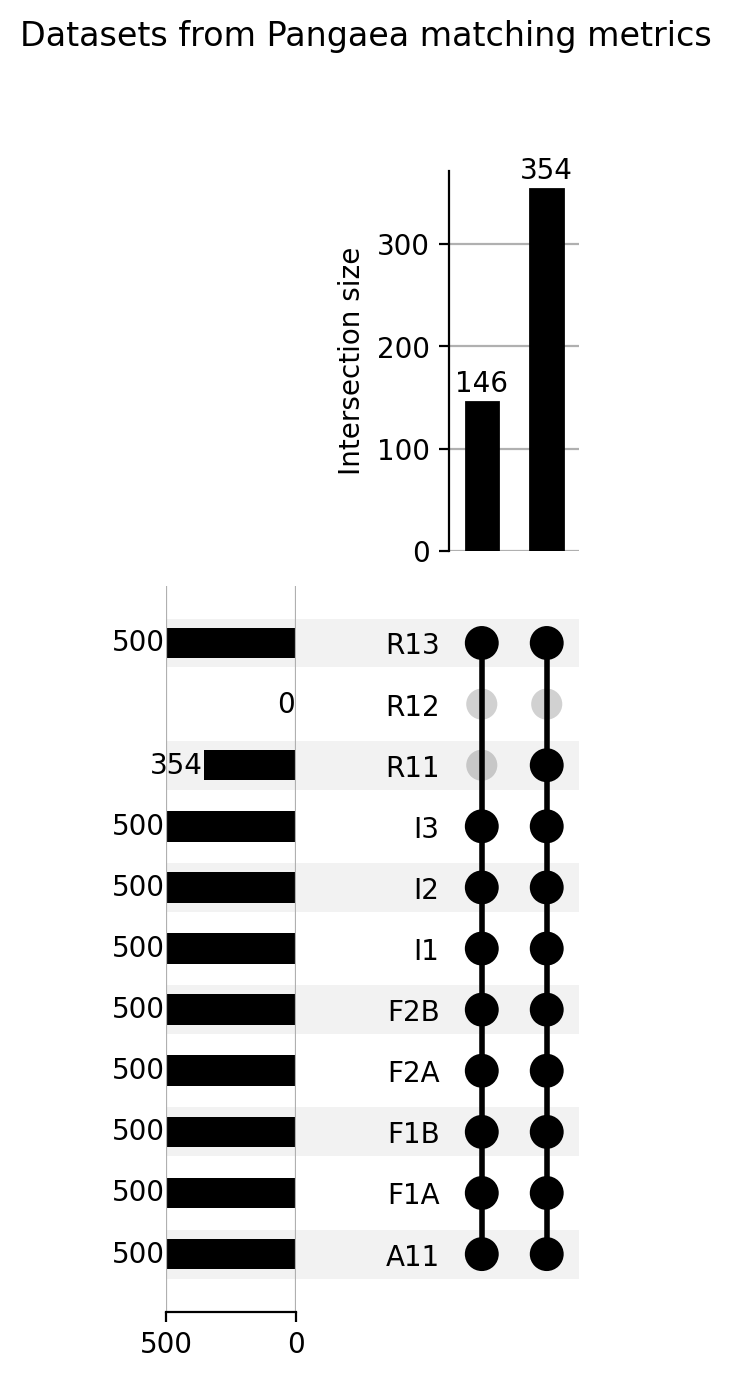

In [26]:
upset = UpSet(df_upset, subset_size='count', show_counts=True, sort_categories_by=None, orientation='horizontal')

#upset.style_subsets(present=["with_exome", "with_images"],
#                    facecolor="red")

params = {'legend.fontsize': 8}
with plt.rc_context(params):
    upset.plot()
plt.suptitle("Datasets from Pangaea matching metrics")
plt.savefig(OUTPUT_DIR + 'pangaea-no-F2B-no-R13.png', format="png")
plt.show()